<a href="https://colab.research.google.com/github/sriramnsut/CV-Project/blob/main/Steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## to ignore all the warning
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# import the image net data set
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2025-03-21 09:00:12--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-03-21 09:00:12--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  46.0MB/s    in 4.1s    

2025-03-21 09:00:16 (57.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
#BackUp for ImageDataset - Run this if there is issue while downloading
#!wget https://www.dropbox.com/s/jd673ol7dhaaiux/tiny-imagenet-200.zip

In [ ]:
# Unzipping of our data set & Delete the Zip File

!unzip /content/tiny-imagenet-200.zip
!rm /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64, 64)


#Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge.

Our training set is made of a random subset of images from all 200 classes.

In [ ]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3)

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


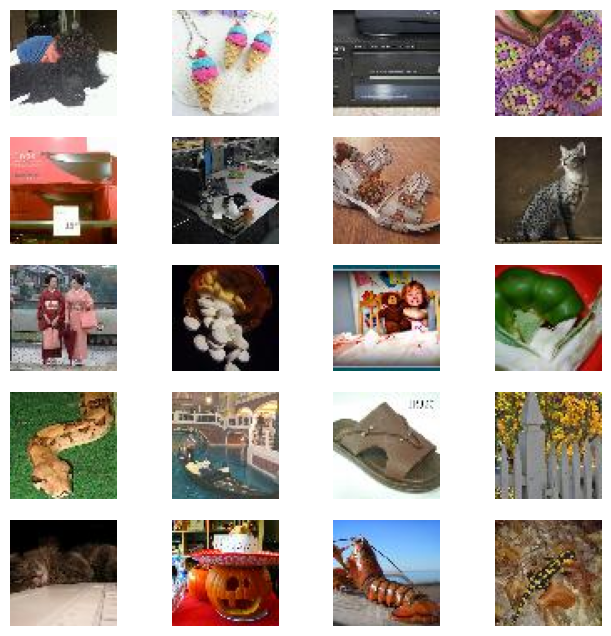

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]
# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
beta = 1.0

# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss

In [ ]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.

# def make_encoder(input_size):
#     input_S = Input(shape=(input_size))
#     input_C= Input(shape=(input_size))

#     # Preparation Network
#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
#     x = concatenate([x3, x4, x5])

#     x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
#     x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
#     x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
#     x = concatenate([x3, x4, x5])

#     x = concatenate([input_C, x])
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

def make_encoder(input_size):
    input_S = Input(shape=(input_size))  # Secret Image/Input Message
    input_C = Input(shape=(input_size))  # Carrier Image

    # Initial Encoding Layers (Feature Extraction for Steganography)
    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = Concatenate()([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = Concatenate()([x3, x4, x5])

    # Embedding Secret Image into Carrier
    x = Concatenate()([input_C, x])
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='encoded_image')(x)

    # Encoder Model (Acts as Generator in GAN framework)
    encoder_model = Model(inputs=[input_S, input_C], outputs=x, name='Encoder_Generator')
    return encoder_model


    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [ ]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')


In [ ]:
# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def train(e, lr=0.001):
    NB_EPOCHS = e
    BATCH_SIZE = 32

    encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

    # Directly set the learning rate for both optimizers
    autoencoder_model.optimizer.learning_rate = lr
    reveal_model.optimizer.learning_rate = lr

    m = input_S.shape[0]
    loss_history = []

    for epoch in range(NB_EPOCHS):
        np.random.shuffle(input_S)
        np.random.shuffle(input_C)
        t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)

        ae_loss = []
        rev_loss = []

        for idx in t:
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

            C_prime = encoder_model.predict([batch_S, batch_C])
            aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                      y=np.concatenate((batch_S, batch_C), axis=3))
            ae_loss.append(aeLoss)

            revLoss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
            rev_loss.append(revLoss)

            t.set_description('Epoch {} | Loss AE {:10.2f} | Loss Rev {:10.2f} | lr {}'.format(
                epoch + 1, np.mean(ae_loss), np.mean(rev_loss), lr))

        lr = lr_schedule(epoch + 1)
        mean_ae_loss = np.mean(ae_loss)
        loss_history.append(mean_ae_loss)

    autoencoder_model.save_weights('./model_weights.weights.h5')
    autoencoder_model.save("model.h5")

    return loss_history, autoencoder_model

In [ ]:
loss_history, autoencoder_model = train(200) # train funtion takes number of epochs as a input as i have traied my model for 1000 epochs i have saved the weights

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


Epoch 1 | Loss AE  148019.69 | Loss Rev  114703.02 | lr 0.001:   3%|▎         | 1/32 [00:06<03:29,  6.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 1 | Loss AE  146740.17 | Loss Rev  114446.17 | lr 0.001:   6%|▋         | 2/32 [00:07<01:28,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 1 | Loss AE  145207.20 | Loss Rev  113383.48 | lr 0.001:   9%|▉         | 3/32 [00:07<00:48,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 1 | Loss AE  145154.94 | Loss Rev  113696.12 | lr 0.001:  12%|█▎        | 4/32 [00:07<00:30,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  144758.14 | Loss Rev  113699.55 | lr 0.001:  16%|█▌        | 5/32 [00:07<00:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  144119.80 | Loss Rev  113536.15 | lr 0.001:  19%|█▉        | 6/32 [00:07<00:15,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  143259.48 | Loss Rev  113172.52 | lr 0.001:  22%|██▏       | 7/32 [00:08<00:11,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 1 | Loss AE  142333.06 | Loss Rev  112762.90 | lr 0.001:  25%|██▌       | 8/32 [00:08<00:09,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Loss AE  141573.61 | Loss Rev  112496.22 | lr 0.001:  28%|██▊       | 9/32 [00:08<00:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 1 | Loss AE  140818.17 | Loss Rev  112220.88 | lr 0.001:  31%|███▏      | 10/32 [00:08<00:06,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 1 | Loss AE  140212.14 | Loss Rev  112070.53 | lr 0.001:  34%|███▍      | 11/32 [00:09<00:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 1 | Loss AE  139657.22 | Loss Rev  111948.80 | lr 0.001:  38%|███▊      | 12/32 [00:09<00:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Loss AE  139179.39 | Loss Rev  111873.46 | lr 0.001:  41%|████      | 13/32 [00:09<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 1 | Loss AE  138774.33 | Loss Rev  111861.77 | lr 0.001:  44%|████▍     | 14/32 [00:09<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 1 | Loss AE  138415.84 | Loss Rev  111880.43 | lr 0.001:  47%|████▋     | 15/32 [00:10<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  138041.41 | Loss Rev  111872.56 | lr 0.001:  50%|█████     | 16/32 [00:10<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  137729.33 | Loss Rev  111910.37 | lr 0.001:  53%|█████▎    | 17/32 [00:10<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  137409.59 | Loss Rev  111928.16 | lr 0.001:  56%|█████▋    | 18/32 [00:10<00:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  137076.73 | Loss Rev  111914.38 | lr 0.001:  59%|█████▉    | 19/32 [00:10<00:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  136752.88 | Loss Rev  111894.23 | lr 0.001:  62%|██████▎   | 20/32 [00:11<00:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  136458.73 | Loss Rev  111892.66 | lr 0.001:  66%|██████▌   | 21/32 [00:11<00:02,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  136185.20 | Loss Rev  111889.84 | lr 0.001:  69%|██████▉   | 22/32 [00:11<00:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  135901.48 | Loss Rev  111867.75 | lr 0.001:  72%|███████▏  | 23/32 [00:11<00:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  135650.86 | Loss Rev  111870.38 | lr 0.001:  75%|███████▌  | 24/32 [00:11<00:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  135419.44 | Loss Rev  111882.94 | lr 0.001:  78%|███████▊  | 25/32 [00:12<00:01,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 1 | Loss AE  135195.48 | Loss Rev  111897.03 | lr 0.001:  81%|████████▏ | 26/32 [00:12<00:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 1 | Loss AE  134955.03 | Loss Rev  111888.95 | lr 0.001:  84%|████████▍ | 27/32 [00:12<00:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  134736.66 | Loss Rev  111892.59 | lr 0.001:  88%|████████▊ | 28/32 [00:12<00:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 1 | Loss AE  134547.12 | Loss Rev  111917.52 | lr 0.001:  91%|█████████ | 29/32 [00:12<00:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 1 | Loss AE  134361.19 | Loss Rev  111940.58 | lr 0.001:  94%|█████████▍| 30/32 [00:13<00:00,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 1 | Loss AE  134182.44 | Loss Rev  111964.23 | lr 0.001:  97%|█████████▋| 31/32 [00:13<00:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


Epoch 1 | Loss AE  133990.56 | Loss Rev  111965.67 | lr 0.001: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 2 | Loss AE  128044.22 | Loss Rev  112249.42 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 2 | Loss AE  128098.70 | Loss Rev  112421.44 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  128087.94 | Loss Rev  112511.91 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 2 | Loss AE  128011.56 | Loss Rev  112543.66 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 2 | Loss AE  127980.48 | Loss Rev  112624.30 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 2 | Loss AE  127901.47 | Loss Rev  112658.28 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 2 | Loss AE  127780.59 | Loss Rev  112648.02 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 2 | Loss AE  127666.38 | Loss Rev  112643.73 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 2 | Loss AE  127535.78 | Loss Rev  112619.03 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 2 | Loss AE  127427.40 | Loss Rev  112614.08 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 2 | Loss AE  127325.26 | Loss Rev  112614.16 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 2 | Loss AE  127219.76 | Loss Rev  112610.34 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 2 | Loss AE  127096.18 | Loss Rev  112586.89 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 2 | Loss AE  126976.02 | Loss Rev  112565.12 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  126859.66 | Loss Rev  112544.67 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 2 | Loss AE  126734.62 | Loss Rev  112513.54 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  126634.77 | Loss Rev  112506.16 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 2 | Loss AE  126530.77 | Loss Rev  112492.43 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  126427.16 | Loss Rev  112477.75 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  126325.52 | Loss Rev  112463.86 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  126230.21 | Loss Rev  112455.41 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 2 | Loss AE  126143.33 | Loss Rev  112453.98 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 2 | Loss AE  126058.27 | Loss Rev  112452.80 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 2 | Loss AE  125971.41 | Loss Rev  112448.50 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  125885.09 | Loss Rev  112443.53 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 2 | Loss AE  125810.95 | Loss Rev  112449.59 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  125726.34 | Loss Rev  112443.41 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 2 | Loss AE  125648.95 | Loss Rev  112443.52 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 2 | Loss AE  125567.24 | Loss Rev  112438.22 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 2 | Loss AE  125491.37 | Loss Rev  112437.59 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 2 | Loss AE  125423.56 | Loss Rev  112443.40 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 2 | Loss AE  125347.42 | Loss Rev  112437.52 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122797.51 | Loss Rev  112172.18 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122738.06 | Loss Rev  112168.85 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122637.20 | Loss Rev  112116.80 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 3 | Loss AE  122591.27 | Loss Rev  112121.55 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122549.08 | Loss Rev  112129.61 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122504.13 | Loss Rev  112134.03 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122445.87 | Loss Rev  112124.73 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 3 | Loss AE  122401.62 | Loss Rev  112129.12 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122364.41 | Loss Rev  112140.80 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122325.08 | Loss Rev  112148.94 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122282.10 | Loss Rev  112152.51 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 3 | Loss AE  122229.72 | Loss Rev  112146.23 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122173.99 | Loss Rev  112136.03 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 3 | Loss AE  122124.48 | Loss Rev  112131.43 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122082.62 | Loss Rev  112133.40 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122055.41 | Loss Rev  112149.41 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  122036.19 | Loss Rev  112172.82 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  122019.02 | Loss Rev  112197.66 | lr 0.001:  56%|█████▋    | 18/32 [00:03<00:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 3 | Loss AE  121990.98 | Loss Rev  112211.33 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  121963.27 | Loss Rev  112224.85 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  121940.32 | Loss Rev  112242.48 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 3 | Loss AE  121926.26 | Loss Rev  112268.28 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  121909.14 | Loss Rev  112290.48 | lr 0.001:  72%|███████▏  | 23/32 [00:04<00:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 3 | Loss AE  121891.46 | Loss Rev  112311.69 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  121872.81 | Loss Rev  112331.58 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 3 | Loss AE  121852.46 | Loss Rev  112349.32 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 3 | Loss AE  121830.55 | Loss Rev  112365.05 | lr 0.001:  84%|████████▍ | 27/32 [00:05<00:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 3 | Loss AE  121805.09 | Loss Rev  112376.83 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 3 | Loss AE  121781.86 | Loss Rev  112390.41 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 3 | Loss AE  121755.45 | Loss Rev  112400.49 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 3 | Loss AE  121726.91 | Loss Rev  112408.00 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 3 | Loss AE  121692.20 | Loss Rev  112407.74 | lr 0.001: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 4 | Loss AE  120565.71 | Loss Rev  112408.33 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 4 | Loss AE  120503.41 | Loss Rev  112372.33 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 4 | Loss AE  120493.59 | Loss Rev  112389.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 4 | Loss AE  120451.55 | Loss Rev  112374.12 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120373.11 | Loss Rev  112322.04 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120319.19 | Loss Rev  112294.47 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 4 | Loss AE  120291.21 | Loss Rev  112293.08 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 4 | Loss AE  120290.08 | Loss Rev  112318.44 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 4 | Loss AE  120292.03 | Loss Rev  112346.88 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120289.23 | Loss Rev  112370.69 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  120283.07 | Loss Rev  112391.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 4 | Loss AE  120271.38 | Loss Rev  112405.96 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 4 | Loss AE  120251.34 | Loss Rev  112412.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120227.54 | Loss Rev  112415.09 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 4 | Loss AE  120198.97 | Loss Rev  112412.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  120173.38 | Loss Rev  112412.81 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 4 | Loss AE  120160.29 | Loss Rev  112425.26 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  120149.38 | Loss Rev  112439.66 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120145.38 | Loss Rev  112460.79 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 4 | Loss AE  120136.69 | Loss Rev  112477.09 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 4 | Loss AE  120122.27 | Loss Rev  112487.38 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 4 | Loss AE  120106.74 | Loss Rev  112496.43 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120093.81 | Loss Rev  112507.98 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:01,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 4 | Loss AE  120077.90 | Loss Rev  112516.23 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  120064.18 | Loss Rev  112526.48 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  120048.84 | Loss Rev  112534.93 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 4 | Loss AE  120033.59 | Loss Rev  112543.14 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 4 | Loss AE  120013.54 | Loss Rev  112546.49 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  119991.09 | Loss Rev  112547.34 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 4 | Loss AE  119970.95 | Loss Rev  112550.23 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 4 | Loss AE  119952.73 | Loss Rev  112554.87 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch 4 | Loss AE  119929.80 | Loss Rev  112553.73 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119246.29 | Loss Rev  112586.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119234.41 | Loss Rev  112592.73 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 5 | Loss AE  119201.29 | Loss Rev  112578.56 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119191.98 | Loss Rev  112588.20 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 5 | Loss AE  119185.95 | Loss Rev  112600.46 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119185.26 | Loss Rev  112618.35 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 5 | Loss AE  119194.59 | Loss Rev  112646.32 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 5 | Loss AE  119186.12 | Loss Rev  112656.20 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 5 | Loss AE  119183.59 | Loss Rev  112672.03 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 5 | Loss AE  119172.89 | Loss Rev  112679.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119157.26 | Loss Rev  112682.24 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 5 | Loss AE  119139.34 | Loss Rev  112682.38 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 5 | Loss AE  119129.58 | Loss Rev  112690.68 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119128.48 | Loss Rev  112707.34 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119120.34 | Loss Rev  112716.87 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 5 | Loss AE  119106.08 | Loss Rev  112720.09 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 5 | Loss AE  119095.91 | Loss Rev  112727.27 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 5 | Loss AE  119087.25 | Loss Rev  112735.80 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 5 | Loss AE  119079.35 | Loss Rev  112745.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 5 | Loss AE  119072.73 | Loss Rev  112755.34 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 5 | Loss AE  119067.66 | Loss Rev  112767.06 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 5 | Loss AE  119059.30 | Loss Rev  112775.38 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 5 | Loss AE  119048.45 | Loss Rev  112781.10 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 5 | Loss AE  119042.02 | Loss Rev  112791.07 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 5 | Loss AE  119033.47 | Loss Rev  112798.88 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 5 | Loss AE  119021.29 | Loss Rev  112802.95 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  119007.80 | Loss Rev  112805.57 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 5 | Loss AE  118992.80 | Loss Rev  112806.62 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 5 | Loss AE  118977.41 | Loss Rev  112807.09 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 5 | Loss AE  118960.28 | Loss Rev  112805.70 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 5 | Loss AE  118943.16 | Loss Rev  112804.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Epoch 5 | Loss AE  118922.45 | Loss Rev  112798.45 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118314.00 | Loss Rev  112675.87 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118270.17 | Loss Rev  112645.47 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118261.35 | Loss Rev  112649.79 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118264.23 | Loss Rev  112664.60 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 6 | Loss AE  118256.90 | Loss Rev  112669.79 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118237.34 | Loss Rev  112663.10 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118230.63 | Loss Rev  112668.70 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 6 | Loss AE  118225.09 | Loss Rev  112675.66 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118221.75 | Loss Rev  112684.96 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118222.11 | Loss Rev  112697.61 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 6 | Loss AE  118224.40 | Loss Rev  112712.23 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 6 | Loss AE  118219.46 | Loss Rev  112719.72 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 6 | Loss AE  118210.66 | Loss Rev  112723.34 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 6 | Loss AE  118200.15 | Loss Rev  112725.10 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118187.28 | Loss Rev  112724.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118178.09 | Loss Rev  112727.59 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 6 | Loss AE  118169.25 | Loss Rev  112730.84 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118160.30 | Loss Rev  112733.95 | lr 0.001:  56%|█████▋    | 18/32 [00:03<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118151.30 | Loss Rev  112736.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118143.60 | Loss Rev  112741.29 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118133.98 | Loss Rev  112743.57 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118121.83 | Loss Rev  112743.33 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 6 | Loss AE  118108.47 | Loss Rev  112741.84 | lr 0.001:  72%|███████▏  | 23/32 [00:04<00:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 6 | Loss AE  118095.95 | Loss Rev  112741.07 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 6 | Loss AE  118082.42 | Loss Rev  112739.22 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 6 | Loss AE  118071.21 | Loss Rev  112739.62 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118059.44 | Loss Rev  112739.41 | lr 0.001:  84%|████████▍ | 27/32 [00:05<00:01,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118048.26 | Loss Rev  112739.68 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118037.56 | Loss Rev  112740.40 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 6 | Loss AE  118027.88 | Loss Rev  112742.09 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 6 | Loss AE  118018.72 | Loss Rev  112744.20 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 6 | Loss AE  118006.39 | Loss Rev  112742.64 | lr 0.001: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 7 | Loss AE  117574.79 | Loss Rev  112665.19 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 7 | Loss AE  117590.30 | Loss Rev  112691.47 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117609.95 | Loss Rev  112721.57 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 7 | Loss AE  117632.23 | Loss Rev  112754.05 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 7 | Loss AE  117633.39 | Loss Rev  112765.38 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117640.22 | Loss Rev  112782.16 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117644.63 | Loss Rev  112796.32 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117643.81 | Loss Rev  112805.30 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 7 | Loss AE  117645.05 | Loss Rev  112816.32 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 7 | Loss AE  117640.95 | Loss Rev  112821.83 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 7 | Loss AE  117634.42 | Loss Rev  112824.91 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 7 | Loss AE  117633.95 | Loss Rev  112834.01 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 7 | Loss AE  117631.33 | Loss Rev  112840.80 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 7 | Loss AE  117624.26 | Loss Rev  112843.14 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 7 | Loss AE  117612.95 | Loss Rev  112841.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 7 | Loss AE  117605.74 | Loss Rev  112843.41 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 7 | Loss AE  117599.95 | Loss Rev  112846.87 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 7 | Loss AE  117596.09 | Loss Rev  112852.27 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 7 | Loss AE  117587.90 | Loss Rev  112853.23 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117577.83 | Loss Rev  112852.29 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 7 | Loss AE  117568.77 | Loss Rev  112852.34 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117559.72 | Loss Rev  112852.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117547.25 | Loss Rev  112848.81 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 7 | Loss AE  117537.34 | Loss Rev  112847.85 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117527.72 | Loss Rev  112847.13 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 7 | Loss AE  117516.84 | Loss Rev  112845.11 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 7 | Loss AE  117508.71 | Loss Rev  112845.79 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117501.52 | Loss Rev  112847.32 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 7 | Loss AE  117491.35 | Loss Rev  112845.81 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 7 | Loss AE  117483.83 | Loss Rev  112846.90 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 7 | Loss AE  117475.34 | Loss Rev  112846.99 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch 7 | Loss AE  117464.19 | Loss Rev  112844.02 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117062.62 | Loss Rev  112710.95 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 8 | Loss AE  117054.41 | Loss Rev  112710.95 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 8 | Loss AE  117044.07 | Loss Rev  112708.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117038.06 | Loss Rev  112709.98 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117039.58 | Loss Rev  112719.11 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 8 | Loss AE  117042.07 | Loss Rev  112729.09 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 8 | Loss AE  117045.20 | Loss Rev  112739.69 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117048.56 | Loss Rev  112750.55 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 8 | Loss AE  117046.41 | Loss Rev  112755.80 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 8 | Loss AE  117039.52 | Loss Rev  112756.27 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 8 | Loss AE  117036.47 | Loss Rev  112760.55 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 8 | Loss AE  117030.49 | Loss Rev  112761.88 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117028.52 | Loss Rev  112767.05 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 8 | Loss AE  117024.48 | Loss Rev  112770.15 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  117019.78 | Loss Rev  112772.57 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 8 | Loss AE  117011.62 | Loss Rev  112771.44 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 8 | Loss AE  117003.58 | Loss Rev  112770.44 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  116993.75 | Loss Rev  112767.61 | lr 0.001:  56%|█████▋    | 18/32 [00:03<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 8 | Loss AE  116984.48 | Loss Rev  112765.33 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 8 | Loss AE  116973.73 | Loss Rev  112761.55 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  116962.59 | Loss Rev  112757.36 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 8 | Loss AE  116955.22 | Loss Rev  112756.85 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 8 | Loss AE  116948.61 | Loss Rev  112757.12 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  116942.53 | Loss Rev  112757.90 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 8 | Loss AE  116936.91 | Loss Rev  112759.05 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 8 | Loss AE  116931.51 | Loss Rev  112760.42 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 8 | Loss AE  116924.48 | Loss Rev  112760.15 | lr 0.001:  84%|████████▍ | 27/32 [00:05<00:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 8 | Loss AE  116917.06 | Loss Rev  112759.41 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 8 | Loss AE  116912.13 | Loss Rev  112761.15 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 8 | Loss AE  116907.12 | Loss Rev  112762.78 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 8 | Loss AE  116904.20 | Loss Rev  112766.45 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 8 | Loss AE  116898.70 | Loss Rev  112767.24 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 9 | Loss AE  116750.41 | Loss Rev  112826.33 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 9 | Loss AE  116731.91 | Loss Rev  112812.71 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 9 | Loss AE  116711.75 | Loss Rev  112798.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 9 | Loss AE  116689.67 | Loss Rev  112782.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 9 | Loss AE  116678.64 | Loss Rev  112776.60 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 9 | Loss AE  116672.74 | Loss Rev  112776.41 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116664.90 | Loss Rev  112774.33 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 9 | Loss AE  116656.88 | Loss Rev  112772.05 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 9 | Loss AE  116648.73 | Loss Rev  112769.55 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 9 | Loss AE  116642.12 | Loss Rev  112768.65 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 9 | Loss AE  116634.45 | Loss Rev  112766.66 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 9 | Loss AE  116626.12 | Loss Rev  112763.98 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 9 | Loss AE  116620.13 | Loss Rev  112763.63 | lr 0.001:  41%|████      | 13/32 [00:02<00:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116616.41 | Loss Rev  112765.58 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 9 | Loss AE  116615.49 | Loss Rev  112770.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 9 | Loss AE  116611.39 | Loss Rev  112771.79 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 9 | Loss AE  116606.75 | Loss Rev  112772.76 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 9 | Loss AE  116603.47 | Loss Rev  112775.05 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 9 | Loss AE  116600.95 | Loss Rev  112778.06 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 9 | Loss AE  116598.86 | Loss Rev  112781.52 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116595.34 | Loss Rev  112783.52 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 9 | Loss AE  116592.40 | Loss Rev  112786.05 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 9 | Loss AE  116588.61 | Loss Rev  112787.75 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116585.06 | Loss Rev  112789.69 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 9 | Loss AE  116582.00 | Loss Rev  112792.03 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 9 | Loss AE  116579.11 | Loss Rev  112794.53 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116577.51 | Loss Rev  112798.30 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 9 | Loss AE  116576.94 | Loss Rev  112803.05 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 9 | Loss AE  116574.78 | Loss Rev  112806.20 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116573.12 | Loss Rev  112809.84 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 9 | Loss AE  116570.80 | Loss Rev  112812.81 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch 9 | Loss AE  116566.19 | Loss Rev  112813.22 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116457.77 | Loss Rev  112871.20 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 10 | Loss AE  116434.26 | Loss Rev  112852.25 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116436.73 | Loss Rev  112859.22 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116438.00 | Loss Rev  112865.21 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116437.52 | Loss Rev  112869.44 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 10 | Loss AE  116443.40 | Loss Rev  112879.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 10 | Loss AE  116445.00 | Loss Rev  112886.14 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 10 | Loss AE  116445.77 | Loss Rev  112891.53 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 10 | Loss AE  116445.34 | Loss Rev  112895.64 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 10 | Loss AE  116445.52 | Loss Rev  112900.39 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 10 | Loss AE  116444.30 | Loss Rev  112903.76 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 10 | Loss AE  116442.21 | Loss Rev  112906.12 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 10 | Loss AE  116440.27 | Loss Rev  112908.68 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116437.12 | Loss Rev  112910.05 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 10 | Loss AE  116432.34 | Loss Rev  112909.70 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 10 | Loss AE  116429.68 | Loss Rev  112911.49 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 10 | Loss AE  116427.27 | Loss Rev  112913.56 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 10 | Loss AE  116422.88 | Loss Rev  112913.62 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 10 | Loss AE  116417.83 | Loss Rev  112913.04 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 10 | Loss AE  116415.62 | Loss Rev  112915.30 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 10 | Loss AE  116413.70 | Loss Rev  112917.82 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 10 | Loss AE  116413.58 | Loss Rev  112922.15 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 10 | Loss AE  116413.26 | Loss Rev  112926.26 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 10 | Loss AE  116412.52 | Loss Rev  112929.94 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 10 | Loss AE  116409.55 | Loss Rev  112931.37 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 10 | Loss AE  116407.12 | Loss Rev  112933.36 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 10 | Loss AE  116404.01 | Loss Rev  112934.63 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 10 | Loss AE  116399.05 | Loss Rev  112934.04 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 10 | Loss AE  116394.27 | Loss Rev  112933.64 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 10 | Loss AE  116389.25 | Loss Rev  112932.98 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 10 | Loss AE  116384.41 | Loss Rev  112932.48 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 10 | Loss AE  116377.69 | Loss Rev  112929.91 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 11 | Loss AE  116159.63 | Loss Rev  112848.65 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 11 | Loss AE  116171.11 | Loss Rev  112864.09 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116183.84 | Loss Rev  112880.69 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116168.44 | Loss Rev  112869.31 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116156.69 | Loss Rev  112861.65 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 11 | Loss AE  116148.91 | Loss Rev  112857.84 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 11 | Loss AE  116140.38 | Loss Rev  112853.25 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116136.88 | Loss Rev  112853.73 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 11 | Loss AE  116132.30 | Loss Rev  112853.03 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 11 | Loss AE  116127.30 | Loss Rev  112851.91 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 11 | Loss AE  116119.57 | Loss Rev  112848.08 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116115.01 | Loss Rev  112847.34 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116112.83 | Loss Rev  112848.98 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116108.81 | Loss Rev  112848.77 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 11 | Loss AE  116107.77 | Loss Rev  112851.52 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116107.99 | Loss Rev  112855.50 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116106.73 | Loss Rev  112858.02 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 11 | Loss AE  116104.14 | Loss Rev  112859.18 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116104.37 | Loss Rev  112863.15 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 11 | Loss AE  116103.27 | Loss Rev  112865.79 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 11 | Loss AE  116102.52 | Loss Rev  112868.75 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116102.51 | Loss Rev  112872.45 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116101.55 | Loss Rev  112875.19 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 11 | Loss AE  116100.88 | Loss Rev  112878.16 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116099.76 | Loss Rev  112880.72 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116098.99 | Loss Rev  112883.62 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 11 | Loss AE  116097.44 | Loss Rev  112885.71 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 11 | Loss AE  116095.40 | Loss Rev  112887.32 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 11 | Loss AE  116093.14 | Loss Rev  112888.70 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 11 | Loss AE  116090.77 | Loss Rev  112889.96 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 11 | Loss AE  116088.33 | Loss Rev  112891.15 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Epoch 11 | Loss AE  116084.11 | Loss Rev  112890.39 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 12 | Loss AE  115947.03 | Loss Rev  112867.32 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 12 | Loss AE  115967.06 | Loss Rev  112890.41 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 12 | Loss AE  115966.41 | Loss Rev  112893.07 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 12 | Loss AE  115975.35 | Loss Rev  112905.45 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 12 | Loss AE  115988.89 | Loss Rev  112922.20 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 12 | Loss AE  116002.51 | Loss Rev  112939.12 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 12 | Loss AE  116011.95 | Loss Rev  112951.83 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 12 | Loss AE  116019.28 | Loss Rev  112962.38 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 12 | Loss AE  116022.85 | Loss Rev  112969.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 12 | Loss AE  116023.40 | Loss Rev  112972.98 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 12 | Loss AE  116021.37 | Loss Rev  112974.13 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 12 | Loss AE  116022.34 | Loss Rev  112978.32 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 12 | Loss AE  116021.22 | Loss Rev  112980.42 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 12 | Loss AE  116017.45 | Loss Rev  112979.84 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 12 | Loss AE  116012.66 | Loss Rev  112978.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 12 | Loss AE  116005.05 | Loss Rev  112973.82 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 12 | Loss AE  115998.00 | Loss Rev  112969.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 12 | Loss AE  115993.87 | Loss Rev  112968.98 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 12 | Loss AE  115992.29 | Loss Rev  112970.52 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 12 | Loss AE  115992.27 | Loss Rev  112973.60 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 12 | Loss AE  115992.70 | Loss Rev  112977.16 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 12 | Loss AE  115993.41 | Loss Rev  112980.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 12 | Loss AE  115993.89 | Loss Rev  112984.50 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 12 | Loss AE  115994.19 | Loss Rev  112987.90 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 12 | Loss AE  115992.83 | Loss Rev  112989.61 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 12 | Loss AE  115991.16 | Loss Rev  112991.00 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 12 | Loss AE  115988.72 | Loss Rev  112991.64 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 12 | Loss AE  115985.77 | Loss Rev  112991.73 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 12 | Loss AE  115983.07 | Loss Rev  112992.09 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 12 | Loss AE  115980.50 | Loss Rev  112992.55 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 12 | Loss AE  115975.90 | Loss Rev  112990.99 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch 12 | Loss AE  115969.73 | Loss Rev  112987.73 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115748.58 | Loss Rev  112862.45 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115750.98 | Loss Rev  112867.72 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 13 | Loss AE  115741.65 | Loss Rev  112861.30 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115739.61 | Loss Rev  112862.16 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 13 | Loss AE  115728.65 | Loss Rev  112854.10 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 13 | Loss AE  115723.62 | Loss Rev  112851.94 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 13 | Loss AE  115720.27 | Loss Rev  112851.44 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 13 | Loss AE  115721.55 | Loss Rev  112855.52 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 13 | Loss AE  115725.64 | Loss Rev  112862.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115727.48 | Loss Rev  112867.05 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115724.12 | Loss Rev  112866.52 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115722.01 | Loss Rev  112867.21 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 13 | Loss AE  115723.95 | Loss Rev  112871.91 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115724.02 | Loss Rev  112874.75 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 13 | Loss AE  115722.10 | Loss Rev  112875.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 13 | Loss AE  115719.55 | Loss Rev  112875.80 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 13 | Loss AE  115717.23 | Loss Rev  112876.24 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115714.72 | Loss Rev  112876.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 13 | Loss AE  115712.73 | Loss Rev  112877.19 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 13 | Loss AE  115711.08 | Loss Rev  112878.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115708.84 | Loss Rev  112878.73 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115707.85 | Loss Rev  112880.45 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 13 | Loss AE  115708.20 | Loss Rev  112883.49 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 13 | Loss AE  115708.35 | Loss Rev  112886.32 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115708.88 | Loss Rev  112889.52 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 13 | Loss AE  115708.59 | Loss Rev  112891.88 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 13 | Loss AE  115707.03 | Loss Rev  112892.96 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 13 | Loss AE  115705.59 | Loss Rev  112894.17 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 13 | Loss AE  115703.77 | Loss Rev  112894.95 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 13 | Loss AE  115703.05 | Loss Rev  112896.85 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 13 | Loss AE  115702.25 | Loss Rev  112898.64 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 13 | Loss AE  115699.83 | Loss Rev  112898.70 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 14 | Loss AE  115627.08 | Loss Rev  112907.18 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 14 | Loss AE  115620.50 | Loss Rev  112903.04 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 14 | Loss AE  115613.40 | Loss Rev  112898.19 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 14 | Loss AE  115610.14 | Loss Rev  112897.14 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 14 | Loss AE  115608.17 | Loss Rev  112897.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 14 | Loss AE  115605.30 | Loss Rev  112896.81 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 14 | Loss AE  115606.54 | Loss Rev  112900.26 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 14 | Loss AE  115608.34 | Loss Rev  112904.37 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115610.95 | Loss Rev  112909.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 14 | Loss AE  115614.59 | Loss Rev  112915.05 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115617.28 | Loss Rev  112920.03 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115621.52 | Loss Rev  112926.54 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115625.86 | Loss Rev  112933.14 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115627.44 | Loss Rev  112937.02 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 14 | Loss AE  115626.73 | Loss Rev  112938.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115627.34 | Loss Rev  112941.47 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115626.85 | Loss Rev  112943.26 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 14 | Loss AE  115624.63 | Loss Rev  112943.33 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 14 | Loss AE  115622.06 | Loss Rev  112943.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115618.80 | Loss Rev  112942.02 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115616.52 | Loss Rev  112942.02 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 14 | Loss AE  115613.16 | Loss Rev  112940.93 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 14 | Loss AE  115612.13 | Loss Rev  112942.17 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 14 | Loss AE  115610.88 | Loss Rev  112943.19 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 14 | Loss AE  115611.13 | Loss Rev  112945.69 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115610.13 | Loss Rev  112946.95 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 14 | Loss AE  115608.27 | Loss Rev  112947.34 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115605.80 | Loss Rev  112947.12 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115604.12 | Loss Rev  112947.68 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 14 | Loss AE  115602.57 | Loss Rev  112948.36 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 14 | Loss AE  115601.00 | Loss Rev  112949.00 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch 14 | Loss AE  115597.90 | Loss Rev  112948.02 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 15 | Loss AE  115488.03 | Loss Rev  112908.28 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 15 | Loss AE  115503.80 | Loss Rev  112924.84 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115513.78 | Loss Rev  112936.53 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115516.32 | Loss Rev  112941.06 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115516.86 | Loss Rev  112943.21 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 15 | Loss AE  115512.51 | Loss Rev  112940.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115507.26 | Loss Rev  112937.32 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 15 | Loss AE  115506.64 | Loss Rev  112938.41 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 15 | Loss AE  115502.60 | Loss Rev  112936.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 15 | Loss AE  115497.71 | Loss Rev  112933.14 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 15 | Loss AE  115496.02 | Loss Rev  112933.17 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 15 | Loss AE  115491.50 | Loss Rev  112930.45 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115487.67 | Loss Rev  112928.47 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115485.40 | Loss Rev  112928.01 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115481.91 | Loss Rev  112926.33 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115478.41 | Loss Rev  112924.64 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115476.97 | Loss Rev  112925.05 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 15 | Loss AE  115475.51 | Loss Rev  112925.38 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 15 | Loss AE  115473.85 | Loss Rev  112925.55 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 15 | Loss AE  115471.46 | Loss Rev  112925.02 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 15 | Loss AE  115469.18 | Loss Rev  112924.57 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 15 | Loss AE  115467.38 | Loss Rev  112924.62 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 15 | Loss AE  115466.40 | Loss Rev  112925.52 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 15 | Loss AE  115463.49 | Loss Rev  112924.48 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 15 | Loss AE  115461.03 | Loss Rev  112923.88 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 15 | Loss AE  115458.62 | Loss Rev  112923.33 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 15 | Loss AE  115456.70 | Loss Rev  112923.29 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 15 | Loss AE  115455.32 | Loss Rev  112923.77 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 15 | Loss AE  115454.66 | Loss Rev  112924.98 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 15 | Loss AE  115454.48 | Loss Rev  112926.65 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 15 | Loss AE  115454.11 | Loss Rev  112928.16 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch 15 | Loss AE  115452.30 | Loss Rev  112928.13 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115363.92 | Loss Rev  112898.37 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115359.03 | Loss Rev  112895.39 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 16 | Loss AE  115351.16 | Loss Rev  112889.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 16 | Loss AE  115351.54 | Loss Rev  112891.50 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115355.77 | Loss Rev  112897.44 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115356.56 | Loss Rev  112899.99 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 16 | Loss AE  115356.18 | Loss Rev  112901.42 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 16 | Loss AE  115356.50 | Loss Rev  112903.47 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115358.09 | Loss Rev  112906.80 | lr 0.001:  28%|██▊       | 9/32 [00:01<00:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 16 | Loss AE  115362.44 | Loss Rev  112912.95 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115363.30 | Loss Rev  112915.57 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115364.31 | Loss Rev  112918.34 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 16 | Loss AE  115365.24 | Loss Rev  112921.03 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115365.38 | Loss Rev  112922.95 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115363.45 | Loss Rev  112922.74 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 16 | Loss AE  115361.77 | Loss Rev  112922.80 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115361.62 | Loss Rev  112924.41 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 16 | Loss AE  115361.33 | Loss Rev  112925.84 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 16 | Loss AE  115360.60 | Loss Rev  112926.83 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115359.95 | Loss Rev  112927.91 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 16 | Loss AE  115357.91 | Loss Rev  112927.59 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 16 | Loss AE  115356.90 | Loss Rev  112928.30 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 16 | Loss AE  115356.20 | Loss Rev  112929.31 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 16 | Loss AE  115356.19 | Loss Rev  112931.02 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115356.45 | Loss Rev  112933.00 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 16 | Loss AE  115356.98 | Loss Rev  112935.23 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 16 | Loss AE  115356.44 | Loss Rev  112936.39 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 16 | Loss AE  115356.83 | Loss Rev  112938.49 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 16 | Loss AE  115357.41 | Loss Rev  112940.76 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 16 | Loss AE  115357.24 | Loss Rev  112942.27 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 16 | Loss AE  115356.75 | Loss Rev  112943.47 | lr 0.001:  97%|█████████▋| 31/32 [00:06<00:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 16 | Loss AE  115354.92 | Loss Rev  112943.23 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 17 | Loss AE  115292.48 | Loss Rev  112933.11 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 17 | Loss AE  115285.38 | Loss Rev  112927.91 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115286.88 | Loss Rev  112931.10 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 17 | Loss AE  115285.35 | Loss Rev  112931.03 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115286.56 | Loss Rev  112933.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 17 | Loss AE  115284.90 | Loss Rev  112933.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115283.91 | Loss Rev  112934.26 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115282.33 | Loss Rev  112934.17 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 17 | Loss AE  115280.99 | Loss Rev  112934.39 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 17 | Loss AE  115280.11 | Loss Rev  112935.10 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 17 | Loss AE  115279.18 | Loss Rev  112935.70 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 17 | Loss AE  115276.90 | Loss Rev  112934.95 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 17 | Loss AE  115272.13 | Loss Rev  112931.74 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 17 | Loss AE  115269.05 | Loss Rev  112930.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 17 | Loss AE  115268.43 | Loss Rev  112931.12 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 17 | Loss AE  115269.12 | Loss Rev  112933.33 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 17 | Loss AE  115270.38 | Loss Rev  112936.13 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 17 | Loss AE  115270.55 | Loss Rev  112937.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115269.40 | Loss Rev  112938.25 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 17 | Loss AE  115269.38 | Loss Rev  112939.79 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 17 | Loss AE  115269.25 | Loss Rev  112941.21 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 17 | Loss AE  115269.72 | Loss Rev  112943.22 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115270.88 | Loss Rev  112945.92 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115271.48 | Loss Rev  112948.09 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115271.75 | Loss Rev  112949.90 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115271.46 | Loss Rev  112951.13 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115270.48 | Loss Rev  112951.69 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115270.00 | Loss Rev  112952.73 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115269.97 | Loss Rev  112954.20 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 17 | Loss AE  115269.57 | Loss Rev  112955.33 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 17 | Loss AE  115269.09 | Loss Rev  112956.38 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 17 | Loss AE  115267.37 | Loss Rev  112956.09 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115229.93 | Loss Rev  112965.87 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115236.38 | Loss Rev  112973.87 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115248.12 | Loss Rev  112987.20 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115252.23 | Loss Rev  112992.59 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115258.14 | Loss Rev  112999.88 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 18 | Loss AE  115263.60 | Loss Rev  113006.79 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115266.45 | Loss Rev  113011.07 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 18 | Loss AE  115265.59 | Loss Rev  113011.60 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 18 | Loss AE  115265.66 | Loss Rev  113013.07 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115267.38 | Loss Rev  113016.20 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115267.58 | Loss Rev  113017.80 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115267.57 | Loss Rev  113019.21 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115266.76 | Loss Rev  113019.82 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115265.16 | Loss Rev  113019.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 18 | Loss AE  115263.84 | Loss Rev  113019.68 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115264.84 | Loss Rev  113022.11 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 18 | Loss AE  115266.73 | Loss Rev  113025.40 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 18 | Loss AE  115267.74 | Loss Rev  113027.80 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 18 | Loss AE  115267.21 | Loss Rev  113028.65 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115266.61 | Loss Rev  113029.45 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115264.86 | Loss Rev  113029.09 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 18 | Loss AE  115262.95 | Loss Rev  113028.59 | lr 0.001:  69%|██████▉   | 22/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115260.84 | Loss Rev  113027.87 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115258.46 | Loss Rev  113026.88 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115255.67 | Loss Rev  113025.49 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 18 | Loss AE  115254.33 | Loss Rev  113025.54 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 18 | Loss AE  115252.98 | Loss Rev  113025.59 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 18 | Loss AE  115251.14 | Loss Rev  113025.13 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 18 | Loss AE  115249.26 | Loss Rev  113024.63 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 18 | Loss AE  115247.55 | Loss Rev  113024.30 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 18 | Loss AE  115245.49 | Loss Rev  113023.63 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 18 | Loss AE  115242.24 | Loss Rev  113021.70 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 19 | Loss AE  115148.58 | Loss Rev  112971.77 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 19 | Loss AE  115135.91 | Loss Rev  112960.49 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 19 | Loss AE  115126.30 | Loss Rev  112952.29 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 19 | Loss AE  115123.46 | Loss Rev  112950.73 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 19 | Loss AE  115128.12 | Loss Rev  112956.67 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 19 | Loss AE  115130.46 | Loss Rev  112960.34 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 19 | Loss AE  115132.35 | Loss Rev  112963.52 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115133.89 | Loss Rev  112966.34 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 19 | Loss AE  115134.36 | Loss Rev  112968.12 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 19 | Loss AE  115133.70 | Loss Rev  112968.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 19 | Loss AE  115130.34 | Loss Rev  112966.72 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 19 | Loss AE  115127.05 | Loss Rev  112964.74 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115125.63 | Loss Rev  112964.63 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 19 | Loss AE  115124.69 | Loss Rev  112964.98 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 19 | Loss AE  115123.27 | Loss Rev  112964.86 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115122.17 | Loss Rev  112965.06 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 19 | Loss AE  115120.22 | Loss Rev  112964.41 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 19 | Loss AE  115117.07 | Loss Rev  112962.54 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 19 | Loss AE  115114.63 | Loss Rev  112961.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115113.08 | Loss Rev  112961.12 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 19 | Loss AE  115111.23 | Loss Rev  112960.56 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 19 | Loss AE  115109.83 | Loss Rev  112960.42 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115108.74 | Loss Rev  112960.60 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 19 | Loss AE  115108.18 | Loss Rev  112961.27 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 19 | Loss AE  115106.97 | Loss Rev  112961.32 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115106.36 | Loss Rev  112961.97 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 19 | Loss AE  115105.23 | Loss Rev  112962.09 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 19 | Loss AE  115104.62 | Loss Rev  112962.73 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 19 | Loss AE  115104.40 | Loss Rev  112963.75 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 19 | Loss AE  115103.70 | Loss Rev  112964.28 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 19 | Loss AE  115103.56 | Loss Rev  112965.39 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 19 | Loss AE  115102.34 | Loss Rev  112965.35 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115054.02 | Loss Rev  112956.29 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 20 | Loss AE  115039.16 | Loss Rev  112942.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 20 | Loss AE  115042.12 | Loss Rev  112946.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 20 | Loss AE  115042.15 | Loss Rev  112947.80 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 20 | Loss AE  115040.79 | Loss Rev  112947.62 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115044.65 | Loss Rev  112952.62 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115046.77 | Loss Rev  112955.93 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 20 | Loss AE  115047.08 | Loss Rev  112957.41 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 20 | Loss AE  115050.76 | Loss Rev  112962.23 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 20 | Loss AE  115053.70 | Loss Rev  112966.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 20 | Loss AE  115056.80 | Loss Rev  112970.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 20 | Loss AE  115058.37 | Loss Rev  112973.35 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 20 | Loss AE  115057.32 | Loss Rev  112973.49 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115055.62 | Loss Rev  112972.98 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115055.00 | Loss Rev  112973.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 20 | Loss AE  115056.36 | Loss Rev  112976.08 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 20 | Loss AE  115057.04 | Loss Rev  112977.92 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 20 | Loss AE  115056.91 | Loss Rev  112978.97 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 20 | Loss AE  115056.55 | Loss Rev  112979.77 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 20 | Loss AE  115055.04 | Loss Rev  112979.41 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 20 | Loss AE  115053.18 | Loss Rev  112978.71 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 20 | Loss AE  115051.34 | Loss Rev  112978.02 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 20 | Loss AE  115050.33 | Loss Rev  112978.15 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 20 | Loss AE  115050.59 | Loss Rev  112979.56 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 20 | Loss AE  115050.92 | Loss Rev  112981.02 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 20 | Loss AE  115052.01 | Loss Rev  112983.24 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 20 | Loss AE  115052.70 | Loss Rev  112985.06 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 20 | Loss AE  115052.84 | Loss Rev  112986.35 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 20 | Loss AE  115053.05 | Loss Rev  112987.68 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 20 | Loss AE  115052.86 | Loss Rev  112988.63 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 20 | Loss AE  115052.40 | Loss Rev  112989.30 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch 20 | Loss AE  115050.81 | Loss Rev  112988.80 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 21 | Loss AE  114991.98 | Loss Rev  112965.75 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 21 | Loss AE  114993.47 | Loss Rev  112968.31 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 21 | Loss AE  114991.72 | Loss Rev  112967.66 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 21 | Loss AE  114988.86 | Loss Rev  112965.91 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 21 | Loss AE  114987.12 | Loss Rev  112965.21 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 21 | Loss AE  114986.53 | Loss Rev  112965.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 21 | Loss AE  114983.21 | Loss Rev  112963.40 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114981.43 | Loss Rev  112962.67 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114979.03 | Loss Rev  112961.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 21 | Loss AE  114978.17 | Loss Rev  112961.55 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 21 | Loss AE  114975.98 | Loss Rev  112960.43 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114974.76 | Loss Rev  112960.28 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 21 | Loss AE  114973.88 | Loss Rev  112960.48 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 21 | Loss AE  114973.08 | Loss Rev  112960.76 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114970.93 | Loss Rev  112959.68 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 21 | Loss AE  114968.42 | Loss Rev  112958.26 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114966.52 | Loss Rev  112957.44 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114963.98 | Loss Rev  112955.97 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114961.46 | Loss Rev  112954.52 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 21 | Loss AE  114959.14 | Loss Rev  112953.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114956.29 | Loss Rev  112951.48 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 21 | Loss AE  114954.12 | Loss Rev  112950.37 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114952.80 | Loss Rev  112950.11 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114952.21 | Loss Rev  112950.57 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114951.41 | Loss Rev  112950.83 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114951.14 | Loss Rev  112951.62 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 21 | Loss AE  114951.60 | Loss Rev  112953.12 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 21 | Loss AE  114952.04 | Loss Rev  112954.60 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 21 | Loss AE  114952.53 | Loss Rev  112956.13 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 21 | Loss AE  114952.34 | Loss Rev  112956.97 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 21 | Loss AE  114953.09 | Loss Rev  112958.75 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch 21 | Loss AE  114952.73 | Loss Rev  112959.38 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114930.05 | Loss Rev  112969.16 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114921.48 | Loss Rev  112961.67 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 22 | Loss AE  114923.45 | Loss Rev  112964.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 22 | Loss AE  114920.72 | Loss Rev  112962.84 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 22 | Loss AE  114919.38 | Loss Rev  112962.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 22 | Loss AE  114922.31 | Loss Rev  112966.37 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114925.48 | Loss Rev  112970.49 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114926.12 | Loss Rev  112972.10 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 22 | Loss AE  114928.54 | Loss Rev  112975.48 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 22 | Loss AE  114930.85 | Loss Rev  112978.75 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 22 | Loss AE  114932.13 | Loss Rev  112981.00 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 22 | Loss AE  114932.02 | Loss Rev  112981.85 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 22 | Loss AE  114931.86 | Loss Rev  112982.64 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 22 | Loss AE  114931.94 | Loss Rev  112983.69 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 22 | Loss AE  114934.80 | Loss Rev  112987.50 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 22 | Loss AE  114936.23 | Loss Rev  112989.88 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 22 | Loss AE  114936.79 | Loss Rev  112991.39 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114937.34 | Loss Rev  112992.89 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114939.06 | Loss Rev  112995.56 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114939.77 | Loss Rev  112997.23 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 22 | Loss AE  114940.87 | Loss Rev  112999.27 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 22 | Loss AE  114940.93 | Loss Rev  113000.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 22 | Loss AE  114939.77 | Loss Rev  113000.08 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 22 | Loss AE  114938.44 | Loss Rev  112999.68 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 22 | Loss AE  114937.71 | Loss Rev  112999.89 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114937.18 | Loss Rev  113000.30 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114936.78 | Loss Rev  113000.84 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 22 | Loss AE  114936.11 | Loss Rev  113001.09 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 22 | Loss AE  114935.43 | Loss Rev  113001.35 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 22 | Loss AE  114934.80 | Loss Rev  113001.66 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 22 | Loss AE  114934.42 | Loss Rev  113002.20 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 22 | Loss AE  114933.02 | Loss Rev  113001.70 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 23 | Loss AE  114912.59 | Loss Rev  113010.65 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114917.73 | Loss Rev  113016.53 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114927.66 | Loss Rev  113027.31 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 23 | Loss AE  114932.06 | Loss Rev  113032.61 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114931.16 | Loss Rev  113032.56 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114931.49 | Loss Rev  113033.75 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114931.11 | Loss Rev  113034.25 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 23 | Loss AE  114929.38 | Loss Rev  113033.39 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 23 | Loss AE  114926.03 | Loss Rev  113030.89 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 23 | Loss AE  114921.80 | Loss Rev  113027.55 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 23 | Loss AE  114915.88 | Loss Rev  113022.51 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 23 | Loss AE  114909.12 | Loss Rev  113016.62 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114902.47 | Loss Rev  113010.87 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 23 | Loss AE  114896.80 | Loss Rev  113006.05 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 23 | Loss AE  114891.03 | Loss Rev  113001.16 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 23 | Loss AE  114886.90 | Loss Rev  112997.89 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114882.58 | Loss Rev  112994.44 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114878.54 | Loss Rev  112991.28 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 23 | Loss AE  114874.87 | Loss Rev  112988.48 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 23 | Loss AE  114872.38 | Loss Rev  112986.85 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114870.62 | Loss Rev  112985.95 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 23 | Loss AE  114868.88 | Loss Rev  112985.09 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 23 | Loss AE  114867.25 | Loss Rev  112984.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 23 | Loss AE  114866.34 | Loss Rev  112984.25 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 23 | Loss AE  114865.96 | Loss Rev  112984.73 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 23 | Loss AE  114865.64 | Loss Rev  112985.26 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 23 | Loss AE  114865.36 | Loss Rev  112985.82 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 23 | Loss AE  114864.37 | Loss Rev  112985.68 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 23 | Loss AE  114863.63 | Loss Rev  112985.80 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 23 | Loss AE  114863.61 | Loss Rev  112986.62 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 23 | Loss AE  114863.92 | Loss Rev  112987.78 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 23 | Loss AE  114863.22 | Loss Rev  112987.90 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 24 | Loss AE  114840.87 | Loss Rev  112992.21 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 24 | Loss AE  114841.81 | Loss Rev  112994.02 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 24 | Loss AE  114842.21 | Loss Rev  112995.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 24 | Loss AE  114843.23 | Loss Rev  112997.02 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 24 | Loss AE  114843.45 | Loss Rev  112998.06 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 24 | Loss AE  114844.38 | Loss Rev  112999.77 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 24 | Loss AE  114844.65 | Loss Rev  113000.85 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114842.80 | Loss Rev  112999.82 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 24 | Loss AE  114840.52 | Loss Rev  112998.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 24 | Loss AE  114837.86 | Loss Rev  112996.50 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114834.55 | Loss Rev  112994.00 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 24 | Loss AE  114831.43 | Loss Rev  112991.68 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 24 | Loss AE  114829.83 | Loss Rev  112990.88 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 24 | Loss AE  114826.82 | Loss Rev  112988.68 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 24 | Loss AE  114824.28 | Loss Rev  112986.92 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 24 | Loss AE  114822.69 | Loss Rev  112986.11 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114822.19 | Loss Rev  112986.40 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 24 | Loss AE  114822.64 | Loss Rev  112987.64 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114823.71 | Loss Rev  112989.50 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114823.66 | Loss Rev  112990.25 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 24 | Loss AE  114823.11 | Loss Rev  112990.48 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 24 | Loss AE  114822.88 | Loss Rev  112991.05 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 24 | Loss AE  114822.35 | Loss Rev  112991.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 24 | Loss AE  114821.77 | Loss Rev  112991.51 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114821.54 | Loss Rev  112992.07 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 24 | Loss AE  114820.95 | Loss Rev  112992.27 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 24 | Loss AE  114820.02 | Loss Rev  112992.12 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114819.25 | Loss Rev  112992.13 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 24 | Loss AE  114819.66 | Loss Rev  112993.33 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 24 | Loss AE  114820.27 | Loss Rev  112994.73 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 24 | Loss AE  114820.52 | Loss Rev  112995.76 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 24 | Loss AE  114819.81 | Loss Rev  112995.80 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 25 | Loss AE  114784.14 | Loss Rev  112984.93 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 25 | Loss AE  114790.64 | Loss Rev  112992.14 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114794.91 | Loss Rev  112997.16 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 25 | Loss AE  114795.45 | Loss Rev  112998.46 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 25 | Loss AE  114796.81 | Loss Rev  113000.59 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 25 | Loss AE  114794.12 | Loss Rev  112998.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 25 | Loss AE  114791.16 | Loss Rev  112996.50 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 25 | Loss AE  114787.02 | Loss Rev  112993.16 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114784.66 | Loss Rev  112991.56 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114781.55 | Loss Rev  112989.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 25 | Loss AE  114779.18 | Loss Rev  112987.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114777.18 | Loss Rev  112986.38 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 25 | Loss AE  114774.02 | Loss Rev  112984.00 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 25 | Loss AE  114771.15 | Loss Rev  112981.90 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:03,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 25 | Loss AE  114768.55 | Loss Rev  112980.07 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 25 | Loss AE  114766.01 | Loss Rev  112978.25 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 25 | Loss AE  114764.66 | Loss Rev  112977.65 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 25 | Loss AE  114763.78 | Loss Rev  112977.53 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 25 | Loss AE  114763.73 | Loss Rev  112978.21 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 25 | Loss AE  114764.05 | Loss Rev  112979.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 25 | Loss AE  114764.63 | Loss Rev  112980.61 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 25 | Loss AE  114765.49 | Loss Rev  112982.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 25 | Loss AE  114766.72 | Loss Rev  112984.16 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 25 | Loss AE  114768.44 | Loss Rev  112986.62 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 25 | Loss AE  114770.09 | Loss Rev  112989.02 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114771.37 | Loss Rev  112991.03 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 25 | Loss AE  114773.25 | Loss Rev  112993.65 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 25 | Loss AE  114774.40 | Loss Rev  112995.52 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 25 | Loss AE  114774.82 | Loss Rev  112996.67 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 25 | Loss AE  114775.27 | Loss Rev  112997.85 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 25 | Loss AE  114775.40 | Loss Rev  112998.70 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 25 | Loss AE  114774.66 | Loss Rev  112998.66 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114747.63 | Loss Rev  112994.77 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114747.95 | Loss Rev  112995.53 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114748.02 | Loss Rev  112996.25 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 26 | Loss AE  114745.57 | Loss Rev  112994.46 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114741.81 | Loss Rev  112991.34 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 26 | Loss AE  114740.41 | Loss Rev  112990.62 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114737.12 | Loss Rev  112987.99 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 26 | Loss AE  114736.78 | Loss Rev  112988.31 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 26 | Loss AE  114738.20 | Loss Rev  112990.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114738.55 | Loss Rev  112991.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 26 | Loss AE  114741.02 | Loss Rev  112994.57 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114741.00 | Loss Rev  112995.23 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114740.38 | Loss Rev  112995.28 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 26 | Loss AE  114739.23 | Loss Rev  112994.80 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 26 | Loss AE  114737.05 | Loss Rev  112993.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114735.12 | Loss Rev  112992.03 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114733.33 | Loss Rev  112990.92 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 26 | Loss AE  114731.83 | Loss Rev  112990.09 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 26 | Loss AE  114730.56 | Loss Rev  112989.52 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 26 | Loss AE  114730.29 | Loss Rev  112989.90 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 26 | Loss AE  114729.91 | Loss Rev  112990.20 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114729.82 | Loss Rev  112990.76 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114729.78 | Loss Rev  112991.38 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 26 | Loss AE  114730.10 | Loss Rev  112992.37 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 26 | Loss AE  114730.34 | Loss Rev  112993.26 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114730.75 | Loss Rev  112994.33 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 26 | Loss AE  114730.69 | Loss Rev  112994.93 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 26 | Loss AE  114730.85 | Loss Rev  112995.73 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 26 | Loss AE  114731.05 | Loss Rev  112996.59 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 26 | Loss AE  114731.57 | Loss Rev  112997.77 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 26 | Loss AE  114731.91 | Loss Rev  112998.75 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 26 | Loss AE  114731.38 | Loss Rev  112998.83 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 27 | Loss AE  114705.38 | Loss Rev  112993.51 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 27 | Loss AE  114708.17 | Loss Rev  112996.84 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 27 | Loss AE  114701.06 | Loss Rev  112990.41 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 27 | Loss AE  114700.83 | Loss Rev  112990.84 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 27 | Loss AE  114699.25 | Loss Rev  112989.90 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 27 | Loss AE  114699.02 | Loss Rev  112990.31 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 27 | Loss AE  114697.75 | Loss Rev  112989.68 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 27 | Loss AE  114697.67 | Loss Rev  112990.22 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 27 | Loss AE  114697.42 | Loss Rev  112990.60 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 27 | Loss AE  114697.38 | Loss Rev  112991.19 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 27 | Loss AE  114697.20 | Loss Rev  112991.65 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 27 | Loss AE  114697.66 | Loss Rev  112992.74 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 27 | Loss AE  114697.09 | Loss Rev  112992.80 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 27 | Loss AE  114696.09 | Loss Rev  112992.42 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 27 | Loss AE  114695.34 | Loss Rev  112992.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 27 | Loss AE  114694.62 | Loss Rev  112992.20 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 27 | Loss AE  114694.00 | Loss Rev  112992.20 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 27 | Loss AE  114693.84 | Loss Rev  112992.68 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 27 | Loss AE  114693.77 | Loss Rev  112993.23 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 27 | Loss AE  114693.58 | Loss Rev  112993.66 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 27 | Loss AE  114693.98 | Loss Rev  112994.70 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 27 | Loss AE  114693.80 | Loss Rev  112995.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 27 | Loss AE  114693.70 | Loss Rev  112995.64 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 27 | Loss AE  114693.40 | Loss Rev  112995.94 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 27 | Loss AE  114694.02 | Loss Rev  112997.16 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 27 | Loss AE  114694.55 | Loss Rev  112998.30 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 27 | Loss AE  114695.16 | Loss Rev  112999.51 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 27 | Loss AE  114695.79 | Loss Rev  113000.74 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 27 | Loss AE  114696.19 | Loss Rev  113001.76 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 27 | Loss AE  114696.75 | Loss Rev  113002.92 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 27 | Loss AE  114696.91 | Loss Rev  113003.70 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 27 | Loss AE  114696.26 | Loss Rev  113003.62 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 28 | Loss AE  114691.30 | Loss Rev  113017.99 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 28 | Loss AE  114688.78 | Loss Rev  113015.81 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 28 | Loss AE  114691.35 | Loss Rev  113018.90 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 28 | Loss AE  114692.23 | Loss Rev  113020.35 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 28 | Loss AE  114688.62 | Loss Rev  113017.29 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 28 | Loss AE  114687.46 | Loss Rev  113016.68 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 28 | Loss AE  114686.92 | Loss Rev  113016.73 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114685.02 | Loss Rev  113015.38 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114684.22 | Loss Rev  113015.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 28 | Loss AE  114684.29 | Loss Rev  113015.83 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114683.13 | Loss Rev  113015.24 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 28 | Loss AE  114681.82 | Loss Rev  113014.51 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 28 | Loss AE  114681.34 | Loss Rev  113014.62 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 28 | Loss AE  114679.84 | Loss Rev  113013.70 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 28 | Loss AE  114678.70 | Loss Rev  113013.14 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 28 | Loss AE  114678.41 | Loss Rev  113013.42 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 28 | Loss AE  114677.77 | Loss Rev  113013.35 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 28 | Loss AE  114677.53 | Loss Rev  113013.71 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 28 | Loss AE  114677.63 | Loss Rev  113014.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114677.98 | Loss Rev  113015.31 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 28 | Loss AE  114678.30 | Loss Rev  113016.23 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114678.52 | Loss Rev  113017.02 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 28 | Loss AE  114678.17 | Loss Rev  113017.26 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 28 | Loss AE  114677.41 | Loss Rev  113017.09 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 28 | Loss AE  114676.48 | Loss Rev  113016.73 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 28 | Loss AE  114675.66 | Loss Rev  113016.50 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 28 | Loss AE  114675.30 | Loss Rev  113016.73 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 28 | Loss AE  114674.92 | Loss Rev  113016.93 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 28 | Loss AE  114674.52 | Loss Rev  113017.11 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 28 | Loss AE  114674.01 | Loss Rev  113017.20 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 28 | Loss AE  114673.70 | Loss Rev  113017.46 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 28 | Loss AE  114672.64 | Loss Rev  113016.94 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 29 | Loss AE  114628.01 | Loss Rev  112990.79 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 29 | Loss AE  114624.20 | Loss Rev  112987.58 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 29 | Loss AE  114619.54 | Loss Rev  112983.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 29 | Loss AE  114617.91 | Loss Rev  112982.41 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114616.71 | Loss Rev  112981.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 29 | Loss AE  114615.85 | Loss Rev  112981.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 29 | Loss AE  114614.33 | Loss Rev  112980.49 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 29 | Loss AE  114613.66 | Loss Rev  112980.38 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 29 | Loss AE  114612.28 | Loss Rev  112979.53 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 29 | Loss AE  114611.86 | Loss Rev  112979.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 29 | Loss AE  114610.75 | Loss Rev  112979.12 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 29 | Loss AE  114610.13 | Loss Rev  112979.07 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114609.84 | Loss Rev  112979.34 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 29 | Loss AE  114609.38 | Loss Rev  112979.43 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 29 | Loss AE  114609.92 | Loss Rev  112980.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114610.03 | Loss Rev  112981.20 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 29 | Loss AE  114609.33 | Loss Rev  112981.05 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 29 | Loss AE  114608.16 | Loss Rev  112980.42 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114607.17 | Loss Rev  112979.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 29 | Loss AE  114605.52 | Loss Rev  112978.86 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 29 | Loss AE  114604.66 | Loss Rev  112978.56 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 29 | Loss AE  114603.67 | Loss Rev  112978.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 29 | Loss AE  114603.61 | Loss Rev  112978.61 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 29 | Loss AE  114602.84 | Loss Rev  112978.40 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114602.29 | Loss Rev  112978.40 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114602.20 | Loss Rev  112978.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114602.28 | Loss Rev  112979.47 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 29 | Loss AE  114602.94 | Loss Rev  112980.67 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 29 | Loss AE  114603.68 | Loss Rev  112981.95 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 29 | Loss AE  114604.29 | Loss Rev  112983.10 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 29 | Loss AE  114605.29 | Loss Rev  112984.64 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 29 | Loss AE  114605.44 | Loss Rev  112985.31 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 30 | Loss AE  114606.99 | Loss Rev  113003.97 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 30 | Loss AE  114601.80 | Loss Rev  112999.18 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 30 | Loss AE  114598.45 | Loss Rev  112996.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 30 | Loss AE  114600.66 | Loss Rev  112999.09 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 30 | Loss AE  114599.98 | Loss Rev  112998.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 30 | Loss AE  114595.84 | Loss Rev  112995.28 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 30 | Loss AE  114594.49 | Loss Rev  112994.45 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 30 | Loss AE  114593.38 | Loss Rev  112993.87 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 30 | Loss AE  114592.98 | Loss Rev  112993.98 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 30 | Loss AE  114591.83 | Loss Rev  112993.34 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 30 | Loss AE  114590.33 | Loss Rev  112992.35 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 30 | Loss AE  114589.20 | Loss Rev  112991.76 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 30 | Loss AE  114589.28 | Loss Rev  112992.37 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 30 | Loss AE  114589.02 | Loss Rev  112992.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 30 | Loss AE  114589.30 | Loss Rev  112993.43 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 30 | Loss AE  114589.69 | Loss Rev  112994.34 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 30 | Loss AE  114590.55 | Loss Rev  112995.71 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 30 | Loss AE  114591.74 | Loss Rev  112997.41 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 30 | Loss AE  114592.58 | Loss Rev  112998.77 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 30 | Loss AE  114592.55 | Loss Rev  112999.25 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 30 | Loss AE  114592.54 | Loss Rev  112999.75 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 30 | Loss AE  114592.62 | Loss Rev  113000.37 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 30 | Loss AE  114592.34 | Loss Rev  113000.60 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 30 | Loss AE  114592.45 | Loss Rev  113001.21 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 30 | Loss AE  114592.73 | Loss Rev  113002.00 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 30 | Loss AE  114593.02 | Loss Rev  113002.80 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 30 | Loss AE  114593.21 | Loss Rev  113003.50 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 30 | Loss AE  114593.57 | Loss Rev  113004.38 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 30 | Loss AE  114594.12 | Loss Rev  113005.44 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 30 | Loss AE  114594.70 | Loss Rev  113006.53 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 30 | Loss AE  114594.91 | Loss Rev  113007.24 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 30 | Loss AE  114594.38 | Loss Rev  113007.22 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 31 | Loss AE  114585.94 | Loss Rev  113014.92 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114581.42 | Loss Rev  113010.80 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 31 | Loss AE  114582.00 | Loss Rev  113011.82 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 31 | Loss AE  114582.45 | Loss Rev  113012.77 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 31 | Loss AE  114582.27 | Loss Rev  113013.05 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114581.30 | Loss Rev  113012.55 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 31 | Loss AE  114582.48 | Loss Rev  113014.21 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114581.70 | Loss Rev  113013.89 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 31 | Loss AE  114581.18 | Loss Rev  113013.84 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 31 | Loss AE  114580.17 | Loss Rev  113013.33 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114580.70 | Loss Rev  113014.32 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114580.66 | Loss Rev  113014.78 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 31 | Loss AE  114580.43 | Loss Rev  113015.02 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 31 | Loss AE  114579.43 | Loss Rev  113014.50 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114577.82 | Loss Rev  113013.38 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 31 | Loss AE  114577.23 | Loss Rev  113013.28 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 31 | Loss AE  114577.48 | Loss Rev  113014.02 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114578.62 | Loss Rev  113015.64 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 31 | Loss AE  114580.10 | Loss Rev  113017.60 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 31 | Loss AE  114582.21 | Loss Rev  113020.19 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 31 | Loss AE  114583.14 | Loss Rev  113021.59 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 31 | Loss AE  114584.17 | Loss Rev  113023.09 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 31 | Loss AE  114584.98 | Loss Rev  113024.37 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114585.54 | Loss Rev  113025.43 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114586.04 | Loss Rev  113026.41 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 31 | Loss AE  114586.47 | Loss Rev  113027.33 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 31 | Loss AE  114586.50 | Loss Rev  113027.84 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 31 | Loss AE  114586.02 | Loss Rev  113027.85 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 31 | Loss AE  114586.05 | Loss Rev  113028.35 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114585.90 | Loss Rev  113028.67 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 31 | Loss AE  114585.33 | Loss Rev  113028.59 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 31 | Loss AE  114584.13 | Loss Rev  113027.84 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 32 | Loss AE  114540.81 | Loss Rev  112999.54 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 32 | Loss AE  114543.47 | Loss Rev  113002.69 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 32 | Loss AE  114547.88 | Loss Rev  113007.41 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 32 | Loss AE  114551.64 | Loss Rev  113011.58 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 32 | Loss AE  114552.88 | Loss Rev  113013.25 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 32 | Loss AE  114556.06 | Loss Rev  113016.84 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 32 | Loss AE  114556.38 | Loss Rev  113017.57 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 32 | Loss AE  114556.86 | Loss Rev  113018.50 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 32 | Loss AE  114557.91 | Loss Rev  113019.97 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 32 | Loss AE  114558.73 | Loss Rev  113021.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 32 | Loss AE  114561.55 | Loss Rev  113024.47 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 32 | Loss AE  114563.85 | Loss Rev  113027.20 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 32 | Loss AE  114564.78 | Loss Rev  113028.57 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 32 | Loss AE  114565.14 | Loss Rev  113029.38 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 32 | Loss AE  114565.83 | Loss Rev  113030.49 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 32 | Loss AE  114566.03 | Loss Rev  113031.14 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 32 | Loss AE  114565.35 | Loss Rev  113030.91 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 32 | Loss AE  114564.78 | Loss Rev  113030.78 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 32 | Loss AE  114564.73 | Loss Rev  113031.20 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 32 | Loss AE  114564.29 | Loss Rev  113031.20 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 32 | Loss AE  114563.87 | Loss Rev  113031.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 32 | Loss AE  114562.67 | Loss Rev  113030.48 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 32 | Loss AE  114561.55 | Loss Rev  113029.81 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 32 | Loss AE  114560.46 | Loss Rev  113029.16 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 32 | Loss AE  114559.92 | Loss Rev  113029.08 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 32 | Loss AE  114559.88 | Loss Rev  113029.50 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 32 | Loss AE  114559.55 | Loss Rev  113029.61 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 32 | Loss AE  114559.24 | Loss Rev  113029.76 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 32 | Loss AE  114558.57 | Loss Rev  113029.53 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 32 | Loss AE  114557.77 | Loss Rev  113029.20 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 32 | Loss AE  114556.81 | Loss Rev  113028.69 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 32 | Loss AE  114555.34 | Loss Rev  113027.62 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 33 | Loss AE  114496.70 | Loss Rev  112983.14 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 33 | Loss AE  114501.19 | Loss Rev  112988.10 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 33 | Loss AE  114501.09 | Loss Rev  112988.40 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 33 | Loss AE  114500.88 | Loss Rev  112988.59 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 33 | Loss AE  114502.05 | Loss Rev  112990.20 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 33 | Loss AE  114501.60 | Loss Rev  112990.16 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 33 | Loss AE  114501.10 | Loss Rev  112990.08 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 33 | Loss AE  114501.08 | Loss Rev  112990.48 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 33 | Loss AE  114500.45 | Loss Rev  112990.28 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 33 | Loss AE  114499.79 | Loss Rev  112990.02 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 33 | Loss AE  114499.38 | Loss Rev  112990.03 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 33 | Loss AE  114499.82 | Loss Rev  112990.90 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 33 | Loss AE  114501.17 | Loss Rev  112992.66 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 33 | Loss AE  114502.12 | Loss Rev  112994.04 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 33 | Loss AE  114502.24 | Loss Rev  112994.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 33 | Loss AE  114502.20 | Loss Rev  112994.99 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 33 | Loss AE  114501.96 | Loss Rev  112995.18 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 33 | Loss AE  114502.29 | Loss Rev  112995.92 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 33 | Loss AE  114502.70 | Loss Rev  112996.75 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 33 | Loss AE  114502.48 | Loss Rev  112996.95 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 33 | Loss AE  114502.64 | Loss Rev  112997.55 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 33 | Loss AE  114502.75 | Loss Rev  112998.08 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 33 | Loss AE  114503.05 | Loss Rev  112998.80 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 33 | Loss AE  114503.60 | Loss Rev  112999.78 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 33 | Loss AE  114504.10 | Loss Rev  113000.70 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 33 | Loss AE  114504.76 | Loss Rev  113001.79 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 33 | Loss AE  114505.04 | Loss Rev  113002.49 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 33 | Loss AE  114505.13 | Loss Rev  113003.01 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 33 | Loss AE  114504.98 | Loss Rev  113003.27 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 33 | Loss AE  114504.97 | Loss Rev  113003.68 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 33 | Loss AE  114504.74 | Loss Rev  113003.88 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 33 | Loss AE  114503.95 | Loss Rev  113003.48 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 34 | Loss AE  114478.74 | Loss Rev  112991.82 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 34 | Loss AE  114481.97 | Loss Rev  112995.30 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114484.94 | Loss Rev  112998.65 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 34 | Loss AE  114486.34 | Loss Rev  113000.47 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 34 | Loss AE  114486.15 | Loss Rev  113000.65 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 34 | Loss AE  114486.16 | Loss Rev  113001.05 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 34 | Loss AE  114487.19 | Loss Rev  113002.46 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114488.64 | Loss Rev  113004.30 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 34 | Loss AE  114488.38 | Loss Rev  113004.44 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 34 | Loss AE  114488.12 | Loss Rev  113004.58 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 34 | Loss AE  114487.24 | Loss Rev  113004.09 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 34 | Loss AE  114487.13 | Loss Rev  113004.40 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 34 | Loss AE  114487.20 | Loss Rev  113004.86 | lr 0.001:  41%|████      | 13/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 34 | Loss AE  114486.99 | Loss Rev  113005.06 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 34 | Loss AE  114486.62 | Loss Rev  113005.10 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 34 | Loss AE  114486.38 | Loss Rev  113005.27 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 34 | Loss AE  114486.45 | Loss Rev  113005.74 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 34 | Loss AE  114486.01 | Loss Rev  113005.70 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114485.30 | Loss Rev  113005.41 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114485.27 | Loss Rev  113005.77 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114484.84 | Loss Rev  113005.75 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 34 | Loss AE  114484.03 | Loss Rev  113005.37 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114483.47 | Loss Rev  113005.20 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 34 | Loss AE  114482.65 | Loss Rev  113004.78 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 34 | Loss AE  114481.65 | Loss Rev  113004.18 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 34 | Loss AE  114481.28 | Loss Rev  113004.21 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 34 | Loss AE  114480.91 | Loss Rev  113004.24 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 34 | Loss AE  114480.64 | Loss Rev  113004.38 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 34 | Loss AE  114480.20 | Loss Rev  113004.33 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114480.02 | Loss Rev  113004.54 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 34 | Loss AE  114479.85 | Loss Rev  113004.78 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 34 | Loss AE  114479.06 | Loss Rev  113004.38 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 35 | Loss AE  114461.03 | Loss Rev  112998.94 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 35 | Loss AE  114464.48 | Loss Rev  113002.78 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 35 | Loss AE  114469.34 | Loss Rev  113007.98 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 35 | Loss AE  114471.86 | Loss Rev  113010.86 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 35 | Loss AE  114472.54 | Loss Rev  113011.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114470.51 | Loss Rev  113010.26 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 35 | Loss AE  114468.88 | Loss Rev  113009.02 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114467.34 | Loss Rev  113007.88 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114465.84 | Loss Rev  113006.75 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 35 | Loss AE  114465.77 | Loss Rev  113007.06 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 35 | Loss AE  114465.16 | Loss Rev  113006.84 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 35 | Loss AE  114465.15 | Loss Rev  113007.21 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 35 | Loss AE  114464.84 | Loss Rev  113007.29 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 35 | Loss AE  114464.99 | Loss Rev  113007.80 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 35 | Loss AE  114465.10 | Loss Rev  113008.29 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 35 | Loss AE  114465.84 | Loss Rev  113009.40 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 35 | Loss AE  114466.01 | Loss Rev  113009.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 35 | Loss AE  114466.03 | Loss Rev  113010.34 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 35 | Loss AE  114465.66 | Loss Rev  113010.35 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 35 | Loss AE  114465.59 | Loss Rev  113010.66 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 35 | Loss AE  114465.77 | Loss Rev  113011.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 35 | Loss AE  114466.23 | Loss Rev  113012.07 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 35 | Loss AE  114466.49 | Loss Rev  113012.70 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 35 | Loss AE  114466.82 | Loss Rev  113013.40 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114466.91 | Loss Rev  113013.87 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 35 | Loss AE  114466.80 | Loss Rev  113014.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 35 | Loss AE  114466.13 | Loss Rev  113013.86 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114465.13 | Loss Rev  113013.25 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 35 | Loss AE  114464.48 | Loss Rev  113012.98 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 35 | Loss AE  114464.12 | Loss Rev  113012.99 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 35 | Loss AE  114463.70 | Loss Rev  113012.96 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 35 | Loss AE  114462.69 | Loss Rev  113012.31 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 36 | Loss AE  114434.33 | Loss Rev  112996.05 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114429.50 | Loss Rev  112991.59 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 36 | Loss AE  114426.91 | Loss Rev  112989.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114425.70 | Loss Rev  112988.54 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 36 | Loss AE  114424.88 | Loss Rev  112988.09 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114423.75 | Loss Rev  112987.34 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114424.12 | Loss Rev  112988.07 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114424.28 | Loss Rev  112988.62 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114423.66 | Loss Rev  112988.38 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 36 | Loss AE  114422.36 | Loss Rev  112987.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114421.22 | Loss Rev  112986.66 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 36 | Loss AE  114421.48 | Loss Rev  112987.29 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 36 | Loss AE  114421.89 | Loss Rev  112988.05 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114422.73 | Loss Rev  112989.25 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 36 | Loss AE  114423.30 | Loss Rev  112990.20 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 36 | Loss AE  114423.50 | Loss Rev  112990.73 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114423.51 | Loss Rev  112991.10 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114423.97 | Loss Rev  112991.92 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114424.20 | Loss Rev  112992.50 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 36 | Loss AE  114424.61 | Loss Rev  112993.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114424.36 | Loss Rev  112993.38 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 36 | Loss AE  114424.15 | Loss Rev  112993.53 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 36 | Loss AE  114424.05 | Loss Rev  112993.80 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 36 | Loss AE  114424.29 | Loss Rev  112994.41 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 36 | Loss AE  114424.60 | Loss Rev  112995.08 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114425.02 | Loss Rev  112995.87 | lr 0.001:  81%|████████▏ | 26/32 [00:05<00:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 36 | Loss AE  114425.34 | Loss Rev  112996.55 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 36 | Loss AE  114425.51 | Loss Rev  112997.08 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 36 | Loss AE  114425.65 | Loss Rev  112997.58 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 36 | Loss AE  114425.59 | Loss Rev  112997.88 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 36 | Loss AE  114425.52 | Loss Rev  112998.18 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 36 | Loss AE  114424.91 | Loss Rev  112997.89 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 37 | Loss AE  114416.19 | Loss Rev  113000.48 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 37 | Loss AE  114411.38 | Loss Rev  112995.97 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 37 | Loss AE  114409.49 | Loss Rev  112994.45 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 37 | Loss AE  114407.73 | Loss Rev  112993.01 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 37 | Loss AE  114409.12 | Loss Rev  112994.71 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 37 | Loss AE  114410.93 | Loss Rev  112996.85 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 37 | Loss AE  114411.92 | Loss Rev  112998.14 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 37 | Loss AE  114412.05 | Loss Rev  112998.61 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 37 | Loss AE  114412.00 | Loss Rev  112998.88 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 37 | Loss AE  114411.89 | Loss Rev  112999.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 37 | Loss AE  114410.78 | Loss Rev  112998.33 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 37 | Loss AE  114409.43 | Loss Rev  112997.29 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 37 | Loss AE  114408.50 | Loss Rev  112996.68 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 37 | Loss AE  114407.70 | Loss Rev  112996.20 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 37 | Loss AE  114406.27 | Loss Rev  112995.09 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 37 | Loss AE  114404.85 | Loss Rev  112994.00 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 37 | Loss AE  114403.46 | Loss Rev  112992.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 37 | Loss AE  114402.30 | Loss Rev  112992.10 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 37 | Loss AE  114401.08 | Loss Rev  112991.21 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 37 | Loss AE  114399.64 | Loss Rev  112990.10 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 37 | Loss AE  114398.29 | Loss Rev  112989.07 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 37 | Loss AE  114397.59 | Loss Rev  112988.72 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 37 | Loss AE  114397.11 | Loss Rev  112988.55 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 37 | Loss AE  114396.59 | Loss Rev  112988.38 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 37 | Loss AE  114396.07 | Loss Rev  112988.19 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 37 | Loss AE  114395.68 | Loss Rev  112988.13 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 37 | Loss AE  114395.57 | Loss Rev  112988.35 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 37 | Loss AE  114395.24 | Loss Rev  112988.34 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 37 | Loss AE  114395.47 | Loss Rev  112988.89 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 37 | Loss AE  114395.76 | Loss Rev  112989.50 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 37 | Loss AE  114395.98 | Loss Rev  112990.05 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 37 | Loss AE  114395.62 | Loss Rev  112989.98 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 38 | Loss AE  114406.51 | Loss Rev  113011.09 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 38 | Loss AE  114405.06 | Loss Rev  113009.57 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 38 | Loss AE  114402.87 | Loss Rev  113007.55 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 38 | Loss AE  114400.66 | Loss Rev  113005.59 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 38 | Loss AE  114398.39 | Loss Rev  113003.50 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114396.57 | Loss Rev  113001.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114395.29 | Loss Rev  113000.86 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 38 | Loss AE  114393.29 | Loss Rev  112999.06 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 38 | Loss AE  114391.73 | Loss Rev  112997.73 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 38 | Loss AE  114391.23 | Loss Rev  112997.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 38 | Loss AE  114390.45 | Loss Rev  112996.92 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114389.81 | Loss Rev  112996.53 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114389.73 | Loss Rev  112996.71 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114390.20 | Loss Rev  112997.42 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 38 | Loss AE  114389.85 | Loss Rev  112997.32 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 38 | Loss AE  114389.93 | Loss Rev  112997.65 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114390.22 | Loss Rev  112998.18 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 38 | Loss AE  114390.22 | Loss Rev  112998.43 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 38 | Loss AE  114390.19 | Loss Rev  112998.67 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 38 | Loss AE  114390.15 | Loss Rev  112998.90 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 38 | Loss AE  114390.62 | Loss Rev  112999.63 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 38 | Loss AE  114391.30 | Loss Rev  113000.58 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 38 | Loss AE  114391.76 | Loss Rev  113001.31 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 38 | Loss AE  114391.71 | Loss Rev  113001.52 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 38 | Loss AE  114391.82 | Loss Rev  113001.92 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 38 | Loss AE  114391.62 | Loss Rev  113002.00 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 38 | Loss AE  114391.65 | Loss Rev  113002.30 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 38 | Loss AE  114391.81 | Loss Rev  113002.76 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 38 | Loss AE  114391.77 | Loss Rev  113003.01 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 38 | Loss AE  114391.60 | Loss Rev  113003.12 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 38 | Loss AE  114391.56 | Loss Rev  113003.37 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 38 | Loss AE  114390.93 | Loss Rev  113003.01 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 39 | Loss AE  114353.92 | Loss Rev  112975.34 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114354.78 | Loss Rev  112976.45 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 39 | Loss AE  114356.40 | Loss Rev  112978.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114353.88 | Loss Rev  112976.17 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 39 | Loss AE  114353.33 | Loss Rev  112975.94 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 39 | Loss AE  114350.66 | Loss Rev  112973.59 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 39 | Loss AE  114351.38 | Loss Rev  112974.63 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 39 | Loss AE  114350.44 | Loss Rev  112974.03 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 39 | Loss AE  114349.86 | Loss Rev  112973.77 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 39 | Loss AE  114349.46 | Loss Rev  112973.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 39 | Loss AE  114349.37 | Loss Rev  112973.88 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 39 | Loss AE  114348.12 | Loss Rev  112972.96 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 39 | Loss AE  114347.41 | Loss Rev  112972.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114347.15 | Loss Rev  112972.61 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 39 | Loss AE  114346.77 | Loss Rev  112972.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 39 | Loss AE  114346.27 | Loss Rev  112972.34 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 39 | Loss AE  114345.55 | Loss Rev  112971.94 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 39 | Loss AE  114344.46 | Loss Rev  112971.16 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114343.95 | Loss Rev  112970.96 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 39 | Loss AE  114343.84 | Loss Rev  112971.16 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 39 | Loss AE  114344.06 | Loss Rev  112971.69 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 39 | Loss AE  114344.07 | Loss Rev  112972.01 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 39 | Loss AE  114344.40 | Loss Rev  112972.65 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 39 | Loss AE  114344.91 | Loss Rev  112973.46 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 39 | Loss AE  114345.23 | Loss Rev  112974.08 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114345.11 | Loss Rev  112974.27 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 39 | Loss AE  114345.19 | Loss Rev  112974.66 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 39 | Loss AE  114345.48 | Loss Rev  112975.26 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 39 | Loss AE  114346.40 | Loss Rev  112976.48 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 39 | Loss AE  114346.98 | Loss Rev  112977.38 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 39 | Loss AE  114347.83 | Loss Rev  112978.53 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch 39 | Loss AE  114348.05 | Loss Rev  112979.05 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 40 | Loss AE  114346.50 | Loss Rev  112987.24 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114345.69 | Loss Rev  112986.70 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 40 | Loss AE  114345.77 | Loss Rev  112987.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 40 | Loss AE  114345.81 | Loss Rev  112987.44 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114346.45 | Loss Rev  112988.36 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114346.68 | Loss Rev  112988.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 40 | Loss AE  114348.08 | Loss Rev  112990.59 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 40 | Loss AE  114350.64 | Loss Rev  112993.44 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 40 | Loss AE  114351.79 | Loss Rev  112994.89 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 40 | Loss AE  114351.70 | Loss Rev  112995.10 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 40 | Loss AE  114351.70 | Loss Rev  112995.38 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 40 | Loss AE  114351.31 | Loss Rev  112995.30 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 40 | Loss AE  114350.86 | Loss Rev  112995.16 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 40 | Loss AE  114350.70 | Loss Rev  112995.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 40 | Loss AE  114350.10 | Loss Rev  112995.00 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 40 | Loss AE  114349.53 | Loss Rev  112994.73 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114349.41 | Loss Rev  112994.91 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 40 | Loss AE  114349.28 | Loss Rev  112995.09 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 40 | Loss AE  114349.15 | Loss Rev  112995.25 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 40 | Loss AE  114349.08 | Loss Rev  112995.46 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 40 | Loss AE  114349.30 | Loss Rev  112995.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 40 | Loss AE  114349.60 | Loss Rev  112996.59 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 40 | Loss AE  114350.08 | Loss Rev  112997.36 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 40 | Loss AE  114350.62 | Loss Rev  112998.19 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 40 | Loss AE  114350.99 | Loss Rev  112998.84 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114351.09 | Loss Rev  112999.23 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 40 | Loss AE  114351.04 | Loss Rev  112999.47 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 40 | Loss AE  114350.70 | Loss Rev  112999.43 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 40 | Loss AE  114350.61 | Loss Rev  112999.62 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 40 | Loss AE  114350.49 | Loss Rev  112999.79 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 40 | Loss AE  114350.43 | Loss Rev  113000.02 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 40 | Loss AE  114349.88 | Loss Rev  112999.75 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 41 | Loss AE  114331.96 | Loss Rev  112991.05 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 41 | Loss AE  114331.69 | Loss Rev  112991.05 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 41 | Loss AE  114330.66 | Loss Rev  112990.31 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114327.70 | Loss Rev  112987.64 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114326.83 | Loss Rev  112987.05 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114324.49 | Loss Rev  112985.01 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114321.21 | Loss Rev  112982.05 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 41 | Loss AE  114318.34 | Loss Rev  112979.48 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 41 | Loss AE  114316.61 | Loss Rev  112978.04 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 41 | Loss AE  114315.70 | Loss Rev  112977.41 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114314.95 | Loss Rev  112976.95 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 41 | Loss AE  114314.57 | Loss Rev  112976.84 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 41 | Loss AE  114314.33 | Loss Rev  112976.88 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114313.93 | Loss Rev  112976.76 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114313.97 | Loss Rev  112977.08 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114313.62 | Loss Rev  112977.00 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 41 | Loss AE  114313.08 | Loss Rev  112976.75 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114312.40 | Loss Rev  112976.35 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 41 | Loss AE  114311.77 | Loss Rev  112976.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 41 | Loss AE  114311.60 | Loss Rev  112976.12 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114311.82 | Loss Rev  112976.62 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114311.88 | Loss Rev  112976.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 41 | Loss AE  114312.83 | Loss Rev  112978.17 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 41 | Loss AE  114313.74 | Loss Rev  112979.38 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 41 | Loss AE  114314.74 | Loss Rev  112980.65 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 41 | Loss AE  114315.59 | Loss Rev  112981.78 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 41 | Loss AE  114316.40 | Loss Rev  112982.87 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 41 | Loss AE  114317.33 | Loss Rev  112984.08 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 41 | Loss AE  114318.01 | Loss Rev  112985.03 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 41 | Loss AE  114318.59 | Loss Rev  112985.89 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 41 | Loss AE  114319.09 | Loss Rev  112986.68 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 41 | Loss AE  114319.02 | Loss Rev  112986.88 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 42 | Loss AE  114325.84 | Loss Rev  113002.65 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 42 | Loss AE  114322.44 | Loss Rev  112999.38 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 42 | Loss AE  114324.27 | Loss Rev  113001.45 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 42 | Loss AE  114327.69 | Loss Rev  113005.10 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 42 | Loss AE  114329.02 | Loss Rev  113006.66 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 42 | Loss AE  114329.90 | Loss Rev  113007.79 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 42 | Loss AE  114331.17 | Loss Rev  113009.31 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 42 | Loss AE  114332.44 | Loss Rev  113010.83 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 42 | Loss AE  114333.91 | Loss Rev  113012.56 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 42 | Loss AE  114334.60 | Loss Rev  113013.50 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 42 | Loss AE  114335.09 | Loss Rev  113014.25 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 42 | Loss AE  114335.96 | Loss Rev  113015.38 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 42 | Loss AE  114336.38 | Loss Rev  113016.07 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 42 | Loss AE  114336.62 | Loss Rev  113016.56 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 42 | Loss AE  114336.80 | Loss Rev  113017.02 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 42 | Loss AE  114336.95 | Loss Rev  113017.43 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 42 | Loss AE  114336.55 | Loss Rev  113017.30 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 42 | Loss AE  114335.77 | Loss Rev  113016.78 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 42 | Loss AE  114335.16 | Loss Rev  113016.45 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 42 | Loss AE  114334.75 | Loss Rev  113016.31 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 42 | Loss AE  114334.21 | Loss Rev  113016.05 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 42 | Loss AE  114333.48 | Loss Rev  113015.58 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 42 | Loss AE  114332.55 | Loss Rev  113014.91 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 42 | Loss AE  114331.65 | Loss Rev  113014.27 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 42 | Loss AE  114331.01 | Loss Rev  113013.90 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 42 | Loss AE  114330.68 | Loss Rev  113013.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 42 | Loss AE  114330.76 | Loss Rev  113014.18 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 42 | Loss AE  114330.88 | Loss Rev  113014.56 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 42 | Loss AE  114330.73 | Loss Rev  113014.67 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 42 | Loss AE  114330.41 | Loss Rev  113014.62 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 42 | Loss AE  114329.88 | Loss Rev  113014.35 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch 42 | Loss AE  114328.89 | Loss Rev  113013.62 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 43 | Loss AE  114288.62 | Loss Rev  112981.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114295.88 | Loss Rev  112989.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 43 | Loss AE  114296.87 | Loss Rev  112990.53 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114295.29 | Loss Rev  112989.20 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 43 | Loss AE  114295.94 | Loss Rev  112990.12 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 43 | Loss AE  114297.25 | Loss Rev  112991.69 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 43 | Loss AE  114298.51 | Loss Rev  112993.19 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 43 | Loss AE  114299.16 | Loss Rev  112994.09 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 43 | Loss AE  114301.41 | Loss Rev  112996.59 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 43 | Loss AE  114302.15 | Loss Rev  112997.56 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114303.18 | Loss Rev  112998.84 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 43 | Loss AE  114304.22 | Loss Rev  113000.12 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 43 | Loss AE  114304.92 | Loss Rev  113001.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 43 | Loss AE  114305.80 | Loss Rev  113002.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 43 | Loss AE  114307.02 | Loss Rev  113003.70 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 43 | Loss AE  114307.61 | Loss Rev  113004.54 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 43 | Loss AE  114307.32 | Loss Rev  113004.51 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 43 | Loss AE  114307.16 | Loss Rev  113004.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 43 | Loss AE  114306.90 | Loss Rev  113004.59 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 43 | Loss AE  114306.21 | Loss Rev  113004.16 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 43 | Loss AE  114305.86 | Loss Rev  113004.07 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 43 | Loss AE  114305.53 | Loss Rev  113004.00 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 43 | Loss AE  114305.14 | Loss Rev  113003.86 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 43 | Loss AE  114304.60 | Loss Rev  113003.59 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 43 | Loss AE  114303.65 | Loss Rev  113002.88 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 43 | Loss AE  114302.43 | Loss Rev  113001.92 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 43 | Loss AE  114301.30 | Loss Rev  113001.04 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114300.12 | Loss Rev  113000.12 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114299.12 | Loss Rev  112999.38 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 43 | Loss AE  114298.73 | Loss Rev  112999.24 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 43 | Loss AE  114298.78 | Loss Rev  112999.55 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 43 | Loss AE  114298.31 | Loss Rev  112999.33 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 44 | Loss AE  114280.41 | Loss Rev  112989.46 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 44 | Loss AE  114283.59 | Loss Rev  112992.90 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 44 | Loss AE  114287.48 | Loss Rev  112997.01 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 44 | Loss AE  114290.01 | Loss Rev  112999.78 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 44 | Loss AE  114289.98 | Loss Rev  113000.00 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 44 | Loss AE  114287.93 | Loss Rev  112998.20 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 44 | Loss AE  114286.36 | Loss Rev  112996.88 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 44 | Loss AE  114285.77 | Loss Rev  112996.54 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 44 | Loss AE  114285.70 | Loss Rev  112996.73 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 44 | Loss AE  114285.41 | Loss Rev  112996.70 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 44 | Loss AE  114285.47 | Loss Rev  112997.00 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 44 | Loss AE  114286.25 | Loss Rev  112998.04 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 44 | Loss AE  114287.20 | Loss Rev  112999.23 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 44 | Loss AE  114287.27 | Loss Rev  112999.56 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 44 | Loss AE  114287.70 | Loss Rev  113000.23 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 44 | Loss AE  114288.23 | Loss Rev  113001.03 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 44 | Loss AE  114289.02 | Loss Rev  113002.06 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 44 | Loss AE  114289.59 | Loss Rev  113002.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 44 | Loss AE  114289.65 | Loss Rev  113003.17 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 44 | Loss AE  114289.50 | Loss Rev  113003.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 44 | Loss AE  114289.48 | Loss Rev  113003.50 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 44 | Loss AE  114289.17 | Loss Rev  113003.42 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 44 | Loss AE  114289.15 | Loss Rev  113003.64 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 44 | Loss AE  114289.03 | Loss Rev  113003.78 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 44 | Loss AE  114288.91 | Loss Rev  113003.91 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 44 | Loss AE  114288.97 | Loss Rev  113004.22 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 44 | Loss AE  114289.29 | Loss Rev  113004.78 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 44 | Loss AE  114289.31 | Loss Rev  113005.05 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 44 | Loss AE  114289.34 | Loss Rev  113005.33 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 44 | Loss AE  114289.29 | Loss Rev  113005.52 | lr 0.001:  94%|█████████▍| 30/32 [00:06<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 44 | Loss AE  114289.15 | Loss Rev  113005.62 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 44 | Loss AE  114288.52 | Loss Rev  113005.23 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 45 | Loss AE  114288.50 | Loss Rev  113012.92 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 45 | Loss AE  114291.16 | Loss Rev  113015.81 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 45 | Loss AE  114290.63 | Loss Rev  113015.54 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 45 | Loss AE  114290.27 | Loss Rev  113015.41 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 45 | Loss AE  114289.69 | Loss Rev  113015.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 45 | Loss AE  114292.06 | Loss Rev  113017.68 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 45 | Loss AE  114292.54 | Loss Rev  113018.39 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 45 | Loss AE  114293.91 | Loss Rev  113019.98 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 45 | Loss AE  114294.91 | Loss Rev  113021.23 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 45 | Loss AE  114296.52 | Loss Rev  113023.05 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 45 | Loss AE  114297.74 | Loss Rev  113024.50 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 45 | Loss AE  114297.85 | Loss Rev  113024.84 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 45 | Loss AE  114297.51 | Loss Rev  113024.72 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 45 | Loss AE  114297.73 | Loss Rev  113025.16 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114297.51 | Loss Rev  113025.17 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114297.15 | Loss Rev  113025.05 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 45 | Loss AE  114296.22 | Loss Rev  113024.35 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 45 | Loss AE  114294.98 | Loss Rev  113023.34 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114293.27 | Loss Rev  113021.87 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 45 | Loss AE  114292.02 | Loss Rev  113020.85 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 45 | Loss AE  114291.09 | Loss Rev  113020.18 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 45 | Loss AE  114290.03 | Loss Rev  113019.35 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 45 | Loss AE  114289.10 | Loss Rev  113018.65 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 45 | Loss AE  114288.00 | Loss Rev  113017.79 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114286.92 | Loss Rev  113016.94 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114286.00 | Loss Rev  113016.25 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 45 | Loss AE  114285.45 | Loss Rev  113015.94 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 45 | Loss AE  114284.95 | Loss Rev  113015.68 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 45 | Loss AE  114284.25 | Loss Rev  113015.20 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 45 | Loss AE  114283.87 | Loss Rev  113015.05 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 45 | Loss AE  114283.27 | Loss Rev  113014.70 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 45 | Loss AE  114282.27 | Loss Rev  113013.91 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 46 | Loss AE  114254.88 | Loss Rev  112993.91 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 46 | Loss AE  114260.47 | Loss Rev  112999.77 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 46 | Loss AE  114258.85 | Loss Rev  112998.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 46 | Loss AE  114256.46 | Loss Rev  112996.23 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 46 | Loss AE  114253.05 | Loss Rev  112993.06 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 46 | Loss AE  114249.80 | Loss Rev  112990.04 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 46 | Loss AE  114247.99 | Loss Rev  112988.46 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 46 | Loss AE  114245.66 | Loss Rev  112986.38 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 46 | Loss AE  114244.14 | Loss Rev  112985.08 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 46 | Loss AE  114243.75 | Loss Rev  112984.91 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 46 | Loss AE  114243.30 | Loss Rev  112984.70 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 46 | Loss AE  114242.76 | Loss Rev  112984.38 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 46 | Loss AE  114241.91 | Loss Rev  112983.78 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 46 | Loss AE  114241.15 | Loss Rev  112983.25 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 46 | Loss AE  114240.05 | Loss Rev  112982.38 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 46 | Loss AE  114239.09 | Loss Rev  112981.64 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 46 | Loss AE  114237.83 | Loss Rev  112980.61 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 46 | Loss AE  114236.87 | Loss Rev  112979.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 46 | Loss AE  114236.16 | Loss Rev  112979.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 46 | Loss AE  114235.80 | Loss Rev  112979.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 46 | Loss AE  114235.69 | Loss Rev  112979.37 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 46 | Loss AE  114235.22 | Loss Rev  112979.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 46 | Loss AE  114234.86 | Loss Rev  112978.98 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 46 | Loss AE  114235.05 | Loss Rev  112979.41 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 46 | Loss AE  114235.27 | Loss Rev  112979.86 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 46 | Loss AE  114235.55 | Loss Rev  112980.37 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 46 | Loss AE  114236.13 | Loss Rev  112981.16 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 46 | Loss AE  114236.89 | Loss Rev  112982.13 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 46 | Loss AE  114237.52 | Loss Rev  112982.98 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 46 | Loss AE  114238.14 | Loss Rev  112983.82 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 46 | Loss AE  114238.54 | Loss Rev  112984.43 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 46 | Loss AE  114238.45 | Loss Rev  112984.56 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 47 | Loss AE  114231.44 | Loss Rev  112984.56 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 47 | Loss AE  114233.97 | Loss Rev  112987.05 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 47 | Loss AE  114237.02 | Loss Rev  112990.25 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 47 | Loss AE  114241.53 | Loss Rev  112994.88 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 47 | Loss AE  114243.27 | Loss Rev  112996.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 47 | Loss AE  114243.34 | Loss Rev  112997.00 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 47 | Loss AE  114242.80 | Loss Rev  112996.61 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 47 | Loss AE  114241.86 | Loss Rev  112995.84 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 47 | Loss AE  114240.99 | Loss Rev  112995.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 47 | Loss AE  114239.80 | Loss Rev  112994.12 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 47 | Loss AE  114238.16 | Loss Rev  112992.66 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 47 | Loss AE  114236.75 | Loss Rev  112991.43 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 47 | Loss AE  114236.24 | Loss Rev  112991.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 47 | Loss AE  114235.83 | Loss Rev  112990.85 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 47 | Loss AE  114235.22 | Loss Rev  112990.42 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 47 | Loss AE  114235.08 | Loss Rev  112990.48 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 47 | Loss AE  114235.04 | Loss Rev  112990.61 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 47 | Loss AE  114234.98 | Loss Rev  112990.74 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 47 | Loss AE  114235.02 | Loss Rev  112990.96 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 47 | Loss AE  114235.20 | Loss Rev  112991.31 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 47 | Loss AE  114235.34 | Loss Rev  112991.63 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 47 | Loss AE  114235.24 | Loss Rev  112991.73 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 47 | Loss AE  114235.40 | Loss Rev  112992.08 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 47 | Loss AE  114235.27 | Loss Rev  112992.12 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 47 | Loss AE  114234.97 | Loss Rev  112992.01 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 47 | Loss AE  114234.66 | Loss Rev  112991.89 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 47 | Loss AE  114234.72 | Loss Rev  112992.14 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 47 | Loss AE  114235.10 | Loss Rev  112992.71 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 47 | Loss AE  114235.18 | Loss Rev  112992.99 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 47 | Loss AE  114235.18 | Loss Rev  112993.20 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 47 | Loss AE  114235.21 | Loss Rev  112993.42 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 47 | Loss AE  114234.81 | Loss Rev  112993.20 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 48 | Loss AE  114223.17 | Loss Rev  112987.81 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 48 | Loss AE  114224.05 | Loss Rev  112988.95 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 48 | Loss AE  114222.23 | Loss Rev  112987.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 48 | Loss AE  114221.24 | Loss Rev  112986.57 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 48 | Loss AE  114220.84 | Loss Rev  112986.39 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 48 | Loss AE  114221.96 | Loss Rev  112987.71 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 48 | Loss AE  114223.39 | Loss Rev  112989.34 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 48 | Loss AE  114225.41 | Loss Rev  112991.55 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 48 | Loss AE  114227.98 | Loss Rev  112994.32 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 48 | Loss AE  114228.65 | Loss Rev  112995.20 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 48 | Loss AE  114230.48 | Loss Rev  112997.23 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 48 | Loss AE  114231.55 | Loss Rev  112998.50 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 48 | Loss AE  114231.74 | Loss Rev  112998.89 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 48 | Loss AE  114232.82 | Loss Rev  113000.19 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 48 | Loss AE  114233.41 | Loss Rev  113000.98 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 48 | Loss AE  114233.47 | Loss Rev  113001.23 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 48 | Loss AE  114233.34 | Loss Rev  113001.31 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 48 | Loss AE  114233.52 | Loss Rev  113001.69 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 48 | Loss AE  114233.80 | Loss Rev  113002.19 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 48 | Loss AE  114233.77 | Loss Rev  113002.35 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 48 | Loss AE  114233.29 | Loss Rev  113002.07 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 48 | Loss AE  114232.91 | Loss Rev  113001.91 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 48 | Loss AE  114232.77 | Loss Rev  113001.98 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 48 | Loss AE  114232.73 | Loss Rev  113002.15 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 48 | Loss AE  114232.84 | Loss Rev  113002.46 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 48 | Loss AE  114232.62 | Loss Rev  113002.45 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 48 | Loss AE  114232.55 | Loss Rev  113002.57 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 48 | Loss AE  114232.70 | Loss Rev  113002.94 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 48 | Loss AE  114233.05 | Loss Rev  113003.48 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 48 | Loss AE  114233.20 | Loss Rev  113003.84 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 48 | Loss AE  114233.05 | Loss Rev  113003.89 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 48 | Loss AE  114232.42 | Loss Rev  113003.46 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 49 | Loss AE  114221.89 | Loss Rev  112999.49 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 49 | Loss AE  114223.66 | Loss Rev  113001.45 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 49 | Loss AE  114224.06 | Loss Rev  113002.06 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 49 | Loss AE  114225.19 | Loss Rev  113003.39 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 49 | Loss AE  114226.23 | Loss Rev  113004.62 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 49 | Loss AE  114226.84 | Loss Rev  113005.44 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114225.62 | Loss Rev  113004.43 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 49 | Loss AE  114224.47 | Loss Rev  113003.47 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 49 | Loss AE  114223.99 | Loss Rev  113003.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 49 | Loss AE  114223.91 | Loss Rev  113003.33 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 49 | Loss AE  114223.55 | Loss Rev  113003.17 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 49 | Loss AE  114222.73 | Loss Rev  113002.54 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 49 | Loss AE  114222.05 | Loss Rev  113002.07 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 49 | Loss AE  114221.75 | Loss Rev  113001.96 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114221.28 | Loss Rev  113001.71 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 49 | Loss AE  114221.36 | Loss Rev  113002.00 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114221.26 | Loss Rev  113002.10 | lr 0.001:  53%|█████▎    | 17/32 [00:03<00:03,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 49 | Loss AE  114220.77 | Loss Rev  113001.81 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 49 | Loss AE  114220.34 | Loss Rev  113001.59 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 49 | Loss AE  114219.80 | Loss Rev  113001.25 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114219.52 | Loss Rev  113001.16 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 49 | Loss AE  114219.47 | Loss Rev  113001.32 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 49 | Loss AE  114219.40 | Loss Rev  113001.45 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114219.40 | Loss Rev  113001.65 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 49 | Loss AE  114219.38 | Loss Rev  113001.83 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 49 | Loss AE  114218.80 | Loss Rev  113001.45 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 49 | Loss AE  114218.34 | Loss Rev  113001.18 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 49 | Loss AE  114218.20 | Loss Rev  113001.25 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 49 | Loss AE  114218.07 | Loss Rev  113001.31 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 49 | Loss AE  114217.83 | Loss Rev  113001.27 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 49 | Loss AE  114217.49 | Loss Rev  113001.14 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 49 | Loss AE  114216.80 | Loss Rev  113000.64 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 50 | Loss AE  114198.20 | Loss Rev  112988.47 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 50 | Loss AE  114201.84 | Loss Rev  112992.33 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 50 | Loss AE  114204.22 | Loss Rev  112994.85 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 50 | Loss AE  114204.59 | Loss Rev  112995.40 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 50 | Loss AE  114205.39 | Loss Rev  112996.39 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 50 | Loss AE  114206.52 | Loss Rev  112997.69 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 50 | Loss AE  114206.80 | Loss Rev  112998.15 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 50 | Loss AE  114206.52 | Loss Rev  112998.05 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 50 | Loss AE  114206.53 | Loss Rev  112998.24 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 50 | Loss AE  114205.80 | Loss Rev  112997.71 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 50 | Loss AE  114204.41 | Loss Rev  112996.51 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 50 | Loss AE  114203.04 | Loss Rev  112995.34 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114202.05 | Loss Rev  112994.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 50 | Loss AE  114200.55 | Loss Rev  112993.24 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 50 | Loss AE  114199.41 | Loss Rev  112992.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 50 | Loss AE  114198.61 | Loss Rev  112991.69 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114197.67 | Loss Rev  112990.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 50 | Loss AE  114196.91 | Loss Rev  112990.38 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114196.56 | Loss Rev  112990.23 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 50 | Loss AE  114196.02 | Loss Rev  112989.88 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114195.98 | Loss Rev  112990.04 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114195.73 | Loss Rev  112989.97 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 50 | Loss AE  114195.62 | Loss Rev  112990.05 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 50 | Loss AE  114195.21 | Loss Rev  112989.84 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114195.09 | Loss Rev  112989.91 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 50 | Loss AE  114195.16 | Loss Rev  112990.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 50 | Loss AE  114195.38 | Loss Rev  112990.59 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 50 | Loss AE  114195.77 | Loss Rev  112991.16 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 50 | Loss AE  114196.20 | Loss Rev  112991.80 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 50 | Loss AE  114196.25 | Loss Rev  112992.03 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 50 | Loss AE  114196.24 | Loss Rev  112992.22 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch 50 | Loss AE  114195.81 | Loss Rev  112991.95 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 51 | Loss AE  114175.50 | Loss Rev  112977.68 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114174.47 | Loss Rev  112976.85 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 51 | Loss AE  114176.80 | Loss Rev  112979.37 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 51 | Loss AE  114176.09 | Loss Rev  112978.85 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 51 | Loss AE  114173.79 | Loss Rev  112976.75 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 51 | Loss AE  114172.16 | Loss Rev  112975.31 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 51 | Loss AE  114171.77 | Loss Rev  112975.09 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 51 | Loss AE  114171.31 | Loss Rev  112974.82 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 51 | Loss AE  114171.02 | Loss Rev  112974.71 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 51 | Loss AE  114170.35 | Loss Rev  112974.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114170.23 | Loss Rev  112974.28 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 51 | Loss AE  114169.84 | Loss Rev  112974.07 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 51 | Loss AE  114169.49 | Loss Rev  112973.91 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114169.48 | Loss Rev  112974.09 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 51 | Loss AE  114170.46 | Loss Rev  112975.24 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114171.06 | Loss Rev  112976.03 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114171.89 | Loss Rev  112977.04 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 51 | Loss AE  114173.04 | Loss Rev  112978.37 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 51 | Loss AE  114173.75 | Loss Rev  112979.27 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 51 | Loss AE  114174.81 | Loss Rev  112980.50 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 51 | Loss AE  114175.56 | Loss Rev  112981.43 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 51 | Loss AE  114176.47 | Loss Rev  112982.51 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 51 | Loss AE  114176.95 | Loss Rev  112983.19 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 51 | Loss AE  114177.30 | Loss Rev  112983.73 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 51 | Loss AE  114177.89 | Loss Rev  112984.50 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 51 | Loss AE  114178.20 | Loss Rev  112984.99 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 51 | Loss AE  114178.55 | Loss Rev  112985.53 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 51 | Loss AE  114178.79 | Loss Rev  112985.94 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 51 | Loss AE  114178.99 | Loss Rev  112986.33 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 51 | Loss AE  114179.28 | Loss Rev  112986.80 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 51 | Loss AE  114179.47 | Loss Rev  112987.18 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 51 | Loss AE  114179.22 | Loss Rev  112987.11 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 52 | Loss AE  114159.54 | Loss Rev  112973.32 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 52 | Loss AE  114164.56 | Loss Rev  112978.51 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 52 | Loss AE  114166.73 | Loss Rev  112980.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 52 | Loss AE  114166.28 | Loss Rev  112980.59 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 52 | Loss AE  114166.64 | Loss Rev  112981.12 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114168.30 | Loss Rev  112982.98 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114168.94 | Loss Rev  112983.79 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 52 | Loss AE  114169.22 | Loss Rev  112984.24 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 52 | Loss AE  114168.80 | Loss Rev  112984.00 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114168.33 | Loss Rev  112983.70 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 52 | Loss AE  114167.72 | Loss Rev  112983.26 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 52 | Loss AE  114166.79 | Loss Rev  112982.51 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch 52 | Loss AE  114165.39 | Loss Rev  112981.29 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 52 | Loss AE  114164.24 | Loss Rev  112980.31 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 52 | Loss AE  114162.86 | Loss Rev  112979.10 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 52 | Loss AE  114161.22 | Loss Rev  112977.64 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 52 | Loss AE  114160.32 | Loss Rev  112976.93 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 52 | Loss AE  114159.72 | Loss Rev  112976.48 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 52 | Loss AE  114159.13 | Loss Rev  112976.08 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 52 | Loss AE  114158.29 | Loss Rev  112975.41 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 52 | Loss AE  114157.71 | Loss Rev  112975.02 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114157.22 | Loss Rev  112974.70 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 52 | Loss AE  114156.97 | Loss Rev  112974.63 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 52 | Loss AE  114157.29 | Loss Rev  112975.12 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114157.53 | Loss Rev  112975.53 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 52 | Loss AE  114157.72 | Loss Rev  112975.89 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 52 | Loss AE  114157.79 | Loss Rev  112976.14 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 52 | Loss AE  114158.30 | Loss Rev  112976.82 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 52 | Loss AE  114158.74 | Loss Rev  112977.45 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114159.09 | Loss Rev  112977.98 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 52 | Loss AE  114159.55 | Loss Rev  112978.61 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 52 | Loss AE  114159.58 | Loss Rev  112978.80 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 53 | Loss AE  114157.38 | Loss Rev  112982.19 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 53 | Loss AE  114158.38 | Loss Rev  112983.30 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 53 | Loss AE  114160.48 | Loss Rev  112985.56 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 53 | Loss AE  114161.88 | Loss Rev  112987.13 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 53 | Loss AE  114164.69 | Loss Rev  112990.10 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 53 | Loss AE  114165.40 | Loss Rev  112990.99 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 53 | Loss AE  114165.05 | Loss Rev  112990.83 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 53 | Loss AE  114164.68 | Loss Rev  112990.63 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 53 | Loss AE  114164.66 | Loss Rev  112990.80 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 53 | Loss AE  114164.25 | Loss Rev  112990.56 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 53 | Loss AE  114163.90 | Loss Rev  112990.38 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 53 | Loss AE  114163.34 | Loss Rev  112990.00 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 53 | Loss AE  114162.91 | Loss Rev  112989.75 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 53 | Loss AE  114162.64 | Loss Rev  112989.65 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 53 | Loss AE  114162.30 | Loss Rev  112989.49 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 53 | Loss AE  114161.81 | Loss Rev  112989.16 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 53 | Loss AE  114161.37 | Loss Rev  112988.89 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 53 | Loss AE  114161.22 | Loss Rev  112988.91 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 53 | Loss AE  114160.84 | Loss Rev  112988.71 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 53 | Loss AE  114160.39 | Loss Rev  112988.44 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 53 | Loss AE  114159.71 | Loss Rev  112987.94 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 53 | Loss AE  114159.15 | Loss Rev  112987.55 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 53 | Loss AE  114158.74 | Loss Rev  112987.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 53 | Loss AE  114158.50 | Loss Rev  112987.23 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 53 | Loss AE  114158.26 | Loss Rev  112987.16 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 53 | Loss AE  114158.04 | Loss Rev  112987.12 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 53 | Loss AE  114158.00 | Loss Rev  112987.25 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 53 | Loss AE  114157.87 | Loss Rev  112987.29 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 53 | Loss AE  114158.05 | Loss Rev  112987.64 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 53 | Loss AE  114158.20 | Loss Rev  112987.96 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 53 | Loss AE  114158.30 | Loss Rev  112988.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 53 | Loss AE  114157.99 | Loss Rev  112988.09 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 54 | Loss AE  114146.62 | Loss Rev  112982.14 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 54 | Loss AE  114143.12 | Loss Rev  112978.80 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114141.70 | Loss Rev  112977.54 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114142.23 | Loss Rev  112978.23 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 54 | Loss AE  114142.92 | Loss Rev  112979.10 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 54 | Loss AE  114144.49 | Loss Rev  112980.84 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 54 | Loss AE  114145.98 | Loss Rev  112982.48 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 54 | Loss AE  114147.78 | Loss Rev  112984.47 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 54 | Loss AE  114148.33 | Loss Rev  112985.19 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114149.36 | Loss Rev  112986.39 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 54 | Loss AE  114150.55 | Loss Rev  112987.74 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 54 | Loss AE  114151.88 | Loss Rev  112989.25 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 54 | Loss AE  114153.11 | Loss Rev  112990.63 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 54 | Loss AE  114154.44 | Loss Rev  112992.12 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 54 | Loss AE  114155.77 | Loss Rev  112993.62 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114156.49 | Loss Rev  112994.50 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 54 | Loss AE  114156.78 | Loss Rev  112994.95 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 54 | Loss AE  114157.34 | Loss Rev  112995.68 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 54 | Loss AE  114157.92 | Loss Rev  112996.44 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 54 | Loss AE  114158.69 | Loss Rev  112997.36 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114159.34 | Loss Rev  112998.18 | lr 0.001:  66%|██████▌   | 21/32 [00:04<00:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 54 | Loss AE  114159.84 | Loss Rev  112998.85 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 54 | Loss AE  114160.24 | Loss Rev  112999.41 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 54 | Loss AE  114161.01 | Loss Rev  113000.35 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114161.66 | Loss Rev  113001.17 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 54 | Loss AE  114162.13 | Loss Rev  113001.80 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 54 | Loss AE  114162.20 | Loss Rev  113002.04 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 54 | Loss AE  114161.93 | Loss Rev  113001.93 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 54 | Loss AE  114161.75 | Loss Rev  113001.92 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 54 | Loss AE  114161.34 | Loss Rev  113001.68 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 54 | Loss AE  114160.98 | Loss Rev  113001.51 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 54 | Loss AE  114160.27 | Loss Rev  113000.94 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 55 | Loss AE  114135.24 | Loss Rev  112981.35 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 55 | Loss AE  114132.92 | Loss Rev  112979.16 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 55 | Loss AE  114131.05 | Loss Rev  112977.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 55 | Loss AE  114129.59 | Loss Rev  112976.16 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 55 | Loss AE  114130.25 | Loss Rev  112976.98 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 55 | Loss AE  114130.30 | Loss Rev  112977.19 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 55 | Loss AE  114130.27 | Loss Rev  112977.30 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 55 | Loss AE  114129.91 | Loss Rev  112977.12 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 55 | Loss AE  114129.67 | Loss Rev  112977.03 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 55 | Loss AE  114128.58 | Loss Rev  112976.10 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 55 | Loss AE  114127.92 | Loss Rev  112975.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 55 | Loss AE  114128.12 | Loss Rev  112975.97 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 55 | Loss AE  114128.70 | Loss Rev  112976.71 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 55 | Loss AE  114129.10 | Loss Rev  112977.26 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 55 | Loss AE  114129.83 | Loss Rev  112978.15 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 55 | Loss AE  114130.72 | Loss Rev  112979.20 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 55 | Loss AE  114131.12 | Loss Rev  112979.76 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 55 | Loss AE  114130.92 | Loss Rev  112979.72 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 55 | Loss AE  114130.23 | Loss Rev  112979.20 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 55 | Loss AE  114129.61 | Loss Rev  112978.73 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 55 | Loss AE  114129.63 | Loss Rev  112978.91 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 55 | Loss AE  114129.42 | Loss Rev  112978.87 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 55 | Loss AE  114129.14 | Loss Rev  112978.75 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 55 | Loss AE  114129.02 | Loss Rev  112978.77 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 55 | Loss AE  114128.90 | Loss Rev  112978.81 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 55 | Loss AE  114128.64 | Loss Rev  112978.71 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 55 | Loss AE  114128.74 | Loss Rev  112978.96 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 55 | Loss AE  114128.88 | Loss Rev  112979.26 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 55 | Loss AE  114129.15 | Loss Rev  112979.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 55 | Loss AE  114129.37 | Loss Rev  112980.07 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 55 | Loss AE  114129.75 | Loss Rev  112980.61 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 55 | Loss AE  114129.71 | Loss Rev  112980.73 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 56 | Loss AE  114128.36 | Loss Rev  112984.43 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 56 | Loss AE  114129.33 | Loss Rev  112985.53 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 56 | Loss AE  114131.80 | Loss Rev  112988.16 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 56 | Loss AE  114130.70 | Loss Rev  112987.21 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 56 | Loss AE  114130.04 | Loss Rev  112986.70 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 56 | Loss AE  114129.04 | Loss Rev  112985.87 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 56 | Loss AE  114127.43 | Loss Rev  112984.40 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 56 | Loss AE  114126.72 | Loss Rev  112983.84 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 56 | Loss AE  114124.86 | Loss Rev  112982.14 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 56 | Loss AE  114123.77 | Loss Rev  112981.20 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 56 | Loss AE  114123.63 | Loss Rev  112981.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 56 | Loss AE  114122.60 | Loss Rev  112980.32 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 56 | Loss AE  114122.16 | Loss Rev  112980.03 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 56 | Loss AE  114121.86 | Loss Rev  112979.89 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 56 | Loss AE  114121.27 | Loss Rev  112979.45 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 56 | Loss AE  114120.11 | Loss Rev  112978.42 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 56 | Loss AE  114119.55 | Loss Rev  112978.00 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 56 | Loss AE  114118.63 | Loss Rev  112977.24 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 56 | Loss AE  114117.84 | Loss Rev  112976.60 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 56 | Loss AE  114116.79 | Loss Rev  112975.70 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 56 | Loss AE  114116.41 | Loss Rev  112975.48 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 56 | Loss AE  114116.27 | Loss Rev  112975.48 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 56 | Loss AE  114116.26 | Loss Rev  112975.62 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 56 | Loss AE  114116.60 | Loss Rev  112976.13 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 56 | Loss AE  114117.13 | Loss Rev  112976.81 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 56 | Loss AE  114117.88 | Loss Rev  112977.71 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 56 | Loss AE  114118.62 | Loss Rev  112978.60 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 56 | Loss AE  114119.05 | Loss Rev  112979.18 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 56 | Loss AE  114119.37 | Loss Rev  112979.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 56 | Loss AE  114119.54 | Loss Rev  112979.98 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 56 | Loss AE  114119.78 | Loss Rev  112980.36 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 56 | Loss AE  114119.66 | Loss Rev  112980.38 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 57 | Loss AE  114114.84 | Loss Rev  112980.41 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 57 | Loss AE  114114.36 | Loss Rev  112979.88 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 57 | Loss AE  114112.85 | Loss Rev  112978.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 57 | Loss AE  114112.23 | Loss Rev  112977.90 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 57 | Loss AE  114112.09 | Loss Rev  112977.84 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114112.52 | Loss Rev  112978.38 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 57 | Loss AE  114112.57 | Loss Rev  112978.54 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114112.15 | Loss Rev  112978.24 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 57 | Loss AE  114112.12 | Loss Rev  112978.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 57 | Loss AE  114112.44 | Loss Rev  112978.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 57 | Loss AE  114112.62 | Loss Rev  112979.09 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 57 | Loss AE  114112.00 | Loss Rev  112978.60 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 57 | Loss AE  114111.42 | Loss Rev  112978.16 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 57 | Loss AE  114111.34 | Loss Rev  112978.20 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 57 | Loss AE  114110.91 | Loss Rev  112977.91 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 57 | Loss AE  114110.80 | Loss Rev  112977.92 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 57 | Loss AE  114110.51 | Loss Rev  112977.77 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 57 | Loss AE  114110.49 | Loss Rev  112977.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114110.84 | Loss Rev  112978.37 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 57 | Loss AE  114111.60 | Loss Rev  112979.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114112.38 | Loss Rev  112980.20 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 57 | Loss AE  114112.95 | Loss Rev  112980.91 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 57 | Loss AE  114113.38 | Loss Rev  112981.49 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 57 | Loss AE  114113.94 | Loss Rev  112982.16 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114114.14 | Loss Rev  112982.51 | lr 0.001:  78%|███████▊  | 25/32 [00:05<00:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 57 | Loss AE  114114.09 | Loss Rev  112982.61 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 57 | Loss AE  114113.93 | Loss Rev  112982.59 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 57 | Loss AE  114113.94 | Loss Rev  112982.74 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 57 | Loss AE  114113.89 | Loss Rev  112982.84 | lr 0.001:  91%|█████████ | 29/32 [00:06<00:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 57 | Loss AE  114114.05 | Loss Rev  112983.15 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 57 | Loss AE  114114.27 | Loss Rev  112983.50 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch 57 | Loss AE  114114.06 | Loss Rev  112983.44 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 58 | Loss AE  114105.64 | Loss Rev  112979.69 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 58 | Loss AE  114108.99 | Loss Rev  112983.06 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 58 | Loss AE  114112.04 | Loss Rev  112986.22 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 58 | Loss AE  114113.48 | Loss Rev  112987.80 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 58 | Loss AE  114115.48 | Loss Rev  112989.92 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 58 | Loss AE  114117.31 | Loss Rev  112991.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 58 | Loss AE  114119.01 | Loss Rev  112993.75 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 58 | Loss AE  114120.59 | Loss Rev  112995.45 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 58 | Loss AE  114122.05 | Loss Rev  112997.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 58 | Loss AE  114122.41 | Loss Rev  112997.55 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 58 | Loss AE  114122.63 | Loss Rev  112997.90 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 58 | Loss AE  114122.87 | Loss Rev  112998.26 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 58 | Loss AE  114122.82 | Loss Rev  112998.34 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 58 | Loss AE  114122.83 | Loss Rev  112998.49 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 58 | Loss AE  114122.67 | Loss Rev  112998.48 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 58 | Loss AE  114122.73 | Loss Rev  112998.66 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 58 | Loss AE  114123.02 | Loss Rev  112999.08 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 58 | Loss AE  114123.16 | Loss Rev  112999.36 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 58 | Loss AE  114122.94 | Loss Rev  112999.27 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 58 | Loss AE  114122.40 | Loss Rev  112998.88 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 58 | Loss AE  114121.87 | Loss Rev  112998.48 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 58 | Loss AE  114121.40 | Loss Rev  112998.15 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 58 | Loss AE  114120.80 | Loss Rev  112997.69 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 58 | Loss AE  114120.16 | Loss Rev  112997.19 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 58 | Loss AE  114119.43 | Loss Rev  112996.59 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 58 | Loss AE  114118.95 | Loss Rev  112996.23 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 58 | Loss AE  114118.55 | Loss Rev  112995.98 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 58 | Loss AE  114118.38 | Loss Rev  112995.95 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 58 | Loss AE  114117.90 | Loss Rev  112995.60 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 58 | Loss AE  114117.60 | Loss Rev  112995.45 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 58 | Loss AE  114117.44 | Loss Rev  112995.43 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 58 | Loss AE  114116.91 | Loss Rev  112995.03 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 59 | Loss AE  114098.80 | Loss Rev  112981.42 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 59 | Loss AE  114099.50 | Loss Rev  112982.17 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 59 | Loss AE  114101.46 | Loss Rev  112984.26 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 59 | Loss AE  114104.70 | Loss Rev  112987.64 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 59 | Loss AE  114108.09 | Loss Rev  112991.14 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 59 | Loss AE  114110.69 | Loss Rev  112993.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 59 | Loss AE  114112.49 | Loss Rev  112995.81 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 59 | Loss AE  114113.31 | Loss Rev  112996.75 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 59 | Loss AE  114113.62 | Loss Rev  112997.18 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 59 | Loss AE  114113.75 | Loss Rev  112997.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 59 | Loss AE  114114.12 | Loss Rev  112997.95 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 59 | Loss AE  114114.47 | Loss Rev  112998.41 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 59 | Loss AE  114115.16 | Loss Rev  112999.23 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 59 | Loss AE  114115.74 | Loss Rev  112999.94 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 59 | Loss AE  114115.95 | Loss Rev  113000.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 59 | Loss AE  114116.22 | Loss Rev  113000.67 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 59 | Loss AE  114115.99 | Loss Rev  113000.57 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 59 | Loss AE  114115.57 | Loss Rev  113000.28 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 59 | Loss AE  114115.09 | Loss Rev  112999.94 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 59 | Loss AE  114114.71 | Loss Rev  112999.69 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 59 | Loss AE  114114.81 | Loss Rev  112999.91 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 59 | Loss AE  114114.91 | Loss Rev  113000.13 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 59 | Loss AE  114114.70 | Loss Rev  113000.05 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 59 | Loss AE  114114.40 | Loss Rev  112999.88 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 59 | Loss AE  114113.62 | Loss Rev  112999.24 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 59 | Loss AE  114112.87 | Loss Rev  112998.62 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 59 | Loss AE  114112.24 | Loss Rev  112998.13 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 59 | Loss AE  114111.89 | Loss Rev  112997.91 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 59 | Loss AE  114111.41 | Loss Rev  112997.56 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 59 | Loss AE  114110.98 | Loss Rev  112997.26 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 59 | Loss AE  114110.66 | Loss Rev  112997.07 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch 59 | Loss AE  114110.02 | Loss Rev  112996.56 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 60 | Loss AE  114089.70 | Loss Rev  112980.55 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114086.08 | Loss Rev  112977.06 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 60 | Loss AE  114083.45 | Loss Rev  112974.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 60 | Loss AE  114083.96 | Loss Rev  112975.23 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 60 | Loss AE  114082.70 | Loss Rev  112974.11 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 60 | Loss AE  114081.37 | Loss Rev  112972.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114080.04 | Loss Rev  112971.73 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 60 | Loss AE  114079.58 | Loss Rev  112971.40 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 60 | Loss AE  114079.73 | Loss Rev  112971.69 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 60 | Loss AE  114081.17 | Loss Rev  112973.27 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 60 | Loss AE  114082.38 | Loss Rev  112974.60 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 60 | Loss AE  114083.65 | Loss Rev  112976.01 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 60 | Loss AE  114084.97 | Loss Rev  112977.47 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 60 | Loss AE  114085.94 | Loss Rev  112978.57 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114086.25 | Loss Rev  112979.02 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 60 | Loss AE  114086.30 | Loss Rev  112979.21 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 60 | Loss AE  114086.59 | Loss Rev  112979.64 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 60 | Loss AE  114086.66 | Loss Rev  112979.84 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114086.66 | Loss Rev  112979.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114086.64 | Loss Rev  112980.09 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 60 | Loss AE  114087.04 | Loss Rev  112980.62 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 60 | Loss AE  114087.15 | Loss Rev  112980.87 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 60 | Loss AE  114087.14 | Loss Rev  112980.99 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 60 | Loss AE  114087.32 | Loss Rev  112981.31 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 60 | Loss AE  114087.34 | Loss Rev  112981.47 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 60 | Loss AE  114087.39 | Loss Rev  112981.66 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114087.64 | Loss Rev  112982.05 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114087.84 | Loss Rev  112982.38 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 60 | Loss AE  114088.02 | Loss Rev  112982.70 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 60 | Loss AE  114088.11 | Loss Rev  112982.91 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 60 | Loss AE  114088.34 | Loss Rev  112983.28 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 60 | Loss AE  114088.17 | Loss Rev  112983.24 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 61 | Loss AE  114083.23 | Loss Rev  112982.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114088.19 | Loss Rev  112987.70 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114090.44 | Loss Rev  112990.07 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 61 | Loss AE  114090.05 | Loss Rev  112989.83 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 61 | Loss AE  114090.15 | Loss Rev  112990.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 61 | Loss AE  114090.34 | Loss Rev  112990.40 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 61 | Loss AE  114091.02 | Loss Rev  112991.20 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 61 | Loss AE  114090.52 | Loss Rev  112990.84 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 61 | Loss AE  114089.62 | Loss Rev  112990.09 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 61 | Loss AE  114088.42 | Loss Rev  112989.02 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 61 | Loss AE  114087.17 | Loss Rev  112987.90 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 61 | Loss AE  114086.19 | Loss Rev  112987.05 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 61 | Loss AE  114085.27 | Loss Rev  112986.27 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 61 | Loss AE  114084.45 | Loss Rev  112985.59 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 61 | Loss AE  114083.78 | Loss Rev  112985.05 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 61 | Loss AE  114083.97 | Loss Rev  112985.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 61 | Loss AE  114084.14 | Loss Rev  112985.66 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 61 | Loss AE  114084.20 | Loss Rev  112985.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 61 | Loss AE  114084.16 | Loss Rev  112985.95 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114084.23 | Loss Rev  112986.16 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 61 | Loss AE  114084.48 | Loss Rev  112986.55 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 61 | Loss AE  114084.53 | Loss Rev  112986.73 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 61 | Loss AE  114084.49 | Loss Rev  112986.81 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114084.41 | Loss Rev  112986.84 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 61 | Loss AE  114084.00 | Loss Rev  112986.56 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 61 | Loss AE  114084.05 | Loss Rev  112986.75 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 61 | Loss AE  114084.20 | Loss Rev  112987.02 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114084.19 | Loss Rev  112987.14 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 61 | Loss AE  114084.50 | Loss Rev  112987.59 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 61 | Loss AE  114084.73 | Loss Rev  112987.95 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 61 | Loss AE  114084.77 | Loss Rev  112988.12 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 61 | Loss AE  114084.47 | Loss Rev  112987.95 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 62 | Loss AE  114090.40 | Loss Rev  112998.00 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114089.77 | Loss Rev  112997.47 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 62 | Loss AE  114090.23 | Loss Rev  112998.06 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 62 | Loss AE  114089.91 | Loss Rev  112997.87 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 62 | Loss AE  114090.04 | Loss Rev  112998.11 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 62 | Loss AE  114089.31 | Loss Rev  112997.52 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 62 | Loss AE  114088.66 | Loss Rev  112997.00 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 62 | Loss AE  114087.98 | Loss Rev  112996.44 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 62 | Loss AE  114086.57 | Loss Rev  112995.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114084.92 | Loss Rev  112993.65 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 62 | Loss AE  114083.76 | Loss Rev  112992.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 62 | Loss AE  114083.37 | Loss Rev  112992.34 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114083.09 | Loss Rev  112992.20 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 62 | Loss AE  114083.10 | Loss Rev  112992.33 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 62 | Loss AE  114082.59 | Loss Rev  112991.93 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 62 | Loss AE  114082.47 | Loss Rev  112991.94 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 62 | Loss AE  114082.04 | Loss Rev  112991.63 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 62 | Loss AE  114081.93 | Loss Rev  112991.66 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 62 | Loss AE  114081.79 | Loss Rev  112991.63 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 62 | Loss AE  114081.73 | Loss Rev  112991.70 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 62 | Loss AE  114081.59 | Loss Rev  112991.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 62 | Loss AE  114081.82 | Loss Rev  112992.03 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 62 | Loss AE  114082.16 | Loss Rev  112992.51 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114082.21 | Loss Rev  112992.69 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 62 | Loss AE  114082.37 | Loss Rev  112992.98 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 62 | Loss AE  114082.41 | Loss Rev  112993.14 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 62 | Loss AE  114082.14 | Loss Rev  112993.01 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114081.95 | Loss Rev  112992.95 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 62 | Loss AE  114081.77 | Loss Rev  112992.90 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 62 | Loss AE  114081.57 | Loss Rev  112992.83 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 62 | Loss AE  114081.21 | Loss Rev  112992.59 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 62 | Loss AE  114080.60 | Loss Rev  112992.08 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 63 | Loss AE  114059.33 | Loss Rev  112974.93 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 63 | Loss AE  114060.41 | Loss Rev  112976.14 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 63 | Loss AE  114061.16 | Loss Rev  112977.00 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 63 | Loss AE  114061.56 | Loss Rev  112977.52 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 63 | Loss AE  114060.23 | Loss Rev  112976.33 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 63 | Loss AE  114060.29 | Loss Rev  112976.51 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 63 | Loss AE  114059.33 | Loss Rev  112975.68 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114058.48 | Loss Rev  112974.95 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 63 | Loss AE  114058.47 | Loss Rev  112975.07 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 63 | Loss AE  114058.95 | Loss Rev  112975.66 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 63 | Loss AE  114059.10 | Loss Rev  112975.93 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114059.26 | Loss Rev  112976.21 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114059.49 | Loss Rev  112976.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114060.07 | Loss Rev  112977.26 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 63 | Loss AE  114059.96 | Loss Rev  112977.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114059.91 | Loss Rev  112977.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114060.05 | Loss Rev  112977.61 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 63 | Loss AE  114059.66 | Loss Rev  112977.35 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 63 | Loss AE  114059.60 | Loss Rev  112977.44 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 63 | Loss AE  114059.48 | Loss Rev  112977.44 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 63 | Loss AE  114059.14 | Loss Rev  112977.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 63 | Loss AE  114058.78 | Loss Rev  112977.00 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114058.45 | Loss Rev  112976.80 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 63 | Loss AE  114058.44 | Loss Rev  112976.90 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 63 | Loss AE  114058.55 | Loss Rev  112977.13 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 63 | Loss AE  114058.68 | Loss Rev  112977.38 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 63 | Loss AE  114059.43 | Loss Rev  112978.25 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 63 | Loss AE  114059.94 | Loss Rev  112978.88 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 63 | Loss AE  114060.17 | Loss Rev  112979.24 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 63 | Loss AE  114060.34 | Loss Rev  112979.53 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 63 | Loss AE  114060.53 | Loss Rev  112979.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 63 | Loss AE  114060.35 | Loss Rev  112979.80 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 64 | Loss AE  114060.10 | Loss Rev  112983.46 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 64 | Loss AE  114055.62 | Loss Rev  112979.12 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 64 | Loss AE  114054.71 | Loss Rev  112978.34 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 64 | Loss AE  114055.97 | Loss Rev  112979.72 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 64 | Loss AE  114057.05 | Loss Rev  112980.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 64 | Loss AE  114057.12 | Loss Rev  112981.10 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 64 | Loss AE  114056.89 | Loss Rev  112980.99 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 64 | Loss AE  114056.29 | Loss Rev  112980.52 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 64 | Loss AE  114055.71 | Loss Rev  112980.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114055.00 | Loss Rev  112979.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 64 | Loss AE  114053.88 | Loss Rev  112978.48 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 64 | Loss AE  114052.70 | Loss Rev  112977.43 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 64 | Loss AE  114051.70 | Loss Rev  112976.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 64 | Loss AE  114050.31 | Loss Rev  112975.29 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 64 | Loss AE  114049.18 | Loss Rev  112974.28 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114048.65 | Loss Rev  112973.87 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 64 | Loss AE  114048.06 | Loss Rev  112973.40 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 64 | Loss AE  114047.40 | Loss Rev  112972.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 64 | Loss AE  114046.67 | Loss Rev  112972.25 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 64 | Loss AE  114045.98 | Loss Rev  112971.69 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 64 | Loss AE  114045.46 | Loss Rev  112971.27 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114045.26 | Loss Rev  112971.18 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114045.41 | Loss Rev  112971.45 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114045.69 | Loss Rev  112971.82 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 64 | Loss AE  114045.90 | Loss Rev  112972.15 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 64 | Loss AE  114046.12 | Loss Rev  112972.47 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch 64 | Loss AE  114046.29 | Loss Rev  112972.76 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 64 | Loss AE  114046.23 | Loss Rev  112972.82 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 64 | Loss AE  114046.28 | Loss Rev  112972.99 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 64 | Loss AE  114046.59 | Loss Rev  112973.41 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 64 | Loss AE  114046.91 | Loss Rev  112973.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 64 | Loss AE  114046.88 | Loss Rev  112973.94 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 65 | Loss AE  114043.51 | Loss Rev  112974.23 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 65 | Loss AE  114040.46 | Loss Rev  112971.31 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 65 | Loss AE  114041.35 | Loss Rev  112972.30 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 65 | Loss AE  114040.87 | Loss Rev  112971.93 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 65 | Loss AE  114041.33 | Loss Rev  112972.50 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 65 | Loss AE  114043.77 | Loss Rev  112975.04 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 65 | Loss AE  114044.92 | Loss Rev  112976.30 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 65 | Loss AE  114045.13 | Loss Rev  112976.64 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 65 | Loss AE  114045.02 | Loss Rev  112976.64 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 65 | Loss AE  114044.55 | Loss Rev  112976.29 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 65 | Loss AE  114043.90 | Loss Rev  112975.75 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 65 | Loss AE  114043.38 | Loss Rev  112975.34 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 65 | Loss AE  114043.32 | Loss Rev  112975.41 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 65 | Loss AE  114043.52 | Loss Rev  112975.73 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 65 | Loss AE  114043.59 | Loss Rev  112975.91 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 65 | Loss AE  114043.19 | Loss Rev  112975.62 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 65 | Loss AE  114042.80 | Loss Rev  112975.34 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 65 | Loss AE  114042.60 | Loss Rev  112975.26 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 65 | Loss AE  114042.31 | Loss Rev  112975.09 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 65 | Loss AE  114042.41 | Loss Rev  112975.30 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 65 | Loss AE  114042.82 | Loss Rev  112975.82 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 65 | Loss AE  114043.15 | Loss Rev  112976.26 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 65 | Loss AE  114043.50 | Loss Rev  112976.73 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 65 | Loss AE  114043.50 | Loss Rev  112976.84 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 65 | Loss AE  114043.27 | Loss Rev  112976.73 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 65 | Loss AE  114042.95 | Loss Rev  112976.52 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 65 | Loss AE  114042.95 | Loss Rev  112976.65 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 65 | Loss AE  114042.85 | Loss Rev  112976.65 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 65 | Loss AE  114042.75 | Loss Rev  112976.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 65 | Loss AE  114042.88 | Loss Rev  112976.91 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 65 | Loss AE  114043.07 | Loss Rev  112977.22 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 65 | Loss AE  114042.92 | Loss Rev  112977.19 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 66 | Loss AE  114043.87 | Loss Rev  112981.86 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 66 | Loss AE  114041.41 | Loss Rev  112979.53 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 66 | Loss AE  114041.04 | Loss Rev  112979.27 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 66 | Loss AE  114041.48 | Loss Rev  112979.83 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 66 | Loss AE  114041.21 | Loss Rev  112979.66 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 66 | Loss AE  114039.88 | Loss Rev  112978.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 66 | Loss AE  114039.65 | Loss Rev  112978.34 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 66 | Loss AE  114038.91 | Loss Rev  112977.73 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 66 | Loss AE  114038.61 | Loss Rev  112977.56 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 66 | Loss AE  114038.17 | Loss Rev  112977.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 66 | Loss AE  114037.37 | Loss Rev  112976.55 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 66 | Loss AE  114036.59 | Loss Rev  112975.91 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 66 | Loss AE  114036.12 | Loss Rev  112975.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 66 | Loss AE  114035.58 | Loss Rev  112975.12 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 66 | Loss AE  114035.37 | Loss Rev  112975.02 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 66 | Loss AE  114035.03 | Loss Rev  112974.80 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 66 | Loss AE  114034.70 | Loss Rev  112974.59 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 66 | Loss AE  114034.17 | Loss Rev  112974.16 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 66 | Loss AE  114033.66 | Loss Rev  112973.77 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 66 | Loss AE  114033.30 | Loss Rev  112973.52 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 66 | Loss AE  114032.89 | Loss Rev  112973.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 66 | Loss AE  114032.52 | Loss Rev  112972.97 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 66 | Loss AE  114032.09 | Loss Rev  112972.64 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 66 | Loss AE  114032.12 | Loss Rev  112972.79 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 66 | Loss AE  114032.30 | Loss Rev  112973.07 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 66 | Loss AE  114032.49 | Loss Rev  112973.37 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 66 | Loss AE  114033.07 | Loss Rev  112974.05 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 66 | Loss AE  114033.90 | Loss Rev  112974.99 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 66 | Loss AE  114034.27 | Loss Rev  112975.48 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 66 | Loss AE  114034.66 | Loss Rev  112975.98 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 66 | Loss AE  114034.81 | Loss Rev  112976.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 66 | Loss AE  114034.65 | Loss Rev  112976.16 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 67 | Loss AE  114033.49 | Loss Rev  112978.39 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 67 | Loss AE  114032.26 | Loss Rev  112977.30 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 67 | Loss AE  114031.73 | Loss Rev  112976.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 67 | Loss AE  114030.64 | Loss Rev  112975.90 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 67 | Loss AE  114028.64 | Loss Rev  112974.02 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 67 | Loss AE  114027.29 | Loss Rev  112972.78 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 67 | Loss AE  114025.95 | Loss Rev  112971.55 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 67 | Loss AE  114024.64 | Loss Rev  112970.35 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 67 | Loss AE  114023.62 | Loss Rev  112969.44 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 67 | Loss AE  114022.90 | Loss Rev  112968.84 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 67 | Loss AE  114022.57 | Loss Rev  112968.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 67 | Loss AE  114022.28 | Loss Rev  112968.44 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 67 | Loss AE  114022.11 | Loss Rev  112968.38 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 67 | Loss AE  114022.23 | Loss Rev  112968.61 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 67 | Loss AE  114021.91 | Loss Rev  112968.39 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 67 | Loss AE  114021.75 | Loss Rev  112968.34 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 67 | Loss AE  114022.01 | Loss Rev  112968.70 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 67 | Loss AE  114022.15 | Loss Rev  112968.96 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 67 | Loss AE  114022.09 | Loss Rev  112969.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 67 | Loss AE  114022.27 | Loss Rev  112969.30 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 67 | Loss AE  114022.56 | Loss Rev  112969.70 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 67 | Loss AE  114022.70 | Loss Rev  112969.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 67 | Loss AE  114022.58 | Loss Rev  112969.95 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 67 | Loss AE  114022.96 | Loss Rev  112970.41 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 67 | Loss AE  114023.40 | Loss Rev  112970.96 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 67 | Loss AE  114023.96 | Loss Rev  112971.62 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 67 | Loss AE  114024.43 | Loss Rev  112972.20 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 67 | Loss AE  114024.91 | Loss Rev  112972.79 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 67 | Loss AE  114025.31 | Loss Rev  112973.30 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 67 | Loss AE  114025.51 | Loss Rev  112973.60 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 67 | Loss AE  114025.66 | Loss Rev  112973.86 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 67 | Loss AE  114025.50 | Loss Rev  112973.80 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 68 | Loss AE  114016.34 | Loss Rev  112968.09 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 68 | Loss AE  114018.91 | Loss Rev  112970.76 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 68 | Loss AE  114019.20 | Loss Rev  112971.16 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 68 | Loss AE  114018.58 | Loss Rev  112970.65 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 68 | Loss AE  114017.29 | Loss Rev  112969.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 68 | Loss AE  114017.43 | Loss Rev  112969.73 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 68 | Loss AE  114019.48 | Loss Rev  112971.88 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 68 | Loss AE  114021.78 | Loss Rev  112974.30 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114023.35 | Loss Rev  112975.97 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 68 | Loss AE  114024.05 | Loss Rev  112976.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 68 | Loss AE  114024.52 | Loss Rev  112977.35 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114024.35 | Loss Rev  112977.29 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114024.32 | Loss Rev  112977.36 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 68 | Loss AE  114024.43 | Loss Rev  112977.58 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 68 | Loss AE  114024.67 | Loss Rev  112977.93 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114024.79 | Loss Rev  112978.16 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 68 | Loss AE  114024.66 | Loss Rev  112978.13 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 68 | Loss AE  114024.30 | Loss Rev  112977.90 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114024.35 | Loss Rev  112978.06 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 68 | Loss AE  114024.46 | Loss Rev  112978.27 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 68 | Loss AE  114024.77 | Loss Rev  112978.70 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 68 | Loss AE  114025.17 | Loss Rev  112979.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 68 | Loss AE  114025.44 | Loss Rev  112979.56 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 68 | Loss AE  114025.54 | Loss Rev  112979.79 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 68 | Loss AE  114025.42 | Loss Rev  112979.78 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 68 | Loss AE  114025.38 | Loss Rev  112979.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 68 | Loss AE  114025.34 | Loss Rev  112979.93 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 68 | Loss AE  114025.20 | Loss Rev  112979.90 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 68 | Loss AE  114024.98 | Loss Rev  112979.78 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 68 | Loss AE  114024.84 | Loss Rev  112979.74 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 68 | Loss AE  114024.82 | Loss Rev  112979.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 68 | Loss AE  114024.50 | Loss Rev  112979.61 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 69 | Loss AE  114020.26 | Loss Rev  112978.84 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 69 | Loss AE  114020.89 | Loss Rev  112979.50 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 69 | Loss AE  114017.20 | Loss Rev  112975.91 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 69 | Loss AE  114015.11 | Loss Rev  112973.91 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 69 | Loss AE  114012.34 | Loss Rev  112971.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 69 | Loss AE  114011.44 | Loss Rev  112970.43 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 69 | Loss AE  114009.91 | Loss Rev  112968.98 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 69 | Loss AE  114009.08 | Loss Rev  112968.24 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 69 | Loss AE  114009.19 | Loss Rev  112968.45 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 69 | Loss AE  114009.12 | Loss Rev  112968.46 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 69 | Loss AE  114009.25 | Loss Rev  112968.68 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 69 | Loss AE  114009.73 | Loss Rev  112969.25 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 69 | Loss AE  114010.38 | Loss Rev  112970.00 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 69 | Loss AE  114011.36 | Loss Rev  112971.06 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 69 | Loss AE  114012.35 | Loss Rev  112972.14 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 69 | Loss AE  114012.98 | Loss Rev  112972.88 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 69 | Loss AE  114013.95 | Loss Rev  112973.95 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 69 | Loss AE  114014.77 | Loss Rev  112974.84 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 69 | Loss AE  114015.45 | Loss Rev  112975.62 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 69 | Loss AE  114015.98 | Loss Rev  112976.25 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 69 | Loss AE  114016.31 | Loss Rev  112976.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 69 | Loss AE  114016.45 | Loss Rev  112976.91 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 69 | Loss AE  114016.30 | Loss Rev  112976.84 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 69 | Loss AE  114016.15 | Loss Rev  112976.79 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 69 | Loss AE  114016.02 | Loss Rev  112976.77 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 69 | Loss AE  114015.98 | Loss Rev  112976.83 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 69 | Loss AE  114015.98 | Loss Rev  112976.93 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 69 | Loss AE  114015.99 | Loss Rev  112977.02 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 69 | Loss AE  114016.13 | Loss Rev  112977.26 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 69 | Loss AE  114016.21 | Loss Rev  112977.45 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 69 | Loss AE  114016.26 | Loss Rev  112977.58 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 69 | Loss AE  114016.00 | Loss Rev  112977.42 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 70 | Loss AE  114009.99 | Loss Rev  112974.56 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 70 | Loss AE  114008.50 | Loss Rev  112973.15 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 70 | Loss AE  114009.13 | Loss Rev  112973.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 70 | Loss AE  114010.73 | Loss Rev  112975.56 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 70 | Loss AE  114011.61 | Loss Rev  112976.52 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 70 | Loss AE  114012.35 | Loss Rev  112977.35 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 70 | Loss AE  114013.18 | Loss Rev  112978.27 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 70 | Loss AE  114014.02 | Loss Rev  112979.20 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 70 | Loss AE  114014.68 | Loss Rev  112979.95 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 70 | Loss AE  114014.42 | Loss Rev  112979.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 70 | Loss AE  114014.24 | Loss Rev  112979.68 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 70 | Loss AE  114014.50 | Loss Rev  112980.04 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 70 | Loss AE  114014.41 | Loss Rev  112980.03 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 70 | Loss AE  114014.50 | Loss Rev  112980.21 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 70 | Loss AE  114014.74 | Loss Rev  112980.55 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 70 | Loss AE  114014.90 | Loss Rev  112980.80 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 70 | Loss AE  114014.55 | Loss Rev  112980.55 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 70 | Loss AE  114014.41 | Loss Rev  112980.50 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 70 | Loss AE  114014.34 | Loss Rev  112980.52 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 70 | Loss AE  114014.44 | Loss Rev  112980.73 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 70 | Loss AE  114014.62 | Loss Rev  112981.00 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 70 | Loss AE  114014.55 | Loss Rev  112981.03 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 70 | Loss AE  114014.55 | Loss Rev  112981.12 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 70 | Loss AE  114014.62 | Loss Rev  112981.27 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 70 | Loss AE  114014.63 | Loss Rev  112981.37 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 70 | Loss AE  114014.42 | Loss Rev  112981.26 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 70 | Loss AE  114014.22 | Loss Rev  112981.16 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 70 | Loss AE  114014.01 | Loss Rev  112981.05 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 70 | Loss AE  114013.98 | Loss Rev  112981.10 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 70 | Loss AE  114013.80 | Loss Rev  112981.03 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 70 | Loss AE  114013.74 | Loss Rev  112981.07 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 70 | Loss AE  114013.38 | Loss Rev  112980.80 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 71 | Loss AE  113999.92 | Loss Rev  112970.38 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 71 | Loss AE  114002.91 | Loss Rev  112973.47 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 71 | Loss AE  114001.78 | Loss Rev  112972.44 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 71 | Loss AE  114001.43 | Loss Rev  112972.17 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 71 | Loss AE  114001.65 | Loss Rev  112972.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 71 | Loss AE  114002.76 | Loss Rev  112973.69 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 71 | Loss AE  114003.66 | Loss Rev  112974.68 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 71 | Loss AE  114004.69 | Loss Rev  112975.80 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 71 | Loss AE  114005.53 | Loss Rev  112976.74 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 71 | Loss AE  114005.95 | Loss Rev  112977.25 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 71 | Loss AE  114006.53 | Loss Rev  112977.92 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 71 | Loss AE  114007.09 | Loss Rev  112978.57 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 71 | Loss AE  114007.05 | Loss Rev  112978.63 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 71 | Loss AE  114006.96 | Loss Rev  112978.64 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 71 | Loss AE  114006.54 | Loss Rev  112978.33 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 71 | Loss AE  114005.76 | Loss Rev  112977.65 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 71 | Loss AE  114004.89 | Loss Rev  112976.88 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 71 | Loss AE  114004.07 | Loss Rev  112976.16 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 71 | Loss AE  114003.48 | Loss Rev  112975.69 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 71 | Loss AE  114003.23 | Loss Rev  112975.52 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 71 | Loss AE  114002.81 | Loss Rev  112975.21 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 71 | Loss AE  114002.72 | Loss Rev  112975.23 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 71 | Loss AE  114002.62 | Loss Rev  112975.24 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 71 | Loss AE  114002.75 | Loss Rev  112975.46 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 71 | Loss AE  114002.97 | Loss Rev  112975.78 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 71 | Loss AE  114003.13 | Loss Rev  112976.04 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 71 | Loss AE  114003.22 | Loss Rev  112976.23 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 71 | Loss AE  114003.24 | Loss Rev  112976.35 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 71 | Loss AE  114003.24 | Loss Rev  112976.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 71 | Loss AE  114003.52 | Loss Rev  112976.84 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 71 | Loss AE  114003.58 | Loss Rev  112976.99 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 71 | Loss AE  114003.34 | Loss Rev  112976.84 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 72 | Loss AE  113994.52 | Loss Rev  112971.27 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 72 | Loss AE  113993.28 | Loss Rev  112970.08 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 72 | Loss AE  113993.46 | Loss Rev  112970.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 72 | Loss AE  113994.37 | Loss Rev  112971.34 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 72 | Loss AE  113994.77 | Loss Rev  112971.84 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 72 | Loss AE  113995.00 | Loss Rev  112972.16 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 72 | Loss AE  113994.39 | Loss Rev  112971.63 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 72 | Loss AE  113993.75 | Loss Rev  112971.09 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 72 | Loss AE  113992.59 | Loss Rev  112970.04 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 72 | Loss AE  113991.98 | Loss Rev  112969.52 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 72 | Loss AE  113991.77 | Loss Rev  112969.41 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 72 | Loss AE  113992.22 | Loss Rev  112969.95 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 72 | Loss AE  113992.42 | Loss Rev  112970.24 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 72 | Loss AE  113992.73 | Loss Rev  112970.64 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 72 | Loss AE  113993.05 | Loss Rev  112971.07 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 72 | Loss AE  113993.41 | Loss Rev  112971.51 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 72 | Loss AE  113993.78 | Loss Rev  112971.97 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 72 | Loss AE  113994.34 | Loss Rev  112972.62 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 72 | Loss AE  113995.27 | Loss Rev  112973.65 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 72 | Loss AE  113996.41 | Loss Rev  112974.89 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 72 | Loss AE  113997.29 | Loss Rev  112975.84 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 72 | Loss AE  113998.01 | Loss Rev  112976.66 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 72 | Loss AE  113998.70 | Loss Rev  112977.44 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 72 | Loss AE  113999.04 | Loss Rev  112977.88 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 72 | Loss AE  113999.58 | Loss Rev  112978.51 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 72 | Loss AE  114000.22 | Loss Rev  112979.25 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 72 | Loss AE  114000.81 | Loss Rev  112979.94 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 72 | Loss AE  114001.16 | Loss Rev  112980.38 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 72 | Loss AE  114001.38 | Loss Rev  112980.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 72 | Loss AE  114001.39 | Loss Rev  112980.80 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 72 | Loss AE  114001.38 | Loss Rev  112980.88 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 72 | Loss AE  114001.08 | Loss Rev  112980.66 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 73 | Loss AE  113989.88 | Loss Rev  112972.45 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 73 | Loss AE  113990.30 | Loss Rev  112972.96 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 73 | Loss AE  113991.21 | Loss Rev  112973.97 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 73 | Loss AE  113990.30 | Loss Rev  112973.16 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 73 | Loss AE  113989.56 | Loss Rev  112972.52 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 73 | Loss AE  113988.62 | Loss Rev  112971.68 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 73 | Loss AE  113988.18 | Loss Rev  112971.34 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 73 | Loss AE  113988.30 | Loss Rev  112971.55 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 73 | Loss AE  113987.84 | Loss Rev  112971.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 73 | Loss AE  113987.80 | Loss Rev  112971.25 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 73 | Loss AE  113988.45 | Loss Rev  112972.00 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 73 | Loss AE  113989.15 | Loss Rev  112972.78 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 73 | Loss AE  113989.84 | Loss Rev  112973.57 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 73 | Loss AE  113990.57 | Loss Rev  112974.39 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 73 | Loss AE  113990.98 | Loss Rev  112974.89 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 73 | Loss AE  113991.54 | Loss Rev  112975.56 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 73 | Loss AE  113991.79 | Loss Rev  112975.91 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 73 | Loss AE  113991.47 | Loss Rev  112975.68 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 73 | Loss AE  113991.23 | Loss Rev  112975.52 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 73 | Loss AE  113991.00 | Loss Rev  112975.39 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 73 | Loss AE  113990.81 | Loss Rev  112975.29 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 73 | Loss AE  113990.48 | Loss Rev  112975.05 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 73 | Loss AE  113990.56 | Loss Rev  112975.23 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 73 | Loss AE  113990.70 | Loss Rev  112975.45 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 73 | Loss AE  113990.66 | Loss Rev  112975.50 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 73 | Loss AE  113990.68 | Loss Rev  112975.62 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 73 | Loss AE  113990.48 | Loss Rev  112975.50 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 73 | Loss AE  113990.25 | Loss Rev  112975.37 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 73 | Loss AE  113990.25 | Loss Rev  112975.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 73 | Loss AE  113990.37 | Loss Rev  112975.66 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 73 | Loss AE  113990.45 | Loss Rev  112975.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 73 | Loss AE  113990.25 | Loss Rev  112975.73 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 74 | Loss AE  113987.66 | Loss Rev  112976.08 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 74 | Loss AE  113988.68 | Loss Rev  112977.21 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 74 | Loss AE  113988.88 | Loss Rev  112977.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 74 | Loss AE  113990.05 | Loss Rev  112978.72 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 74 | Loss AE  113990.42 | Loss Rev  112979.19 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 74 | Loss AE  113989.98 | Loss Rev  112978.82 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 74 | Loss AE  113989.86 | Loss Rev  112978.80 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 74 | Loss AE  113989.38 | Loss Rev  112978.41 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113989.26 | Loss Rev  112978.38 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 74 | Loss AE  113990.11 | Loss Rev  112979.33 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113990.32 | Loss Rev  112979.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 74 | Loss AE  113990.74 | Loss Rev  112980.12 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 74 | Loss AE  113991.20 | Loss Rev  112980.67 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 74 | Loss AE  113991.63 | Loss Rev  112981.20 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113992.09 | Loss Rev  112981.75 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113992.88 | Loss Rev  112982.64 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 74 | Loss AE  113993.23 | Loss Rev  112983.08 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 74 | Loss AE  113993.81 | Loss Rev  112983.76 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 74 | Loss AE  113994.12 | Loss Rev  112984.16 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 74 | Loss AE  113994.46 | Loss Rev  112984.60 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 74 | Loss AE  113994.77 | Loss Rev  112985.00 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 74 | Loss AE  113994.95 | Loss Rev  112985.27 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113995.33 | Loss Rev  112985.74 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 74 | Loss AE  113995.59 | Loss Rev  112986.09 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 74 | Loss AE  113995.76 | Loss Rev  112986.35 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 74 | Loss AE  113995.91 | Loss Rev  112986.59 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 74 | Loss AE  113995.95 | Loss Rev  112986.72 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 74 | Loss AE  113995.77 | Loss Rev  112986.63 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 74 | Loss AE  113995.74 | Loss Rev  112986.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 74 | Loss AE  113995.55 | Loss Rev  112986.59 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 74 | Loss AE  113995.27 | Loss Rev  112986.41 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 74 | Loss AE  113994.73 | Loss Rev  112985.95 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 75 | Loss AE  113975.02 | Loss Rev  112969.16 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 75 | Loss AE  113976.73 | Loss Rev  112970.98 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 75 | Loss AE  113974.90 | Loss Rev  112969.24 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 75 | Loss AE  113975.00 | Loss Rev  112969.44 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 75 | Loss AE  113973.38 | Loss Rev  112967.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 75 | Loss AE  113971.75 | Loss Rev  112966.38 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 75 | Loss AE  113971.14 | Loss Rev  112965.87 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 75 | Loss AE  113970.11 | Loss Rev  112964.93 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 75 | Loss AE  113969.05 | Loss Rev  112963.97 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 75 | Loss AE  113968.21 | Loss Rev  112963.21 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 75 | Loss AE  113967.53 | Loss Rev  112962.63 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 75 | Loss AE  113966.84 | Loss Rev  112962.02 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 75 | Loss AE  113966.50 | Loss Rev  112961.78 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 75 | Loss AE  113966.77 | Loss Rev  112962.14 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 75 | Loss AE  113967.26 | Loss Rev  112962.71 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 75 | Loss AE  113968.03 | Loss Rev  112963.58 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 75 | Loss AE  113968.30 | Loss Rev  112963.93 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 75 | Loss AE  113968.56 | Loss Rev  112964.28 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 75 | Loss AE  113969.02 | Loss Rev  112964.81 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 75 | Loss AE  113969.84 | Loss Rev  112965.73 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 75 | Loss AE  113970.80 | Loss Rev  112966.77 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 75 | Loss AE  113971.40 | Loss Rev  112967.47 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 75 | Loss AE  113971.97 | Loss Rev  112968.12 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 75 | Loss AE  113972.27 | Loss Rev  112968.50 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 75 | Loss AE  113972.48 | Loss Rev  112968.80 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 75 | Loss AE  113972.49 | Loss Rev  112968.91 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 75 | Loss AE  113972.47 | Loss Rev  112968.97 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 75 | Loss AE  113972.46 | Loss Rev  112969.05 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 75 | Loss AE  113972.38 | Loss Rev  112969.05 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 75 | Loss AE  113972.53 | Loss Rev  112969.29 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 75 | Loss AE  113972.73 | Loss Rev  112969.58 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 75 | Loss AE  113972.66 | Loss Rev  112969.58 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 76 | Loss AE  113966.93 | Loss Rev  112966.64 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113965.95 | Loss Rev  112965.73 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 76 | Loss AE  113965.29 | Loss Rev  112965.16 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 76 | Loss AE  113964.52 | Loss Rev  112964.47 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113963.86 | Loss Rev  112963.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 76 | Loss AE  113962.80 | Loss Rev  112962.95 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 76 | Loss AE  113962.14 | Loss Rev  112962.38 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113961.84 | Loss Rev  112962.16 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 76 | Loss AE  113962.03 | Loss Rev  112962.44 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 76 | Loss AE  113962.04 | Loss Rev  112962.52 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 76 | Loss AE  113962.07 | Loss Rev  112962.63 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 76 | Loss AE  113962.20 | Loss Rev  112962.85 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113961.82 | Loss Rev  112962.57 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 76 | Loss AE  113961.60 | Loss Rev  112962.44 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 76 | Loss AE  113961.30 | Loss Rev  112962.23 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113961.09 | Loss Rev  112962.11 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 76 | Loss AE  113960.82 | Loss Rev  112961.93 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 76 | Loss AE  113960.88 | Loss Rev  112962.07 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113960.63 | Loss Rev  112961.90 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 76 | Loss AE  113960.60 | Loss Rev  112961.95 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 76 | Loss AE  113960.64 | Loss Rev  112962.09 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 76 | Loss AE  113960.70 | Loss Rev  112962.23 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 76 | Loss AE  113960.97 | Loss Rev  112962.58 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 76 | Loss AE  113961.23 | Loss Rev  112962.95 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 76 | Loss AE  113961.60 | Loss Rev  112963.41 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 76 | Loss AE  113961.80 | Loss Rev  112963.70 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 76 | Loss AE  113961.90 | Loss Rev  112963.89 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 76 | Loss AE  113962.04 | Loss Rev  112964.12 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 76 | Loss AE  113962.27 | Loss Rev  112964.43 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 76 | Loss AE  113962.45 | Loss Rev  112964.70 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 76 | Loss AE  113962.81 | Loss Rev  112965.15 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 76 | Loss AE  113962.89 | Loss Rev  112965.30 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 77 | Loss AE  113964.34 | Loss Rev  112969.51 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 77 | Loss AE  113963.44 | Loss Rev  112968.70 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 77 | Loss AE  113962.51 | Loss Rev  112967.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 77 | Loss AE  113961.36 | Loss Rev  112966.80 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 77 | Loss AE  113961.33 | Loss Rev  112966.86 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 77 | Loss AE  113962.18 | Loss Rev  112967.80 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 77 | Loss AE  113962.41 | Loss Rev  112968.12 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 77 | Loss AE  113962.73 | Loss Rev  112968.53 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 77 | Loss AE  113962.41 | Loss Rev  112968.30 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 77 | Loss AE  113962.04 | Loss Rev  112968.02 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 77 | Loss AE  113962.43 | Loss Rev  112968.49 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 77 | Loss AE  113962.73 | Loss Rev  112968.88 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 77 | Loss AE  113963.16 | Loss Rev  112969.39 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 77 | Loss AE  113963.49 | Loss Rev  112969.81 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 77 | Loss AE  113963.74 | Loss Rev  112970.15 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 77 | Loss AE  113964.23 | Loss Rev  112970.73 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 77 | Loss AE  113964.84 | Loss Rev  112971.43 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 77 | Loss AE  113965.38 | Loss Rev  112972.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 77 | Loss AE  113965.96 | Loss Rev  112972.70 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 77 | Loss AE  113966.35 | Loss Rev  112973.17 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 77 | Loss AE  113966.64 | Loss Rev  112973.55 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 77 | Loss AE  113966.70 | Loss Rev  112973.70 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 77 | Loss AE  113966.88 | Loss Rev  112973.95 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 77 | Loss AE  113967.09 | Loss Rev  112974.25 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 77 | Loss AE  113967.06 | Loss Rev  112974.31 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 77 | Loss AE  113967.21 | Loss Rev  112974.55 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 77 | Loss AE  113967.70 | Loss Rev  112975.11 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 77 | Loss AE  113967.96 | Loss Rev  112975.46 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 77 | Loss AE  113968.16 | Loss Rev  112975.75 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 77 | Loss AE  113968.21 | Loss Rev  112975.88 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 77 | Loss AE  113968.23 | Loss Rev  112975.98 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 77 | Loss AE  113967.98 | Loss Rev  112975.80 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 78 | Loss AE  113956.21 | Loss Rev  112966.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 78 | Loss AE  113957.69 | Loss Rev  112968.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 78 | Loss AE  113958.32 | Loss Rev  112968.98 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 78 | Loss AE  113958.16 | Loss Rev  112968.90 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 78 | Loss AE  113957.25 | Loss Rev  112968.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 78 | Loss AE  113956.88 | Loss Rev  112967.80 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 78 | Loss AE  113957.12 | Loss Rev  112968.11 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 78 | Loss AE  113957.59 | Loss Rev  112968.66 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 78 | Loss AE  113957.14 | Loss Rev  112968.29 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 78 | Loss AE  113956.25 | Loss Rev  112967.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 78 | Loss AE  113955.51 | Loss Rev  112966.83 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 78 | Loss AE  113954.87 | Loss Rev  112966.26 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 78 | Loss AE  113954.09 | Loss Rev  112965.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 78 | Loss AE  113953.43 | Loss Rev  112964.98 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 78 | Loss AE  113952.59 | Loss Rev  112964.22 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 78 | Loss AE  113951.68 | Loss Rev  112963.41 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 78 | Loss AE  113951.39 | Loss Rev  112963.20 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 78 | Loss AE  113950.95 | Loss Rev  112962.84 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 78 | Loss AE  113950.60 | Loss Rev  112962.56 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 78 | Loss AE  113950.25 | Loss Rev  112962.29 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 78 | Loss AE  113949.81 | Loss Rev  112961.93 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 78 | Loss AE  113949.45 | Loss Rev  112961.66 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 78 | Loss AE  113949.45 | Loss Rev  112961.73 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 78 | Loss AE  113949.53 | Loss Rev  112961.91 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 78 | Loss AE  113949.77 | Loss Rev  112962.22 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 78 | Loss AE  113949.88 | Loss Rev  112962.39 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 78 | Loss AE  113950.07 | Loss Rev  112962.68 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 78 | Loss AE  113950.43 | Loss Rev  112963.11 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 78 | Loss AE  113950.81 | Loss Rev  112963.57 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 78 | Loss AE  113951.12 | Loss Rev  112963.95 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 78 | Loss AE  113951.55 | Loss Rev  112964.47 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 78 | Loss AE  113951.70 | Loss Rev  112964.67 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 79 | Loss AE  113958.21 | Loss Rev  112973.65 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 79 | Loss AE  113956.61 | Loss Rev  112972.03 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113955.77 | Loss Rev  112971.25 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 79 | Loss AE  113955.68 | Loss Rev  112971.23 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 79 | Loss AE  113955.11 | Loss Rev  112970.73 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113954.57 | Loss Rev  112970.28 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113953.77 | Loss Rev  112969.55 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 79 | Loss AE  113953.23 | Loss Rev  112969.09 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113953.55 | Loss Rev  112969.47 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 79 | Loss AE  113953.98 | Loss Rev  112969.96 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 79 | Loss AE  113954.15 | Loss Rev  112970.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113954.28 | Loss Rev  112970.41 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113954.54 | Loss Rev  112970.73 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113954.83 | Loss Rev  112971.09 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113955.18 | Loss Rev  112971.50 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113955.70 | Loss Rev  112972.08 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 79 | Loss AE  113956.19 | Loss Rev  112972.63 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113956.46 | Loss Rev  112972.97 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 79 | Loss AE  113956.81 | Loss Rev  112973.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 79 | Loss AE  113957.02 | Loss Rev  112973.67 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113957.16 | Loss Rev  112973.89 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 79 | Loss AE  113957.55 | Loss Rev  112974.35 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113957.63 | Loss Rev  112974.50 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 79 | Loss AE  113957.79 | Loss Rev  112974.73 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 79 | Loss AE  113957.83 | Loss Rev  112974.84 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 79 | Loss AE  113957.88 | Loss Rev  112974.95 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 79 | Loss AE  113958.13 | Loss Rev  112975.28 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 79 | Loss AE  113958.33 | Loss Rev  112975.55 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 79 | Loss AE  113958.37 | Loss Rev  112975.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 79 | Loss AE  113958.33 | Loss Rev  112975.70 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 79 | Loss AE  113958.32 | Loss Rev  112975.77 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 79 | Loss AE  113958.05 | Loss Rev  112975.58 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 80 | Loss AE  113950.05 | Loss Rev  112969.84 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 80 | Loss AE  113948.44 | Loss Rev  112968.31 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 80 | Loss AE  113948.01 | Loss Rev  112967.93 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 80 | Loss AE  113947.70 | Loss Rev  112967.66 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 80 | Loss AE  113947.98 | Loss Rev  112968.00 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 80 | Loss AE  113948.41 | Loss Rev  112968.49 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 80 | Loss AE  113948.85 | Loss Rev  112968.98 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 80 | Loss AE  113949.20 | Loss Rev  112969.39 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 80 | Loss AE  113949.93 | Loss Rev  112970.17 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 80 | Loss AE  113950.44 | Loss Rev  112970.73 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 80 | Loss AE  113950.75 | Loss Rev  112971.12 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 80 | Loss AE  113951.54 | Loss Rev  112971.96 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 80 | Loss AE  113952.01 | Loss Rev  112972.49 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 80 | Loss AE  113952.59 | Loss Rev  112973.12 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 80 | Loss AE  113952.98 | Loss Rev  112973.58 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 80 | Loss AE  113953.12 | Loss Rev  112973.79 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 80 | Loss AE  113953.36 | Loss Rev  112974.10 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 80 | Loss AE  113953.73 | Loss Rev  112974.54 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 80 | Loss AE  113953.84 | Loss Rev  112974.71 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 80 | Loss AE  113953.91 | Loss Rev  112974.85 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 80 | Loss AE  113954.02 | Loss Rev  112975.02 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 80 | Loss AE  113954.10 | Loss Rev  112975.18 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 80 | Loss AE  113954.14 | Loss Rev  112975.30 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 80 | Loss AE  113954.24 | Loss Rev  112975.46 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 80 | Loss AE  113954.32 | Loss Rev  112975.61 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 80 | Loss AE  113954.51 | Loss Rev  112975.88 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 80 | Loss AE  113954.55 | Loss Rev  112975.98 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 80 | Loss AE  113954.49 | Loss Rev  112976.00 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 80 | Loss AE  113954.36 | Loss Rev  112975.95 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 80 | Loss AE  113954.08 | Loss Rev  112975.74 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 80 | Loss AE  113954.03 | Loss Rev  112975.77 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 80 | Loss AE  113953.73 | Loss Rev  112975.58 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 81 | Loss AE  113938.06 | Loss Rev  112962.37 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 81 | Loss AE  113937.99 | Loss Rev  112962.36 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 81 | Loss AE  113938.71 | Loss Rev  112963.15 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 81 | Loss AE  113937.76 | Loss Rev  112962.27 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 81 | Loss AE  113936.34 | Loss Rev  112960.92 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113935.65 | Loss Rev  112960.31 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113935.12 | Loss Rev  112959.87 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 81 | Loss AE  113934.48 | Loss Rev  112959.30 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 81 | Loss AE  113933.88 | Loss Rev  112958.77 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113933.02 | Loss Rev  112957.98 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 81 | Loss AE  113932.62 | Loss Rev  112957.66 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 81 | Loss AE  113932.77 | Loss Rev  112957.90 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 81 | Loss AE  113933.01 | Loss Rev  112958.21 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113933.62 | Loss Rev  112958.91 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 81 | Loss AE  113934.03 | Loss Rev  112959.40 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113934.44 | Loss Rev  112959.87 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113934.88 | Loss Rev  112960.39 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.15 | Loss Rev  112960.73 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.42 | Loss Rev  112961.09 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 81 | Loss AE  113935.46 | Loss Rev  112961.21 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113935.48 | Loss Rev  112961.32 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.60 | Loss Rev  112961.51 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 81 | Loss AE  113935.72 | Loss Rev  112961.70 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 81 | Loss AE  113935.73 | Loss Rev  112961.79 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.51 | Loss Rev  112961.65 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 81 | Loss AE  113935.30 | Loss Rev  112961.53 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.09 | Loss Rev  112961.39 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 81 | Loss AE  113935.25 | Loss Rev  112961.62 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 81 | Loss AE  113935.48 | Loss Rev  112961.93 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 81 | Loss AE  113935.77 | Loss Rev  112962.29 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 81 | Loss AE  113936.23 | Loss Rev  112962.83 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 81 | Loss AE  113936.38 | Loss Rev  112963.06 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 82 | Loss AE  113946.89 | Loss Rev  112976.03 | lr 0.001:   3%|▎         | 1/32 [00:00<00:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113947.83 | Loss Rev  112977.07 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 82 | Loss AE  113947.88 | Loss Rev  112977.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 82 | Loss AE  113947.78 | Loss Rev  112977.19 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 82 | Loss AE  113947.48 | Loss Rev  112976.98 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 82 | Loss AE  113947.82 | Loss Rev  112977.38 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113948.02 | Loss Rev  112977.66 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 82 | Loss AE  113948.17 | Loss Rev  112977.89 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113948.23 | Loss Rev  112978.03 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 82 | Loss AE  113948.12 | Loss Rev  112978.00 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 82 | Loss AE  113947.90 | Loss Rev  112977.85 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 82 | Loss AE  113947.94 | Loss Rev  112977.97 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 82 | Loss AE  113948.00 | Loss Rev  112978.11 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113948.44 | Loss Rev  112978.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 82 | Loss AE  113948.72 | Loss Rev  112978.97 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 82 | Loss AE  113949.02 | Loss Rev  112979.34 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113949.52 | Loss Rev  112979.91 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 82 | Loss AE  113949.75 | Loss Rev  112980.22 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 82 | Loss AE  113950.42 | Loss Rev  112980.98 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 82 | Loss AE  113950.79 | Loss Rev  112981.40 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 82 | Loss AE  113951.31 | Loss Rev  112982.00 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 82 | Loss AE  113951.62 | Loss Rev  112982.38 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 82 | Loss AE  113951.69 | Loss Rev  112982.51 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113951.59 | Loss Rev  112982.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113951.38 | Loss Rev  112982.35 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 82 | Loss AE  113951.16 | Loss Rev  112982.20 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 82 | Loss AE  113950.91 | Loss Rev  112982.03 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 82 | Loss AE  113950.64 | Loss Rev  112981.84 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113950.47 | Loss Rev  112981.74 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 82 | Loss AE  113950.24 | Loss Rev  112981.59 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 82 | Loss AE  113950.09 | Loss Rev  112981.52 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 82 | Loss AE  113949.70 | Loss Rev  112981.19 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 83 | Loss AE  113941.24 | Loss Rev  112975.16 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 83 | Loss AE  113940.48 | Loss Rev  112974.39 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 83 | Loss AE  113939.75 | Loss Rev  112973.71 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 83 | Loss AE  113940.45 | Loss Rev  112974.47 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 83 | Loss AE  113940.40 | Loss Rev  112974.50 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113940.09 | Loss Rev  112974.25 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 83 | Loss AE  113939.66 | Loss Rev  112973.90 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113938.30 | Loss Rev  112972.59 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113937.54 | Loss Rev  112971.91 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 83 | Loss AE  113937.23 | Loss Rev  112971.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 83 | Loss AE  113937.83 | Loss Rev  112972.34 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 83 | Loss AE  113938.16 | Loss Rev  112972.75 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113938.58 | Loss Rev  112973.23 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 83 | Loss AE  113939.25 | Loss Rev  112973.98 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 83 | Loss AE  113939.61 | Loss Rev  112974.41 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 83 | Loss AE  113939.94 | Loss Rev  112974.80 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 83 | Loss AE  113940.30 | Loss Rev  112975.23 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 83 | Loss AE  113940.58 | Loss Rev  112975.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 83 | Loss AE  113940.98 | Loss Rev  112976.05 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 83 | Loss AE  113941.41 | Loss Rev  112976.56 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 83 | Loss AE  113941.96 | Loss Rev  112977.18 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 83 | Loss AE  113942.32 | Loss Rev  112977.60 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:03,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 83 | Loss AE  113942.49 | Loss Rev  112977.85 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 83 | Loss AE  113942.47 | Loss Rev  112977.90 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 83 | Loss AE  113942.52 | Loss Rev  112978.02 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113942.55 | Loss Rev  112978.13 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 83 | Loss AE  113942.47 | Loss Rev  112978.12 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 83 | Loss AE  113942.36 | Loss Rev  112978.07 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 83 | Loss AE  113942.20 | Loss Rev  112977.99 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 83 | Loss AE  113942.08 | Loss Rev  112977.93 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 83 | Loss AE  113942.05 | Loss Rev  112977.98 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 83 | Loss AE  113941.77 | Loss Rev  112977.77 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 84 | Loss AE  113930.36 | Loss Rev  112968.66 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113932.92 | Loss Rev  112971.32 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 84 | Loss AE  113933.50 | Loss Rev  112971.94 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 84 | Loss AE  113933.14 | Loss Rev  112971.64 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 84 | Loss AE  113933.33 | Loss Rev  112971.89 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 84 | Loss AE  113933.25 | Loss Rev  112971.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 84 | Loss AE  113932.62 | Loss Rev  112971.32 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 84 | Loss AE  113932.31 | Loss Rev  112971.08 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 84 | Loss AE  113931.91 | Loss Rev  112970.73 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113932.41 | Loss Rev  112971.31 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113932.67 | Loss Rev  112971.63 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 84 | Loss AE  113932.84 | Loss Rev  112971.88 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 84 | Loss AE  113932.34 | Loss Rev  112971.43 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113931.61 | Loss Rev  112970.77 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 84 | Loss AE  113931.52 | Loss Rev  112970.75 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 84 | Loss AE  113931.31 | Loss Rev  112970.62 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 84 | Loss AE  113931.23 | Loss Rev  112970.62 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 84 | Loss AE  113931.06 | Loss Rev  112970.52 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 84 | Loss AE  113930.69 | Loss Rev  112970.21 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 84 | Loss AE  113930.25 | Loss Rev  112969.85 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 84 | Loss AE  113930.04 | Loss Rev  112969.70 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113929.82 | Loss Rev  112969.55 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 84 | Loss AE  113929.87 | Loss Rev  112969.66 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 84 | Loss AE  113930.15 | Loss Rev  112970.00 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 84 | Loss AE  113930.64 | Loss Rev  112970.56 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 84 | Loss AE  113930.95 | Loss Rev  112970.93 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 84 | Loss AE  113931.13 | Loss Rev  112971.19 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 84 | Loss AE  113931.20 | Loss Rev  112971.33 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 84 | Loss AE  113931.27 | Loss Rev  112971.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 84 | Loss AE  113931.38 | Loss Rev  112971.63 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 84 | Loss AE  113931.56 | Loss Rev  112971.90 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 84 | Loss AE  113931.50 | Loss Rev  112971.88 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 85 | Loss AE  113928.07 | Loss Rev  112970.66 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 85 | Loss AE  113929.27 | Loss Rev  112971.93 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 85 | Loss AE  113929.74 | Loss Rev  112972.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113929.95 | Loss Rev  112972.76 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 85 | Loss AE  113930.91 | Loss Rev  112973.79 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 85 | Loss AE  113930.71 | Loss Rev  112973.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 85 | Loss AE  113930.05 | Loss Rev  112973.07 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 85 | Loss AE  113929.83 | Loss Rev  112972.94 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 85 | Loss AE  113929.78 | Loss Rev  112972.96 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 85 | Loss AE  113929.71 | Loss Rev  112972.96 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 85 | Loss AE  113929.70 | Loss Rev  112973.01 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 85 | Loss AE  113929.54 | Loss Rev  112972.94 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 85 | Loss AE  113928.92 | Loss Rev  112972.39 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 85 | Loss AE  113928.69 | Loss Rev  112972.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 85 | Loss AE  113928.52 | Loss Rev  112972.13 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 85 | Loss AE  113928.45 | Loss Rev  112972.15 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 85 | Loss AE  113928.63 | Loss Rev  112972.39 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113928.77 | Loss Rev  112972.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 85 | Loss AE  113928.91 | Loss Rev  112972.80 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113928.96 | Loss Rev  112972.94 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 85 | Loss AE  113929.04 | Loss Rev  112973.09 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 85 | Loss AE  113928.95 | Loss Rev  112973.07 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 85 | Loss AE  113928.87 | Loss Rev  112973.05 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113928.79 | Loss Rev  112973.04 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 85 | Loss AE  113928.90 | Loss Rev  112973.22 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 85 | Loss AE  113928.78 | Loss Rev  112973.17 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 85 | Loss AE  113928.66 | Loss Rev  112973.13 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 85 | Loss AE  113928.64 | Loss Rev  112973.18 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113928.85 | Loss Rev  112973.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 85 | Loss AE  113929.00 | Loss Rev  112973.67 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 85 | Loss AE  113929.08 | Loss Rev  112973.82 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 85 | Loss AE  113928.92 | Loss Rev  112973.73 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 86 | Loss AE  113918.78 | Loss Rev  112965.84 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 86 | Loss AE  113917.84 | Loss Rev  112964.98 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 86 | Loss AE  113917.63 | Loss Rev  112964.84 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 86 | Loss AE  113918.86 | Loss Rev  112966.12 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 86 | Loss AE  113920.73 | Loss Rev  112968.04 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 86 | Loss AE  113921.99 | Loss Rev  112969.35 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 86 | Loss AE  113922.41 | Loss Rev  112969.84 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 86 | Loss AE  113922.42 | Loss Rev  112969.91 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 86 | Loss AE  113921.85 | Loss Rev  112969.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 86 | Loss AE  113920.81 | Loss Rev  112968.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 86 | Loss AE  113920.77 | Loss Rev  112968.45 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 86 | Loss AE  113920.53 | Loss Rev  112968.27 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 86 | Loss AE  113920.42 | Loss Rev  112968.22 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 86 | Loss AE  113920.24 | Loss Rev  112968.10 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 86 | Loss AE  113920.11 | Loss Rev  112968.03 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 86 | Loss AE  113920.06 | Loss Rev  112968.05 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 86 | Loss AE  113920.24 | Loss Rev  112968.29 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 86 | Loss AE  113920.94 | Loss Rev  112969.05 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 86 | Loss AE  113921.70 | Loss Rev  112969.87 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 86 | Loss AE  113922.54 | Loss Rev  112970.77 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 86 | Loss AE  113923.36 | Loss Rev  112971.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 86 | Loss AE  113924.34 | Loss Rev  112972.70 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 86 | Loss AE  113925.01 | Loss Rev  112973.45 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 86 | Loss AE  113925.50 | Loss Rev  112974.01 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 86 | Loss AE  113925.83 | Loss Rev  112974.40 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 86 | Loss AE  113926.25 | Loss Rev  112974.88 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 86 | Loss AE  113926.59 | Loss Rev  112975.28 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 86 | Loss AE  113926.95 | Loss Rev  112975.70 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 86 | Loss AE  113927.37 | Loss Rev  112976.20 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 86 | Loss AE  113927.59 | Loss Rev  112976.48 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 86 | Loss AE  113927.70 | Loss Rev  112976.66 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 86 | Loss AE  113927.55 | Loss Rev  112976.56 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 87 | Loss AE  113923.16 | Loss Rev  112974.28 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 87 | Loss AE  113922.98 | Loss Rev  112974.18 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113922.75 | Loss Rev  112974.02 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 87 | Loss AE  113924.06 | Loss Rev  112975.39 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 87 | Loss AE  113924.95 | Loss Rev  112976.34 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113926.01 | Loss Rev  112977.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 87 | Loss AE  113926.49 | Loss Rev  112978.00 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 87 | Loss AE  113926.61 | Loss Rev  112978.20 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 87 | Loss AE  113925.86 | Loss Rev  112977.52 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 87 | Loss AE  113925.38 | Loss Rev  112977.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 87 | Loss AE  113925.30 | Loss Rev  112977.08 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 87 | Loss AE  113925.04 | Loss Rev  112976.88 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113924.66 | Loss Rev  112976.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 87 | Loss AE  113924.41 | Loss Rev  112976.38 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 87 | Loss AE  113924.34 | Loss Rev  112976.38 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113924.23 | Loss Rev  112976.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 87 | Loss AE  113924.18 | Loss Rev  112976.38 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 87 | Loss AE  113924.16 | Loss Rev  112976.41 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 87 | Loss AE  113924.21 | Loss Rev  112976.54 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 87 | Loss AE  113924.41 | Loss Rev  112976.81 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 87 | Loss AE  113924.59 | Loss Rev  112977.06 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 87 | Loss AE  113924.55 | Loss Rev  112977.09 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 87 | Loss AE  113924.50 | Loss Rev  112977.11 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 87 | Loss AE  113924.54 | Loss Rev  112977.21 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113924.54 | Loss Rev  112977.28 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 87 | Loss AE  113924.66 | Loss Rev  112977.47 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 87 | Loss AE  113924.69 | Loss Rev  112977.56 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 87 | Loss AE  113924.74 | Loss Rev  112977.70 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 87 | Loss AE  113924.70 | Loss Rev  112977.72 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 87 | Loss AE  113924.67 | Loss Rev  112977.76 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 87 | Loss AE  113924.70 | Loss Rev  112977.85 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 87 | Loss AE  113924.48 | Loss Rev  112977.70 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 88 | Loss AE  113912.26 | Loss Rev  112967.63 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 88 | Loss AE  113909.12 | Loss Rev  112964.55 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 88 | Loss AE  113908.53 | Loss Rev  112964.03 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 88 | Loss AE  113908.95 | Loss Rev  112964.51 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 88 | Loss AE  113908.77 | Loss Rev  112964.40 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 88 | Loss AE  113908.57 | Loss Rev  112964.26 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 88 | Loss AE  113907.71 | Loss Rev  112963.46 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 88 | Loss AE  113907.17 | Loss Rev  112962.97 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 88 | Loss AE  113907.25 | Loss Rev  112963.10 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 88 | Loss AE  113907.27 | Loss Rev  112963.17 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 88 | Loss AE  113907.02 | Loss Rev  112963.00 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 88 | Loss AE  113906.95 | Loss Rev  112962.99 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 88 | Loss AE  113907.00 | Loss Rev  112963.12 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 88 | Loss AE  113907.34 | Loss Rev  112963.52 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 88 | Loss AE  113907.70 | Loss Rev  112963.95 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 88 | Loss AE  113908.09 | Loss Rev  112964.41 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 88 | Loss AE  113908.70 | Loss Rev  112965.07 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 88 | Loss AE  113909.43 | Loss Rev  112965.87 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 88 | Loss AE  113910.44 | Loss Rev  112966.95 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 88 | Loss AE  113911.44 | Loss Rev  112968.02 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 88 | Loss AE  113912.44 | Loss Rev  112969.09 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 88 | Loss AE  113913.57 | Loss Rev  112970.27 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 88 | Loss AE  113914.65 | Loss Rev  112971.41 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 88 | Loss AE  113915.53 | Loss Rev  112972.35 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 88 | Loss AE  113916.30 | Loss Rev  112973.19 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 88 | Loss AE  113917.05 | Loss Rev  112974.01 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 88 | Loss AE  113917.84 | Loss Rev  112974.86 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 88 | Loss AE  113918.34 | Loss Rev  112975.42 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 88 | Loss AE  113918.55 | Loss Rev  112975.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 88 | Loss AE  113918.74 | Loss Rev  112975.96 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 88 | Loss AE  113918.84 | Loss Rev  112976.12 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 88 | Loss AE  113918.69 | Loss Rev  112976.03 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 89 | Loss AE  113912.44 | Loss Rev  112971.92 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 89 | Loss AE  113909.78 | Loss Rev  112969.31 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 89 | Loss AE  113906.75 | Loss Rev  112966.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 89 | Loss AE  113905.42 | Loss Rev  112965.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 89 | Loss AE  113904.50 | Loss Rev  112964.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 89 | Loss AE  113904.88 | Loss Rev  112964.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 89 | Loss AE  113905.14 | Loss Rev  112964.98 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 89 | Loss AE  113905.55 | Loss Rev  112965.46 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 89 | Loss AE  113905.55 | Loss Rev  112965.53 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 89 | Loss AE  113905.17 | Loss Rev  112965.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 89 | Loss AE  113905.05 | Loss Rev  112965.16 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 89 | Loss AE  113904.73 | Loss Rev  112964.91 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 89 | Loss AE  113904.33 | Loss Rev  112964.57 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 89 | Loss AE  113903.95 | Loss Rev  112964.25 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 89 | Loss AE  113904.12 | Loss Rev  112964.48 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 89 | Loss AE  113904.45 | Loss Rev  112964.88 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 89 | Loss AE  113904.73 | Loss Rev  112965.22 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 89 | Loss AE  113905.09 | Loss Rev  112965.64 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 89 | Loss AE  113905.40 | Loss Rev  112966.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 89 | Loss AE  113905.70 | Loss Rev  112966.39 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 89 | Loss AE  113905.91 | Loss Rev  112966.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 89 | Loss AE  113906.30 | Loss Rev  112967.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 89 | Loss AE  113906.90 | Loss Rev  112967.77 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 89 | Loss AE  113907.50 | Loss Rev  112968.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 89 | Loss AE  113907.88 | Loss Rev  112968.86 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 89 | Loss AE  113908.05 | Loss Rev  112969.09 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 89 | Loss AE  113908.34 | Loss Rev  112969.45 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 89 | Loss AE  113908.62 | Loss Rev  112969.79 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 89 | Loss AE  113908.83 | Loss Rev  112970.06 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 89 | Loss AE  113909.11 | Loss Rev  112970.40 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 89 | Loss AE  113909.37 | Loss Rev  112970.73 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 89 | Loss AE  113909.38 | Loss Rev  112970.80 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 90 | Loss AE  113905.17 | Loss Rev  112968.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 90 | Loss AE  113905.58 | Loss Rev  112969.07 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 90 | Loss AE  113907.57 | Loss Rev  112971.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 90 | Loss AE  113908.17 | Loss Rev  112971.73 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 90 | Loss AE  113908.25 | Loss Rev  112971.86 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 90 | Loss AE  113907.91 | Loss Rev  112971.57 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 90 | Loss AE  113907.31 | Loss Rev  112971.02 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 90 | Loss AE  113906.40 | Loss Rev  112970.16 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 90 | Loss AE  113905.98 | Loss Rev  112969.80 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 90 | Loss AE  113905.89 | Loss Rev  112969.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 90 | Loss AE  113906.20 | Loss Rev  112970.12 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 90 | Loss AE  113906.35 | Loss Rev  112970.32 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 90 | Loss AE  113906.58 | Loss Rev  112970.59 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 90 | Loss AE  113906.65 | Loss Rev  112970.71 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 90 | Loss AE  113906.87 | Loss Rev  112970.98 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 90 | Loss AE  113907.15 | Loss Rev  112971.30 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 90 | Loss AE  113907.38 | Loss Rev  112971.59 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 90 | Loss AE  113907.63 | Loss Rev  112971.89 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 90 | Loss AE  113907.98 | Loss Rev  112972.29 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 90 | Loss AE  113908.30 | Loss Rev  112972.66 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 90 | Loss AE  113908.48 | Loss Rev  112972.88 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 90 | Loss AE  113908.65 | Loss Rev  112973.10 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 90 | Loss AE  113908.98 | Loss Rev  112973.49 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 90 | Loss AE  113909.25 | Loss Rev  112973.82 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 90 | Loss AE  113909.39 | Loss Rev  112974.02 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 90 | Loss AE  113909.70 | Loss Rev  112974.38 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 90 | Loss AE  113909.90 | Loss Rev  112974.64 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 90 | Loss AE  113909.95 | Loss Rev  112974.75 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 90 | Loss AE  113909.98 | Loss Rev  112974.83 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 90 | Loss AE  113910.12 | Loss Rev  112975.02 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 90 | Loss AE  113910.24 | Loss Rev  112975.21 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 90 | Loss AE  113910.12 | Loss Rev  112975.14 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 91 | Loss AE  113900.64 | Loss Rev  112967.47 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 91 | Loss AE  113901.30 | Loss Rev  112968.19 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 91 | Loss AE  113900.51 | Loss Rev  112967.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 91 | Loss AE  113899.30 | Loss Rev  112966.30 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 91 | Loss AE  113898.55 | Loss Rev  112965.61 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 91 | Loss AE  113897.07 | Loss Rev  112964.19 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 91 | Loss AE  113895.88 | Loss Rev  112963.05 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 91 | Loss AE  113894.99 | Loss Rev  112962.23 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 91 | Loss AE  113893.78 | Loss Rev  112961.08 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 91 | Loss AE  113892.98 | Loss Rev  112960.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 91 | Loss AE  113892.62 | Loss Rev  112960.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 91 | Loss AE  113892.62 | Loss Rev  112960.12 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 91 | Loss AE  113892.80 | Loss Rev  112960.36 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 91 | Loss AE  113893.06 | Loss Rev  112960.68 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 91 | Loss AE  113893.40 | Loss Rev  112961.08 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 91 | Loss AE  113893.62 | Loss Rev  112961.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 91 | Loss AE  113894.02 | Loss Rev  112961.81 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 91 | Loss AE  113894.41 | Loss Rev  112962.28 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 91 | Loss AE  113895.02 | Loss Rev  112962.94 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 91 | Loss AE  113895.50 | Loss Rev  112963.48 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 91 | Loss AE  113895.94 | Loss Rev  112963.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 91 | Loss AE  113896.38 | Loss Rev  112964.48 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 91 | Loss AE  113896.74 | Loss Rev  112964.88 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 91 | Loss AE  113897.10 | Loss Rev  112965.31 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 91 | Loss AE  113897.46 | Loss Rev  112965.73 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 91 | Loss AE  113897.86 | Loss Rev  112966.18 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 91 | Loss AE  113898.21 | Loss Rev  112966.60 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 91 | Loss AE  113898.66 | Loss Rev  112967.11 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 91 | Loss AE  113899.12 | Loss Rev  112967.63 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 91 | Loss AE  113899.42 | Loss Rev  112968.00 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 91 | Loss AE  113899.64 | Loss Rev  112968.27 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 91 | Loss AE  113899.63 | Loss Rev  112968.32 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 92 | Loss AE  113901.43 | Loss Rev  112972.09 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 92 | Loss AE  113902.75 | Loss Rev  112973.41 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113902.75 | Loss Rev  112973.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 92 | Loss AE  113902.56 | Loss Rev  112973.33 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113903.00 | Loss Rev  112973.81 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 92 | Loss AE  113903.96 | Loss Rev  112974.84 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 92 | Loss AE  113904.09 | Loss Rev  112975.02 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 92 | Loss AE  113904.20 | Loss Rev  112975.17 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 92 | Loss AE  113904.57 | Loss Rev  112975.60 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 92 | Loss AE  113904.73 | Loss Rev  112975.83 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 92 | Loss AE  113904.67 | Loss Rev  112975.82 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 92 | Loss AE  113904.62 | Loss Rev  112975.82 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113904.32 | Loss Rev  112975.57 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 92 | Loss AE  113904.01 | Loss Rev  112975.31 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 92 | Loss AE  113903.57 | Loss Rev  112974.93 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113902.97 | Loss Rev  112974.40 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 92 | Loss AE  113902.65 | Loss Rev  112974.13 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 92 | Loss AE  113902.44 | Loss Rev  112973.98 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 92 | Loss AE  113902.19 | Loss Rev  112973.79 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 92 | Loss AE  113901.81 | Loss Rev  112973.48 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 92 | Loss AE  113901.62 | Loss Rev  112973.34 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 92 | Loss AE  113901.49 | Loss Rev  112973.27 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 92 | Loss AE  113901.35 | Loss Rev  112973.20 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 92 | Loss AE  113901.22 | Loss Rev  112973.09 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 92 | Loss AE  113901.23 | Loss Rev  112973.16 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113901.27 | Loss Rev  112973.26 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113901.27 | Loss Rev  112973.31 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 92 | Loss AE  113901.38 | Loss Rev  112973.48 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 92 | Loss AE  113901.58 | Loss Rev  112973.73 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 92 | Loss AE  113901.78 | Loss Rev  112973.99 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 92 | Loss AE  113901.84 | Loss Rev  112974.11 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 92 | Loss AE  113901.67 | Loss Rev  112974.00 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 93 | Loss AE  113898.84 | Loss Rev  112973.02 | lr 0.001:   3%|▎         | 1/32 [00:00<00:09,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 93 | Loss AE  113899.27 | Loss Rev  112973.50 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 93 | Loss AE  113899.76 | Loss Rev  112974.05 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 93 | Loss AE  113899.78 | Loss Rev  112974.12 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:09,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 93 | Loss AE  113900.66 | Loss Rev  112975.05 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 93 | Loss AE  113902.28 | Loss Rev  112976.72 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 93 | Loss AE  113903.11 | Loss Rev  112977.61 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 93 | Loss AE  113903.48 | Loss Rev  112978.03 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 93 | Loss AE  113903.45 | Loss Rev  112978.06 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 93 | Loss AE  113903.46 | Loss Rev  112978.14 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113903.37 | Loss Rev  112978.09 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 93 | Loss AE  113903.20 | Loss Rev  112977.99 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113903.11 | Loss Rev  112977.95 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 93 | Loss AE  113902.81 | Loss Rev  112977.71 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 93 | Loss AE  113902.43 | Loss Rev  112977.39 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 93 | Loss AE  113902.36 | Loss Rev  112977.37 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113902.22 | Loss Rev  112977.29 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113901.98 | Loss Rev  112977.10 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 93 | Loss AE  113901.98 | Loss Rev  112977.17 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 93 | Loss AE  113902.08 | Loss Rev  112977.31 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 93 | Loss AE  113902.20 | Loss Rev  112977.50 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 93 | Loss AE  113902.37 | Loss Rev  112977.72 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 93 | Loss AE  113902.58 | Loss Rev  112977.99 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113902.59 | Loss Rev  112978.09 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 93 | Loss AE  113902.42 | Loss Rev  112977.97 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 93 | Loss AE  113902.30 | Loss Rev  112977.91 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 93 | Loss AE  113902.04 | Loss Rev  112977.70 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 93 | Loss AE  113901.91 | Loss Rev  112977.64 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 93 | Loss AE  113901.80 | Loss Rev  112977.59 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 93 | Loss AE  113901.70 | Loss Rev  112977.55 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 93 | Loss AE  113901.59 | Loss Rev  112977.50 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 93 | Loss AE  113901.26 | Loss Rev  112977.23 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 94 | Loss AE  113888.13 | Loss Rev  112966.10 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 94 | Loss AE  113886.59 | Loss Rev  112964.61 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 94 | Loss AE  113886.88 | Loss Rev  112964.97 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 94 | Loss AE  113887.31 | Loss Rev  112965.45 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 94 | Loss AE  113888.41 | Loss Rev  112966.62 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 94 | Loss AE  113888.00 | Loss Rev  112966.27 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 94 | Loss AE  113887.34 | Loss Rev  112965.67 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 94 | Loss AE  113886.70 | Loss Rev  112965.09 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 94 | Loss AE  113885.87 | Loss Rev  112964.30 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 94 | Loss AE  113885.50 | Loss Rev  112964.00 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 94 | Loss AE  113885.12 | Loss Rev  112963.68 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 94 | Loss AE  113884.94 | Loss Rev  112963.56 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 94 | Loss AE  113884.91 | Loss Rev  112963.59 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 94 | Loss AE  113884.49 | Loss Rev  112963.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 94 | Loss AE  113884.39 | Loss Rev  112963.20 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 94 | Loss AE  113884.44 | Loss Rev  112963.30 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 94 | Loss AE  113884.68 | Loss Rev  112963.59 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 94 | Loss AE  113885.13 | Loss Rev  112964.10 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 94 | Loss AE  113885.50 | Loss Rev  112964.54 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 94 | Loss AE  113885.88 | Loss Rev  112964.96 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 94 | Loss AE  113886.41 | Loss Rev  112965.55 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 94 | Loss AE  113886.77 | Loss Rev  112965.98 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 94 | Loss AE  113886.89 | Loss Rev  112966.15 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 94 | Loss AE  113887.09 | Loss Rev  112966.38 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 94 | Loss AE  113887.37 | Loss Rev  112966.73 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 94 | Loss AE  113887.59 | Loss Rev  112967.01 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 94 | Loss AE  113887.82 | Loss Rev  112967.30 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 94 | Loss AE  113888.12 | Loss Rev  112967.65 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 94 | Loss AE  113888.41 | Loss Rev  112968.00 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 94 | Loss AE  113888.62 | Loss Rev  112968.27 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 94 | Loss AE  113888.77 | Loss Rev  112968.48 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 94 | Loss AE  113888.70 | Loss Rev  112968.47 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 95 | Loss AE  113892.30 | Loss Rev  112973.88 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 95 | Loss AE  113891.15 | Loss Rev  112972.77 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 95 | Loss AE  113890.71 | Loss Rev  112972.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 95 | Loss AE  113890.80 | Loss Rev  112972.52 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 95 | Loss AE  113890.77 | Loss Rev  112972.54 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113890.35 | Loss Rev  112972.18 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 95 | Loss AE  113890.13 | Loss Rev  112972.02 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 95 | Loss AE  113889.92 | Loss Rev  112971.86 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 95 | Loss AE  113890.39 | Loss Rev  112972.38 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113891.02 | Loss Rev  112973.05 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 95 | Loss AE  113891.92 | Loss Rev  112974.01 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113892.51 | Loss Rev  112974.66 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113892.97 | Loss Rev  112975.17 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 95 | Loss AE  113893.04 | Loss Rev  112975.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 95 | Loss AE  113892.88 | Loss Rev  112975.18 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 95 | Loss AE  113892.97 | Loss Rev  112975.33 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 95 | Loss AE  113892.90 | Loss Rev  112975.31 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 95 | Loss AE  113892.78 | Loss Rev  112975.25 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 95 | Loss AE  113892.77 | Loss Rev  112975.29 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 95 | Loss AE  113892.71 | Loss Rev  112975.30 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 95 | Loss AE  113892.37 | Loss Rev  112975.02 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113892.13 | Loss Rev  112974.83 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 95 | Loss AE  113891.94 | Loss Rev  112974.69 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 95 | Loss AE  113891.69 | Loss Rev  112974.50 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 95 | Loss AE  113891.46 | Loss Rev  112974.33 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 95 | Loss AE  113891.07 | Loss Rev  112974.00 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 95 | Loss AE  113890.84 | Loss Rev  112973.81 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 95 | Loss AE  113890.76 | Loss Rev  112973.80 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 95 | Loss AE  113890.70 | Loss Rev  112973.80 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 95 | Loss AE  113890.62 | Loss Rev  112973.77 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 95 | Loss AE  113890.63 | Loss Rev  112973.82 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 95 | Loss AE  113890.39 | Loss Rev  112973.65 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 96 | Loss AE  113884.72 | Loss Rev  112969.80 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 96 | Loss AE  113884.46 | Loss Rev  112969.57 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 96 | Loss AE  113885.48 | Loss Rev  112970.66 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 96 | Loss AE  113885.95 | Loss Rev  112971.19 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 96 | Loss AE  113886.08 | Loss Rev  112971.36 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 96 | Loss AE  113886.41 | Loss Rev  112971.76 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 96 | Loss AE  113886.88 | Loss Rev  112972.27 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 96 | Loss AE  113887.55 | Loss Rev  112973.00 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 96 | Loss AE  113887.93 | Loss Rev  112973.43 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 96 | Loss AE  113888.21 | Loss Rev  112973.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 96 | Loss AE  113888.57 | Loss Rev  112974.17 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 96 | Loss AE  113888.63 | Loss Rev  112974.28 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 96 | Loss AE  113888.95 | Loss Rev  112974.63 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 96 | Loss AE  113889.10 | Loss Rev  112974.85 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 96 | Loss AE  113889.02 | Loss Rev  112974.83 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 96 | Loss AE  113889.09 | Loss Rev  112974.94 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 96 | Loss AE  113889.01 | Loss Rev  112974.92 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 96 | Loss AE  113888.98 | Loss Rev  112974.95 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 96 | Loss AE  113888.98 | Loss Rev  112975.00 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 96 | Loss AE  113889.12 | Loss Rev  112975.20 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 96 | Loss AE  113889.32 | Loss Rev  112975.44 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 96 | Loss AE  113889.55 | Loss Rev  112975.72 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 96 | Loss AE  113889.74 | Loss Rev  112975.95 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 96 | Loss AE  113889.98 | Loss Rev  112976.25 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 96 | Loss AE  113890.12 | Loss Rev  112976.44 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 96 | Loss AE  113890.24 | Loss Rev  112976.62 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 96 | Loss AE  113890.24 | Loss Rev  112976.68 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 96 | Loss AE  113890.14 | Loss Rev  112976.62 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 96 | Loss AE  113890.15 | Loss Rev  112976.68 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 96 | Loss AE  113890.04 | Loss Rev  112976.62 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 96 | Loss AE  113889.88 | Loss Rev  112976.52 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 96 | Loss AE  113889.51 | Loss Rev  112976.22 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 97 | Loss AE  113876.08 | Loss Rev  112964.56 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 97 | Loss AE  113875.06 | Loss Rev  112963.57 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 97 | Loss AE  113874.62 | Loss Rev  112963.19 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 97 | Loss AE  113874.53 | Loss Rev  112963.14 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 97 | Loss AE  113874.58 | Loss Rev  112963.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 97 | Loss AE  113874.16 | Loss Rev  112962.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 97 | Loss AE  113873.80 | Loss Rev  112962.57 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 97 | Loss AE  113874.09 | Loss Rev  112962.93 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 97 | Loss AE  113873.75 | Loss Rev  112962.65 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 97 | Loss AE  113873.79 | Loss Rev  112962.73 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 97 | Loss AE  113873.53 | Loss Rev  112962.55 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 97 | Loss AE  113873.46 | Loss Rev  112962.52 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 97 | Loss AE  113874.16 | Loss Rev  112963.27 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 97 | Loss AE  113874.62 | Loss Rev  112963.79 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 97 | Loss AE  113875.12 | Loss Rev  112964.34 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 97 | Loss AE  113875.99 | Loss Rev  112965.27 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 97 | Loss AE  113876.70 | Loss Rev  112966.03 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 97 | Loss AE  113877.38 | Loss Rev  112966.75 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 97 | Loss AE  113877.96 | Loss Rev  112967.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 97 | Loss AE  113878.27 | Loss Rev  112967.75 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 97 | Loss AE  113878.45 | Loss Rev  112968.00 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 97 | Loss AE  113878.62 | Loss Rev  112968.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 97 | Loss AE  113878.75 | Loss Rev  112968.39 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 97 | Loss AE  113879.09 | Loss Rev  112968.79 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 97 | Loss AE  113879.28 | Loss Rev  112969.03 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 97 | Loss AE  113879.37 | Loss Rev  112969.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 97 | Loss AE  113879.36 | Loss Rev  112969.21 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 97 | Loss AE  113879.45 | Loss Rev  112969.37 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 97 | Loss AE  113879.59 | Loss Rev  112969.56 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 97 | Loss AE  113879.76 | Loss Rev  112969.77 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Epoch 97 | Loss AE  113879.86 | Loss Rev  112969.94 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 97 | Loss AE  113879.73 | Loss Rev  112969.86 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 98 | Loss AE  113874.43 | Loss Rev  112966.33 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 98 | Loss AE  113872.31 | Loss Rev  112964.23 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 98 | Loss AE  113873.16 | Loss Rev  112965.12 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 98 | Loss AE  113873.97 | Loss Rev  112965.96 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 98 | Loss AE  113874.58 | Loss Rev  112966.60 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 98 | Loss AE  113873.98 | Loss Rev  112966.05 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 98 | Loss AE  113872.96 | Loss Rev  112965.07 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 98 | Loss AE  113872.00 | Loss Rev  112964.15 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 98 | Loss AE  113870.87 | Loss Rev  112963.06 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 98 | Loss AE  113869.94 | Loss Rev  112962.17 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 98 | Loss AE  113869.25 | Loss Rev  112961.53 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 98 | Loss AE  113868.97 | Loss Rev  112961.30 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 98 | Loss AE  113868.92 | Loss Rev  112961.30 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 98 | Loss AE  113869.04 | Loss Rev  112961.48 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 98 | Loss AE  113869.01 | Loss Rev  112961.49 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 98 | Loss AE  113869.09 | Loss Rev  112961.62 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 98 | Loss AE  113868.97 | Loss Rev  112961.56 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 98 | Loss AE  113869.08 | Loss Rev  112961.72 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 98 | Loss AE  113869.05 | Loss Rev  112961.75 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 98 | Loss AE  113869.42 | Loss Rev  112962.17 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 98 | Loss AE  113869.81 | Loss Rev  112962.59 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 98 | Loss AE  113870.12 | Loss Rev  112962.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 98 | Loss AE  113870.47 | Loss Rev  112963.35 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 98 | Loss AE  113870.91 | Loss Rev  112963.84 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 98 | Loss AE  113871.32 | Loss Rev  112964.28 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 98 | Loss AE  113871.57 | Loss Rev  112964.58 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 98 | Loss AE  113871.87 | Loss Rev  112964.93 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 98 | Loss AE  113872.11 | Loss Rev  112965.21 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 98 | Loss AE  113872.26 | Loss Rev  112965.42 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 98 | Loss AE  113872.42 | Loss Rev  112965.64 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 98 | Loss AE  113872.66 | Loss Rev  112965.94 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 98 | Loss AE  113872.66 | Loss Rev  112966.00 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 99 | Loss AE  113873.47 | Loss Rev  112968.41 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 99 | Loss AE  113873.73 | Loss Rev  112968.74 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 99 | Loss AE  113873.66 | Loss Rev  112968.71 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 99 | Loss AE  113873.72 | Loss Rev  112968.81 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 99 | Loss AE  113873.56 | Loss Rev  112968.71 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 99 | Loss AE  113873.38 | Loss Rev  112968.57 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 99 | Loss AE  113873.20 | Loss Rev  112968.45 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 99 | Loss AE  113873.55 | Loss Rev  112968.85 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 99 | Loss AE  113874.13 | Loss Rev  112969.48 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 99 | Loss AE  113874.67 | Loss Rev  112970.08 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 99 | Loss AE  113875.17 | Loss Rev  112970.62 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 99 | Loss AE  113875.75 | Loss Rev  112971.25 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 99 | Loss AE  113876.25 | Loss Rev  112971.80 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 99 | Loss AE  113876.67 | Loss Rev  112972.27 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 99 | Loss AE  113876.95 | Loss Rev  112972.60 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 99 | Loss AE  113877.42 | Loss Rev  112973.14 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 99 | Loss AE  113877.55 | Loss Rev  112973.31 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 99 | Loss AE  113877.54 | Loss Rev  112973.36 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 99 | Loss AE  113877.59 | Loss Rev  112973.46 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 99 | Loss AE  113877.41 | Loss Rev  112973.34 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 99 | Loss AE  113877.18 | Loss Rev  112973.16 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 99 | Loss AE  113877.05 | Loss Rev  112973.08 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 99 | Loss AE  113876.98 | Loss Rev  112973.06 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 99 | Loss AE  113876.90 | Loss Rev  112973.04 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 99 | Loss AE  113876.75 | Loss Rev  112972.95 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 99 | Loss AE  113876.72 | Loss Rev  112972.97 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 99 | Loss AE  113876.68 | Loss Rev  112972.98 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 99 | Loss AE  113876.76 | Loss Rev  112973.12 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 99 | Loss AE  113876.69 | Loss Rev  112973.10 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 99 | Loss AE  113876.60 | Loss Rev  112973.07 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 99 | Loss AE  113876.61 | Loss Rev  112973.13 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 99 | Loss AE  113876.40 | Loss Rev  112972.97 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 100 | Loss AE  113868.25 | Loss Rev  112966.54 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113865.58 | Loss Rev  112963.89 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113865.02 | Loss Rev  112963.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 100 | Loss AE  113863.85 | Loss Rev  112962.26 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 100 | Loss AE  113863.12 | Loss Rev  112961.58 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113861.95 | Loss Rev  112960.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 100 | Loss AE  113861.73 | Loss Rev  112960.29 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 100 | Loss AE  113861.54 | Loss Rev  112960.14 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 100 | Loss AE  113861.76 | Loss Rev  112960.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 100 | Loss AE  113861.73 | Loss Rev  112960.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 100 | Loss AE  113861.74 | Loss Rev  112960.49 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113861.51 | Loss Rev  112960.31 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 100 | Loss AE  113861.43 | Loss Rev  112960.28 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113861.44 | Loss Rev  112960.33 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113861.34 | Loss Rev  112960.27 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113861.03 | Loss Rev  112960.03 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113860.88 | Loss Rev  112959.93 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 100 | Loss AE  113860.85 | Loss Rev  112959.96 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 100 | Loss AE  113860.81 | Loss Rev  112959.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 100 | Loss AE  113860.66 | Loss Rev  112959.88 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 100 | Loss AE  113860.46 | Loss Rev  112959.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 100 | Loss AE  113860.27 | Loss Rev  112959.60 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113860.19 | Loss Rev  112959.56 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113860.24 | Loss Rev  112959.65 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113860.36 | Loss Rev  112959.81 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113860.34 | Loss Rev  112959.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 100 | Loss AE  113860.45 | Loss Rev  112960.00 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 100 | Loss AE  113860.69 | Loss Rev  112960.29 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 100 | Loss AE  113861.00 | Loss Rev  112960.65 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 100 | Loss AE  113861.35 | Loss Rev  112961.05 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 100 | Loss AE  113861.70 | Loss Rev  112961.45 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 100 | Loss AE  113861.82 | Loss Rev  112961.64 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 101 | Loss AE  113867.48 | Loss Rev  112968.91 | lr 0.001:   3%|▎         | 1/32 [00:00<00:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 101 | Loss AE  113866.78 | Loss Rev  112968.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:10,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 101 | Loss AE  113866.85 | Loss Rev  112968.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:09,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 101 | Loss AE  113867.65 | Loss Rev  112969.21 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 101 | Loss AE  113868.17 | Loss Rev  112969.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 101 | Loss AE  113867.69 | Loss Rev  112969.34 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 101 | Loss AE  113867.12 | Loss Rev  112968.82 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 101 | Loss AE  113866.58 | Loss Rev  112968.34 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 101 | Loss AE  113866.26 | Loss Rev  112968.06 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 101 | Loss AE  113865.92 | Loss Rev  112967.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 101 | Loss AE  113865.59 | Loss Rev  112967.49 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 101 | Loss AE  113865.38 | Loss Rev  112967.32 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 101 | Loss AE  113865.09 | Loss Rev  112967.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113864.99 | Loss Rev  112967.02 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113865.09 | Loss Rev  112967.17 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113864.91 | Loss Rev  112967.05 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 101 | Loss AE  113864.53 | Loss Rev  112966.72 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 101 | Loss AE  113864.06 | Loss Rev  112966.30 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 101 | Loss AE  113863.66 | Loss Rev  112965.95 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 101 | Loss AE  113863.36 | Loss Rev  112965.70 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 101 | Loss AE  113863.09 | Loss Rev  112965.48 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 101 | Loss AE  113862.75 | Loss Rev  112965.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 101 | Loss AE  113862.25 | Loss Rev  112964.74 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 101 | Loss AE  113861.95 | Loss Rev  112964.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 101 | Loss AE  113861.94 | Loss Rev  112964.52 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 101 | Loss AE  113861.82 | Loss Rev  112964.45 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 101 | Loss AE  113861.63 | Loss Rev  112964.30 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113861.62 | Loss Rev  112964.35 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113861.65 | Loss Rev  112964.42 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 101 | Loss AE  113861.86 | Loss Rev  112964.68 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 101 | Loss AE  113862.02 | Loss Rev  112964.90 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch 101 | Loss AE  113861.98 | Loss Rev  112964.91 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 102 | Loss AE  113859.49 | Loss Rev  112963.95 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 102 | Loss AE  113861.82 | Loss Rev  112966.28 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 102 | Loss AE  113862.15 | Loss Rev  112966.65 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 102 | Loss AE  113862.60 | Loss Rev  112967.15 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 102 | Loss AE  113862.09 | Loss Rev  112966.67 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 102 | Loss AE  113861.91 | Loss Rev  112966.55 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 102 | Loss AE  113862.09 | Loss Rev  112966.76 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 102 | Loss AE  113861.84 | Loss Rev  112966.56 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 102 | Loss AE  113861.42 | Loss Rev  112966.19 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 102 | Loss AE  113861.31 | Loss Rev  112966.12 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 102 | Loss AE  113861.28 | Loss Rev  112966.15 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 102 | Loss AE  113861.53 | Loss Rev  112966.45 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 102 | Loss AE  113861.71 | Loss Rev  112966.67 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 102 | Loss AE  113862.10 | Loss Rev  112967.11 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 102 | Loss AE  113862.38 | Loss Rev  112967.43 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 102 | Loss AE  113862.52 | Loss Rev  112967.61 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 102 | Loss AE  113862.95 | Loss Rev  112968.09 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 102 | Loss AE  113863.43 | Loss Rev  112968.61 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 102 | Loss AE  113863.67 | Loss Rev  112968.90 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 102 | Loss AE  113863.79 | Loss Rev  112969.06 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 102 | Loss AE  113863.98 | Loss Rev  112969.31 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 102 | Loss AE  113864.02 | Loss Rev  112969.40 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 102 | Loss AE  113864.05 | Loss Rev  112969.47 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 102 | Loss AE  113864.03 | Loss Rev  112969.51 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 102 | Loss AE  113864.27 | Loss Rev  112969.80 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 102 | Loss AE  113864.49 | Loss Rev  112970.05 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 102 | Loss AE  113864.65 | Loss Rev  112970.26 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 102 | Loss AE  113864.61 | Loss Rev  112970.27 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 102 | Loss AE  113864.66 | Loss Rev  112970.36 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 102 | Loss AE  113864.73 | Loss Rev  112970.48 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 102 | Loss AE  113864.76 | Loss Rev  112970.55 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 102 | Loss AE  113864.58 | Loss Rev  112970.42 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 103 | Loss AE  113863.29 | Loss Rev  112970.61 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 103 | Loss AE  113860.44 | Loss Rev  112967.83 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 103 | Loss AE  113859.29 | Loss Rev  112966.71 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 103 | Loss AE  113858.89 | Loss Rev  112966.34 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 103 | Loss AE  113858.60 | Loss Rev  112966.10 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 103 | Loss AE  113858.18 | Loss Rev  112965.71 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 103 | Loss AE  113858.02 | Loss Rev  112965.60 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 103 | Loss AE  113857.50 | Loss Rev  112965.12 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 103 | Loss AE  113856.38 | Loss Rev  112964.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 103 | Loss AE  113855.80 | Loss Rev  112963.52 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 103 | Loss AE  113855.38 | Loss Rev  112963.15 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 103 | Loss AE  113854.90 | Loss Rev  112962.72 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 103 | Loss AE  113854.49 | Loss Rev  112962.37 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 103 | Loss AE  113854.43 | Loss Rev  112962.36 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 103 | Loss AE  113854.55 | Loss Rev  112962.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 103 | Loss AE  113854.47 | Loss Rev  112962.48 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 103 | Loss AE  113854.44 | Loss Rev  112962.49 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 103 | Loss AE  113854.37 | Loss Rev  112962.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 103 | Loss AE  113854.52 | Loss Rev  112962.66 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 103 | Loss AE  113854.60 | Loss Rev  112962.79 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 103 | Loss AE  113854.69 | Loss Rev  112962.93 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 103 | Loss AE  113854.72 | Loss Rev  112963.00 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 103 | Loss AE  113854.66 | Loss Rev  112963.00 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 103 | Loss AE  113854.78 | Loss Rev  112963.16 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 103 | Loss AE  113855.16 | Loss Rev  112963.59 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 103 | Loss AE  113855.41 | Loss Rev  112963.88 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 103 | Loss AE  113855.53 | Loss Rev  112964.05 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 103 | Loss AE  113855.80 | Loss Rev  112964.37 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 103 | Loss AE  113856.09 | Loss Rev  112964.70 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 103 | Loss AE  113856.27 | Loss Rev  112964.95 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 103 | Loss AE  113856.43 | Loss Rev  112965.15 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 103 | Loss AE  113856.38 | Loss Rev  112965.14 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 104 | Loss AE  113855.28 | Loss Rev  112965.57 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 104 | Loss AE  113854.78 | Loss Rev  112965.12 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 104 | Loss AE  113853.75 | Loss Rev  112964.15 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 104 | Loss AE  113852.98 | Loss Rev  112963.44 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Epoch 104 | Loss AE  113852.61 | Loss Rev  112963.11 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 104 | Loss AE  113852.48 | Loss Rev  112963.01 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 104 | Loss AE  113851.82 | Loss Rev  112962.39 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 104 | Loss AE  113851.05 | Loss Rev  112961.66 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 104 | Loss AE  113849.80 | Loss Rev  112960.45 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 104 | Loss AE  113848.95 | Loss Rev  112959.64 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 104 | Loss AE  113847.88 | Loss Rev  112958.62 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 104 | Loss AE  113847.15 | Loss Rev  112957.93 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 104 | Loss AE  113846.66 | Loss Rev  112957.48 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 104 | Loss AE  113846.05 | Loss Rev  112956.93 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 104 | Loss AE  113845.53 | Loss Rev  112956.46 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 104 | Loss AE  113845.23 | Loss Rev  112956.22 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 104 | Loss AE  113844.92 | Loss Rev  112955.95 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 104 | Loss AE  113844.75 | Loss Rev  112955.84 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 104 | Loss AE  113844.90 | Loss Rev  112956.02 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 104 | Loss AE  113845.10 | Loss Rev  112956.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 104 | Loss AE  113845.39 | Loss Rev  112956.61 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 104 | Loss AE  113845.55 | Loss Rev  112956.82 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 104 | Loss AE  113845.76 | Loss Rev  112957.06 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 104 | Loss AE  113845.84 | Loss Rev  112957.19 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 104 | Loss AE  113846.06 | Loss Rev  112957.45 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 104 | Loss AE  113846.28 | Loss Rev  112957.71 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 104 | Loss AE  113846.38 | Loss Rev  112957.86 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 104 | Loss AE  113846.45 | Loss Rev  112957.98 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 104 | Loss AE  113846.66 | Loss Rev  112958.23 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 104 | Loss AE  113846.86 | Loss Rev  112958.48 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 104 | Loss AE  113847.11 | Loss Rev  112958.78 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 104 | Loss AE  113847.17 | Loss Rev  112958.89 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 105 | Loss AE  113848.35 | Loss Rev  112961.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 105 | Loss AE  113846.83 | Loss Rev  112960.09 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 105 | Loss AE  113845.40 | Loss Rev  112958.71 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 105 | Loss AE  113845.59 | Loss Rev  112958.95 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 105 | Loss AE  113845.60 | Loss Rev  112959.00 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 105 | Loss AE  113845.73 | Loss Rev  112959.18 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 105 | Loss AE  113845.05 | Loss Rev  112958.55 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 105 | Loss AE  113844.58 | Loss Rev  112958.12 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 105 | Loss AE  113844.31 | Loss Rev  112957.91 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 105 | Loss AE  113843.84 | Loss Rev  112957.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 105 | Loss AE  113843.35 | Loss Rev  112957.03 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 105 | Loss AE  113843.00 | Loss Rev  112956.73 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 105 | Loss AE  113842.70 | Loss Rev  112956.48 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 105 | Loss AE  113842.56 | Loss Rev  112956.39 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 105 | Loss AE  113842.66 | Loss Rev  112956.54 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 105 | Loss AE  113842.73 | Loss Rev  112956.66 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 105 | Loss AE  113842.91 | Loss Rev  112956.88 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 105 | Loss AE  113842.97 | Loss Rev  112956.99 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 105 | Loss AE  113842.98 | Loss Rev  112957.05 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 105 | Loss AE  113843.23 | Loss Rev  112957.33 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 105 | Loss AE  113843.50 | Loss Rev  112957.64 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 105 | Loss AE  113843.73 | Loss Rev  112957.92 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 105 | Loss AE  113843.99 | Loss Rev  112958.23 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Epoch 105 | Loss AE  113844.25 | Loss Rev  112958.54 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 105 | Loss AE  113844.40 | Loss Rev  112958.74 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 105 | Loss AE  113844.66 | Loss Rev  112959.04 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 105 | Loss AE  113844.84 | Loss Rev  112959.27 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Epoch 105 | Loss AE  113845.04 | Loss Rev  112959.52 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 105 | Loss AE  113845.20 | Loss Rev  112959.73 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 105 | Loss AE  113845.42 | Loss Rev  112960.00 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 105 | Loss AE  113845.66 | Loss Rev  112960.27 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 105 | Loss AE  113845.66 | Loss Rev  112960.33 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 106 | Loss AE  113850.62 | Loss Rev  112966.75 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 106 | Loss AE  113850.75 | Loss Rev  112966.95 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 106 | Loss AE  113850.70 | Loss Rev  112966.95 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 106 | Loss AE  113849.45 | Loss Rev  112965.75 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 106 | Loss AE  113848.91 | Loss Rev  112965.27 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 106 | Loss AE  113849.46 | Loss Rev  112965.87 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 106 | Loss AE  113849.70 | Loss Rev  112966.15 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 106 | Loss AE  113849.85 | Loss Rev  112966.34 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 106 | Loss AE  113850.12 | Loss Rev  112966.66 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 106 | Loss AE  113850.41 | Loss Rev  112967.00 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 106 | Loss AE  113850.95 | Loss Rev  112967.59 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 106 | Loss AE  113851.73 | Loss Rev  112968.41 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 106 | Loss AE  113852.21 | Loss Rev  112968.93 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 106 | Loss AE  113852.71 | Loss Rev  112969.48 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 106 | Loss AE  113852.84 | Loss Rev  112969.66 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 106 | Loss AE  113852.66 | Loss Rev  112969.52 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 106 | Loss AE  113852.51 | Loss Rev  112969.42 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 106 | Loss AE  113852.34 | Loss Rev  112969.30 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 106 | Loss AE  113852.19 | Loss Rev  112969.19 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 106 | Loss AE  113851.98 | Loss Rev  112969.02 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 106 | Loss AE  113851.73 | Loss Rev  112968.84 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 106 | Loss AE  113851.62 | Loss Rev  112968.77 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 106 | Loss AE  113851.24 | Loss Rev  112968.45 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 106 | Loss AE  113850.90 | Loss Rev  112968.15 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 106 | Loss AE  113850.62 | Loss Rev  112967.92 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 106 | Loss AE  113850.38 | Loss Rev  112967.72 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 106 | Loss AE  113850.34 | Loss Rev  112967.74 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 106 | Loss AE  113850.24 | Loss Rev  112967.69 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 106 | Loss AE  113850.19 | Loss Rev  112967.68 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 106 | Loss AE  113850.09 | Loss Rev  112967.63 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 106 | Loss AE  113850.10 | Loss Rev  112967.70 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 106 | Loss AE  113849.92 | Loss Rev  112967.55 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 107 | Loss AE  113841.24 | Loss Rev  112960.38 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 107 | Loss AE  113841.05 | Loss Rev  112960.19 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 107 | Loss AE  113842.04 | Loss Rev  112961.22 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 107 | Loss AE  113842.48 | Loss Rev  112961.69 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 107 | Loss AE  113842.25 | Loss Rev  112961.50 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 107 | Loss AE  113841.94 | Loss Rev  112961.24 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 107 | Loss AE  113841.71 | Loss Rev  112961.05 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 107 | Loss AE  113841.35 | Loss Rev  112960.73 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 107 | Loss AE  113841.16 | Loss Rev  112960.57 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 107 | Loss AE  113840.98 | Loss Rev  112960.42 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 107 | Loss AE  113841.05 | Loss Rev  112960.55 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 107 | Loss AE  113841.16 | Loss Rev  112960.71 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 107 | Loss AE  113841.45 | Loss Rev  112961.03 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 107 | Loss AE  113841.60 | Loss Rev  112961.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 107 | Loss AE  113842.09 | Loss Rev  112961.76 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 107 | Loss AE  113842.52 | Loss Rev  112962.23 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 107 | Loss AE  113842.69 | Loss Rev  112962.44 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 107 | Loss AE  113842.84 | Loss Rev  112962.66 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 107 | Loss AE  113843.15 | Loss Rev  112963.00 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 107 | Loss AE  113843.41 | Loss Rev  112963.31 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 107 | Loss AE  113843.59 | Loss Rev  112963.54 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 107 | Loss AE  113843.66 | Loss Rev  112963.63 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 107 | Loss AE  113843.81 | Loss Rev  112963.84 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 107 | Loss AE  113843.96 | Loss Rev  112964.02 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 107 | Loss AE  113843.98 | Loss Rev  112964.09 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 107 | Loss AE  113844.05 | Loss Rev  112964.20 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 107 | Loss AE  113844.00 | Loss Rev  112964.20 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 107 | Loss AE  113844.12 | Loss Rev  112964.37 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 107 | Loss AE  113844.18 | Loss Rev  112964.48 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 107 | Loss AE  113844.24 | Loss Rev  112964.59 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 107 | Loss AE  113844.30 | Loss Rev  112964.70 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 107 | Loss AE  113844.18 | Loss Rev  112964.60 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113837.31 | Loss Rev  112959.17 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113838.62 | Loss Rev  112960.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113838.69 | Loss Rev  112960.62 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 108 | Loss AE  113838.30 | Loss Rev  112960.28 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 108 | Loss AE  113837.83 | Loss Rev  112959.85 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 108 | Loss AE  113838.46 | Loss Rev  112960.53 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 108 | Loss AE  113838.66 | Loss Rev  112960.77 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 108 | Loss AE  113838.77 | Loss Rev  112960.92 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 108 | Loss AE  113839.41 | Loss Rev  112961.60 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 108 | Loss AE  113839.52 | Loss Rev  112961.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 108 | Loss AE  113840.07 | Loss Rev  112962.35 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113840.71 | Loss Rev  112963.04 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 108 | Loss AE  113841.61 | Loss Rev  112963.98 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 108 | Loss AE  113842.52 | Loss Rev  112964.95 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 108 | Loss AE  113843.23 | Loss Rev  112965.70 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 108 | Loss AE  113843.69 | Loss Rev  112966.19 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 108 | Loss AE  113843.76 | Loss Rev  112966.30 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 108 | Loss AE  113843.89 | Loss Rev  112966.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 108 | Loss AE  113843.92 | Loss Rev  112966.54 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 108 | Loss AE  113844.02 | Loss Rev  112966.69 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 108 | Loss AE  113844.18 | Loss Rev  112966.89 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113844.33 | Loss Rev  112967.09 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 108 | Loss AE  113844.45 | Loss Rev  112967.25 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 108 | Loss AE  113844.55 | Loss Rev  112967.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 108 | Loss AE  113844.59 | Loss Rev  112967.49 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 108 | Loss AE  113844.61 | Loss Rev  112967.55 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 108 | Loss AE  113844.60 | Loss Rev  112967.59 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113844.59 | Loss Rev  112967.62 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 108 | Loss AE  113844.52 | Loss Rev  112967.59 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 108 | Loss AE  113844.73 | Loss Rev  112967.85 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 108 | Loss AE  113844.75 | Loss Rev  112967.92 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 108 | Loss AE  113844.56 | Loss Rev  112967.77 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Epoch 109 | Loss AE  113843.77 | Loss Rev  112968.36 | lr 0.001:   3%|▎         | 1/32 [00:00<00:10,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Epoch 109 | Loss AE  113844.64 | Loss Rev  112969.23 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 109 | Loss AE  113844.00 | Loss Rev  112968.63 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 109 | Loss AE  113844.09 | Loss Rev  112968.75 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 109 | Loss AE  113843.65 | Loss Rev  112968.33 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 109 | Loss AE  113842.75 | Loss Rev  112967.47 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Epoch 109 | Loss AE  113842.86 | Loss Rev  112967.61 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 109 | Loss AE  113843.15 | Loss Rev  112967.94 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 109 | Loss AE  113843.21 | Loss Rev  112968.03 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 109 | Loss AE  113843.46 | Loss Rev  112968.31 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 109 | Loss AE  113843.74 | Loss Rev  112968.62 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113844.05 | Loss Rev  112968.97 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 109 | Loss AE  113844.37 | Loss Rev  112969.33 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113844.70 | Loss Rev  112969.70 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113844.88 | Loss Rev  112969.91 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 109 | Loss AE  113844.97 | Loss Rev  112970.04 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113844.85 | Loss Rev  112969.96 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 109 | Loss AE  113844.67 | Loss Rev  112969.83 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113844.52 | Loss Rev  112969.71 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 109 | Loss AE  113844.33 | Loss Rev  112969.56 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 109 | Loss AE  113844.23 | Loss Rev  112969.50 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 109 | Loss AE  113843.95 | Loss Rev  112969.27 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113843.86 | Loss Rev  112969.22 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 109 | Loss AE  113843.88 | Loss Rev  112969.29 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 109 | Loss AE  113843.87 | Loss Rev  112969.34 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 109 | Loss AE  113843.74 | Loss Rev  112969.26 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113843.64 | Loss Rev  112969.20 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 109 | Loss AE  113843.56 | Loss Rev  112969.17 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 109 | Loss AE  113843.45 | Loss Rev  112969.10 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113843.30 | Loss Rev  112969.01 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 109 | Loss AE  113843.28 | Loss Rev  112969.02 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 109 | Loss AE  113843.08 | Loss Rev  112968.84 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 110 | Loss AE  113835.09 | Loss Rev  112962.24 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 110 | Loss AE  113835.38 | Loss Rev  112962.58 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 110 | Loss AE  113836.19 | Loss Rev  112963.43 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 110 | Loss AE  113836.59 | Loss Rev  112963.87 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 110 | Loss AE  113836.33 | Loss Rev  112963.64 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 110 | Loss AE  113835.77 | Loss Rev  112963.12 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 110 | Loss AE  113835.20 | Loss Rev  112962.59 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 110 | Loss AE  113834.45 | Loss Rev  112961.91 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 110 | Loss AE  113833.85 | Loss Rev  112961.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 110 | Loss AE  113833.14 | Loss Rev  112960.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 110 | Loss AE  113832.38 | Loss Rev  112959.95 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 110 | Loss AE  113832.00 | Loss Rev  112959.62 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 110 | Loss AE  113831.34 | Loss Rev  112959.02 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 110 | Loss AE  113830.70 | Loss Rev  112958.43 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 110 | Loss AE  113830.09 | Loss Rev  112957.85 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 110 | Loss AE  113829.50 | Loss Rev  112957.31 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 110 | Loss AE  113829.16 | Loss Rev  112957.02 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 110 | Loss AE  113829.01 | Loss Rev  112956.91 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 110 | Loss AE  113828.79 | Loss Rev  112956.73 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 110 | Loss AE  113828.62 | Loss Rev  112956.61 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 110 | Loss AE  113828.70 | Loss Rev  112956.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 110 | Loss AE  113828.83 | Loss Rev  112956.91 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 110 | Loss AE  113828.89 | Loss Rev  112957.01 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 110 | Loss AE  113828.98 | Loss Rev  112957.15 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 110 | Loss AE  113829.03 | Loss Rev  112957.24 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 110 | Loss AE  113829.20 | Loss Rev  112957.45 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 110 | Loss AE  113829.47 | Loss Rev  112957.77 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 110 | Loss AE  113829.98 | Loss Rev  112958.32 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 110 | Loss AE  113830.42 | Loss Rev  112958.80 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 110 | Loss AE  113830.88 | Loss Rev  112959.30 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 110 | Loss AE  113831.23 | Loss Rev  112959.69 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 110 | Loss AE  113831.33 | Loss Rev  112959.84 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 111 | Loss AE  113835.05 | Loss Rev  112964.96 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 111 | Loss AE  113833.99 | Loss Rev  112963.96 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113834.49 | Loss Rev  112964.49 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113835.02 | Loss Rev  112965.06 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 111 | Loss AE  113835.39 | Loss Rev  112965.46 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113835.50 | Loss Rev  112965.62 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 111 | Loss AE  113835.44 | Loss Rev  112965.59 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 111 | Loss AE  113835.52 | Loss Rev  112965.72 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 111 | Loss AE  113835.47 | Loss Rev  112965.72 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 111 | Loss AE  113835.21 | Loss Rev  112965.50 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113834.83 | Loss Rev  112965.16 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 111 | Loss AE  113834.13 | Loss Rev  112964.51 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113833.77 | Loss Rev  112964.18 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113833.70 | Loss Rev  112964.16 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113833.73 | Loss Rev  112964.22 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 111 | Loss AE  113834.09 | Loss Rev  112964.64 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 111 | Loss AE  113834.13 | Loss Rev  112964.72 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113834.22 | Loss Rev  112964.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113834.67 | Loss Rev  112965.34 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113834.92 | Loss Rev  112965.64 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 111 | Loss AE  113835.14 | Loss Rev  112965.89 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 111 | Loss AE  113835.55 | Loss Rev  112966.34 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 111 | Loss AE  113835.90 | Loss Rev  112966.74 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113836.04 | Loss Rev  112966.91 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 111 | Loss AE  113836.10 | Loss Rev  112967.02 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 111 | Loss AE  113836.26 | Loss Rev  112967.22 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113836.41 | Loss Rev  112967.41 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 111 | Loss AE  113836.40 | Loss Rev  112967.45 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 111 | Loss AE  113836.41 | Loss Rev  112967.50 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 111 | Loss AE  113836.45 | Loss Rev  112967.58 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 111 | Loss AE  113836.52 | Loss Rev  112967.68 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 111 | Loss AE  113836.38 | Loss Rev  112967.59 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 112 | Loss AE  113832.69 | Loss Rev  112965.24 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 112 | Loss AE  113832.95 | Loss Rev  112965.53 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 112 | Loss AE  113833.59 | Loss Rev  112966.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 112 | Loss AE  113833.73 | Loss Rev  112966.38 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 112 | Loss AE  113835.67 | Loss Rev  112968.38 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 112 | Loss AE  113836.45 | Loss Rev  112969.19 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 112 | Loss AE  113837.61 | Loss Rev  112970.38 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 112 | Loss AE  113838.70 | Loss Rev  112971.50 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 112 | Loss AE  113839.22 | Loss Rev  112972.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 112 | Loss AE  113839.81 | Loss Rev  112972.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 112 | Loss AE  113840.32 | Loss Rev  112973.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 112 | Loss AE  113840.65 | Loss Rev  112973.57 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 112 | Loss AE  113840.80 | Loss Rev  112973.77 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 112 | Loss AE  113841.07 | Loss Rev  112974.07 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 112 | Loss AE  113841.27 | Loss Rev  112974.32 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 112 | Loss AE  113841.47 | Loss Rev  112974.55 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 112 | Loss AE  113841.42 | Loss Rev  112974.54 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 112 | Loss AE  113841.44 | Loss Rev  112974.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 112 | Loss AE  113841.23 | Loss Rev  112974.44 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 112 | Loss AE  113840.98 | Loss Rev  112974.20 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 112 | Loss AE  113840.91 | Loss Rev  112974.16 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 112 | Loss AE  113841.05 | Loss Rev  112974.37 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 112 | Loss AE  113841.27 | Loss Rev  112974.62 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 112 | Loss AE  113841.31 | Loss Rev  112974.71 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 112 | Loss AE  113841.43 | Loss Rev  112974.86 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 112 | Loss AE  113841.61 | Loss Rev  112975.07 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 112 | Loss AE  113841.69 | Loss Rev  112975.19 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 112 | Loss AE  113841.73 | Loss Rev  112975.27 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 112 | Loss AE  113841.62 | Loss Rev  112975.20 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 112 | Loss AE  113841.51 | Loss Rev  112975.13 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 112 | Loss AE  113841.31 | Loss Rev  112974.98 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 112 | Loss AE  113840.94 | Loss Rev  112974.64 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 113 | Loss AE  113833.86 | Loss Rev  112968.89 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 113 | Loss AE  113833.42 | Loss Rev  112968.48 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 113 | Loss AE  113832.96 | Loss Rev  112968.06 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 113 | Loss AE  113832.09 | Loss Rev  112967.23 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 113 | Loss AE  113831.14 | Loss Rev  112966.33 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 113 | Loss AE  113830.77 | Loss Rev  112966.00 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 113 | Loss AE  113830.38 | Loss Rev  112965.66 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 113 | Loss AE  113830.62 | Loss Rev  112965.94 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 113 | Loss AE  113830.70 | Loss Rev  112966.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 113 | Loss AE  113830.77 | Loss Rev  112966.16 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 113 | Loss AE  113830.91 | Loss Rev  112966.33 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 113 | Loss AE  113831.06 | Loss Rev  112966.53 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 113 | Loss AE  113831.02 | Loss Rev  112966.53 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 113 | Loss AE  113830.77 | Loss Rev  112966.32 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 113 | Loss AE  113830.55 | Loss Rev  112966.15 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 113 | Loss AE  113830.41 | Loss Rev  112966.05 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 113 | Loss AE  113830.34 | Loss Rev  112966.04 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 113 | Loss AE  113830.12 | Loss Rev  112965.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 113 | Loss AE  113829.96 | Loss Rev  112965.73 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 113 | Loss AE  113830.17 | Loss Rev  112965.98 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 113 | Loss AE  113830.27 | Loss Rev  112966.12 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 113 | Loss AE  113830.30 | Loss Rev  112966.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 113 | Loss AE  113830.37 | Loss Rev  112966.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 113 | Loss AE  113830.52 | Loss Rev  112966.50 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 113 | Loss AE  113830.38 | Loss Rev  112966.39 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 113 | Loss AE  113830.38 | Loss Rev  112966.42 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 113 | Loss AE  113830.32 | Loss Rev  112966.41 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 113 | Loss AE  113830.20 | Loss Rev  112966.32 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 113 | Loss AE  113829.89 | Loss Rev  112966.06 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Epoch 113 | Loss AE  113829.73 | Loss Rev  112965.95 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 113 | Loss AE  113829.77 | Loss Rev  112966.02 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 113 | Loss AE  113829.62 | Loss Rev  112965.92 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 114 | Loss AE  113824.43 | Loss Rev  112962.02 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 114 | Loss AE  113826.88 | Loss Rev  112964.49 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 114 | Loss AE  113827.54 | Loss Rev  112965.19 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113827.27 | Loss Rev  112964.95 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113826.95 | Loss Rev  112964.67 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 114 | Loss AE  113826.69 | Loss Rev  112964.45 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113826.32 | Loss Rev  112964.12 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 114 | Loss AE  113825.67 | Loss Rev  112963.53 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 114 | Loss AE  113825.16 | Loss Rev  112963.06 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 114 | Loss AE  113825.27 | Loss Rev  112963.20 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 114 | Loss AE  113825.28 | Loss Rev  112963.26 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 114 | Loss AE  113825.20 | Loss Rev  112963.22 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 114 | Loss AE  113825.16 | Loss Rev  112963.22 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 114 | Loss AE  113825.23 | Loss Rev  112963.33 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 114 | Loss AE  113825.37 | Loss Rev  112963.50 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 114 | Loss AE  113825.43 | Loss Rev  112963.59 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 114 | Loss AE  113825.42 | Loss Rev  112963.62 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 114 | Loss AE  113825.19 | Loss Rev  112963.43 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 114 | Loss AE  113825.17 | Loss Rev  112963.46 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 114 | Loss AE  113825.06 | Loss Rev  112963.40 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113824.98 | Loss Rev  112963.36 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 114 | Loss AE  113824.91 | Loss Rev  112963.33 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 114 | Loss AE  113824.73 | Loss Rev  112963.20 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 114 | Loss AE  113824.66 | Loss Rev  112963.19 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 114 | Loss AE  113824.57 | Loss Rev  112963.13 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 114 | Loss AE  113824.57 | Loss Rev  112963.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 114 | Loss AE  113824.63 | Loss Rev  112963.27 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 114 | Loss AE  113824.73 | Loss Rev  112963.40 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 114 | Loss AE  113824.90 | Loss Rev  112963.61 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113825.02 | Loss Rev  112963.78 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 114 | Loss AE  113825.15 | Loss Rev  112963.95 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 114 | Loss AE  113825.07 | Loss Rev  112963.91 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 115 | Loss AE  113821.98 | Loss Rev  112962.09 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 115 | Loss AE  113822.17 | Loss Rev  112962.34 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 115 | Loss AE  113823.04 | Loss Rev  112963.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 115 | Loss AE  113824.15 | Loss Rev  112964.34 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 115 | Loss AE  113825.06 | Loss Rev  112965.27 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 115 | Loss AE  113826.00 | Loss Rev  112966.22 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113826.38 | Loss Rev  112966.62 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113826.36 | Loss Rev  112966.62 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 115 | Loss AE  113826.12 | Loss Rev  112966.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 115 | Loss AE  113825.85 | Loss Rev  112966.16 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113825.45 | Loss Rev  112965.78 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 115 | Loss AE  113824.87 | Loss Rev  112965.22 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 115 | Loss AE  113825.02 | Loss Rev  112965.39 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 115 | Loss AE  113825.49 | Loss Rev  112965.89 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 115 | Loss AE  113825.87 | Loss Rev  112966.29 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 115 | Loss AE  113826.30 | Loss Rev  112966.75 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 115 | Loss AE  113826.45 | Loss Rev  112966.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 115 | Loss AE  113826.72 | Loss Rev  112967.22 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 115 | Loss AE  113827.23 | Loss Rev  112967.75 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 115 | Loss AE  113827.84 | Loss Rev  112968.40 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 115 | Loss AE  113828.27 | Loss Rev  112968.87 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 115 | Loss AE  113828.73 | Loss Rev  112969.35 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:03,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 115 | Loss AE  113828.98 | Loss Rev  112969.64 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 115 | Loss AE  113829.20 | Loss Rev  112969.88 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113829.34 | Loss Rev  112970.04 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 115 | Loss AE  113829.48 | Loss Rev  112970.21 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 115 | Loss AE  113829.54 | Loss Rev  112970.30 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 115 | Loss AE  113829.54 | Loss Rev  112970.33 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 115 | Loss AE  113829.44 | Loss Rev  112970.27 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113829.35 | Loss Rev  112970.22 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 115 | Loss AE  113829.22 | Loss Rev  112970.12 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 115 | Loss AE  113828.92 | Loss Rev  112969.88 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 116 | Loss AE  113821.42 | Loss Rev  112963.52 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 116 | Loss AE  113823.51 | Loss Rev  112965.62 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 116 | Loss AE  113823.84 | Loss Rev  112966.00 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 116 | Loss AE  113823.91 | Loss Rev  112966.10 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 116 | Loss AE  113823.35 | Loss Rev  112965.58 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 116 | Loss AE  113822.76 | Loss Rev  112965.03 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 116 | Loss AE  113821.61 | Loss Rev  112963.92 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 116 | Loss AE  113820.62 | Loss Rev  112962.98 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 116 | Loss AE  113819.87 | Loss Rev  112962.27 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 116 | Loss AE  113819.27 | Loss Rev  112961.73 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 116 | Loss AE  113818.57 | Loss Rev  112961.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 116 | Loss AE  113817.95 | Loss Rev  112960.48 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 116 | Loss AE  113817.45 | Loss Rev  112960.02 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 116 | Loss AE  113816.94 | Loss Rev  112959.54 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 116 | Loss AE  113816.76 | Loss Rev  112959.39 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 116 | Loss AE  113816.67 | Loss Rev  112959.34 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 116 | Loss AE  113816.55 | Loss Rev  112959.26 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 116 | Loss AE  113816.42 | Loss Rev  112959.17 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 116 | Loss AE  113816.08 | Loss Rev  112958.87 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 116 | Loss AE  113815.66 | Loss Rev  112958.48 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 116 | Loss AE  113815.37 | Loss Rev  112958.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 116 | Loss AE  113815.28 | Loss Rev  112958.20 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 116 | Loss AE  113815.16 | Loss Rev  112958.11 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 116 | Loss AE  113815.10 | Loss Rev  112958.10 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 116 | Loss AE  113815.13 | Loss Rev  112958.17 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 116 | Loss AE  113815.20 | Loss Rev  112958.28 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 116 | Loss AE  113815.48 | Loss Rev  112958.60 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 116 | Loss AE  113815.77 | Loss Rev  112958.94 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 116 | Loss AE  113816.02 | Loss Rev  112959.23 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 116 | Loss AE  113816.29 | Loss Rev  112959.52 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 116 | Loss AE  113816.54 | Loss Rev  112959.81 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 116 | Loss AE  113816.59 | Loss Rev  112959.89 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 117 | Loss AE  113817.80 | Loss Rev  112962.33 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 117 | Loss AE  113817.97 | Loss Rev  112962.55 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 117 | Loss AE  113816.35 | Loss Rev  112960.98 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Epoch 117 | Loss AE  113816.43 | Loss Rev  112961.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Epoch 117 | Loss AE  113816.52 | Loss Rev  112961.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 117 | Loss AE  113816.57 | Loss Rev  112961.32 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 117 | Loss AE  113817.08 | Loss Rev  112961.87 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 117 | Loss AE  113817.53 | Loss Rev  112962.35 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 117 | Loss AE  113817.64 | Loss Rev  112962.49 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 117 | Loss AE  113817.80 | Loss Rev  112962.69 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 117 | Loss AE  113817.92 | Loss Rev  112962.84 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 117 | Loss AE  113817.88 | Loss Rev  112962.84 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 117 | Loss AE  113817.71 | Loss Rev  112962.71 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 117 | Loss AE  113817.62 | Loss Rev  112962.65 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 117 | Loss AE  113817.48 | Loss Rev  112962.55 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 117 | Loss AE  113817.17 | Loss Rev  112962.30 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 117 | Loss AE  113817.12 | Loss Rev  112962.29 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 117 | Loss AE  113817.16 | Loss Rev  112962.35 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 117 | Loss AE  113817.48 | Loss Rev  112962.71 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 117 | Loss AE  113817.70 | Loss Rev  112962.98 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 117 | Loss AE  113817.96 | Loss Rev  112963.27 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 117 | Loss AE  113818.13 | Loss Rev  112963.49 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 117 | Loss AE  113818.26 | Loss Rev  112963.65 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 117 | Loss AE  113818.47 | Loss Rev  112963.90 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 117 | Loss AE  113818.67 | Loss Rev  112964.13 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 117 | Loss AE  113818.91 | Loss Rev  112964.41 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 117 | Loss AE  113819.03 | Loss Rev  112964.56 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 117 | Loss AE  113819.07 | Loss Rev  112964.65 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 117 | Loss AE  113819.08 | Loss Rev  112964.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 117 | Loss AE  113819.16 | Loss Rev  112964.80 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 117 | Loss AE  113819.25 | Loss Rev  112964.94 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 117 | Loss AE  113819.14 | Loss Rev  112964.87 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 118 | Loss AE  113813.38 | Loss Rev  112960.34 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 118 | Loss AE  113813.09 | Loss Rev  112960.07 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 118 | Loss AE  113812.57 | Loss Rev  112959.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 118 | Loss AE  113812.53 | Loss Rev  112959.58 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 118 | Loss AE  113814.19 | Loss Rev  112961.27 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 118 | Loss AE  113814.85 | Loss Rev  112961.96 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 118 | Loss AE  113815.21 | Loss Rev  112962.35 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 118 | Loss AE  113815.77 | Loss Rev  112962.94 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 118 | Loss AE  113816.06 | Loss Rev  112963.27 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 118 | Loss AE  113816.10 | Loss Rev  112963.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 118 | Loss AE  113816.16 | Loss Rev  112963.45 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 118 | Loss AE  113816.25 | Loss Rev  112963.56 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 118 | Loss AE  113816.13 | Loss Rev  112963.48 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 118 | Loss AE  113816.17 | Loss Rev  112963.55 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 118 | Loss AE  113816.41 | Loss Rev  112963.84 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 118 | Loss AE  113816.67 | Loss Rev  112964.14 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 118 | Loss AE  113816.82 | Loss Rev  112964.33 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 118 | Loss AE  113817.13 | Loss Rev  112964.68 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 118 | Loss AE  113817.44 | Loss Rev  112965.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 118 | Loss AE  113817.42 | Loss Rev  112965.06 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 118 | Loss AE  113817.46 | Loss Rev  112965.14 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 118 | Loss AE  113817.47 | Loss Rev  112965.18 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Epoch 118 | Loss AE  113817.40 | Loss Rev  112965.15 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 118 | Loss AE  113817.38 | Loss Rev  112965.16 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Epoch 118 | Loss AE  113817.42 | Loss Rev  112965.24 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 118 | Loss AE  113817.58 | Loss Rev  112965.43 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 118 | Loss AE  113817.84 | Loss Rev  112965.72 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 118 | Loss AE  113817.98 | Loss Rev  112965.91 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 118 | Loss AE  113818.09 | Loss Rev  112966.06 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 118 | Loss AE  113818.17 | Loss Rev  112966.17 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 118 | Loss AE  113818.22 | Loss Rev  112966.25 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 118 | Loss AE  113818.06 | Loss Rev  112966.15 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 119 | Loss AE  113809.70 | Loss Rev  112959.02 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 119 | Loss AE  113809.52 | Loss Rev  112958.88 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 119 | Loss AE  113810.06 | Loss Rev  112959.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 119 | Loss AE  113811.07 | Loss Rev  112960.50 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 119 | Loss AE  113811.35 | Loss Rev  112960.81 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 119 | Loss AE  113811.41 | Loss Rev  112960.90 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113811.33 | Loss Rev  112960.86 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 119 | Loss AE  113811.28 | Loss Rev  112960.84 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 119 | Loss AE  113810.85 | Loss Rev  112960.45 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 119 | Loss AE  113810.30 | Loss Rev  112959.94 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 119 | Loss AE  113809.90 | Loss Rev  112959.57 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113809.72 | Loss Rev  112959.43 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113809.62 | Loss Rev  112959.37 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 119 | Loss AE  113809.51 | Loss Rev  112959.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 119 | Loss AE  113809.29 | Loss Rev  112959.12 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113809.33 | Loss Rev  112959.19 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113809.21 | Loss Rev  112959.11 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 119 | Loss AE  113809.20 | Loss Rev  112959.14 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 119 | Loss AE  113809.25 | Loss Rev  112959.23 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 119 | Loss AE  113809.23 | Loss Rev  112959.23 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 119 | Loss AE  113809.34 | Loss Rev  112959.39 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 119 | Loss AE  113809.47 | Loss Rev  112959.55 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 119 | Loss AE  113809.60 | Loss Rev  112959.73 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 119 | Loss AE  113809.69 | Loss Rev  112959.84 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 119 | Loss AE  113809.85 | Loss Rev  112960.03 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 119 | Loss AE  113809.96 | Loss Rev  112960.18 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 119 | Loss AE  113810.05 | Loss Rev  112960.30 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 119 | Loss AE  113810.18 | Loss Rev  112960.48 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 119 | Loss AE  113810.42 | Loss Rev  112960.75 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 119 | Loss AE  113810.66 | Loss Rev  112961.03 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 119 | Loss AE  113810.83 | Loss Rev  112961.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 119 | Loss AE  113810.81 | Loss Rev  112961.27 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 120 | Loss AE  113807.63 | Loss Rev  112959.27 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 120 | Loss AE  113806.72 | Loss Rev  112958.41 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 120 | Loss AE  113808.16 | Loss Rev  112959.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 120 | Loss AE  113808.91 | Loss Rev  112960.66 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 120 | Loss AE  113809.55 | Loss Rev  112961.33 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 120 | Loss AE  113809.88 | Loss Rev  112961.69 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 120 | Loss AE  113810.09 | Loss Rev  112961.95 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 120 | Loss AE  113810.78 | Loss Rev  112962.67 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 120 | Loss AE  113811.27 | Loss Rev  112963.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Epoch 120 | Loss AE  113811.15 | Loss Rev  112963.11 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 120 | Loss AE  113810.62 | Loss Rev  112962.62 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 120 | Loss AE  113810.31 | Loss Rev  112962.34 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 120 | Loss AE  113810.04 | Loss Rev  112962.11 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 120 | Loss AE  113809.75 | Loss Rev  112961.86 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 120 | Loss AE  113809.60 | Loss Rev  112961.75 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 120 | Loss AE  113809.54 | Loss Rev  112961.73 | lr 0.001:  50%|█████     | 16/32 [00:04<00:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 120 | Loss AE  113809.46 | Loss Rev  112961.69 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 120 | Loss AE  113809.34 | Loss Rev  112961.61 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 120 | Loss AE  113809.31 | Loss Rev  112961.62 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 120 | Loss AE  113809.44 | Loss Rev  112961.77 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 120 | Loss AE  113809.57 | Loss Rev  112961.95 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 120 | Loss AE  113809.70 | Loss Rev  112962.12 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 120 | Loss AE  113809.65 | Loss Rev  112962.11 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 120 | Loss AE  113809.59 | Loss Rev  112962.10 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 120 | Loss AE  113809.54 | Loss Rev  112962.09 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 120 | Loss AE  113809.53 | Loss Rev  112962.12 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 120 | Loss AE  113809.72 | Loss Rev  112962.34 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 120 | Loss AE  113809.89 | Loss Rev  112962.55 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 120 | Loss AE  113809.99 | Loss Rev  112962.69 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 120 | Loss AE  113810.09 | Loss Rev  112962.83 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 120 | Loss AE  113810.20 | Loss Rev  112962.97 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 120 | Loss AE  113810.13 | Loss Rev  112962.92 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 121 | Loss AE  113809.72 | Loss Rev  112963.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 121 | Loss AE  113810.62 | Loss Rev  112964.58 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 121 | Loss AE  113810.10 | Loss Rev  112964.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 121 | Loss AE  113809.55 | Loss Rev  112963.55 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 121 | Loss AE  113810.02 | Loss Rev  112964.04 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 121 | Loss AE  113810.27 | Loss Rev  112964.32 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 121 | Loss AE  113810.42 | Loss Rev  112964.49 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 121 | Loss AE  113810.30 | Loss Rev  112964.40 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 121 | Loss AE  113810.07 | Loss Rev  112964.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 121 | Loss AE  113810.08 | Loss Rev  112964.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 121 | Loss AE  113810.10 | Loss Rev  112964.30 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 121 | Loss AE  113810.45 | Loss Rev  112964.68 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 121 | Loss AE  113811.03 | Loss Rev  112965.29 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 121 | Loss AE  113811.48 | Loss Rev  112965.77 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 121 | Loss AE  113811.98 | Loss Rev  112966.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 121 | Loss AE  113812.46 | Loss Rev  112966.82 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 121 | Loss AE  113812.84 | Loss Rev  112967.23 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 121 | Loss AE  113813.03 | Loss Rev  112967.46 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 121 | Loss AE  113813.20 | Loss Rev  112967.66 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 121 | Loss AE  113813.30 | Loss Rev  112967.80 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 121 | Loss AE  113813.50 | Loss Rev  112968.04 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 121 | Loss AE  113813.80 | Loss Rev  112968.38 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 121 | Loss AE  113814.10 | Loss Rev  112968.70 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 121 | Loss AE  113814.44 | Loss Rev  112969.07 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 121 | Loss AE  113814.65 | Loss Rev  112969.32 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 121 | Loss AE  113814.73 | Loss Rev  112969.43 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 121 | Loss AE  113814.70 | Loss Rev  112969.45 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 121 | Loss AE  113814.67 | Loss Rev  112969.45 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 121 | Loss AE  113814.70 | Loss Rev  112969.52 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 121 | Loss AE  113814.77 | Loss Rev  112969.62 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 121 | Loss AE  113814.70 | Loss Rev  112969.59 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 121 | Loss AE  113814.46 | Loss Rev  112969.38 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 122 | Loss AE  113810.80 | Loss Rev  112966.85 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 122 | Loss AE  113809.94 | Loss Rev  112966.02 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 122 | Loss AE  113810.16 | Loss Rev  112966.27 | lr 0.001:   9%|▉         | 3/32 [00:00<00:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 122 | Loss AE  113809.68 | Loss Rev  112965.83 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 122 | Loss AE  113809.85 | Loss Rev  112966.04 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 122 | Loss AE  113810.40 | Loss Rev  112966.62 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 122 | Loss AE  113810.83 | Loss Rev  112967.08 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 122 | Loss AE  113811.12 | Loss Rev  112967.41 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 122 | Loss AE  113811.53 | Loss Rev  112967.84 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 122 | Loss AE  113811.77 | Loss Rev  112968.10 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113812.28 | Loss Rev  112968.66 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113812.49 | Loss Rev  112968.90 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113812.66 | Loss Rev  112969.12 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 122 | Loss AE  113812.77 | Loss Rev  112969.26 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 122 | Loss AE  113812.88 | Loss Rev  112969.41 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 122 | Loss AE  113813.13 | Loss Rev  112969.70 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 122 | Loss AE  113813.45 | Loss Rev  112970.06 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 122 | Loss AE  113813.71 | Loss Rev  112970.35 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 122 | Loss AE  113813.87 | Loss Rev  112970.55 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 122 | Loss AE  113813.98 | Loss Rev  112970.70 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 122 | Loss AE  113814.05 | Loss Rev  112970.81 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 122 | Loss AE  113814.18 | Loss Rev  112970.98 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 122 | Loss AE  113814.25 | Loss Rev  112971.08 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 122 | Loss AE  113814.26 | Loss Rev  112971.12 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 122 | Loss AE  113814.27 | Loss Rev  112971.17 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113814.29 | Loss Rev  112971.23 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 122 | Loss AE  113814.36 | Loss Rev  112971.34 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113814.30 | Loss Rev  112971.31 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 122 | Loss AE  113814.27 | Loss Rev  112971.34 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 122 | Loss AE  113814.18 | Loss Rev  112971.28 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 122 | Loss AE  113814.09 | Loss Rev  112971.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 122 | Loss AE  113813.84 | Loss Rev  112970.98 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 123 | Loss AE  113803.84 | Loss Rev  112962.12 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113804.84 | Loss Rev  112963.17 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 123 | Loss AE  113806.52 | Loss Rev  112964.85 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 123 | Loss AE  113807.73 | Loss Rev  112966.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 123 | Loss AE  113808.69 | Loss Rev  112967.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 123 | Loss AE  113809.45 | Loss Rev  112967.85 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 123 | Loss AE  113809.87 | Loss Rev  112968.30 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 123 | Loss AE  113810.07 | Loss Rev  112968.54 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113809.84 | Loss Rev  112968.35 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113810.04 | Loss Rev  112968.58 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 123 | Loss AE  113810.37 | Loss Rev  112968.93 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113810.53 | Loss Rev  112969.13 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 123 | Loss AE  113810.89 | Loss Rev  112969.53 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 123 | Loss AE  113811.05 | Loss Rev  112969.71 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 123 | Loss AE  113811.21 | Loss Rev  112969.91 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 123 | Loss AE  113811.62 | Loss Rev  112970.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 123 | Loss AE  113812.12 | Loss Rev  112970.89 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113812.56 | Loss Rev  112971.36 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 123 | Loss AE  113812.98 | Loss Rev  112971.81 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Epoch 123 | Loss AE  113813.40 | Loss Rev  112972.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 123 | Loss AE  113813.71 | Loss Rev  112972.62 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 123 | Loss AE  113814.05 | Loss Rev  112972.98 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 123 | Loss AE  113814.30 | Loss Rev  112973.27 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 123 | Loss AE  113814.38 | Loss Rev  112973.38 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 123 | Loss AE  113814.64 | Loss Rev  112973.66 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 123 | Loss AE  113814.70 | Loss Rev  112973.76 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 123 | Loss AE  113814.74 | Loss Rev  112973.84 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 123 | Loss AE  113814.80 | Loss Rev  112973.92 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 123 | Loss AE  113814.74 | Loss Rev  112973.90 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 123 | Loss AE  113814.64 | Loss Rev  112973.84 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 123 | Loss AE  113814.52 | Loss Rev  112973.75 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 123 | Loss AE  113814.22 | Loss Rev  112973.48 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 124 | Loss AE  113805.40 | Loss Rev  112965.80 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 124 | Loss AE  113804.20 | Loss Rev  112964.60 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 124 | Loss AE  113803.23 | Loss Rev  112963.66 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 124 | Loss AE  113802.27 | Loss Rev  112962.73 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 124 | Loss AE  113802.30 | Loss Rev  112962.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 124 | Loss AE  113802.34 | Loss Rev  112962.85 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 124 | Loss AE  113802.51 | Loss Rev  112963.05 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 124 | Loss AE  113802.77 | Loss Rev  112963.34 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 124 | Loss AE  113803.38 | Loss Rev  112963.97 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113803.89 | Loss Rev  112964.52 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 124 | Loss AE  113804.38 | Loss Rev  112965.03 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 124 | Loss AE  113804.59 | Loss Rev  112965.27 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 124 | Loss AE  113805.05 | Loss Rev  112965.77 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113805.23 | Loss Rev  112965.98 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 124 | Loss AE  113805.25 | Loss Rev  112966.02 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 124 | Loss AE  113805.27 | Loss Rev  112966.08 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 124 | Loss AE  113805.25 | Loss Rev  112966.09 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 124 | Loss AE  113805.28 | Loss Rev  112966.16 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113805.27 | Loss Rev  112966.19 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113805.27 | Loss Rev  112966.20 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113805.25 | Loss Rev  112966.21 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 124 | Loss AE  113805.12 | Loss Rev  112966.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 124 | Loss AE  113804.95 | Loss Rev  112965.99 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 124 | Loss AE  113804.84 | Loss Rev  112965.88 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 124 | Loss AE  113804.68 | Loss Rev  112965.77 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 124 | Loss AE  113804.55 | Loss Rev  112965.68 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 124 | Loss AE  113804.52 | Loss Rev  112965.68 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 124 | Loss AE  113804.45 | Loss Rev  112965.65 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 124 | Loss AE  113804.48 | Loss Rev  112965.70 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 124 | Loss AE  113804.53 | Loss Rev  112965.80 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 124 | Loss AE  113804.68 | Loss Rev  112965.98 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 124 | Loss AE  113804.62 | Loss Rev  112965.95 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 125 | Loss AE  113800.73 | Loss Rev  112963.16 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 125 | Loss AE  113801.67 | Loss Rev  112964.11 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 125 | Loss AE  113802.13 | Loss Rev  112964.60 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 125 | Loss AE  113801.95 | Loss Rev  112964.45 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 125 | Loss AE  113801.48 | Loss Rev  112964.00 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 125 | Loss AE  113802.21 | Loss Rev  112964.77 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 125 | Loss AE  113802.31 | Loss Rev  112964.90 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 125 | Loss AE  113802.16 | Loss Rev  112964.77 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 125 | Loss AE  113802.15 | Loss Rev  112964.80 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 125 | Loss AE  113802.55 | Loss Rev  112965.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Epoch 125 | Loss AE  113802.77 | Loss Rev  112965.49 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 125 | Loss AE  113802.99 | Loss Rev  112965.74 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 125 | Loss AE  113803.09 | Loss Rev  112965.87 | lr 0.001:  41%|████      | 13/32 [00:03<00:06,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 125 | Loss AE  113803.20 | Loss Rev  112966.02 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 125 | Loss AE  113803.53 | Loss Rev  112966.38 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 125 | Loss AE  113803.72 | Loss Rev  112966.58 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 125 | Loss AE  113803.98 | Loss Rev  112966.87 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 125 | Loss AE  113804.22 | Loss Rev  112967.13 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 125 | Loss AE  113804.34 | Loss Rev  112967.30 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 125 | Loss AE  113804.59 | Loss Rev  112967.59 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 125 | Loss AE  113804.73 | Loss Rev  112967.77 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 125 | Loss AE  113804.70 | Loss Rev  112967.77 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 125 | Loss AE  113804.86 | Loss Rev  112967.97 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 125 | Loss AE  113805.06 | Loss Rev  112968.18 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 125 | Loss AE  113805.09 | Loss Rev  112968.24 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 125 | Loss AE  113805.11 | Loss Rev  112968.29 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 125 | Loss AE  113805.04 | Loss Rev  112968.26 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 125 | Loss AE  113804.96 | Loss Rev  112968.23 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 125 | Loss AE  113804.94 | Loss Rev  112968.23 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 125 | Loss AE  113804.95 | Loss Rev  112968.27 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 125 | Loss AE  113804.96 | Loss Rev  112968.31 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 125 | Loss AE  113804.81 | Loss Rev  112968.19 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 126 | Loss AE  113801.28 | Loss Rev  112965.72 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 126 | Loss AE  113802.15 | Loss Rev  112966.61 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 126 | Loss AE  113801.96 | Loss Rev  112966.45 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 126 | Loss AE  113801.45 | Loss Rev  112965.98 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 126 | Loss AE  113800.94 | Loss Rev  112965.50 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 126 | Loss AE  113800.05 | Loss Rev  112964.65 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 126 | Loss AE  113799.59 | Loss Rev  112964.21 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 126 | Loss AE  113798.94 | Loss Rev  112963.59 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 126 | Loss AE  113798.70 | Loss Rev  112963.39 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 126 | Loss AE  113798.50 | Loss Rev  112963.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 126 | Loss AE  113798.37 | Loss Rev  112963.12 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 126 | Loss AE  113798.31 | Loss Rev  112963.10 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 126 | Loss AE  113798.46 | Loss Rev  112963.28 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 126 | Loss AE  113798.55 | Loss Rev  112963.39 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 126 | Loss AE  113798.60 | Loss Rev  112963.48 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 126 | Loss AE  113798.66 | Loss Rev  112963.56 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 126 | Loss AE  113798.53 | Loss Rev  112963.47 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 126 | Loss AE  113798.46 | Loss Rev  112963.43 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 126 | Loss AE  113798.35 | Loss Rev  112963.35 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 126 | Loss AE  113798.19 | Loss Rev  112963.23 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 126 | Loss AE  113798.13 | Loss Rev  112963.19 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 126 | Loss AE  113798.23 | Loss Rev  112963.33 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 126 | Loss AE  113798.27 | Loss Rev  112963.40 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 126 | Loss AE  113798.29 | Loss Rev  112963.46 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 126 | Loss AE  113798.44 | Loss Rev  112963.64 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 126 | Loss AE  113798.66 | Loss Rev  112963.89 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 126 | Loss AE  113798.77 | Loss Rev  112964.05 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 126 | Loss AE  113798.88 | Loss Rev  112964.19 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 126 | Loss AE  113798.92 | Loss Rev  112964.27 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 126 | Loss AE  113798.99 | Loss Rev  112964.37 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 126 | Loss AE  113799.15 | Loss Rev  112964.55 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 126 | Loss AE  113799.12 | Loss Rev  112964.55 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 127 | Loss AE  113794.36 | Loss Rev  112960.85 | lr 0.001:   3%|▎         | 1/32 [00:00<00:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 127 | Loss AE  113796.22 | Loss Rev  112962.73 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 127 | Loss AE  113797.28 | Loss Rev  112963.82 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 127 | Loss AE  113798.45 | Loss Rev  112965.02 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113799.55 | Loss Rev  112966.15 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 127 | Loss AE  113800.06 | Loss Rev  112966.69 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 127 | Loss AE  113800.13 | Loss Rev  112966.79 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 127 | Loss AE  113800.00 | Loss Rev  112966.70 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 127 | Loss AE  113799.84 | Loss Rev  112966.56 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 127 | Loss AE  113800.17 | Loss Rev  112966.92 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 127 | Loss AE  113800.37 | Loss Rev  112967.15 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 127 | Loss AE  113800.51 | Loss Rev  112967.32 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 127 | Loss AE  113800.70 | Loss Rev  112967.54 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113801.16 | Loss Rev  112968.04 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113801.65 | Loss Rev  112968.55 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 127 | Loss AE  113802.03 | Loss Rev  112968.98 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113802.50 | Loss Rev  112969.48 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 127 | Loss AE  113802.86 | Loss Rev  112969.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 127 | Loss AE  113803.21 | Loss Rev  112970.25 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 127 | Loss AE  113803.38 | Loss Rev  112970.45 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 127 | Loss AE  113803.48 | Loss Rev  112970.59 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 127 | Loss AE  113803.49 | Loss Rev  112970.62 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113803.44 | Loss Rev  112970.61 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 127 | Loss AE  113803.37 | Loss Rev  112970.56 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 127 | Loss AE  113803.32 | Loss Rev  112970.55 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 127 | Loss AE  113803.52 | Loss Rev  112970.79 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 127 | Loss AE  113803.66 | Loss Rev  112970.95 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 127 | Loss AE  113803.87 | Loss Rev  112971.20 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 127 | Loss AE  113803.94 | Loss Rev  112971.30 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 127 | Loss AE  113803.98 | Loss Rev  112971.37 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 127 | Loss AE  113803.93 | Loss Rev  112971.35 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 127 | Loss AE  113803.71 | Loss Rev  112971.17 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 128 | Loss AE  113797.30 | Loss Rev  112965.82 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 128 | Loss AE  113797.25 | Loss Rev  112965.80 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 128 | Loss AE  113797.93 | Loss Rev  112966.51 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 128 | Loss AE  113797.96 | Loss Rev  112966.59 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 128 | Loss AE  113797.11 | Loss Rev  112965.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 128 | Loss AE  113796.95 | Loss Rev  112965.65 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 128 | Loss AE  113796.45 | Loss Rev  112965.19 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 128 | Loss AE  113795.72 | Loss Rev  112964.48 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 128 | Loss AE  113795.43 | Loss Rev  112964.23 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 128 | Loss AE  113795.20 | Loss Rev  112964.02 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 128 | Loss AE  113795.34 | Loss Rev  112964.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 128 | Loss AE  113795.43 | Loss Rev  112964.34 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 128 | Loss AE  113795.34 | Loss Rev  112964.29 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 128 | Loss AE  113795.30 | Loss Rev  112964.27 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 128 | Loss AE  113795.30 | Loss Rev  112964.32 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 128 | Loss AE  113795.52 | Loss Rev  112964.56 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 128 | Loss AE  113795.56 | Loss Rev  112964.64 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 128 | Loss AE  113795.80 | Loss Rev  112964.91 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 128 | Loss AE  113796.08 | Loss Rev  112965.23 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 128 | Loss AE  113796.27 | Loss Rev  112965.45 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 128 | Loss AE  113796.45 | Loss Rev  112965.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 128 | Loss AE  113796.72 | Loss Rev  112965.97 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 128 | Loss AE  113796.97 | Loss Rev  112966.25 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 128 | Loss AE  113797.10 | Loss Rev  112966.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 128 | Loss AE  113797.25 | Loss Rev  112966.59 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 128 | Loss AE  113797.37 | Loss Rev  112966.73 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 128 | Loss AE  113797.44 | Loss Rev  112966.84 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 128 | Loss AE  113797.48 | Loss Rev  112966.91 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 128 | Loss AE  113797.55 | Loss Rev  112967.01 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 128 | Loss AE  113797.60 | Loss Rev  112967.10 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 128 | Loss AE  113797.70 | Loss Rev  112967.23 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 128 | Loss AE  113797.62 | Loss Rev  112967.17 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 129 | Loss AE  113790.41 | Loss Rev  112960.98 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113790.90 | Loss Rev  112961.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 129 | Loss AE  113791.56 | Loss Rev  112962.19 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113792.18 | Loss Rev  112962.83 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 129 | Loss AE  113792.06 | Loss Rev  112962.73 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113792.62 | Loss Rev  112963.31 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 129 | Loss AE  113793.14 | Loss Rev  112963.88 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113793.30 | Loss Rev  112964.04 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113793.62 | Loss Rev  112964.39 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 129 | Loss AE  113794.27 | Loss Rev  112965.05 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 129 | Loss AE  113794.72 | Loss Rev  112965.52 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113795.04 | Loss Rev  112965.88 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 129 | Loss AE  113795.26 | Loss Rev  112966.12 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 129 | Loss AE  113795.85 | Loss Rev  112966.74 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 129 | Loss AE  113796.39 | Loss Rev  112967.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113796.77 | Loss Rev  112967.70 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 129 | Loss AE  113797.31 | Loss Rev  112968.29 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 129 | Loss AE  113797.67 | Loss Rev  112968.67 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 129 | Loss AE  113797.92 | Loss Rev  112968.95 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 129 | Loss AE  113798.05 | Loss Rev  112969.11 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 129 | Loss AE  113798.18 | Loss Rev  112969.27 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 129 | Loss AE  113798.41 | Loss Rev  112969.53 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 129 | Loss AE  113798.61 | Loss Rev  112969.76 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 129 | Loss AE  113798.88 | Loss Rev  112970.04 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 129 | Loss AE  113798.95 | Loss Rev  112970.14 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 129 | Loss AE  113799.07 | Loss Rev  112970.28 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 129 | Loss AE  113799.13 | Loss Rev  112970.37 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 129 | Loss AE  113799.17 | Loss Rev  112970.45 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 129 | Loss AE  113799.26 | Loss Rev  112970.57 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 129 | Loss AE  113799.30 | Loss Rev  112970.64 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 129 | Loss AE  113799.33 | Loss Rev  112970.70 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Epoch 129 | Loss AE  113799.17 | Loss Rev  112970.58 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 130 | Loss AE  113794.98 | Loss Rev  112967.34 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 130 | Loss AE  113796.05 | Loss Rev  112968.45 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 130 | Loss AE  113797.32 | Loss Rev  112969.74 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 130 | Loss AE  113798.40 | Loss Rev  112970.84 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 130 | Loss AE  113799.19 | Loss Rev  112971.65 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 130 | Loss AE  113799.85 | Loss Rev  112972.34 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Epoch 130 | Loss AE  113801.04 | Loss Rev  112973.55 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 130 | Loss AE  113801.77 | Loss Rev  112974.33 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 130 | Loss AE  113801.98 | Loss Rev  112974.57 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 130 | Loss AE  113802.46 | Loss Rev  112975.06 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 130 | Loss AE  113802.75 | Loss Rev  112975.38 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 130 | Loss AE  113802.84 | Loss Rev  112975.49 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 130 | Loss AE  113803.16 | Loss Rev  112975.84 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 130 | Loss AE  113803.44 | Loss Rev  112976.14 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 130 | Loss AE  113803.55 | Loss Rev  112976.29 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 130 | Loss AE  113803.36 | Loss Rev  112976.12 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 130 | Loss AE  113802.95 | Loss Rev  112975.74 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 130 | Loss AE  113802.98 | Loss Rev  112975.80 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 130 | Loss AE  113802.73 | Loss Rev  112975.59 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 130 | Loss AE  113802.46 | Loss Rev  112975.34 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 130 | Loss AE  113802.23 | Loss Rev  112975.13 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 130 | Loss AE  113802.05 | Loss Rev  112974.99 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 130 | Loss AE  113801.94 | Loss Rev  112974.90 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 130 | Loss AE  113801.73 | Loss Rev  112974.73 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 130 | Loss AE  113801.76 | Loss Rev  112974.79 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 130 | Loss AE  113801.73 | Loss Rev  112974.79 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 130 | Loss AE  113801.66 | Loss Rev  112974.76 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 130 | Loss AE  113801.52 | Loss Rev  112974.63 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 130 | Loss AE  113801.34 | Loss Rev  112974.49 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 130 | Loss AE  113801.22 | Loss Rev  112974.39 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 130 | Loss AE  113801.08 | Loss Rev  112974.28 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 130 | Loss AE  113800.78 | Loss Rev  112974.02 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 131 | Loss AE  113794.04 | Loss Rev  112968.23 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 131 | Loss AE  113795.27 | Loss Rev  112969.50 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 131 | Loss AE  113795.38 | Loss Rev  112969.62 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 131 | Loss AE  113795.05 | Loss Rev  112969.34 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 131 | Loss AE  113796.17 | Loss Rev  112970.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 131 | Loss AE  113796.65 | Loss Rev  112970.99 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 131 | Loss AE  113796.77 | Loss Rev  112971.14 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 131 | Loss AE  113796.95 | Loss Rev  112971.34 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 131 | Loss AE  113796.97 | Loss Rev  112971.39 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 131 | Loss AE  113797.15 | Loss Rev  112971.60 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 131 | Loss AE  113797.24 | Loss Rev  112971.73 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 131 | Loss AE  113797.63 | Loss Rev  112972.16 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 131 | Loss AE  113797.95 | Loss Rev  112972.49 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 131 | Loss AE  113798.10 | Loss Rev  112972.68 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 131 | Loss AE  113798.11 | Loss Rev  112972.73 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 131 | Loss AE  113798.31 | Loss Rev  112972.95 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 131 | Loss AE  113798.47 | Loss Rev  112973.15 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 131 | Loss AE  113798.60 | Loss Rev  112973.31 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 131 | Loss AE  113798.67 | Loss Rev  112973.41 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 131 | Loss AE  113798.70 | Loss Rev  112973.48 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 131 | Loss AE  113798.79 | Loss Rev  112973.59 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 131 | Loss AE  113798.93 | Loss Rev  112973.76 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 131 | Loss AE  113798.90 | Loss Rev  112973.77 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 131 | Loss AE  113798.69 | Loss Rev  112973.59 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 131 | Loss AE  113798.54 | Loss Rev  112973.46 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 131 | Loss AE  113798.42 | Loss Rev  112973.38 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 131 | Loss AE  113798.34 | Loss Rev  112973.31 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 131 | Loss AE  113798.18 | Loss Rev  112973.19 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 131 | Loss AE  113798.05 | Loss Rev  112973.09 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 131 | Loss AE  113797.95 | Loss Rev  112973.02 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 131 | Loss AE  113797.85 | Loss Rev  112972.96 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 131 | Loss AE  113797.60 | Loss Rev  112972.74 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 132 | Loss AE  113788.55 | Loss Rev  112964.71 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 132 | Loss AE  113787.14 | Loss Rev  112963.33 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 132 | Loss AE  113786.78 | Loss Rev  112963.00 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 132 | Loss AE  113786.74 | Loss Rev  112962.98 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 132 | Loss AE  113786.81 | Loss Rev  112963.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113786.77 | Loss Rev  112963.06 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113786.63 | Loss Rev  112962.95 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 132 | Loss AE  113786.80 | Loss Rev  112963.14 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 132 | Loss AE  113787.04 | Loss Rev  112963.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 132 | Loss AE  113787.29 | Loss Rev  112963.69 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 132 | Loss AE  113787.50 | Loss Rev  112963.92 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 132 | Loss AE  113787.66 | Loss Rev  112964.10 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 132 | Loss AE  113787.70 | Loss Rev  112964.16 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113787.73 | Loss Rev  112964.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 132 | Loss AE  113787.80 | Loss Rev  112964.33 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 132 | Loss AE  113788.05 | Loss Rev  112964.62 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 132 | Loss AE  113788.31 | Loss Rev  112964.92 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 132 | Loss AE  113788.48 | Loss Rev  112965.12 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 132 | Loss AE  113788.77 | Loss Rev  112965.44 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 132 | Loss AE  113789.05 | Loss Rev  112965.75 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 132 | Loss AE  113789.25 | Loss Rev  112965.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 132 | Loss AE  113789.30 | Loss Rev  112966.05 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 132 | Loss AE  113789.40 | Loss Rev  112966.19 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 132 | Loss AE  113789.34 | Loss Rev  112966.16 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 132 | Loss AE  113789.35 | Loss Rev  112966.21 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113789.45 | Loss Rev  112966.34 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113789.49 | Loss Rev  112966.41 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 132 | Loss AE  113789.59 | Loss Rev  112966.54 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 132 | Loss AE  113789.67 | Loss Rev  112966.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 132 | Loss AE  113789.84 | Loss Rev  112966.84 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 132 | Loss AE  113789.95 | Loss Rev  112966.99 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 132 | Loss AE  113789.91 | Loss Rev  112966.97 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 133 | Loss AE  113788.52 | Loss Rev  112966.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 133 | Loss AE  113788.78 | Loss Rev  112966.84 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 133 | Loss AE  113789.00 | Loss Rev  112967.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 133 | Loss AE  113789.11 | Loss Rev  112967.22 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113789.69 | Loss Rev  112967.81 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 133 | Loss AE  113789.90 | Loss Rev  112968.04 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 133 | Loss AE  113789.70 | Loss Rev  112967.86 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 133 | Loss AE  113789.72 | Loss Rev  112967.91 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Epoch 133 | Loss AE  113789.99 | Loss Rev  112968.22 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 133 | Loss AE  113790.10 | Loss Rev  112968.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:07,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 133 | Loss AE  113790.25 | Loss Rev  112968.52 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 133 | Loss AE  113790.38 | Loss Rev  112968.66 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 133 | Loss AE  113790.39 | Loss Rev  112968.71 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 133 | Loss AE  113790.30 | Loss Rev  112968.63 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 133 | Loss AE  113790.32 | Loss Rev  112968.68 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 133 | Loss AE  113790.31 | Loss Rev  112968.70 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113790.33 | Loss Rev  112968.74 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 133 | Loss AE  113790.30 | Loss Rev  112968.74 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 133 | Loss AE  113790.31 | Loss Rev  112968.77 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 133 | Loss AE  113790.50 | Loss Rev  112968.98 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 133 | Loss AE  113790.68 | Loss Rev  112969.19 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 133 | Loss AE  113790.62 | Loss Rev  112969.17 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113790.60 | Loss Rev  112969.17 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113790.59 | Loss Rev  112969.19 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 133 | Loss AE  113790.56 | Loss Rev  112969.19 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113790.66 | Loss Rev  112969.32 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 133 | Loss AE  113790.91 | Loss Rev  112969.59 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 133 | Loss AE  113791.06 | Loss Rev  112969.77 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 133 | Loss AE  113791.14 | Loss Rev  112969.86 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 133 | Loss AE  113791.07 | Loss Rev  112969.82 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 133 | Loss AE  113791.12 | Loss Rev  112969.90 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 133 | Loss AE  113790.98 | Loss Rev  112969.80 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 134 | Loss AE  113786.70 | Loss Rev  112966.34 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 134 | Loss AE  113784.95 | Loss Rev  112964.64 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 134 | Loss AE  113785.18 | Loss Rev  112964.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113785.42 | Loss Rev  112965.12 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 134 | Loss AE  113785.35 | Loss Rev  112965.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113785.13 | Loss Rev  112964.88 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 134 | Loss AE  113784.31 | Loss Rev  112964.09 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 134 | Loss AE  113783.30 | Loss Rev  112963.11 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 134 | Loss AE  113782.69 | Loss Rev  112962.52 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 134 | Loss AE  113782.50 | Loss Rev  112962.36 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 134 | Loss AE  113782.68 | Loss Rev  112962.57 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113782.91 | Loss Rev  112962.82 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 134 | Loss AE  113783.02 | Loss Rev  112962.96 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 134 | Loss AE  113783.15 | Loss Rev  112963.12 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 134 | Loss AE  113783.46 | Loss Rev  112963.45 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 134 | Loss AE  113783.80 | Loss Rev  112963.81 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 134 | Loss AE  113784.13 | Loss Rev  112964.17 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113784.36 | Loss Rev  112964.43 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113784.56 | Loss Rev  112964.67 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 134 | Loss AE  113784.73 | Loss Rev  112964.86 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 134 | Loss AE  113784.96 | Loss Rev  112965.13 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 134 | Loss AE  113785.13 | Loss Rev  112965.33 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 134 | Loss AE  113785.45 | Loss Rev  112965.66 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 134 | Loss AE  113785.65 | Loss Rev  112965.88 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 134 | Loss AE  113785.84 | Loss Rev  112966.11 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Epoch 134 | Loss AE  113785.99 | Loss Rev  112966.29 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 134 | Loss AE  113786.22 | Loss Rev  112966.55 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 134 | Loss AE  113786.43 | Loss Rev  112966.80 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 134 | Loss AE  113786.70 | Loss Rev  112967.10 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 134 | Loss AE  113786.93 | Loss Rev  112967.36 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 134 | Loss AE  113787.08 | Loss Rev  112967.53 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 134 | Loss AE  113787.05 | Loss Rev  112967.52 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 135 | Loss AE  113787.16 | Loss Rev  112968.54 | lr 0.001:   3%|▎         | 1/32 [00:00<00:09,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 135 | Loss AE  113787.02 | Loss Rev  112968.44 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 135 | Loss AE  113787.94 | Loss Rev  112969.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 135 | Loss AE  113788.17 | Loss Rev  112969.64 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:12,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 135 | Loss AE  113788.41 | Loss Rev  112969.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 135 | Loss AE  113788.25 | Loss Rev  112969.77 | lr 0.001:  19%|█▉        | 6/32 [00:02<00:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 135 | Loss AE  113788.46 | Loss Rev  112970.02 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 135 | Loss AE  113788.64 | Loss Rev  112970.20 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 135 | Loss AE  113788.98 | Loss Rev  112970.57 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 135 | Loss AE  113789.23 | Loss Rev  112970.85 | lr 0.001:  31%|███▏      | 10/32 [00:03<00:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 135 | Loss AE  113789.27 | Loss Rev  112970.92 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 135 | Loss AE  113789.25 | Loss Rev  112970.93 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 135 | Loss AE  113789.00 | Loss Rev  112970.71 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 135 | Loss AE  113788.62 | Loss Rev  112970.35 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 135 | Loss AE  113788.57 | Loss Rev  112970.33 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 135 | Loss AE  113788.55 | Loss Rev  112970.33 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 135 | Loss AE  113788.65 | Loss Rev  112970.45 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 135 | Loss AE  113788.59 | Loss Rev  112970.41 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 135 | Loss AE  113788.46 | Loss Rev  112970.33 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 135 | Loss AE  113788.46 | Loss Rev  112970.36 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 135 | Loss AE  113788.36 | Loss Rev  112970.29 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 135 | Loss AE  113788.33 | Loss Rev  112970.28 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 135 | Loss AE  113788.37 | Loss Rev  112970.35 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 135 | Loss AE  113788.46 | Loss Rev  112970.45 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 135 | Loss AE  113788.62 | Loss Rev  112970.63 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 135 | Loss AE  113788.73 | Loss Rev  112970.77 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 135 | Loss AE  113788.84 | Loss Rev  112970.91 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 135 | Loss AE  113788.84 | Loss Rev  112970.94 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 135 | Loss AE  113788.78 | Loss Rev  112970.91 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 135 | Loss AE  113788.73 | Loss Rev  112970.89 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 135 | Loss AE  113788.77 | Loss Rev  112970.95 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 135 | Loss AE  113788.62 | Loss Rev  112970.85 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 136 | Loss AE  113785.52 | Loss Rev  112968.68 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 136 | Loss AE  113786.00 | Loss Rev  112969.17 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 136 | Loss AE  113786.43 | Loss Rev  112969.62 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 136 | Loss AE  113786.69 | Loss Rev  112969.91 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 136 | Loss AE  113786.35 | Loss Rev  112969.59 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 136 | Loss AE  113785.91 | Loss Rev  112969.19 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 136 | Loss AE  113785.59 | Loss Rev  112968.89 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 136 | Loss AE  113785.44 | Loss Rev  112968.78 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 136 | Loss AE  113785.36 | Loss Rev  112968.73 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 136 | Loss AE  113785.39 | Loss Rev  112968.80 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 136 | Loss AE  113785.42 | Loss Rev  112968.87 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 136 | Loss AE  113785.35 | Loss Rev  112968.82 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Epoch 136 | Loss AE  113785.28 | Loss Rev  112968.77 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 136 | Loss AE  113784.90 | Loss Rev  112968.42 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 136 | Loss AE  113784.51 | Loss Rev  112968.05 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:05,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 136 | Loss AE  113784.11 | Loss Rev  112967.67 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 136 | Loss AE  113783.88 | Loss Rev  112967.46 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 136 | Loss AE  113783.78 | Loss Rev  112967.41 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 136 | Loss AE  113783.66 | Loss Rev  112967.30 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 136 | Loss AE  113783.59 | Loss Rev  112967.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 136 | Loss AE  113783.59 | Loss Rev  112967.30 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 136 | Loss AE  113783.53 | Loss Rev  112967.26 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 136 | Loss AE  113783.39 | Loss Rev  112967.14 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 136 | Loss AE  113783.29 | Loss Rev  112967.09 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 136 | Loss AE  113783.28 | Loss Rev  112967.10 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 136 | Loss AE  113783.21 | Loss Rev  112967.05 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 136 | Loss AE  113783.20 | Loss Rev  112967.07 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 136 | Loss AE  113783.20 | Loss Rev  112967.10 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 136 | Loss AE  113783.27 | Loss Rev  112967.20 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 136 | Loss AE  113783.30 | Loss Rev  112967.27 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 136 | Loss AE  113783.44 | Loss Rev  112967.42 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 136 | Loss AE  113783.41 | Loss Rev  112967.42 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113779.50 | Loss Rev  112964.41 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 137 | Loss AE  113779.34 | Loss Rev  112964.28 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 137 | Loss AE  113780.12 | Loss Rev  112965.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 137 | Loss AE  113781.20 | Loss Rev  112966.20 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113782.10 | Loss Rev  112967.11 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 137 | Loss AE  113782.62 | Loss Rev  112967.66 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 137 | Loss AE  113783.00 | Loss Rev  112968.08 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 137 | Loss AE  113783.38 | Loss Rev  112968.49 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 137 | Loss AE  113783.80 | Loss Rev  112968.95 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 137 | Loss AE  113784.04 | Loss Rev  112969.20 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 137 | Loss AE  113784.07 | Loss Rev  112969.25 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 137 | Loss AE  113784.13 | Loss Rev  112969.35 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 137 | Loss AE  113784.16 | Loss Rev  112969.39 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113784.04 | Loss Rev  112969.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 137 | Loss AE  113783.86 | Loss Rev  112969.16 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113783.57 | Loss Rev  112968.92 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 137 | Loss AE  113783.23 | Loss Rev  112968.61 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 137 | Loss AE  113782.86 | Loss Rev  112968.28 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 137 | Loss AE  113782.41 | Loss Rev  112967.85 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113781.91 | Loss Rev  112967.39 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 137 | Loss AE  113781.61 | Loss Rev  112967.12 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 137 | Loss AE  113781.38 | Loss Rev  112966.93 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 137 | Loss AE  113781.20 | Loss Rev  112966.78 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 137 | Loss AE  113781.16 | Loss Rev  112966.75 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 137 | Loss AE  113781.30 | Loss Rev  112966.91 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 137 | Loss AE  113781.47 | Loss Rev  112967.11 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 137 | Loss AE  113781.66 | Loss Rev  112967.32 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Epoch 137 | Loss AE  113781.77 | Loss Rev  112967.46 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 137 | Loss AE  113781.86 | Loss Rev  112967.59 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:01,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 137 | Loss AE  113781.97 | Loss Rev  112967.72 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 137 | Loss AE  113782.08 | Loss Rev  112967.85 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 137 | Loss AE  113782.03 | Loss Rev  112967.84 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 138 | Loss AE  113779.16 | Loss Rev  112965.89 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 138 | Loss AE  113778.81 | Loss Rev  112965.56 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 138 | Loss AE  113777.69 | Loss Rev  112964.47 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 138 | Loss AE  113777.55 | Loss Rev  112964.36 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113776.80 | Loss Rev  112963.64 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 138 | Loss AE  113776.57 | Loss Rev  112963.44 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113775.65 | Loss Rev  112962.55 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 138 | Loss AE  113774.97 | Loss Rev  112961.89 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 138 | Loss AE  113773.92 | Loss Rev  112960.88 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 138 | Loss AE  113773.16 | Loss Rev  112960.14 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 138 | Loss AE  113772.70 | Loss Rev  112959.70 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113772.27 | Loss Rev  112959.30 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 138 | Loss AE  113772.28 | Loss Rev  112959.34 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 138 | Loss AE  113772.38 | Loss Rev  112959.46 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 138 | Loss AE  113772.30 | Loss Rev  112959.41 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 138 | Loss AE  113772.17 | Loss Rev  112959.31 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 138 | Loss AE  113771.80 | Loss Rev  112958.96 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 138 | Loss AE  113771.50 | Loss Rev  112958.70 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 138 | Loss AE  113771.41 | Loss Rev  112958.63 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 138 | Loss AE  113771.36 | Loss Rev  112958.61 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113771.55 | Loss Rev  112958.82 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 138 | Loss AE  113771.68 | Loss Rev  112958.98 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 138 | Loss AE  113771.73 | Loss Rev  112959.05 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 138 | Loss AE  113771.90 | Loss Rev  112959.27 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 138 | Loss AE  113772.19 | Loss Rev  112959.60 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 138 | Loss AE  113772.49 | Loss Rev  112959.92 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113772.80 | Loss Rev  112960.26 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 138 | Loss AE  113773.14 | Loss Rev  112960.62 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 138 | Loss AE  113773.40 | Loss Rev  112960.91 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 138 | Loss AE  113773.75 | Loss Rev  112961.28 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 138 | Loss AE  113774.09 | Loss Rev  112961.66 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 138 | Loss AE  113774.25 | Loss Rev  112961.84 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 139 | Loss AE  113779.34 | Loss Rev  112967.84 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 139 | Loss AE  113780.90 | Loss Rev  112969.44 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 139 | Loss AE  113782.29 | Loss Rev  112970.84 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113782.52 | Loss Rev  112971.10 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113783.27 | Loss Rev  112971.86 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 139 | Loss AE  113783.66 | Loss Rev  112972.29 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 139 | Loss AE  113784.13 | Loss Rev  112972.80 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 139 | Loss AE  113784.15 | Loss Rev  112972.84 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113784.27 | Loss Rev  112972.98 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 139 | Loss AE  113784.21 | Loss Rev  112972.96 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 139 | Loss AE  113784.28 | Loss Rev  112973.07 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 139 | Loss AE  113784.28 | Loss Rev  112973.09 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 139 | Loss AE  113784.51 | Loss Rev  112973.34 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 139 | Loss AE  113784.50 | Loss Rev  112973.37 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 139 | Loss AE  113784.74 | Loss Rev  112973.63 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Epoch 139 | Loss AE  113784.98 | Loss Rev  112973.90 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 139 | Loss AE  113785.04 | Loss Rev  112973.98 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 139 | Loss AE  113785.28 | Loss Rev  112974.25 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 139 | Loss AE  113785.31 | Loss Rev  112974.31 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 139 | Loss AE  113785.40 | Loss Rev  112974.44 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Epoch 139 | Loss AE  113785.48 | Loss Rev  112974.56 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 139 | Loss AE  113785.59 | Loss Rev  112974.70 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 139 | Loss AE  113785.76 | Loss Rev  112974.89 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113785.88 | Loss Rev  112975.02 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 139 | Loss AE  113786.06 | Loss Rev  112975.23 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113786.09 | Loss Rev  112975.29 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 139 | Loss AE  113786.06 | Loss Rev  112975.30 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 139 | Loss AE  113785.99 | Loss Rev  112975.26 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 139 | Loss AE  113785.85 | Loss Rev  112975.15 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 139 | Loss AE  113785.67 | Loss Rev  112975.00 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 139 | Loss AE  113785.53 | Loss Rev  112974.88 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 139 | Loss AE  113785.26 | Loss Rev  112974.62 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 140 | Loss AE  113775.19 | Loss Rev  112965.49 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 140 | Loss AE  113776.14 | Loss Rev  112966.47 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 140 | Loss AE  113775.65 | Loss Rev  112966.01 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 140 | Loss AE  113773.95 | Loss Rev  112964.34 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 140 | Loss AE  113773.44 | Loss Rev  112963.85 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 140 | Loss AE  113773.37 | Loss Rev  112963.80 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 140 | Loss AE  113773.12 | Loss Rev  112963.58 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 140 | Loss AE  113773.33 | Loss Rev  112963.83 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 140 | Loss AE  113773.34 | Loss Rev  112963.85 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 140 | Loss AE  113773.06 | Loss Rev  112963.61 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 140 | Loss AE  113772.63 | Loss Rev  112963.22 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 140 | Loss AE  113772.66 | Loss Rev  112963.27 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 140 | Loss AE  113772.49 | Loss Rev  112963.12 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 140 | Loss AE  113772.50 | Loss Rev  112963.16 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 140 | Loss AE  113772.63 | Loss Rev  112963.32 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 140 | Loss AE  113772.84 | Loss Rev  112963.53 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 140 | Loss AE  113772.94 | Loss Rev  112963.66 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 140 | Loss AE  113773.02 | Loss Rev  112963.77 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 140 | Loss AE  113773.17 | Loss Rev  112963.95 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 140 | Loss AE  113773.39 | Loss Rev  112964.19 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 140 | Loss AE  113773.59 | Loss Rev  112964.41 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 140 | Loss AE  113773.74 | Loss Rev  112964.60 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 140 | Loss AE  113773.94 | Loss Rev  112964.83 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 140 | Loss AE  113774.12 | Loss Rev  112965.02 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 140 | Loss AE  113774.19 | Loss Rev  112965.12 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 140 | Loss AE  113774.29 | Loss Rev  112965.24 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 140 | Loss AE  113774.53 | Loss Rev  112965.50 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 140 | Loss AE  113774.74 | Loss Rev  112965.74 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 140 | Loss AE  113774.93 | Loss Rev  112965.95 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 140 | Loss AE  113775.12 | Loss Rev  112966.17 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Epoch 140 | Loss AE  113775.28 | Loss Rev  112966.37 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 140 | Loss AE  113775.28 | Loss Rev  112966.40 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 141 | Loss AE  113771.88 | Loss Rev  112963.85 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 141 | Loss AE  113770.72 | Loss Rev  112962.70 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 141 | Loss AE  113771.13 | Loss Rev  112963.15 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 141 | Loss AE  113771.16 | Loss Rev  112963.19 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 141 | Loss AE  113772.30 | Loss Rev  112964.34 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 141 | Loss AE  113773.04 | Loss Rev  112965.10 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 141 | Loss AE  113773.77 | Loss Rev  112965.84 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 141 | Loss AE  113774.34 | Loss Rev  112966.45 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 141 | Loss AE  113775.02 | Loss Rev  112967.14 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113775.73 | Loss Rev  112967.89 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113776.40 | Loss Rev  112968.57 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 141 | Loss AE  113776.98 | Loss Rev  112969.18 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 141 | Loss AE  113777.45 | Loss Rev  112969.67 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 141 | Loss AE  113777.88 | Loss Rev  112970.14 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 141 | Loss AE  113778.18 | Loss Rev  112970.47 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 141 | Loss AE  113778.52 | Loss Rev  112970.81 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 141 | Loss AE  113778.94 | Loss Rev  112971.25 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113779.12 | Loss Rev  112971.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 141 | Loss AE  113779.37 | Loss Rev  112971.73 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113779.60 | Loss Rev  112971.98 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 141 | Loss AE  113779.75 | Loss Rev  112972.16 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 141 | Loss AE  113779.85 | Loss Rev  112972.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 141 | Loss AE  113780.08 | Loss Rev  112972.53 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 141 | Loss AE  113780.20 | Loss Rev  112972.71 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113780.38 | Loss Rev  112972.92 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 141 | Loss AE  113780.54 | Loss Rev  112973.11 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 141 | Loss AE  113780.50 | Loss Rev  112973.09 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 141 | Loss AE  113780.56 | Loss Rev  112973.18 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 141 | Loss AE  113780.57 | Loss Rev  112973.22 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 141 | Loss AE  113780.55 | Loss Rev  112973.23 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 141 | Loss AE  113780.47 | Loss Rev  112973.16 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 141 | Loss AE  113780.25 | Loss Rev  112972.95 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 142 | Loss AE  113774.14 | Loss Rev  112967.71 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 142 | Loss AE  113774.52 | Loss Rev  112968.11 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 142 | Loss AE  113774.87 | Loss Rev  112968.48 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 142 | Loss AE  113775.27 | Loss Rev  112968.91 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 142 | Loss AE  113775.65 | Loss Rev  112969.31 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 142 | Loss AE  113775.78 | Loss Rev  112969.48 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 142 | Loss AE  113775.61 | Loss Rev  112969.34 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 142 | Loss AE  113775.61 | Loss Rev  112969.36 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 142 | Loss AE  113775.41 | Loss Rev  112969.18 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 142 | Loss AE  113775.62 | Loss Rev  112969.44 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 142 | Loss AE  113775.50 | Loss Rev  112969.34 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 142 | Loss AE  113775.31 | Loss Rev  112969.18 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 142 | Loss AE  113775.07 | Loss Rev  112968.96 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 142 | Loss AE  113774.80 | Loss Rev  112968.73 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 142 | Loss AE  113774.79 | Loss Rev  112968.74 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 142 | Loss AE  113774.70 | Loss Rev  112968.67 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 142 | Loss AE  113774.53 | Loss Rev  112968.54 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 142 | Loss AE  113774.39 | Loss Rev  112968.42 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 142 | Loss AE  113774.33 | Loss Rev  112968.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 142 | Loss AE  113774.25 | Loss Rev  112968.34 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 142 | Loss AE  113774.27 | Loss Rev  112968.38 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Epoch 142 | Loss AE  113774.23 | Loss Rev  112968.38 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:03,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 142 | Loss AE  113774.20 | Loss Rev  112968.38 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 142 | Loss AE  113774.21 | Loss Rev  112968.40 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 142 | Loss AE  113774.22 | Loss Rev  112968.43 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 142 | Loss AE  113774.25 | Loss Rev  112968.49 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 142 | Loss AE  113774.29 | Loss Rev  112968.55 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 142 | Loss AE  113774.30 | Loss Rev  112968.58 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 142 | Loss AE  113774.32 | Loss Rev  112968.63 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 142 | Loss AE  113774.38 | Loss Rev  112968.72 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 142 | Loss AE  113774.42 | Loss Rev  112968.78 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 142 | Loss AE  113774.30 | Loss Rev  112968.70 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 143 | Loss AE  113771.23 | Loss Rev  112966.47 | lr 0.001:   3%|▎         | 1/32 [00:00<00:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 143 | Loss AE  113769.36 | Loss Rev  112964.63 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 143 | Loss AE  113768.12 | Loss Rev  112963.41 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 143 | Loss AE  113767.29 | Loss Rev  112962.59 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 143 | Loss AE  113766.91 | Loss Rev  112962.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113766.57 | Loss Rev  112961.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 143 | Loss AE  113766.38 | Loss Rev  112961.75 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 143 | Loss AE  113766.59 | Loss Rev  112961.98 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113766.80 | Loss Rev  112962.22 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113767.12 | Loss Rev  112962.56 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 143 | Loss AE  113767.49 | Loss Rev  112962.95 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 143 | Loss AE  113767.90 | Loss Rev  112963.38 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 143 | Loss AE  113768.12 | Loss Rev  112963.62 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 143 | Loss AE  113768.33 | Loss Rev  112963.85 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 143 | Loss AE  113768.55 | Loss Rev  112964.10 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 143 | Loss AE  113768.67 | Loss Rev  112964.23 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 143 | Loss AE  113768.88 | Loss Rev  112964.46 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 143 | Loss AE  113769.19 | Loss Rev  112964.80 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 143 | Loss AE  113769.54 | Loss Rev  112965.17 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 143 | Loss AE  113769.84 | Loss Rev  112965.48 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 143 | Loss AE  113770.11 | Loss Rev  112965.77 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 143 | Loss AE  113770.24 | Loss Rev  112965.93 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 143 | Loss AE  113770.49 | Loss Rev  112966.22 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 143 | Loss AE  113770.72 | Loss Rev  112966.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113770.94 | Loss Rev  112966.72 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 143 | Loss AE  113771.28 | Loss Rev  112967.09 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 143 | Loss AE  113771.55 | Loss Rev  112967.38 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 143 | Loss AE  113771.73 | Loss Rev  112967.59 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 143 | Loss AE  113771.95 | Loss Rev  112967.83 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113772.08 | Loss Rev  112967.98 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 143 | Loss AE  113772.19 | Loss Rev  112968.11 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 143 | Loss AE  113772.12 | Loss Rev  112968.07 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 144 | Loss AE  113766.81 | Loss Rev  112963.62 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 144 | Loss AE  113767.21 | Loss Rev  112964.05 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 144 | Loss AE  113766.29 | Loss Rev  112963.16 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 144 | Loss AE  113765.98 | Loss Rev  112962.88 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 144 | Loss AE  113765.61 | Loss Rev  112962.54 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Epoch 144 | Loss AE  113765.44 | Loss Rev  112962.38 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 144 | Loss AE  113765.27 | Loss Rev  112962.25 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 144 | Loss AE  113765.19 | Loss Rev  112962.19 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 144 | Loss AE  113765.27 | Loss Rev  112962.30 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 144 | Loss AE  113765.52 | Loss Rev  112962.58 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 144 | Loss AE  113765.90 | Loss Rev  112962.97 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 144 | Loss AE  113765.87 | Loss Rev  112962.96 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 144 | Loss AE  113765.43 | Loss Rev  112962.55 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 144 | Loss AE  113765.10 | Loss Rev  112962.25 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 144 | Loss AE  113764.88 | Loss Rev  112962.05 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 144 | Loss AE  113764.60 | Loss Rev  112961.81 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 144 | Loss AE  113764.41 | Loss Rev  112961.64 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 144 | Loss AE  113764.23 | Loss Rev  112961.49 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 144 | Loss AE  113764.13 | Loss Rev  112961.42 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 144 | Loss AE  113764.19 | Loss Rev  112961.50 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 144 | Loss AE  113764.30 | Loss Rev  112961.63 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 144 | Loss AE  113764.40 | Loss Rev  112961.76 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 144 | Loss AE  113764.44 | Loss Rev  112961.83 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 144 | Loss AE  113764.60 | Loss Rev  112962.03 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 144 | Loss AE  113764.78 | Loss Rev  112962.23 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 144 | Loss AE  113765.04 | Loss Rev  112962.52 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 144 | Loss AE  113765.30 | Loss Rev  112962.80 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 144 | Loss AE  113765.62 | Loss Rev  112963.15 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 144 | Loss AE  113765.89 | Loss Rev  112963.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 144 | Loss AE  113766.13 | Loss Rev  112963.73 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 144 | Loss AE  113766.36 | Loss Rev  112963.98 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 144 | Loss AE  113766.42 | Loss Rev  112964.05 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 145 | Loss AE  113766.53 | Loss Rev  112965.03 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 145 | Loss AE  113768.61 | Loss Rev  112967.09 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113769.03 | Loss Rev  112967.53 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 145 | Loss AE  113769.69 | Loss Rev  112968.20 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 145 | Loss AE  113769.77 | Loss Rev  112968.29 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113769.72 | Loss Rev  112968.26 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113769.38 | Loss Rev  112967.93 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 145 | Loss AE  113769.05 | Loss Rev  112967.62 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113768.83 | Loss Rev  112967.43 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 145 | Loss AE  113768.85 | Loss Rev  112967.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 145 | Loss AE  113768.88 | Loss Rev  112967.52 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 145 | Loss AE  113768.91 | Loss Rev  112967.56 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 145 | Loss AE  113768.86 | Loss Rev  112967.53 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113768.86 | Loss Rev  112967.55 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 145 | Loss AE  113768.85 | Loss Rev  112967.55 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 145 | Loss AE  113768.87 | Loss Rev  112967.59 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 145 | Loss AE  113768.75 | Loss Rev  112967.50 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 145 | Loss AE  113768.82 | Loss Rev  112967.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 145 | Loss AE  113768.87 | Loss Rev  112967.67 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 145 | Loss AE  113768.79 | Loss Rev  112967.61 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 145 | Loss AE  113768.77 | Loss Rev  112967.61 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 145 | Loss AE  113768.70 | Loss Rev  112967.57 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 145 | Loss AE  113768.66 | Loss Rev  112967.56 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 145 | Loss AE  113768.59 | Loss Rev  112967.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 145 | Loss AE  113768.62 | Loss Rev  112967.53 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 145 | Loss AE  113768.74 | Loss Rev  112967.67 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 145 | Loss AE  113768.87 | Loss Rev  112967.82 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 145 | Loss AE  113768.88 | Loss Rev  112967.86 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Epoch 145 | Loss AE  113768.99 | Loss Rev  112967.99 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 145 | Loss AE  113769.09 | Loss Rev  112968.11 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 145 | Loss AE  113769.18 | Loss Rev  112968.22 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 145 | Loss AE  113769.11 | Loss Rev  112968.16 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 146 | Loss AE  113768.16 | Loss Rev  112967.91 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113767.30 | Loss Rev  112967.08 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 146 | Loss AE  113766.30 | Loss Rev  112966.12 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113765.31 | Loss Rev  112965.16 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 146 | Loss AE  113765.09 | Loss Rev  112964.95 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113764.84 | Loss Rev  112964.73 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113764.73 | Loss Rev  112964.65 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 146 | Loss AE  113764.46 | Loss Rev  112964.41 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 146 | Loss AE  113764.45 | Loss Rev  112964.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113764.41 | Loss Rev  112964.41 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 146 | Loss AE  113764.43 | Loss Rev  112964.45 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 146 | Loss AE  113764.47 | Loss Rev  112964.52 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 146 | Loss AE  113764.41 | Loss Rev  112964.49 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113764.58 | Loss Rev  112964.68 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113764.84 | Loss Rev  112964.96 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113764.95 | Loss Rev  112965.10 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113765.24 | Loss Rev  112965.42 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113765.66 | Loss Rev  112965.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113765.95 | Loss Rev  112966.17 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113766.23 | Loss Rev  112966.48 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113766.56 | Loss Rev  112966.84 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113766.83 | Loss Rev  112967.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113767.16 | Loss Rev  112967.48 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113767.38 | Loss Rev  112967.74 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113767.56 | Loss Rev  112967.94 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 146 | Loss AE  113767.66 | Loss Rev  112968.05 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113767.84 | Loss Rev  112968.27 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 146 | Loss AE  113767.91 | Loss Rev  112968.38 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113768.05 | Loss Rev  112968.55 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 146 | Loss AE  113768.12 | Loss Rev  112968.63 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 146 | Loss AE  113768.20 | Loss Rev  112968.73 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 146 | Loss AE  113768.12 | Loss Rev  112968.69 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 147 | Loss AE  113763.28 | Loss Rev  112964.69 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 147 | Loss AE  113762.62 | Loss Rev  112964.06 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 147 | Loss AE  113761.35 | Loss Rev  112962.81 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 147 | Loss AE  113760.81 | Loss Rev  112962.29 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 147 | Loss AE  113760.34 | Loss Rev  112961.84 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 147 | Loss AE  113760.12 | Loss Rev  112961.65 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 147 | Loss AE  113760.20 | Loss Rev  112961.74 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 147 | Loss AE  113760.27 | Loss Rev  112961.83 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 147 | Loss AE  113760.35 | Loss Rev  112961.95 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Epoch 147 | Loss AE  113760.55 | Loss Rev  112962.16 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Epoch 147 | Loss AE  113760.95 | Loss Rev  112962.57 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 147 | Loss AE  113761.20 | Loss Rev  112962.84 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Epoch 147 | Loss AE  113761.41 | Loss Rev  112963.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 147 | Loss AE  113761.61 | Loss Rev  112963.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 147 | Loss AE  113761.62 | Loss Rev  112963.35 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 147 | Loss AE  113761.64 | Loss Rev  112963.39 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 147 | Loss AE  113761.73 | Loss Rev  112963.51 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 147 | Loss AE  113761.84 | Loss Rev  112963.65 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 147 | Loss AE  113761.94 | Loss Rev  112963.77 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 147 | Loss AE  113762.02 | Loss Rev  112963.86 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 147 | Loss AE  113761.86 | Loss Rev  112963.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 147 | Loss AE  113761.59 | Loss Rev  112963.49 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 147 | Loss AE  113761.38 | Loss Rev  112963.30 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 147 | Loss AE  113761.27 | Loss Rev  112963.21 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 147 | Loss AE  113761.12 | Loss Rev  112963.08 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 147 | Loss AE  113761.01 | Loss Rev  112962.99 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 147 | Loss AE  113760.89 | Loss Rev  112962.90 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 147 | Loss AE  113760.88 | Loss Rev  112962.92 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 147 | Loss AE  113760.93 | Loss Rev  112962.99 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 147 | Loss AE  113761.08 | Loss Rev  112963.16 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 147 | Loss AE  113761.36 | Loss Rev  112963.47 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 147 | Loss AE  113761.47 | Loss Rev  112963.60 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 148 | Loss AE  113763.68 | Loss Rev  112966.52 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 148 | Loss AE  113764.90 | Loss Rev  112967.77 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 148 | Loss AE  113765.02 | Loss Rev  112967.90 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 148 | Loss AE  113764.56 | Loss Rev  112967.45 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 148 | Loss AE  113764.02 | Loss Rev  112966.94 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 148 | Loss AE  113764.16 | Loss Rev  112967.09 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 148 | Loss AE  113764.45 | Loss Rev  112967.38 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 148 | Loss AE  113764.88 | Loss Rev  112967.83 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 148 | Loss AE  113765.17 | Loss Rev  112968.13 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 148 | Loss AE  113765.21 | Loss Rev  112968.19 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 148 | Loss AE  113765.30 | Loss Rev  112968.30 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 148 | Loss AE  113765.16 | Loss Rev  112968.19 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 148 | Loss AE  113765.11 | Loss Rev  112968.14 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 148 | Loss AE  113764.81 | Loss Rev  112967.88 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 148 | Loss AE  113764.41 | Loss Rev  112967.49 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 148 | Loss AE  113764.12 | Loss Rev  112967.21 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 148 | Loss AE  113763.96 | Loss Rev  112967.07 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 148 | Loss AE  113763.90 | Loss Rev  112967.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 148 | Loss AE  113763.91 | Loss Rev  112967.06 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 148 | Loss AE  113763.98 | Loss Rev  112967.15 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 148 | Loss AE  113764.04 | Loss Rev  112967.23 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 148 | Loss AE  113764.05 | Loss Rev  112967.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 148 | Loss AE  113764.10 | Loss Rev  112967.35 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 148 | Loss AE  113764.15 | Loss Rev  112967.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 148 | Loss AE  113764.26 | Loss Rev  112967.55 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 148 | Loss AE  113764.25 | Loss Rev  112967.57 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 148 | Loss AE  113764.21 | Loss Rev  112967.55 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 148 | Loss AE  113764.12 | Loss Rev  112967.49 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 148 | Loss AE  113764.12 | Loss Rev  112967.51 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Epoch 148 | Loss AE  113764.21 | Loss Rev  112967.62 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 148 | Loss AE  113764.30 | Loss Rev  112967.73 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 148 | Loss AE  113764.27 | Loss Rev  112967.71 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 149 | Loss AE  113760.40 | Loss Rev  112964.55 | lr 0.001:   3%|▎         | 1/32 [00:00<00:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 149 | Loss AE  113758.50 | Loss Rev  112962.69 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 149 | Loss AE  113757.34 | Loss Rev  112961.55 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 149 | Loss AE  113757.21 | Loss Rev  112961.45 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:09,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 149 | Loss AE  113757.46 | Loss Rev  112961.73 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 149 | Loss AE  113757.60 | Loss Rev  112961.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 149 | Loss AE  113757.92 | Loss Rev  112962.24 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 149 | Loss AE  113757.81 | Loss Rev  112962.16 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 149 | Loss AE  113757.59 | Loss Rev  112961.96 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 149 | Loss AE  113757.42 | Loss Rev  112961.81 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 149 | Loss AE  113757.12 | Loss Rev  112961.55 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 149 | Loss AE  113757.00 | Loss Rev  112961.45 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 149 | Loss AE  113757.12 | Loss Rev  112961.58 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 149 | Loss AE  113757.30 | Loss Rev  112961.77 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 149 | Loss AE  113757.59 | Loss Rev  112962.09 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 149 | Loss AE  113757.83 | Loss Rev  112962.36 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 149 | Loss AE  113757.89 | Loss Rev  112962.44 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 149 | Loss AE  113757.88 | Loss Rev  112962.46 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 149 | Loss AE  113757.94 | Loss Rev  112962.54 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 149 | Loss AE  113758.12 | Loss Rev  112962.77 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 149 | Loss AE  113758.23 | Loss Rev  112962.91 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 149 | Loss AE  113758.38 | Loss Rev  112963.08 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 149 | Loss AE  113758.51 | Loss Rev  112963.23 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 149 | Loss AE  113758.76 | Loss Rev  112963.50 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 149 | Loss AE  113759.07 | Loss Rev  112963.83 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 149 | Loss AE  113759.39 | Loss Rev  112964.17 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 149 | Loss AE  113759.63 | Loss Rev  112964.44 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 149 | Loss AE  113759.76 | Loss Rev  112964.59 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 149 | Loss AE  113759.86 | Loss Rev  112964.73 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 149 | Loss AE  113759.99 | Loss Rev  112964.88 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 149 | Loss AE  113760.20 | Loss Rev  112965.10 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 149 | Loss AE  113760.23 | Loss Rev  112965.17 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 150 | Loss AE  113761.45 | Loss Rev  112967.14 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 150 | Loss AE  113763.89 | Loss Rev  112969.60 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 150 | Loss AE  113764.54 | Loss Rev  112970.27 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 150 | Loss AE  113763.88 | Loss Rev  112969.63 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113763.52 | Loss Rev  112969.30 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113763.02 | Loss Rev  112968.81 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 150 | Loss AE  113762.77 | Loss Rev  112968.59 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 150 | Loss AE  113762.89 | Loss Rev  112968.73 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 150 | Loss AE  113762.61 | Loss Rev  112968.48 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113762.77 | Loss Rev  112968.66 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113762.80 | Loss Rev  112968.74 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 150 | Loss AE  113762.93 | Loss Rev  112968.88 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 150 | Loss AE  113763.03 | Loss Rev  112969.01 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 150 | Loss AE  113763.14 | Loss Rev  112969.15 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 150 | Loss AE  113763.18 | Loss Rev  112969.22 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 150 | Loss AE  113763.20 | Loss Rev  112969.25 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 150 | Loss AE  113763.05 | Loss Rev  112969.12 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 150 | Loss AE  113762.94 | Loss Rev  112969.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113762.90 | Loss Rev  112969.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 150 | Loss AE  113762.75 | Loss Rev  112968.91 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 150 | Loss AE  113762.73 | Loss Rev  112968.91 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 150 | Loss AE  113762.62 | Loss Rev  112968.82 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 150 | Loss AE  113762.45 | Loss Rev  112968.70 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 150 | Loss AE  113762.38 | Loss Rev  112968.62 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 150 | Loss AE  113762.27 | Loss Rev  112968.55 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 150 | Loss AE  113762.18 | Loss Rev  112968.49 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 150 | Loss AE  113762.15 | Loss Rev  112968.48 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 150 | Loss AE  113762.20 | Loss Rev  112968.55 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 150 | Loss AE  113762.20 | Loss Rev  112968.59 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 150 | Loss AE  113762.30 | Loss Rev  112968.70 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 150 | Loss AE  113762.35 | Loss Rev  112968.77 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 150 | Loss AE  113762.27 | Loss Rev  112968.70 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 151 | Loss AE  113758.71 | Loss Rev  112965.93 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 151 | Loss AE  113760.05 | Loss Rev  112967.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 151 | Loss AE  113760.28 | Loss Rev  112967.52 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 151 | Loss AE  113759.64 | Loss Rev  112966.91 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 151 | Loss AE  113758.85 | Loss Rev  112966.14 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 151 | Loss AE  113758.25 | Loss Rev  112965.56 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 151 | Loss AE  113757.83 | Loss Rev  112965.17 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 151 | Loss AE  113757.52 | Loss Rev  112964.89 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 151 | Loss AE  113757.55 | Loss Rev  112964.94 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 151 | Loss AE  113757.62 | Loss Rev  112965.04 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 151 | Loss AE  113757.88 | Loss Rev  112965.30 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 151 | Loss AE  113758.38 | Loss Rev  112965.84 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 151 | Loss AE  113758.84 | Loss Rev  112966.30 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 151 | Loss AE  113759.07 | Loss Rev  112966.56 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 151 | Loss AE  113759.36 | Loss Rev  112966.88 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 151 | Loss AE  113759.45 | Loss Rev  112966.99 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 151 | Loss AE  113759.40 | Loss Rev  112966.95 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 151 | Loss AE  113759.30 | Loss Rev  112966.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 151 | Loss AE  113759.38 | Loss Rev  112966.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 151 | Loss AE  113759.44 | Loss Rev  112967.06 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 151 | Loss AE  113759.46 | Loss Rev  112967.11 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 151 | Loss AE  113759.49 | Loss Rev  112967.15 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 151 | Loss AE  113759.41 | Loss Rev  112967.10 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 151 | Loss AE  113759.35 | Loss Rev  112967.09 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 151 | Loss AE  113759.40 | Loss Rev  112967.15 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 151 | Loss AE  113759.38 | Loss Rev  112967.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 151 | Loss AE  113759.27 | Loss Rev  112967.07 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 151 | Loss AE  113759.25 | Loss Rev  112967.08 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 151 | Loss AE  113759.43 | Loss Rev  112967.28 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 151 | Loss AE  113759.54 | Loss Rev  112967.41 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 151 | Loss AE  113759.66 | Loss Rev  112967.55 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 151 | Loss AE  113759.59 | Loss Rev  112967.52 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Epoch 152 | Loss AE  113760.64 | Loss Rev  112969.32 | lr 0.001:   3%|▎         | 1/32 [00:00<00:10,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 152 | Loss AE  113760.05 | Loss Rev  112968.77 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 152 | Loss AE  113759.34 | Loss Rev  112968.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:09,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 152 | Loss AE  113758.77 | Loss Rev  112967.55 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 152 | Loss AE  113758.58 | Loss Rev  112967.36 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 152 | Loss AE  113758.91 | Loss Rev  112967.72 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 152 | Loss AE  113759.31 | Loss Rev  112968.14 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:08,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 152 | Loss AE  113759.52 | Loss Rev  112968.38 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 152 | Loss AE  113759.24 | Loss Rev  112968.12 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 152 | Loss AE  113758.91 | Loss Rev  112967.81 | lr 0.001:  31%|███▏      | 10/32 [00:03<00:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 152 | Loss AE  113758.55 | Loss Rev  112967.48 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 152 | Loss AE  113758.41 | Loss Rev  112967.35 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 152 | Loss AE  113758.29 | Loss Rev  112967.25 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 152 | Loss AE  113758.30 | Loss Rev  112967.29 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 152 | Loss AE  113758.30 | Loss Rev  112967.32 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 152 | Loss AE  113758.09 | Loss Rev  112967.13 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 152 | Loss AE  113758.06 | Loss Rev  112967.13 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 152 | Loss AE  113757.87 | Loss Rev  112966.96 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 152 | Loss AE  113757.70 | Loss Rev  112966.81 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 152 | Loss AE  113757.38 | Loss Rev  112966.52 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 152 | Loss AE  113757.05 | Loss Rev  112966.21 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 152 | Loss AE  113756.84 | Loss Rev  112966.03 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 152 | Loss AE  113756.67 | Loss Rev  112965.89 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 152 | Loss AE  113756.56 | Loss Rev  112965.79 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 152 | Loss AE  113756.38 | Loss Rev  112965.63 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 152 | Loss AE  113756.33 | Loss Rev  112965.61 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 152 | Loss AE  113756.28 | Loss Rev  112965.57 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 152 | Loss AE  113756.30 | Loss Rev  112965.62 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 152 | Loss AE  113756.32 | Loss Rev  112965.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 152 | Loss AE  113756.34 | Loss Rev  112965.70 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 152 | Loss AE  113756.48 | Loss Rev  112965.86 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 152 | Loss AE  113756.48 | Loss Rev  112965.89 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 153 | Loss AE  113754.98 | Loss Rev  112965.12 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 153 | Loss AE  113754.36 | Loss Rev  112964.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 153 | Loss AE  113754.65 | Loss Rev  112964.82 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 153 | Loss AE  113754.91 | Loss Rev  112965.11 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 153 | Loss AE  113755.05 | Loss Rev  112965.27 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 153 | Loss AE  113754.76 | Loss Rev  112965.00 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 153 | Loss AE  113754.70 | Loss Rev  112964.95 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 153 | Loss AE  113754.55 | Loss Rev  112964.81 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 153 | Loss AE  113754.56 | Loss Rev  112964.84 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 153 | Loss AE  113754.36 | Loss Rev  112964.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 153 | Loss AE  113754.17 | Loss Rev  112964.50 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 153 | Loss AE  113754.20 | Loss Rev  112964.55 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 153 | Loss AE  113754.24 | Loss Rev  112964.62 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 153 | Loss AE  113754.61 | Loss Rev  112965.02 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 153 | Loss AE  113754.88 | Loss Rev  112965.32 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 153 | Loss AE  113755.16 | Loss Rev  112965.61 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 153 | Loss AE  113755.41 | Loss Rev  112965.88 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 153 | Loss AE  113755.89 | Loss Rev  112966.39 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 153 | Loss AE  113756.23 | Loss Rev  112966.75 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 153 | Loss AE  113756.69 | Loss Rev  112967.23 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 153 | Loss AE  113757.04 | Loss Rev  112967.61 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 153 | Loss AE  113757.45 | Loss Rev  112968.05 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 153 | Loss AE  113757.80 | Loss Rev  112968.41 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 153 | Loss AE  113758.15 | Loss Rev  112968.77 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 153 | Loss AE  113758.34 | Loss Rev  112968.99 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 153 | Loss AE  113758.47 | Loss Rev  112969.14 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 153 | Loss AE  113758.55 | Loss Rev  112969.24 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Epoch 153 | Loss AE  113758.62 | Loss Rev  112969.34 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 153 | Loss AE  113758.70 | Loss Rev  112969.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 153 | Loss AE  113758.78 | Loss Rev  112969.55 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 153 | Loss AE  113758.77 | Loss Rev  112969.56 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 153 | Loss AE  113758.62 | Loss Rev  112969.45 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 154 | Loss AE  113756.68 | Loss Rev  112968.28 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 154 | Loss AE  113755.99 | Loss Rev  112967.63 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 154 | Loss AE  113755.77 | Loss Rev  112967.44 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 154 | Loss AE  113755.76 | Loss Rev  112967.45 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 154 | Loss AE  113756.15 | Loss Rev  112967.86 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113756.95 | Loss Rev  112968.68 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113757.79 | Loss Rev  112969.54 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 154 | Loss AE  113758.20 | Loss Rev  112969.97 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 154 | Loss AE  113758.45 | Loss Rev  112970.23 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 154 | Loss AE  113758.80 | Loss Rev  112970.60 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 154 | Loss AE  113759.00 | Loss Rev  112970.82 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 154 | Loss AE  113759.10 | Loss Rev  112970.95 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 154 | Loss AE  113759.24 | Loss Rev  112971.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 154 | Loss AE  113759.46 | Loss Rev  112971.34 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 154 | Loss AE  113759.55 | Loss Rev  112971.45 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 154 | Loss AE  113759.50 | Loss Rev  112971.41 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113759.30 | Loss Rev  112971.22 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113759.09 | Loss Rev  112971.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 154 | Loss AE  113758.91 | Loss Rev  112970.87 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 154 | Loss AE  113758.60 | Loss Rev  112970.59 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 154 | Loss AE  113758.39 | Loss Rev  112970.41 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 154 | Loss AE  113758.38 | Loss Rev  112970.42 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 154 | Loss AE  113758.44 | Loss Rev  112970.49 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 154 | Loss AE  113758.50 | Loss Rev  112970.55 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 154 | Loss AE  113758.52 | Loss Rev  112970.59 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 154 | Loss AE  113758.57 | Loss Rev  112970.66 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 154 | Loss AE  113758.63 | Loss Rev  112970.74 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 154 | Loss AE  113758.66 | Loss Rev  112970.80 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 154 | Loss AE  113758.70 | Loss Rev  112970.86 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 154 | Loss AE  113758.65 | Loss Rev  112970.83 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113758.65 | Loss Rev  112970.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 154 | Loss AE  113758.50 | Loss Rev  112970.71 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 155 | Loss AE  113755.74 | Loss Rev  112968.53 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 155 | Loss AE  113756.38 | Loss Rev  112969.20 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 155 | Loss AE  113757.09 | Loss Rev  112969.94 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 155 | Loss AE  113757.31 | Loss Rev  112970.16 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 155 | Loss AE  113757.52 | Loss Rev  112970.38 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 155 | Loss AE  113758.31 | Loss Rev  112971.18 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 155 | Loss AE  113758.52 | Loss Rev  112971.38 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 155 | Loss AE  113758.51 | Loss Rev  112971.39 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 155 | Loss AE  113758.26 | Loss Rev  112971.16 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 155 | Loss AE  113758.11 | Loss Rev  112971.02 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 155 | Loss AE  113757.95 | Loss Rev  112970.85 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 155 | Loss AE  113757.82 | Loss Rev  112970.74 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 155 | Loss AE  113757.78 | Loss Rev  112970.70 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 155 | Loss AE  113757.67 | Loss Rev  112970.61 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 155 | Loss AE  113757.60 | Loss Rev  112970.55 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 155 | Loss AE  113757.58 | Loss Rev  112970.55 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 155 | Loss AE  113757.44 | Loss Rev  112970.44 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 155 | Loss AE  113757.28 | Loss Rev  112970.29 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 155 | Loss AE  113757.10 | Loss Rev  112970.13 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 155 | Loss AE  113757.08 | Loss Rev  112970.11 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 155 | Loss AE  113756.94 | Loss Rev  112969.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 155 | Loss AE  113756.78 | Loss Rev  112969.85 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 155 | Loss AE  113756.59 | Loss Rev  112969.67 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 155 | Loss AE  113756.46 | Loss Rev  112969.55 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 155 | Loss AE  113756.38 | Loss Rev  112969.49 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 155 | Loss AE  113756.18 | Loss Rev  112969.30 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 155 | Loss AE  113756.06 | Loss Rev  112969.20 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 155 | Loss AE  113755.96 | Loss Rev  112969.12 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 155 | Loss AE  113755.83 | Loss Rev  112969.01 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 155 | Loss AE  113755.82 | Loss Rev  112969.02 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 155 | Loss AE  113755.83 | Loss Rev  112969.05 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 155 | Loss AE  113755.71 | Loss Rev  112968.95 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 156 | Loss AE  113752.58 | Loss Rev  112966.33 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 156 | Loss AE  113752.31 | Loss Rev  112966.11 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 156 | Loss AE  113752.69 | Loss Rev  112966.51 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 156 | Loss AE  113752.95 | Loss Rev  112966.77 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 156 | Loss AE  113753.23 | Loss Rev  112967.05 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 156 | Loss AE  113753.51 | Loss Rev  112967.35 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113753.29 | Loss Rev  112967.13 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 156 | Loss AE  113753.62 | Loss Rev  112967.48 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 156 | Loss AE  113753.98 | Loss Rev  112967.85 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 156 | Loss AE  113754.41 | Loss Rev  112968.30 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 156 | Loss AE  113754.77 | Loss Rev  112968.67 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113755.30 | Loss Rev  112969.21 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 156 | Loss AE  113755.51 | Loss Rev  112969.43 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 156 | Loss AE  113755.55 | Loss Rev  112969.48 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 156 | Loss AE  113755.65 | Loss Rev  112969.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 156 | Loss AE  113755.39 | Loss Rev  112969.38 | lr 0.001:  50%|█████     | 16/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 156 | Loss AE  113755.28 | Loss Rev  112969.28 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 156 | Loss AE  113755.24 | Loss Rev  112969.26 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113755.20 | Loss Rev  112969.23 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 156 | Loss AE  113755.02 | Loss Rev  112969.05 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 156 | Loss AE  113754.80 | Loss Rev  112968.86 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 156 | Loss AE  113754.70 | Loss Rev  112968.77 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113754.65 | Loss Rev  112968.75 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113754.62 | Loss Rev  112968.75 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 156 | Loss AE  113754.65 | Loss Rev  112968.79 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 156 | Loss AE  113754.63 | Loss Rev  112968.80 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 156 | Loss AE  113754.71 | Loss Rev  112968.90 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 156 | Loss AE  113754.73 | Loss Rev  112968.93 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 156 | Loss AE  113754.66 | Loss Rev  112968.87 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Epoch 156 | Loss AE  113754.62 | Loss Rev  112968.86 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 156 | Loss AE  113754.64 | Loss Rev  112968.89 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 156 | Loss AE  113754.52 | Loss Rev  112968.79 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 157 | Loss AE  113750.34 | Loss Rev  112965.25 | lr 0.001:   3%|▎         | 1/32 [00:00<00:09,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 157 | Loss AE  113751.35 | Loss Rev  112966.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 157 | Loss AE  113751.47 | Loss Rev  112966.41 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 157 | Loss AE  113751.59 | Loss Rev  112966.55 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 157 | Loss AE  113751.02 | Loss Rev  112966.02 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 157 | Loss AE  113750.50 | Loss Rev  112965.51 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 157 | Loss AE  113750.07 | Loss Rev  112965.11 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 157 | Loss AE  113749.80 | Loss Rev  112964.85 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 157 | Loss AE  113749.53 | Loss Rev  112964.62 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 157 | Loss AE  113749.27 | Loss Rev  112964.38 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 157 | Loss AE  113748.95 | Loss Rev  112964.08 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 157 | Loss AE  113748.72 | Loss Rev  112963.87 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 157 | Loss AE  113748.53 | Loss Rev  112963.70 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 157 | Loss AE  113748.55 | Loss Rev  112963.73 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 157 | Loss AE  113748.66 | Loss Rev  112963.88 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 157 | Loss AE  113748.88 | Loss Rev  112964.12 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 157 | Loss AE  113749.16 | Loss Rev  112964.43 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 157 | Loss AE  113749.37 | Loss Rev  112964.66 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 157 | Loss AE  113749.63 | Loss Rev  112964.94 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 157 | Loss AE  113749.79 | Loss Rev  112965.11 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 157 | Loss AE  113749.84 | Loss Rev  112965.18 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 157 | Loss AE  113749.91 | Loss Rev  112965.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 157 | Loss AE  113749.97 | Loss Rev  112965.36 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 157 | Loss AE  113750.16 | Loss Rev  112965.56 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 157 | Loss AE  113750.26 | Loss Rev  112965.68 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 157 | Loss AE  113750.41 | Loss Rev  112965.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 157 | Loss AE  113750.46 | Loss Rev  112965.93 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 157 | Loss AE  113750.48 | Loss Rev  112965.98 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 157 | Loss AE  113750.57 | Loss Rev  112966.09 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 157 | Loss AE  113750.60 | Loss Rev  112966.14 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 157 | Loss AE  113750.70 | Loss Rev  112966.26 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 157 | Loss AE  113750.64 | Loss Rev  112966.23 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 158 | Loss AE  113749.11 | Loss Rev  112965.40 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 158 | Loss AE  113748.61 | Loss Rev  112964.92 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 158 | Loss AE  113748.26 | Loss Rev  112964.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 158 | Loss AE  113747.45 | Loss Rev  112963.80 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 158 | Loss AE  113746.80 | Loss Rev  112963.17 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 158 | Loss AE  113746.71 | Loss Rev  112963.12 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 158 | Loss AE  113747.02 | Loss Rev  112963.45 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 158 | Loss AE  113747.32 | Loss Rev  112963.78 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 158 | Loss AE  113747.60 | Loss Rev  112964.09 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 158 | Loss AE  113747.71 | Loss Rev  112964.23 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 158 | Loss AE  113747.67 | Loss Rev  112964.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 158 | Loss AE  113747.38 | Loss Rev  112963.93 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 158 | Loss AE  113747.05 | Loss Rev  112963.62 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 158 | Loss AE  113746.90 | Loss Rev  112963.49 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 158 | Loss AE  113746.91 | Loss Rev  112963.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 158 | Loss AE  113747.07 | Loss Rev  112963.72 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 158 | Loss AE  113747.20 | Loss Rev  112963.88 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 158 | Loss AE  113747.29 | Loss Rev  112963.98 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 158 | Loss AE  113747.40 | Loss Rev  112964.12 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 158 | Loss AE  113747.48 | Loss Rev  112964.23 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 158 | Loss AE  113747.52 | Loss Rev  112964.29 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 158 | Loss AE  113747.52 | Loss Rev  112964.30 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 158 | Loss AE  113747.50 | Loss Rev  112964.31 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 158 | Loss AE  113747.34 | Loss Rev  112964.15 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 158 | Loss AE  113747.26 | Loss Rev  112964.10 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 158 | Loss AE  113747.22 | Loss Rev  112964.09 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 158 | Loss AE  113747.20 | Loss Rev  112964.09 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 158 | Loss AE  113747.21 | Loss Rev  112964.12 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 158 | Loss AE  113747.28 | Loss Rev  112964.22 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 158 | Loss AE  113747.33 | Loss Rev  112964.27 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 158 | Loss AE  113747.48 | Loss Rev  112964.45 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 158 | Loss AE  113747.48 | Loss Rev  112964.47 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 159 | Loss AE  113746.73 | Loss Rev  112964.42 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 159 | Loss AE  113745.54 | Loss Rev  112963.23 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 159 | Loss AE  113744.27 | Loss Rev  112962.00 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113744.69 | Loss Rev  112962.43 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 159 | Loss AE  113745.12 | Loss Rev  112962.88 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 159 | Loss AE  113745.06 | Loss Rev  112962.84 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 159 | Loss AE  113745.09 | Loss Rev  112962.88 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 159 | Loss AE  113745.09 | Loss Rev  112962.91 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113745.16 | Loss Rev  112962.99 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113745.64 | Loss Rev  112963.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 159 | Loss AE  113746.20 | Loss Rev  112964.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 159 | Loss AE  113746.69 | Loss Rev  112964.57 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 159 | Loss AE  113747.13 | Loss Rev  112965.04 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 159 | Loss AE  113747.45 | Loss Rev  112965.37 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 159 | Loss AE  113747.90 | Loss Rev  112965.84 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 159 | Loss AE  113748.36 | Loss Rev  112966.32 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 159 | Loss AE  113748.77 | Loss Rev  112966.75 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 159 | Loss AE  113749.09 | Loss Rev  112967.10 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 159 | Loss AE  113749.19 | Loss Rev  112967.21 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 159 | Loss AE  113749.23 | Loss Rev  112967.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113749.32 | Loss Rev  112967.39 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113749.45 | Loss Rev  112967.53 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 159 | Loss AE  113749.52 | Loss Rev  112967.64 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 159 | Loss AE  113749.54 | Loss Rev  112967.66 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 159 | Loss AE  113749.52 | Loss Rev  112967.66 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 159 | Loss AE  113749.54 | Loss Rev  112967.70 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 159 | Loss AE  113749.51 | Loss Rev  112967.70 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 159 | Loss AE  113749.38 | Loss Rev  112967.58 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 159 | Loss AE  113749.34 | Loss Rev  112967.57 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 159 | Loss AE  113749.32 | Loss Rev  112967.58 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 159 | Loss AE  113749.35 | Loss Rev  112967.64 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 159 | Loss AE  113749.25 | Loss Rev  112967.55 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 160 | Loss AE  113746.27 | Loss Rev  112965.27 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 160 | Loss AE  113746.00 | Loss Rev  112965.02 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 160 | Loss AE  113745.45 | Loss Rev  112964.50 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 160 | Loss AE  113744.48 | Loss Rev  112963.55 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 160 | Loss AE  113744.46 | Loss Rev  112963.56 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 160 | Loss AE  113745.09 | Loss Rev  112964.21 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 160 | Loss AE  113745.55 | Loss Rev  112964.69 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Epoch 160 | Loss AE  113746.17 | Loss Rev  112965.33 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 160 | Loss AE  113746.47 | Loss Rev  112965.64 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Epoch 160 | Loss AE  113746.73 | Loss Rev  112965.94 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 160 | Loss AE  113746.95 | Loss Rev  112966.18 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Epoch 160 | Loss AE  113747.31 | Loss Rev  112966.56 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:06,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 160 | Loss AE  113747.62 | Loss Rev  112966.88 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 160 | Loss AE  113747.95 | Loss Rev  112967.23 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 160 | Loss AE  113748.29 | Loss Rev  112967.59 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 160 | Loss AE  113748.64 | Loss Rev  112967.95 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 160 | Loss AE  113748.94 | Loss Rev  112968.27 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 160 | Loss AE  113749.12 | Loss Rev  112968.47 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 160 | Loss AE  113749.31 | Loss Rev  112968.69 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 160 | Loss AE  113749.33 | Loss Rev  112968.71 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 160 | Loss AE  113749.34 | Loss Rev  112968.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 160 | Loss AE  113749.37 | Loss Rev  112968.78 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 160 | Loss AE  113749.44 | Loss Rev  112968.88 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 160 | Loss AE  113749.44 | Loss Rev  112968.93 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 160 | Loss AE  113749.50 | Loss Rev  112969.01 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 160 | Loss AE  113749.59 | Loss Rev  112969.12 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 160 | Loss AE  113749.79 | Loss Rev  112969.34 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 160 | Loss AE  113750.00 | Loss Rev  112969.58 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 160 | Loss AE  113750.10 | Loss Rev  112969.70 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 160 | Loss AE  113750.15 | Loss Rev  112969.77 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 160 | Loss AE  113750.14 | Loss Rev  112969.78 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 160 | Loss AE  113749.98 | Loss Rev  112969.63 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 161 | Loss AE  113748.62 | Loss Rev  112968.96 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 161 | Loss AE  113747.89 | Loss Rev  112968.24 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 161 | Loss AE  113747.24 | Loss Rev  112967.62 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 161 | Loss AE  113747.30 | Loss Rev  112967.70 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 161 | Loss AE  113747.89 | Loss Rev  112968.30 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 161 | Loss AE  113748.70 | Loss Rev  112969.12 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 161 | Loss AE  113748.95 | Loss Rev  112969.39 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 161 | Loss AE  113749.48 | Loss Rev  112969.95 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 161 | Loss AE  113749.87 | Loss Rev  112970.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 161 | Loss AE  113750.35 | Loss Rev  112970.85 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 161 | Loss AE  113750.66 | Loss Rev  112971.18 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 161 | Loss AE  113750.66 | Loss Rev  112971.21 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 161 | Loss AE  113750.86 | Loss Rev  112971.42 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 161 | Loss AE  113751.05 | Loss Rev  112971.63 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 161 | Loss AE  113751.38 | Loss Rev  112971.98 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 161 | Loss AE  113751.59 | Loss Rev  112972.20 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 161 | Loss AE  113751.88 | Loss Rev  112972.52 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 161 | Loss AE  113752.04 | Loss Rev  112972.70 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 161 | Loss AE  113752.08 | Loss Rev  112972.77 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 161 | Loss AE  113752.05 | Loss Rev  112972.75 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 161 | Loss AE  113752.02 | Loss Rev  112972.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 161 | Loss AE  113751.98 | Loss Rev  112972.73 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 161 | Loss AE  113751.97 | Loss Rev  112972.74 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 161 | Loss AE  113752.01 | Loss Rev  112972.79 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 161 | Loss AE  113751.92 | Loss Rev  112972.72 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 161 | Loss AE  113751.76 | Loss Rev  112972.58 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 161 | Loss AE  113751.46 | Loss Rev  112972.30 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 161 | Loss AE  113751.29 | Loss Rev  112972.15 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 161 | Loss AE  113751.18 | Loss Rev  112972.07 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 161 | Loss AE  113751.09 | Loss Rev  112971.99 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 161 | Loss AE  113750.97 | Loss Rev  112971.90 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 161 | Loss AE  113750.73 | Loss Rev  112971.67 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113742.98 | Loss Rev  112964.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 162 | Loss AE  113741.30 | Loss Rev  112962.94 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 162 | Loss AE  113740.59 | Loss Rev  112962.25 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 162 | Loss AE  113740.34 | Loss Rev  112962.02 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 162 | Loss AE  113739.52 | Loss Rev  112961.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 162 | Loss AE  113739.03 | Loss Rev  112960.76 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 162 | Loss AE  113738.64 | Loss Rev  112960.39 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 162 | Loss AE  113738.49 | Loss Rev  112960.27 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 162 | Loss AE  113738.59 | Loss Rev  112960.38 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 162 | Loss AE  113738.75 | Loss Rev  112960.56 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 162 | Loss AE  113739.05 | Loss Rev  112960.88 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113739.25 | Loss Rev  112961.12 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113739.34 | Loss Rev  112961.23 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 162 | Loss AE  113739.52 | Loss Rev  112961.43 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113739.61 | Loss Rev  112961.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 162 | Loss AE  113739.63 | Loss Rev  112961.58 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 162 | Loss AE  113739.62 | Loss Rev  112961.58 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 162 | Loss AE  113739.72 | Loss Rev  112961.70 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 162 | Loss AE  113739.88 | Loss Rev  112961.90 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 162 | Loss AE  113740.25 | Loss Rev  112962.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 162 | Loss AE  113740.62 | Loss Rev  112962.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 162 | Loss AE  113740.93 | Loss Rev  112963.00 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113741.44 | Loss Rev  112963.52 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 162 | Loss AE  113741.82 | Loss Rev  112963.91 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 162 | Loss AE  113742.30 | Loss Rev  112964.41 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 162 | Loss AE  113742.67 | Loss Rev  112964.80 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 162 | Loss AE  113742.95 | Loss Rev  112965.10 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 162 | Loss AE  113743.15 | Loss Rev  112965.32 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 162 | Loss AE  113743.24 | Loss Rev  112965.43 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 162 | Loss AE  113743.32 | Loss Rev  112965.52 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 162 | Loss AE  113743.43 | Loss Rev  112965.66 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 162 | Loss AE  113743.39 | Loss Rev  112965.66 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 163 | Loss AE  113745.88 | Loss Rev  112968.79 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 163 | Loss AE  113746.84 | Loss Rev  112969.77 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 163 | Loss AE  113747.07 | Loss Rev  112970.02 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 163 | Loss AE  113747.68 | Loss Rev  112970.64 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 163 | Loss AE  113747.80 | Loss Rev  112970.77 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 163 | Loss AE  113747.74 | Loss Rev  112970.74 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 163 | Loss AE  113747.48 | Loss Rev  112970.51 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 163 | Loss AE  113747.48 | Loss Rev  112970.53 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 163 | Loss AE  113747.38 | Loss Rev  112970.45 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 163 | Loss AE  113746.88 | Loss Rev  112969.96 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 163 | Loss AE  113746.42 | Loss Rev  112969.52 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 163 | Loss AE  113746.24 | Loss Rev  112969.37 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 163 | Loss AE  113746.20 | Loss Rev  112969.34 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 163 | Loss AE  113746.26 | Loss Rev  112969.43 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 163 | Loss AE  113746.48 | Loss Rev  112969.67 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 163 | Loss AE  113746.63 | Loss Rev  112969.84 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 163 | Loss AE  113746.66 | Loss Rev  112969.89 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 163 | Loss AE  113746.62 | Loss Rev  112969.89 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 163 | Loss AE  113746.69 | Loss Rev  112969.98 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 163 | Loss AE  113746.77 | Loss Rev  112970.09 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 163 | Loss AE  113746.93 | Loss Rev  112970.27 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 163 | Loss AE  113747.17 | Loss Rev  112970.52 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 163 | Loss AE  113747.34 | Loss Rev  112970.72 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 163 | Loss AE  113747.46 | Loss Rev  112970.85 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 163 | Loss AE  113747.61 | Loss Rev  112971.03 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 163 | Loss AE  113747.72 | Loss Rev  112971.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 163 | Loss AE  113747.78 | Loss Rev  112971.25 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 163 | Loss AE  113747.74 | Loss Rev  112971.23 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 163 | Loss AE  113747.60 | Loss Rev  112971.12 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 163 | Loss AE  113747.52 | Loss Rev  112971.05 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 163 | Loss AE  113747.47 | Loss Rev  112971.02 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 163 | Loss AE  113747.27 | Loss Rev  112970.84 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 164 | Loss AE  113739.98 | Loss Rev  112964.27 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 164 | Loss AE  113739.06 | Loss Rev  112963.36 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 164 | Loss AE  113739.04 | Loss Rev  112963.35 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 164 | Loss AE  113739.09 | Loss Rev  112963.42 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 164 | Loss AE  113739.81 | Loss Rev  112964.15 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 164 | Loss AE  113740.10 | Loss Rev  112964.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 164 | Loss AE  113740.39 | Loss Rev  112964.76 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 164 | Loss AE  113740.65 | Loss Rev  112965.03 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 164 | Loss AE  113740.74 | Loss Rev  112965.15 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 164 | Loss AE  113740.98 | Loss Rev  112965.40 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 164 | Loss AE  113741.20 | Loss Rev  112965.63 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 164 | Loss AE  113741.16 | Loss Rev  112965.62 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 164 | Loss AE  113741.22 | Loss Rev  112965.70 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 164 | Loss AE  113741.13 | Loss Rev  112965.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 164 | Loss AE  113740.93 | Loss Rev  112965.45 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 164 | Loss AE  113740.65 | Loss Rev  112965.19 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 164 | Loss AE  113740.49 | Loss Rev  112965.05 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 164 | Loss AE  113740.34 | Loss Rev  112964.91 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 164 | Loss AE  113740.23 | Loss Rev  112964.81 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 164 | Loss AE  113740.10 | Loss Rev  112964.73 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 164 | Loss AE  113739.96 | Loss Rev  112964.61 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 164 | Loss AE  113739.77 | Loss Rev  112964.43 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 164 | Loss AE  113739.60 | Loss Rev  112964.27 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 164 | Loss AE  113739.38 | Loss Rev  112964.06 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 164 | Loss AE  113739.24 | Loss Rev  112963.95 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 164 | Loss AE  113739.11 | Loss Rev  112963.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 164 | Loss AE  113739.10 | Loss Rev  112963.85 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 164 | Loss AE  113739.08 | Loss Rev  112963.86 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 164 | Loss AE  113739.08 | Loss Rev  112963.88 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 164 | Loss AE  113739.13 | Loss Rev  112963.95 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 164 | Loss AE  113739.28 | Loss Rev  112964.11 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 164 | Loss AE  113739.29 | Loss Rev  112964.14 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 165 | Loss AE  113736.74 | Loss Rev  112962.25 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 165 | Loss AE  113737.02 | Loss Rev  112962.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 165 | Loss AE  113736.88 | Loss Rev  112962.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 165 | Loss AE  113737.27 | Loss Rev  112962.80 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 165 | Loss AE  113737.83 | Loss Rev  112963.36 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 165 | Loss AE  113738.24 | Loss Rev  112963.79 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 165 | Loss AE  113738.44 | Loss Rev  112964.00 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 165 | Loss AE  113738.52 | Loss Rev  112964.11 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 165 | Loss AE  113738.59 | Loss Rev  112964.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 165 | Loss AE  113738.77 | Loss Rev  112964.40 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 165 | Loss AE  113739.00 | Loss Rev  112964.63 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 165 | Loss AE  113739.23 | Loss Rev  112964.88 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 165 | Loss AE  113739.30 | Loss Rev  112964.99 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 165 | Loss AE  113739.37 | Loss Rev  112965.06 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 165 | Loss AE  113739.32 | Loss Rev  112965.03 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 165 | Loss AE  113739.27 | Loss Rev  112965.02 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 165 | Loss AE  113739.22 | Loss Rev  112964.98 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 165 | Loss AE  113739.26 | Loss Rev  112965.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 165 | Loss AE  113739.52 | Loss Rev  112965.31 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 165 | Loss AE  113739.92 | Loss Rev  112965.73 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 165 | Loss AE  113740.31 | Loss Rev  112966.14 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 165 | Loss AE  113740.50 | Loss Rev  112966.35 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 165 | Loss AE  113740.56 | Loss Rev  112966.45 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 165 | Loss AE  113740.52 | Loss Rev  112966.40 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 165 | Loss AE  113740.57 | Loss Rev  112966.47 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 165 | Loss AE  113740.59 | Loss Rev  112966.51 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 165 | Loss AE  113740.66 | Loss Rev  112966.60 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 165 | Loss AE  113740.67 | Loss Rev  112966.63 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 165 | Loss AE  113740.74 | Loss Rev  112966.73 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 165 | Loss AE  113740.82 | Loss Rev  112966.83 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 165 | Loss AE  113740.84 | Loss Rev  112966.87 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 165 | Loss AE  113740.75 | Loss Rev  112966.79 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 166 | Loss AE  113740.72 | Loss Rev  112967.41 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 166 | Loss AE  113740.62 | Loss Rev  112967.31 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 166 | Loss AE  113740.59 | Loss Rev  112967.29 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 166 | Loss AE  113740.84 | Loss Rev  112967.58 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 166 | Loss AE  113740.52 | Loss Rev  112967.27 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 166 | Loss AE  113739.77 | Loss Rev  112966.54 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 166 | Loss AE  113738.92 | Loss Rev  112965.71 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 166 | Loss AE  113738.25 | Loss Rev  112965.05 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 166 | Loss AE  113737.62 | Loss Rev  112964.44 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 166 | Loss AE  113737.02 | Loss Rev  112963.86 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 166 | Loss AE  113736.60 | Loss Rev  112963.45 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 166 | Loss AE  113736.29 | Loss Rev  112963.16 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 166 | Loss AE  113735.80 | Loss Rev  112962.70 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 166 | Loss AE  113735.32 | Loss Rev  112962.23 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 166 | Loss AE  113735.05 | Loss Rev  112961.97 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 166 | Loss AE  113734.66 | Loss Rev  112961.59 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 166 | Loss AE  113734.25 | Loss Rev  112961.20 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 166 | Loss AE  113733.83 | Loss Rev  112960.80 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 166 | Loss AE  113733.52 | Loss Rev  112960.50 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 166 | Loss AE  113733.20 | Loss Rev  112960.21 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 166 | Loss AE  113733.04 | Loss Rev  112960.06 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 166 | Loss AE  113732.91 | Loss Rev  112959.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Epoch 166 | Loss AE  113732.80 | Loss Rev  112959.85 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 166 | Loss AE  113732.77 | Loss Rev  112959.85 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 166 | Loss AE  113732.78 | Loss Rev  112959.88 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 166 | Loss AE  113732.71 | Loss Rev  112959.84 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 166 | Loss AE  113732.73 | Loss Rev  112959.88 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 166 | Loss AE  113732.75 | Loss Rev  112959.92 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 166 | Loss AE  113732.91 | Loss Rev  112960.09 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 166 | Loss AE  113733.07 | Loss Rev  112960.26 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 166 | Loss AE  113733.29 | Loss Rev  112960.50 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 166 | Loss AE  113733.38 | Loss Rev  112960.59 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 167 | Loss AE  113737.38 | Loss Rev  112965.15 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 167 | Loss AE  113736.46 | Loss Rev  112964.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 167 | Loss AE  113735.85 | Loss Rev  112963.69 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 167 | Loss AE  113736.02 | Loss Rev  112963.86 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 167 | Loss AE  113736.33 | Loss Rev  112964.19 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 167 | Loss AE  113736.88 | Loss Rev  112964.77 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 167 | Loss AE  113737.37 | Loss Rev  112965.26 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 167 | Loss AE  113737.55 | Loss Rev  112965.45 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 167 | Loss AE  113737.76 | Loss Rev  112965.68 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 167 | Loss AE  113737.83 | Loss Rev  112965.77 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 167 | Loss AE  113737.90 | Loss Rev  112965.85 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 167 | Loss AE  113738.21 | Loss Rev  112966.18 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 167 | Loss AE  113738.46 | Loss Rev  112966.45 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 167 | Loss AE  113738.75 | Loss Rev  112966.76 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 167 | Loss AE  113739.01 | Loss Rev  112967.03 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 167 | Loss AE  113739.17 | Loss Rev  112967.21 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 167 | Loss AE  113739.30 | Loss Rev  112967.35 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 167 | Loss AE  113739.34 | Loss Rev  112967.42 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 167 | Loss AE  113739.37 | Loss Rev  112967.46 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 167 | Loss AE  113739.44 | Loss Rev  112967.55 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 167 | Loss AE  113739.52 | Loss Rev  112967.66 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 167 | Loss AE  113739.66 | Loss Rev  112967.82 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 167 | Loss AE  113739.73 | Loss Rev  112967.90 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 167 | Loss AE  113739.84 | Loss Rev  112968.01 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 167 | Loss AE  113739.87 | Loss Rev  112968.07 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 167 | Loss AE  113739.93 | Loss Rev  112968.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 167 | Loss AE  113739.95 | Loss Rev  112968.19 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 167 | Loss AE  113739.87 | Loss Rev  112968.12 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 167 | Loss AE  113739.77 | Loss Rev  112968.05 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 167 | Loss AE  113739.74 | Loss Rev  112968.04 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 167 | Loss AE  113739.66 | Loss Rev  112967.97 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 167 | Loss AE  113739.44 | Loss Rev  112967.78 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 168 | Loss AE  113731.72 | Loss Rev  112960.75 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 168 | Loss AE  113732.28 | Loss Rev  112961.32 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 168 | Loss AE  113732.38 | Loss Rev  112961.44 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 168 | Loss AE  113732.52 | Loss Rev  112961.59 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Epoch 168 | Loss AE  113732.98 | Loss Rev  112962.06 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 168 | Loss AE  113733.30 | Loss Rev  112962.40 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 168 | Loss AE  113733.70 | Loss Rev  112962.80 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 168 | Loss AE  113733.77 | Loss Rev  112962.89 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Epoch 168 | Loss AE  113733.66 | Loss Rev  112962.80 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 168 | Loss AE  113733.44 | Loss Rev  112962.60 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 168 | Loss AE  113733.37 | Loss Rev  112962.55 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 168 | Loss AE  113733.00 | Loss Rev  112962.21 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 168 | Loss AE  113732.45 | Loss Rev  112961.67 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 168 | Loss AE  113731.95 | Loss Rev  112961.20 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 168 | Loss AE  113731.53 | Loss Rev  112960.80 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 168 | Loss AE  113731.16 | Loss Rev  112960.45 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 168 | Loss AE  113730.95 | Loss Rev  112960.28 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 168 | Loss AE  113730.79 | Loss Rev  112960.14 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 168 | Loss AE  113730.69 | Loss Rev  112960.05 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 168 | Loss AE  113730.67 | Loss Rev  112960.06 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 168 | Loss AE  113730.75 | Loss Rev  112960.16 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 168 | Loss AE  113730.90 | Loss Rev  112960.33 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 168 | Loss AE  113731.10 | Loss Rev  112960.55 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 168 | Loss AE  113731.15 | Loss Rev  112960.59 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 168 | Loss AE  113731.10 | Loss Rev  112960.57 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 168 | Loss AE  113731.08 | Loss Rev  112960.57 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 168 | Loss AE  113731.09 | Loss Rev  112960.60 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 168 | Loss AE  113731.31 | Loss Rev  112960.84 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 168 | Loss AE  113731.42 | Loss Rev  112960.98 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 168 | Loss AE  113731.49 | Loss Rev  112961.07 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 168 | Loss AE  113731.58 | Loss Rev  112961.18 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 168 | Loss AE  113731.56 | Loss Rev  112961.17 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 169 | Loss AE  113730.77 | Loss Rev  112960.98 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 169 | Loss AE  113730.31 | Loss Rev  112960.55 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 169 | Loss AE  113730.40 | Loss Rev  112960.65 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 169 | Loss AE  113730.88 | Loss Rev  112961.15 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 169 | Loss AE  113731.15 | Loss Rev  112961.44 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 169 | Loss AE  113731.47 | Loss Rev  112961.77 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 169 | Loss AE  113731.66 | Loss Rev  112961.98 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 169 | Loss AE  113731.84 | Loss Rev  112962.20 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 169 | Loss AE  113732.08 | Loss Rev  112962.45 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 169 | Loss AE  113732.35 | Loss Rev  112962.73 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 169 | Loss AE  113732.51 | Loss Rev  112962.92 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 169 | Loss AE  113732.71 | Loss Rev  112963.13 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 169 | Loss AE  113732.95 | Loss Rev  112963.38 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 169 | Loss AE  113733.17 | Loss Rev  112963.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 169 | Loss AE  113733.39 | Loss Rev  112963.87 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 169 | Loss AE  113733.72 | Loss Rev  112964.21 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 169 | Loss AE  113733.96 | Loss Rev  112964.47 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 169 | Loss AE  113734.08 | Loss Rev  112964.59 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 169 | Loss AE  113734.05 | Loss Rev  112964.59 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 169 | Loss AE  113734.19 | Loss Rev  112964.75 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 169 | Loss AE  113734.20 | Loss Rev  112964.79 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 169 | Loss AE  113734.34 | Loss Rev  112964.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 169 | Loss AE  113734.47 | Loss Rev  112965.09 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 169 | Loss AE  113734.41 | Loss Rev  112965.06 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 169 | Loss AE  113734.42 | Loss Rev  112965.08 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 169 | Loss AE  113734.47 | Loss Rev  112965.14 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 169 | Loss AE  113734.48 | Loss Rev  112965.18 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 169 | Loss AE  113734.45 | Loss Rev  112965.17 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 169 | Loss AE  113734.48 | Loss Rev  112965.20 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 169 | Loss AE  113734.41 | Loss Rev  112965.16 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 169 | Loss AE  113734.38 | Loss Rev  112965.15 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 169 | Loss AE  113734.22 | Loss Rev  112965.00 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 170 | Loss AE  113726.16 | Loss Rev  112957.56 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 170 | Loss AE  113725.19 | Loss Rev  112956.61 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113724.59 | Loss Rev  112956.02 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 170 | Loss AE  113724.36 | Loss Rev  112955.80 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 170 | Loss AE  113724.80 | Loss Rev  112956.25 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 170 | Loss AE  113725.18 | Loss Rev  112956.65 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113725.30 | Loss Rev  112956.79 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 170 | Loss AE  113725.45 | Loss Rev  112956.97 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113725.97 | Loss Rev  112957.49 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 170 | Loss AE  113726.40 | Loss Rev  112957.95 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 170 | Loss AE  113726.87 | Loss Rev  112958.43 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 170 | Loss AE  113727.09 | Loss Rev  112958.68 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 170 | Loss AE  113727.41 | Loss Rev  112959.01 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 170 | Loss AE  113727.73 | Loss Rev  112959.36 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 170 | Loss AE  113727.89 | Loss Rev  112959.53 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 170 | Loss AE  113728.03 | Loss Rev  112959.69 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113728.14 | Loss Rev  112959.81 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113728.19 | Loss Rev  112959.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 170 | Loss AE  113728.35 | Loss Rev  112960.06 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 170 | Loss AE  113728.52 | Loss Rev  112960.25 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 170 | Loss AE  113728.62 | Loss Rev  112960.38 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 170 | Loss AE  113728.67 | Loss Rev  112960.45 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 170 | Loss AE  113728.80 | Loss Rev  112960.61 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 170 | Loss AE  113729.00 | Loss Rev  112960.79 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 170 | Loss AE  113729.12 | Loss Rev  112960.93 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 170 | Loss AE  113729.24 | Loss Rev  112961.07 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 170 | Loss AE  113729.47 | Loss Rev  112961.31 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 170 | Loss AE  113729.62 | Loss Rev  112961.48 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 170 | Loss AE  113729.77 | Loss Rev  112961.66 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113729.88 | Loss Rev  112961.77 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 170 | Loss AE  113729.93 | Loss Rev  112961.84 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 170 | Loss AE  113729.84 | Loss Rev  112961.80 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 171 | Loss AE  113728.97 | Loss Rev  112961.52 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 171 | Loss AE  113728.75 | Loss Rev  112961.33 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 171 | Loss AE  113727.90 | Loss Rev  112960.50 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 171 | Loss AE  113727.43 | Loss Rev  112960.05 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 171 | Loss AE  113727.16 | Loss Rev  112959.80 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 171 | Loss AE  113726.88 | Loss Rev  112959.54 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 171 | Loss AE  113726.43 | Loss Rev  112959.11 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 171 | Loss AE  113726.02 | Loss Rev  112958.70 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 171 | Loss AE  113725.56 | Loss Rev  112958.27 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 171 | Loss AE  113725.05 | Loss Rev  112957.79 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 171 | Loss AE  113724.68 | Loss Rev  112957.45 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 171 | Loss AE  113724.44 | Loss Rev  112957.23 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 171 | Loss AE  113724.30 | Loss Rev  112957.12 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 171 | Loss AE  113724.19 | Loss Rev  112957.02 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 171 | Loss AE  113724.10 | Loss Rev  112956.95 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Epoch 171 | Loss AE  113723.99 | Loss Rev  112956.86 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Epoch 171 | Loss AE  113723.96 | Loss Rev  112956.85 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Epoch 171 | Loss AE  113723.95 | Loss Rev  112956.86 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 171 | Loss AE  113723.84 | Loss Rev  112956.77 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 171 | Loss AE  113723.77 | Loss Rev  112956.71 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 171 | Loss AE  113723.66 | Loss Rev  112956.62 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 171 | Loss AE  113723.70 | Loss Rev  112956.68 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 171 | Loss AE  113723.90 | Loss Rev  112956.91 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 171 | Loss AE  113724.07 | Loss Rev  112957.09 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 171 | Loss AE  113724.17 | Loss Rev  112957.21 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 171 | Loss AE  113724.30 | Loss Rev  112957.36 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 171 | Loss AE  113724.39 | Loss Rev  112957.46 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 171 | Loss AE  113724.54 | Loss Rev  112957.62 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 171 | Loss AE  113724.66 | Loss Rev  112957.76 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 171 | Loss AE  113724.77 | Loss Rev  112957.89 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 171 | Loss AE  113724.95 | Loss Rev  112958.09 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 171 | Loss AE  113724.99 | Loss Rev  112958.16 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 172 | Loss AE  113725.93 | Loss Rev  112959.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 172 | Loss AE  113725.48 | Loss Rev  112959.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 172 | Loss AE  113725.56 | Loss Rev  112959.38 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 172 | Loss AE  113725.37 | Loss Rev  112959.20 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 172 | Loss AE  113725.23 | Loss Rev  112959.06 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 172 | Loss AE  113725.38 | Loss Rev  112959.24 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 172 | Loss AE  113725.77 | Loss Rev  112959.64 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 172 | Loss AE  113725.86 | Loss Rev  112959.76 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 172 | Loss AE  113725.85 | Loss Rev  112959.78 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 172 | Loss AE  113725.73 | Loss Rev  112959.66 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 172 | Loss AE  113725.65 | Loss Rev  112959.60 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 172 | Loss AE  113725.65 | Loss Rev  112959.62 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 172 | Loss AE  113725.46 | Loss Rev  112959.45 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 172 | Loss AE  113725.43 | Loss Rev  112959.44 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 172 | Loss AE  113725.27 | Loss Rev  112959.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 172 | Loss AE  113725.11 | Loss Rev  112959.16 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 172 | Loss AE  113724.91 | Loss Rev  112958.98 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 172 | Loss AE  113724.95 | Loss Rev  112959.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 172 | Loss AE  113724.94 | Loss Rev  112959.04 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 172 | Loss AE  113724.85 | Loss Rev  112958.98 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 172 | Loss AE  113724.73 | Loss Rev  112958.89 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 172 | Loss AE  113724.74 | Loss Rev  112958.92 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 172 | Loss AE  113724.64 | Loss Rev  112958.84 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 172 | Loss AE  113724.54 | Loss Rev  112958.75 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 172 | Loss AE  113724.46 | Loss Rev  112958.69 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 172 | Loss AE  113724.45 | Loss Rev  112958.70 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 172 | Loss AE  113724.49 | Loss Rev  112958.76 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 172 | Loss AE  113724.56 | Loss Rev  112958.86 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 172 | Loss AE  113724.69 | Loss Rev  112959.00 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 172 | Loss AE  113724.76 | Loss Rev  112959.09 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 172 | Loss AE  113724.89 | Loss Rev  112959.23 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 172 | Loss AE  113724.89 | Loss Rev  112959.24 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 173 | Loss AE  113723.57 | Loss Rev  112958.52 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Epoch 173 | Loss AE  113724.55 | Loss Rev  112959.52 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 173 | Loss AE  113724.62 | Loss Rev  112959.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 173 | Loss AE  113724.91 | Loss Rev  112959.91 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 173 | Loss AE  113724.58 | Loss Rev  112959.59 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 173 | Loss AE  113724.57 | Loss Rev  112959.60 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113724.45 | Loss Rev  112959.50 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 173 | Loss AE  113724.45 | Loss Rev  112959.53 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 173 | Loss AE  113724.18 | Loss Rev  112959.28 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113724.35 | Loss Rev  112959.46 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 173 | Loss AE  113724.35 | Loss Rev  112959.48 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 173 | Loss AE  113724.21 | Loss Rev  112959.35 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 173 | Loss AE  113724.08 | Loss Rev  112959.24 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113724.14 | Loss Rev  112959.32 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 173 | Loss AE  113724.05 | Loss Rev  112959.25 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113724.05 | Loss Rev  112959.27 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113724.05 | Loss Rev  112959.29 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 173 | Loss AE  113724.11 | Loss Rev  112959.36 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 173 | Loss AE  113724.05 | Loss Rev  112959.33 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 173 | Loss AE  113724.15 | Loss Rev  112959.45 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 173 | Loss AE  113724.27 | Loss Rev  112959.59 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 173 | Loss AE  113724.30 | Loss Rev  112959.63 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 173 | Loss AE  113724.39 | Loss Rev  112959.74 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 173 | Loss AE  113724.56 | Loss Rev  112959.93 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 173 | Loss AE  113724.84 | Loss Rev  112960.22 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 173 | Loss AE  113725.08 | Loss Rev  112960.47 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 173 | Loss AE  113725.25 | Loss Rev  112960.66 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 173 | Loss AE  113725.34 | Loss Rev  112960.77 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 173 | Loss AE  113725.48 | Loss Rev  112960.93 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 173 | Loss AE  113725.68 | Loss Rev  112961.15 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 173 | Loss AE  113725.74 | Loss Rev  112961.23 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 173 | Loss AE  113725.68 | Loss Rev  112961.18 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 174 | Loss AE  113722.54 | Loss Rev  112958.63 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 174 | Loss AE  113722.47 | Loss Rev  112958.55 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 174 | Loss AE  113722.09 | Loss Rev  112958.18 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 174 | Loss AE  113721.84 | Loss Rev  112957.95 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 174 | Loss AE  113722.30 | Loss Rev  112958.42 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 174 | Loss AE  113722.68 | Loss Rev  112958.82 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 174 | Loss AE  113722.77 | Loss Rev  112958.95 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 174 | Loss AE  113722.71 | Loss Rev  112958.90 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 174 | Loss AE  113722.80 | Loss Rev  112959.02 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 174 | Loss AE  113723.16 | Loss Rev  112959.39 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 174 | Loss AE  113723.55 | Loss Rev  112959.80 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 174 | Loss AE  113723.95 | Loss Rev  112960.22 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 174 | Loss AE  113724.22 | Loss Rev  112960.51 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 174 | Loss AE  113724.45 | Loss Rev  112960.75 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 174 | Loss AE  113724.62 | Loss Rev  112960.95 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 174 | Loss AE  113724.81 | Loss Rev  112961.14 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 174 | Loss AE  113724.95 | Loss Rev  112961.30 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 174 | Loss AE  113725.09 | Loss Rev  112961.45 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 174 | Loss AE  113725.15 | Loss Rev  112961.54 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 174 | Loss AE  113725.27 | Loss Rev  112961.69 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 174 | Loss AE  113725.44 | Loss Rev  112961.87 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 174 | Loss AE  113725.59 | Loss Rev  112962.03 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 174 | Loss AE  113725.70 | Loss Rev  112962.16 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 174 | Loss AE  113725.77 | Loss Rev  112962.25 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 174 | Loss AE  113725.81 | Loss Rev  112962.30 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 174 | Loss AE  113725.74 | Loss Rev  112962.25 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 174 | Loss AE  113725.71 | Loss Rev  112962.24 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 174 | Loss AE  113725.69 | Loss Rev  112962.23 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 174 | Loss AE  113725.76 | Loss Rev  112962.32 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 174 | Loss AE  113725.85 | Loss Rev  112962.42 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 174 | Loss AE  113725.89 | Loss Rev  112962.48 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 174 | Loss AE  113725.81 | Loss Rev  112962.42 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 175 | Loss AE  113723.10 | Loss Rev  112960.27 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113723.69 | Loss Rev  112960.88 | lr 0.001:   6%|▋         | 2/32 [00:00<00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 175 | Loss AE  113723.68 | Loss Rev  112960.88 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 175 | Loss AE  113723.75 | Loss Rev  112960.97 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 175 | Loss AE  113723.77 | Loss Rev  112961.00 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 175 | Loss AE  113723.41 | Loss Rev  112960.65 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 175 | Loss AE  113722.82 | Loss Rev  112960.08 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 175 | Loss AE  113722.08 | Loss Rev  112959.38 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 175 | Loss AE  113721.76 | Loss Rev  112959.07 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 175 | Loss AE  113721.41 | Loss Rev  112958.75 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 175 | Loss AE  113721.18 | Loss Rev  112958.53 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 175 | Loss AE  113721.03 | Loss Rev  112958.40 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113721.12 | Loss Rev  112958.50 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 175 | Loss AE  113721.23 | Loss Rev  112958.62 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 175 | Loss AE  113721.48 | Loss Rev  112958.89 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 175 | Loss AE  113721.52 | Loss Rev  112958.92 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113721.62 | Loss Rev  112959.04 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113721.77 | Loss Rev  112959.21 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 175 | Loss AE  113721.95 | Loss Rev  112959.40 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 175 | Loss AE  113722.27 | Loss Rev  112959.73 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 175 | Loss AE  113722.48 | Loss Rev  112959.95 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 175 | Loss AE  113722.63 | Loss Rev  112960.12 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 175 | Loss AE  113722.80 | Loss Rev  112960.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 175 | Loss AE  113723.09 | Loss Rev  112960.63 | lr 0.001:  75%|███████▌  | 24/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113723.46 | Loss Rev  112961.02 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 175 | Loss AE  113723.73 | Loss Rev  112961.30 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 175 | Loss AE  113724.04 | Loss Rev  112961.63 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 175 | Loss AE  113724.20 | Loss Rev  112961.80 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 175 | Loss AE  113724.30 | Loss Rev  112961.93 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 175 | Loss AE  113724.40 | Loss Rev  112962.05 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 175 | Loss AE  113724.47 | Loss Rev  112962.13 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 175 | Loss AE  113724.41 | Loss Rev  112962.08 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 176 | Loss AE  113723.85 | Loss Rev  112962.09 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 176 | Loss AE  113722.91 | Loss Rev  112961.17 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 176 | Loss AE  113721.62 | Loss Rev  112959.90 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 176 | Loss AE  113721.77 | Loss Rev  112960.05 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 176 | Loss AE  113721.90 | Loss Rev  112960.21 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 176 | Loss AE  113721.77 | Loss Rev  112960.10 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 176 | Loss AE  113721.55 | Loss Rev  112959.91 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 176 | Loss AE  113721.63 | Loss Rev  112960.00 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 176 | Loss AE  113721.70 | Loss Rev  112960.09 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 176 | Loss AE  113721.75 | Loss Rev  112960.15 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 176 | Loss AE  113721.67 | Loss Rev  112960.09 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 176 | Loss AE  113721.63 | Loss Rev  112960.06 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 176 | Loss AE  113721.59 | Loss Rev  112960.03 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 176 | Loss AE  113721.57 | Loss Rev  112960.04 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 176 | Loss AE  113721.52 | Loss Rev  112960.00 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 176 | Loss AE  113721.67 | Loss Rev  112960.17 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 176 | Loss AE  113721.80 | Loss Rev  112960.32 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 176 | Loss AE  113721.80 | Loss Rev  112960.34 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 176 | Loss AE  113721.85 | Loss Rev  112960.42 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 176 | Loss AE  113722.02 | Loss Rev  112960.60 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 176 | Loss AE  113722.27 | Loss Rev  112960.86 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 176 | Loss AE  113722.49 | Loss Rev  112961.09 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 176 | Loss AE  113722.69 | Loss Rev  112961.30 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 176 | Loss AE  113722.85 | Loss Rev  112961.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 176 | Loss AE  113723.06 | Loss Rev  112961.70 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 176 | Loss AE  113723.17 | Loss Rev  112961.83 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 176 | Loss AE  113723.28 | Loss Rev  112961.95 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 176 | Loss AE  113723.34 | Loss Rev  112962.02 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 176 | Loss AE  113723.37 | Loss Rev  112962.07 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 176 | Loss AE  113723.45 | Loss Rev  112962.16 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 176 | Loss AE  113723.48 | Loss Rev  112962.21 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 176 | Loss AE  113723.38 | Loss Rev  112962.14 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 177 | Loss AE  113721.24 | Loss Rev  112960.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 177 | Loss AE  113720.81 | Loss Rev  112960.17 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 177 | Loss AE  113721.75 | Loss Rev  112961.12 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 177 | Loss AE  113722.61 | Loss Rev  112962.00 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 177 | Loss AE  113723.80 | Loss Rev  112963.20 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 177 | Loss AE  113724.34 | Loss Rev  112963.75 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 177 | Loss AE  113724.88 | Loss Rev  112964.31 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 177 | Loss AE  113725.26 | Loss Rev  112964.70 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 177 | Loss AE  113725.53 | Loss Rev  112965.00 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 177 | Loss AE  113725.61 | Loss Rev  112965.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 177 | Loss AE  113725.55 | Loss Rev  112965.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 177 | Loss AE  113725.59 | Loss Rev  112965.10 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 177 | Loss AE  113725.71 | Loss Rev  112965.24 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 177 | Loss AE  113725.92 | Loss Rev  112965.46 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 177 | Loss AE  113726.03 | Loss Rev  112965.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 177 | Loss AE  113726.12 | Loss Rev  112965.71 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 177 | Loss AE  113726.05 | Loss Rev  112965.65 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 177 | Loss AE  113725.84 | Loss Rev  112965.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 177 | Loss AE  113725.67 | Loss Rev  112965.31 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 177 | Loss AE  113725.54 | Loss Rev  112965.20 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 177 | Loss AE  113725.50 | Loss Rev  112965.18 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 177 | Loss AE  113725.58 | Loss Rev  112965.27 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 177 | Loss AE  113725.58 | Loss Rev  112965.30 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 177 | Loss AE  113725.66 | Loss Rev  112965.40 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Epoch 177 | Loss AE  113725.65 | Loss Rev  112965.39 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 177 | Loss AE  113725.61 | Loss Rev  112965.37 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 177 | Loss AE  113725.63 | Loss Rev  112965.41 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 177 | Loss AE  113725.56 | Loss Rev  112965.36 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 177 | Loss AE  113725.57 | Loss Rev  112965.38 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 177 | Loss AE  113725.51 | Loss Rev  112965.34 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 177 | Loss AE  113725.42 | Loss Rev  112965.27 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 177 | Loss AE  113725.21 | Loss Rev  112965.08 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 178 | Loss AE  113719.45 | Loss Rev  112959.93 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 178 | Loss AE  113719.27 | Loss Rev  112959.75 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 178 | Loss AE  113718.60 | Loss Rev  112959.10 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 178 | Loss AE  113718.57 | Loss Rev  112959.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 178 | Loss AE  113718.77 | Loss Rev  112959.30 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 178 | Loss AE  113719.07 | Loss Rev  112959.62 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 178 | Loss AE  113719.15 | Loss Rev  112959.70 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 178 | Loss AE  113719.03 | Loss Rev  112959.62 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 178 | Loss AE  113718.91 | Loss Rev  112959.51 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 178 | Loss AE  113718.88 | Loss Rev  112959.50 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 178 | Loss AE  113718.80 | Loss Rev  112959.45 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 178 | Loss AE  113718.68 | Loss Rev  112959.34 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 178 | Loss AE  113718.46 | Loss Rev  112959.14 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 178 | Loss AE  113718.45 | Loss Rev  112959.16 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 178 | Loss AE  113718.59 | Loss Rev  112959.30 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 178 | Loss AE  113718.83 | Loss Rev  112959.55 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 178 | Loss AE  113718.88 | Loss Rev  112959.61 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 178 | Loss AE  113718.92 | Loss Rev  112959.67 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 178 | Loss AE  113718.94 | Loss Rev  112959.70 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 178 | Loss AE  113718.92 | Loss Rev  112959.71 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 178 | Loss AE  113718.91 | Loss Rev  112959.73 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 178 | Loss AE  113718.93 | Loss Rev  112959.76 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 178 | Loss AE  113718.97 | Loss Rev  112959.80 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 178 | Loss AE  113719.16 | Loss Rev  112960.04 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 178 | Loss AE  113719.29 | Loss Rev  112960.18 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 178 | Loss AE  113719.38 | Loss Rev  112960.28 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 178 | Loss AE  113719.44 | Loss Rev  112960.35 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 178 | Loss AE  113719.56 | Loss Rev  112960.50 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 178 | Loss AE  113719.75 | Loss Rev  112960.70 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 178 | Loss AE  113719.86 | Loss Rev  112960.84 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 178 | Loss AE  113719.96 | Loss Rev  112960.95 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 178 | Loss AE  113719.93 | Loss Rev  112960.94 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 179 | Loss AE  113719.15 | Loss Rev  112960.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 179 | Loss AE  113719.26 | Loss Rev  112960.80 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 179 | Loss AE  113719.65 | Loss Rev  112961.21 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 179 | Loss AE  113720.28 | Loss Rev  112961.86 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113720.77 | Loss Rev  112962.38 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113721.16 | Loss Rev  112962.78 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113721.20 | Loss Rev  112962.82 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113720.80 | Loss Rev  112962.43 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113720.59 | Loss Rev  112962.25 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 179 | Loss AE  113720.41 | Loss Rev  112962.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 179 | Loss AE  113720.35 | Loss Rev  112962.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 179 | Loss AE  113720.40 | Loss Rev  112962.10 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 179 | Loss AE  113720.43 | Loss Rev  112962.16 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 179 | Loss AE  113720.68 | Loss Rev  112962.41 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 179 | Loss AE  113720.98 | Loss Rev  112962.73 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 179 | Loss AE  113721.20 | Loss Rev  112962.96 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 179 | Loss AE  113721.23 | Loss Rev  112963.00 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 179 | Loss AE  113721.25 | Loss Rev  112963.03 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 179 | Loss AE  113721.31 | Loss Rev  112963.12 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 179 | Loss AE  113721.44 | Loss Rev  112963.27 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 179 | Loss AE  113721.37 | Loss Rev  112963.21 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 179 | Loss AE  113721.42 | Loss Rev  112963.28 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 179 | Loss AE  113721.45 | Loss Rev  112963.34 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 179 | Loss AE  113721.53 | Loss Rev  112963.44 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 179 | Loss AE  113721.62 | Loss Rev  112963.54 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 179 | Loss AE  113721.70 | Loss Rev  112963.63 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113721.75 | Loss Rev  112963.71 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 179 | Loss AE  113721.70 | Loss Rev  112963.69 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 179 | Loss AE  113721.62 | Loss Rev  112963.62 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 179 | Loss AE  113721.53 | Loss Rev  112963.55 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 179 | Loss AE  113721.52 | Loss Rev  112963.55 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 179 | Loss AE  113721.41 | Loss Rev  112963.45 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 180 | Loss AE  113717.45 | Loss Rev  112960.02 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 180 | Loss AE  113716.61 | Loss Rev  112959.20 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 180 | Loss AE  113716.76 | Loss Rev  112959.37 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 180 | Loss AE  113716.27 | Loss Rev  112958.89 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 180 | Loss AE  113715.83 | Loss Rev  112958.48 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 180 | Loss AE  113715.70 | Loss Rev  112958.37 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 180 | Loss AE  113715.45 | Loss Rev  112958.12 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 180 | Loss AE  113715.29 | Loss Rev  112957.98 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 180 | Loss AE  113715.50 | Loss Rev  112958.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 180 | Loss AE  113715.44 | Loss Rev  112958.15 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 180 | Loss AE  113715.45 | Loss Rev  112958.17 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 180 | Loss AE  113715.34 | Loss Rev  112958.07 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 180 | Loss AE  113715.20 | Loss Rev  112957.96 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 180 | Loss AE  113714.91 | Loss Rev  112957.69 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 180 | Loss AE  113714.52 | Loss Rev  112957.32 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 180 | Loss AE  113714.14 | Loss Rev  112956.95 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 180 | Loss AE  113713.80 | Loss Rev  112956.62 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 180 | Loss AE  113713.73 | Loss Rev  112956.57 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 180 | Loss AE  113713.63 | Loss Rev  112956.48 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 180 | Loss AE  113713.65 | Loss Rev  112956.52 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 180 | Loss AE  113713.62 | Loss Rev  112956.52 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 180 | Loss AE  113713.65 | Loss Rev  112956.55 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 180 | Loss AE  113713.63 | Loss Rev  112956.55 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 180 | Loss AE  113713.66 | Loss Rev  112956.59 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 180 | Loss AE  113713.79 | Loss Rev  112956.74 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 180 | Loss AE  113713.99 | Loss Rev  112956.95 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 180 | Loss AE  113714.23 | Loss Rev  112957.20 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 180 | Loss AE  113714.50 | Loss Rev  112957.48 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 180 | Loss AE  113714.77 | Loss Rev  112957.77 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 180 | Loss AE  113714.96 | Loss Rev  112957.98 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 180 | Loss AE  113715.15 | Loss Rev  112958.18 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 180 | Loss AE  113715.19 | Loss Rev  112958.26 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 181 | Loss AE  113718.50 | Loss Rev  112962.08 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Epoch 181 | Loss AE  113718.00 | Loss Rev  112961.61 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 181 | Loss AE  113718.38 | Loss Rev  112962.00 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 181 | Loss AE  113718.77 | Loss Rev  112962.41 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 181 | Loss AE  113718.86 | Loss Rev  112962.52 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 181 | Loss AE  113719.32 | Loss Rev  112963.00 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 181 | Loss AE  113719.24 | Loss Rev  112962.94 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 181 | Loss AE  113719.15 | Loss Rev  112962.86 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 181 | Loss AE  113719.21 | Loss Rev  112962.94 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 181 | Loss AE  113719.19 | Loss Rev  112962.92 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 181 | Loss AE  113719.12 | Loss Rev  112962.88 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 181 | Loss AE  113719.00 | Loss Rev  112962.78 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 181 | Loss AE  113719.14 | Loss Rev  112962.95 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 181 | Loss AE  113719.23 | Loss Rev  112963.05 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 181 | Loss AE  113719.30 | Loss Rev  112963.15 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 181 | Loss AE  113719.30 | Loss Rev  112963.14 | lr 0.001:  50%|█████     | 16/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 181 | Loss AE  113719.30 | Loss Rev  112963.16 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 181 | Loss AE  113719.34 | Loss Rev  112963.21 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 181 | Loss AE  113719.38 | Loss Rev  112963.27 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 181 | Loss AE  113719.33 | Loss Rev  112963.23 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 181 | Loss AE  113719.41 | Loss Rev  112963.32 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 181 | Loss AE  113719.48 | Loss Rev  112963.42 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 181 | Loss AE  113719.55 | Loss Rev  112963.51 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 181 | Loss AE  113719.57 | Loss Rev  112963.56 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 181 | Loss AE  113719.56 | Loss Rev  112963.56 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 181 | Loss AE  113719.52 | Loss Rev  112963.54 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 181 | Loss AE  113719.45 | Loss Rev  112963.48 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 181 | Loss AE  113719.48 | Loss Rev  112963.52 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 181 | Loss AE  113719.58 | Loss Rev  112963.64 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 181 | Loss AE  113719.62 | Loss Rev  112963.70 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 181 | Loss AE  113719.62 | Loss Rev  112963.72 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 181 | Loss AE  113719.50 | Loss Rev  112963.61 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 182 | Loss AE  113718.12 | Loss Rev  112962.73 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 182 | Loss AE  113718.50 | Loss Rev  112963.14 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 182 | Loss AE  113718.34 | Loss Rev  112962.99 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 182 | Loss AE  113718.03 | Loss Rev  112962.70 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 182 | Loss AE  113717.95 | Loss Rev  112962.64 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 182 | Loss AE  113717.77 | Loss Rev  112962.47 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 182 | Loss AE  113717.96 | Loss Rev  112962.68 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 182 | Loss AE  113718.27 | Loss Rev  112963.00 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 182 | Loss AE  113718.39 | Loss Rev  112963.13 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 182 | Loss AE  113718.64 | Loss Rev  112963.40 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 182 | Loss AE  113718.88 | Loss Rev  112963.67 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 182 | Loss AE  113718.94 | Loss Rev  112963.74 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 182 | Loss AE  113719.01 | Loss Rev  112963.84 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 182 | Loss AE  113719.07 | Loss Rev  112963.92 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 182 | Loss AE  113719.09 | Loss Rev  112963.95 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 182 | Loss AE  113719.26 | Loss Rev  112964.12 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 182 | Loss AE  113719.35 | Loss Rev  112964.23 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 182 | Loss AE  113719.28 | Loss Rev  112964.17 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 182 | Loss AE  113719.10 | Loss Rev  112964.02 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 182 | Loss AE  113718.88 | Loss Rev  112963.83 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 182 | Loss AE  113718.87 | Loss Rev  112963.84 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Epoch 182 | Loss AE  113718.80 | Loss Rev  112963.78 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 182 | Loss AE  113718.80 | Loss Rev  112963.80 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 182 | Loss AE  113718.76 | Loss Rev  112963.77 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 182 | Loss AE  113718.69 | Loss Rev  112963.72 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 182 | Loss AE  113718.66 | Loss Rev  112963.70 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 182 | Loss AE  113718.64 | Loss Rev  112963.70 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 182 | Loss AE  113718.64 | Loss Rev  112963.73 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 182 | Loss AE  113718.60 | Loss Rev  112963.72 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 182 | Loss AE  113718.57 | Loss Rev  112963.70 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 182 | Loss AE  113718.57 | Loss Rev  112963.73 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Epoch 182 | Loss AE  113718.47 | Loss Rev  112963.62 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 183 | Loss AE  113712.98 | Loss Rev  112958.73 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 183 | Loss AE  113712.63 | Loss Rev  112958.38 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 183 | Loss AE  113712.50 | Loss Rev  112958.25 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 183 | Loss AE  113711.82 | Loss Rev  112957.59 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 183 | Loss AE  113711.04 | Loss Rev  112956.84 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 183 | Loss AE  113710.41 | Loss Rev  112956.23 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 183 | Loss AE  113709.75 | Loss Rev  112955.57 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 183 | Loss AE  113709.45 | Loss Rev  112955.29 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 183 | Loss AE  113709.25 | Loss Rev  112955.11 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 183 | Loss AE  113709.21 | Loss Rev  112955.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 183 | Loss AE  113709.25 | Loss Rev  112955.15 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 183 | Loss AE  113709.41 | Loss Rev  112955.34 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 183 | Loss AE  113709.58 | Loss Rev  112955.51 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113709.73 | Loss Rev  112955.67 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 183 | Loss AE  113709.76 | Loss Rev  112955.73 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 183 | Loss AE  113709.77 | Loss Rev  112955.73 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 183 | Loss AE  113709.81 | Loss Rev  112955.80 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113709.87 | Loss Rev  112955.87 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113709.95 | Loss Rev  112955.98 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113710.02 | Loss Rev  112956.06 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113710.16 | Loss Rev  112956.20 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 183 | Loss AE  113710.30 | Loss Rev  112956.38 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 183 | Loss AE  113710.45 | Loss Rev  112956.52 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 183 | Loss AE  113710.54 | Loss Rev  112956.65 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 183 | Loss AE  113710.69 | Loss Rev  112956.81 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 183 | Loss AE  113710.84 | Loss Rev  112956.98 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 183 | Loss AE  113710.95 | Loss Rev  112957.11 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 183 | Loss AE  113711.12 | Loss Rev  112957.30 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 183 | Loss AE  113711.32 | Loss Rev  112957.50 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 183 | Loss AE  113711.53 | Loss Rev  112957.73 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 183 | Loss AE  113711.76 | Loss Rev  112957.98 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 183 | Loss AE  113711.84 | Loss Rev  112958.08 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 184 | Loss AE  113715.45 | Loss Rev  112962.19 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 184 | Loss AE  113716.50 | Loss Rev  112963.27 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 184 | Loss AE  113717.16 | Loss Rev  112963.91 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 184 | Loss AE  113718.42 | Loss Rev  112965.20 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 184 | Loss AE  113719.29 | Loss Rev  112966.08 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Epoch 184 | Loss AE  113720.10 | Loss Rev  112966.90 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 184 | Loss AE  113720.63 | Loss Rev  112967.45 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 184 | Loss AE  113721.22 | Loss Rev  112968.05 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 184 | Loss AE  113721.57 | Loss Rev  112968.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 184 | Loss AE  113721.77 | Loss Rev  112968.61 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 184 | Loss AE  113721.88 | Loss Rev  112968.74 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 184 | Loss AE  113721.88 | Loss Rev  112968.75 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:06,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 184 | Loss AE  113721.80 | Loss Rev  112968.70 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 184 | Loss AE  113721.60 | Loss Rev  112968.51 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 184 | Loss AE  113721.45 | Loss Rev  112968.38 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 184 | Loss AE  113721.44 | Loss Rev  112968.39 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 184 | Loss AE  113721.42 | Loss Rev  112968.39 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 184 | Loss AE  113721.44 | Loss Rev  112968.42 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 184 | Loss AE  113721.48 | Loss Rev  112968.48 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 184 | Loss AE  113721.48 | Loss Rev  112968.50 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 184 | Loss AE  113721.37 | Loss Rev  112968.41 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 184 | Loss AE  113721.12 | Loss Rev  112968.17 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 184 | Loss AE  113721.02 | Loss Rev  112968.10 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 184 | Loss AE  113720.96 | Loss Rev  112968.03 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 184 | Loss AE  113720.85 | Loss Rev  112967.94 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 184 | Loss AE  113720.88 | Loss Rev  112967.99 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 184 | Loss AE  113720.82 | Loss Rev  112967.95 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 184 | Loss AE  113720.74 | Loss Rev  112967.88 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 184 | Loss AE  113720.59 | Loss Rev  112967.74 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 184 | Loss AE  113720.41 | Loss Rev  112967.58 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 184 | Loss AE  113720.30 | Loss Rev  112967.48 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 184 | Loss AE  113720.07 | Loss Rev  112967.29 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 185 | Loss AE  113714.03 | Loss Rev  112961.81 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 185 | Loss AE  113714.44 | Loss Rev  112962.23 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 185 | Loss AE  113714.73 | Loss Rev  112962.54 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 185 | Loss AE  113715.19 | Loss Rev  112963.02 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 185 | Loss AE  113715.56 | Loss Rev  112963.40 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 185 | Loss AE  113715.87 | Loss Rev  112963.72 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 185 | Loss AE  113716.05 | Loss Rev  112963.92 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 185 | Loss AE  113716.34 | Loss Rev  112964.23 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 185 | Loss AE  113716.39 | Loss Rev  112964.29 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 185 | Loss AE  113716.56 | Loss Rev  112964.48 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 185 | Loss AE  113716.66 | Loss Rev  112964.59 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 185 | Loss AE  113716.73 | Loss Rev  112964.68 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 185 | Loss AE  113716.91 | Loss Rev  112964.88 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 185 | Loss AE  113716.96 | Loss Rev  112964.95 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 185 | Loss AE  113717.23 | Loss Rev  112965.23 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 185 | Loss AE  113717.55 | Loss Rev  112965.55 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 185 | Loss AE  113718.03 | Loss Rev  112966.05 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 185 | Loss AE  113718.45 | Loss Rev  112966.49 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 185 | Loss AE  113718.73 | Loss Rev  112966.77 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 185 | Loss AE  113718.83 | Loss Rev  112966.89 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 185 | Loss AE  113718.84 | Loss Rev  112966.93 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Epoch 185 | Loss AE  113718.88 | Loss Rev  112966.99 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 185 | Loss AE  113719.05 | Loss Rev  112967.17 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 185 | Loss AE  113719.19 | Loss Rev  112967.34 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 185 | Loss AE  113719.31 | Loss Rev  112967.47 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 185 | Loss AE  113719.38 | Loss Rev  112967.55 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 185 | Loss AE  113719.35 | Loss Rev  112967.54 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 185 | Loss AE  113719.23 | Loss Rev  112967.43 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Epoch 185 | Loss AE  113719.12 | Loss Rev  112967.33 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 185 | Loss AE  113719.07 | Loss Rev  112967.29 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 185 | Loss AE  113718.98 | Loss Rev  112967.23 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 185 | Loss AE  113718.77 | Loss Rev  112967.05 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 186 | Loss AE  113711.32 | Loss Rev  112960.15 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 186 | Loss AE  113711.25 | Loss Rev  112960.08 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 186 | Loss AE  113711.98 | Loss Rev  112960.82 | lr 0.001:   9%|▉         | 3/32 [00:00<00:06,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 186 | Loss AE  113712.42 | Loss Rev  112961.27 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 186 | Loss AE  113713.00 | Loss Rev  112961.85 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 186 | Loss AE  113713.59 | Loss Rev  112962.46 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 186 | Loss AE  113714.32 | Loss Rev  112963.20 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 186 | Loss AE  113715.13 | Loss Rev  112964.02 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 186 | Loss AE  113715.62 | Loss Rev  112964.52 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 186 | Loss AE  113716.10 | Loss Rev  112965.00 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 186 | Loss AE  113716.48 | Loss Rev  112965.40 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 186 | Loss AE  113716.66 | Loss Rev  112965.59 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 186 | Loss AE  113716.99 | Loss Rev  112965.93 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 186 | Loss AE  113717.05 | Loss Rev  112966.01 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 186 | Loss AE  113717.14 | Loss Rev  112966.11 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 186 | Loss AE  113717.15 | Loss Rev  112966.14 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 186 | Loss AE  113717.19 | Loss Rev  112966.20 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 186 | Loss AE  113717.11 | Loss Rev  112966.13 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 186 | Loss AE  113717.08 | Loss Rev  112966.12 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 186 | Loss AE  113717.14 | Loss Rev  112966.19 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 186 | Loss AE  113717.12 | Loss Rev  112966.19 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 186 | Loss AE  113717.09 | Loss Rev  112966.18 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 186 | Loss AE  113716.97 | Loss Rev  112966.08 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 186 | Loss AE  113716.79 | Loss Rev  112965.91 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 186 | Loss AE  113716.73 | Loss Rev  112965.88 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 186 | Loss AE  113716.67 | Loss Rev  112965.84 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 186 | Loss AE  113716.63 | Loss Rev  112965.81 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 186 | Loss AE  113716.61 | Loss Rev  112965.81 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 186 | Loss AE  113716.59 | Loss Rev  112965.80 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 186 | Loss AE  113716.52 | Loss Rev  112965.75 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 186 | Loss AE  113716.48 | Loss Rev  112965.73 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 186 | Loss AE  113716.34 | Loss Rev  112965.59 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 187 | Loss AE  113710.55 | Loss Rev  112960.34 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 187 | Loss AE  113710.25 | Loss Rev  112960.06 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 187 | Loss AE  113709.76 | Loss Rev  112959.59 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 187 | Loss AE  113709.68 | Loss Rev  112959.53 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 187 | Loss AE  113709.58 | Loss Rev  112959.45 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 187 | Loss AE  113709.44 | Loss Rev  112959.34 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 187 | Loss AE  113709.05 | Loss Rev  112958.98 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 187 | Loss AE  113708.98 | Loss Rev  112958.91 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 187 | Loss AE  113709.03 | Loss Rev  112958.97 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 187 | Loss AE  113709.05 | Loss Rev  112959.00 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 187 | Loss AE  113709.03 | Loss Rev  112959.00 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Epoch 187 | Loss AE  113708.99 | Loss Rev  112958.97 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 187 | Loss AE  113709.09 | Loss Rev  112959.09 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 187 | Loss AE  113709.25 | Loss Rev  112959.26 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 187 | Loss AE  113709.55 | Loss Rev  112959.59 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 187 | Loss AE  113709.84 | Loss Rev  112959.90 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 187 | Loss AE  113710.23 | Loss Rev  112960.30 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 187 | Loss AE  113710.52 | Loss Rev  112960.60 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 187 | Loss AE  113710.71 | Loss Rev  112960.80 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Epoch 187 | Loss AE  113710.75 | Loss Rev  112960.86 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 187 | Loss AE  113710.89 | Loss Rev  112961.02 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 187 | Loss AE  113711.03 | Loss Rev  112961.18 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 187 | Loss AE  113711.05 | Loss Rev  112961.22 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 187 | Loss AE  113711.09 | Loss Rev  112961.28 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 187 | Loss AE  113711.17 | Loss Rev  112961.38 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 187 | Loss AE  113711.21 | Loss Rev  112961.43 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 187 | Loss AE  113711.19 | Loss Rev  112961.43 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 187 | Loss AE  113711.29 | Loss Rev  112961.55 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 187 | Loss AE  113711.35 | Loss Rev  112961.63 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 187 | Loss AE  113711.48 | Loss Rev  112961.77 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 187 | Loss AE  113711.59 | Loss Rev  112961.91 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 187 | Loss AE  113711.59 | Loss Rev  112961.92 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 188 | Loss AE  113714.09 | Loss Rev  112964.94 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 188 | Loss AE  113713.84 | Loss Rev  112964.71 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113713.66 | Loss Rev  112964.54 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 188 | Loss AE  113714.00 | Loss Rev  112964.89 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113713.75 | Loss Rev  112964.66 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 188 | Loss AE  113713.49 | Loss Rev  112964.41 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 188 | Loss AE  113713.45 | Loss Rev  112964.40 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 188 | Loss AE  113713.38 | Loss Rev  112964.33 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 188 | Loss AE  113713.47 | Loss Rev  112964.43 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 188 | Loss AE  113713.29 | Loss Rev  112964.27 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 188 | Loss AE  113713.12 | Loss Rev  112964.12 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 188 | Loss AE  113712.99 | Loss Rev  112964.00 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 188 | Loss AE  113712.91 | Loss Rev  112963.93 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 188 | Loss AE  113712.95 | Loss Rev  112963.99 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 188 | Loss AE  113712.98 | Loss Rev  112964.04 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113713.09 | Loss Rev  112964.17 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 188 | Loss AE  113713.08 | Loss Rev  112964.18 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 188 | Loss AE  113713.09 | Loss Rev  112964.20 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 188 | Loss AE  113712.98 | Loss Rev  112964.09 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 188 | Loss AE  113712.89 | Loss Rev  112964.02 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 188 | Loss AE  113712.84 | Loss Rev  112963.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113712.70 | Loss Rev  112963.87 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 188 | Loss AE  113712.64 | Loss Rev  112963.81 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113712.54 | Loss Rev  112963.74 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 188 | Loss AE  113712.42 | Loss Rev  112963.63 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 188 | Loss AE  113712.30 | Loss Rev  112963.53 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 188 | Loss AE  113712.16 | Loss Rev  112963.39 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 188 | Loss AE  113712.01 | Loss Rev  112963.26 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Epoch 188 | Loss AE  113711.92 | Loss Rev  112963.19 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 188 | Loss AE  113711.91 | Loss Rev  112963.20 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 188 | Loss AE  113711.98 | Loss Rev  112963.27 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 188 | Loss AE  113711.93 | Loss Rev  112963.24 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 189 | Loss AE  113707.73 | Loss Rev  112959.47 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 189 | Loss AE  113709.58 | Loss Rev  112961.34 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 189 | Loss AE  113710.85 | Loss Rev  112962.62 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 189 | Loss AE  113711.85 | Loss Rev  112963.61 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 189 | Loss AE  113712.48 | Loss Rev  112964.25 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Epoch 189 | Loss AE  113712.99 | Loss Rev  112964.75 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 189 | Loss AE  113713.30 | Loss Rev  112965.06 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 189 | Loss AE  113713.48 | Loss Rev  112965.25 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 189 | Loss AE  113713.56 | Loss Rev  112965.34 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 189 | Loss AE  113713.59 | Loss Rev  112965.36 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113713.41 | Loss Rev  112965.20 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 189 | Loss AE  113713.09 | Loss Rev  112964.90 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113712.83 | Loss Rev  112964.63 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113712.52 | Loss Rev  112964.34 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 189 | Loss AE  113712.35 | Loss Rev  112964.18 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113712.19 | Loss Rev  112964.05 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 189 | Loss AE  113712.07 | Loss Rev  112963.94 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 189 | Loss AE  113711.98 | Loss Rev  112963.85 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 189 | Loss AE  113712.00 | Loss Rev  112963.88 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 189 | Loss AE  113711.96 | Loss Rev  112963.85 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113711.94 | Loss Rev  112963.84 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 189 | Loss AE  113711.82 | Loss Rev  112963.74 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 189 | Loss AE  113711.78 | Loss Rev  112963.72 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113711.65 | Loss Rev  112963.60 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 189 | Loss AE  113711.52 | Loss Rev  112963.49 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 189 | Loss AE  113711.49 | Loss Rev  112963.47 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 189 | Loss AE  113711.43 | Loss Rev  112963.41 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 189 | Loss AE  113711.41 | Loss Rev  112963.42 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 189 | Loss AE  113711.43 | Loss Rev  112963.45 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 189 | Loss AE  113711.52 | Loss Rev  112963.55 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 189 | Loss AE  113711.55 | Loss Rev  112963.61 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 189 | Loss AE  113711.48 | Loss Rev  112963.56 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 190 | Loss AE  113710.10 | Loss Rev  112962.70 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 190 | Loss AE  113710.50 | Loss Rev  112963.09 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 190 | Loss AE  113710.80 | Loss Rev  112963.41 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 190 | Loss AE  113710.47 | Loss Rev  112963.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 190 | Loss AE  113709.94 | Loss Rev  112962.58 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 190 | Loss AE  113709.31 | Loss Rev  112961.96 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 190 | Loss AE  113709.02 | Loss Rev  112961.70 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 190 | Loss AE  113708.98 | Loss Rev  112961.66 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 190 | Loss AE  113708.78 | Loss Rev  112961.48 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 190 | Loss AE  113708.62 | Loss Rev  112961.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 190 | Loss AE  113708.35 | Loss Rev  112961.09 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 190 | Loss AE  113708.10 | Loss Rev  112960.85 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 190 | Loss AE  113707.86 | Loss Rev  112960.62 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 190 | Loss AE  113707.79 | Loss Rev  112960.55 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Epoch 190 | Loss AE  113707.58 | Loss Rev  112960.37 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 190 | Loss AE  113707.43 | Loss Rev  112960.25 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 190 | Loss AE  113707.31 | Loss Rev  112960.15 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 190 | Loss AE  113707.02 | Loss Rev  112959.88 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 190 | Loss AE  113706.77 | Loss Rev  112959.65 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 190 | Loss AE  113706.64 | Loss Rev  112959.52 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 190 | Loss AE  113706.55 | Loss Rev  112959.44 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Epoch 190 | Loss AE  113706.42 | Loss Rev  112959.33 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Epoch 190 | Loss AE  113706.27 | Loss Rev  112959.20 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 190 | Loss AE  113706.12 | Loss Rev  112959.05 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 190 | Loss AE  113706.04 | Loss Rev  112958.99 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 190 | Loss AE  113706.01 | Loss Rev  112958.97 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 190 | Loss AE  113706.00 | Loss Rev  112958.98 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 190 | Loss AE  113706.09 | Loss Rev  112959.09 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 190 | Loss AE  113706.14 | Loss Rev  112959.16 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 190 | Loss AE  113706.21 | Loss Rev  112959.24 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 190 | Loss AE  113706.37 | Loss Rev  112959.42 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 190 | Loss AE  113706.42 | Loss Rev  112959.47 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 191 | Loss AE  113708.54 | Loss Rev  112962.06 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 191 | Loss AE  113708.20 | Loss Rev  112961.72 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 191 | Loss AE  113708.34 | Loss Rev  112961.87 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113708.20 | Loss Rev  112961.75 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 191 | Loss AE  113708.42 | Loss Rev  112961.98 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113708.29 | Loss Rev  112961.87 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 191 | Loss AE  113708.12 | Loss Rev  112961.70 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 191 | Loss AE  113708.02 | Loss Rev  112961.61 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 191 | Loss AE  113708.16 | Loss Rev  112961.75 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 191 | Loss AE  113708.21 | Loss Rev  112961.83 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 191 | Loss AE  113708.18 | Loss Rev  112961.80 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113708.00 | Loss Rev  112961.62 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 191 | Loss AE  113707.84 | Loss Rev  112961.48 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 191 | Loss AE  113707.80 | Loss Rev  112961.45 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 191 | Loss AE  113707.80 | Loss Rev  112961.48 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113707.70 | Loss Rev  112961.41 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 191 | Loss AE  113707.61 | Loss Rev  112961.33 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 191 | Loss AE  113707.62 | Loss Rev  112961.35 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 191 | Loss AE  113707.71 | Loss Rev  112961.46 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 191 | Loss AE  113707.77 | Loss Rev  112961.54 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 191 | Loss AE  113707.82 | Loss Rev  112961.59 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 191 | Loss AE  113707.88 | Loss Rev  112961.67 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 191 | Loss AE  113707.95 | Loss Rev  112961.77 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 191 | Loss AE  113708.00 | Loss Rev  112961.81 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113707.98 | Loss Rev  112961.81 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 191 | Loss AE  113708.01 | Loss Rev  112961.86 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 191 | Loss AE  113708.05 | Loss Rev  112961.91 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 191 | Loss AE  113708.10 | Loss Rev  112961.98 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113708.28 | Loss Rev  112962.17 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 191 | Loss AE  113708.40 | Loss Rev  112962.30 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 191 | Loss AE  113708.50 | Loss Rev  112962.42 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 191 | Loss AE  113708.47 | Loss Rev  112962.40 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 192 | Loss AE  113706.80 | Loss Rev  112961.26 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 192 | Loss AE  113705.97 | Loss Rev  112960.44 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 192 | Loss AE  113705.59 | Loss Rev  112960.09 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 192 | Loss AE  113705.78 | Loss Rev  112960.28 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 192 | Loss AE  113705.35 | Loss Rev  112959.86 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Epoch 192 | Loss AE  113705.19 | Loss Rev  112959.72 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 192 | Loss AE  113705.36 | Loss Rev  112959.91 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 192 | Loss AE  113705.19 | Loss Rev  112959.74 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 192 | Loss AE  113704.89 | Loss Rev  112959.46 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 192 | Loss AE  113704.62 | Loss Rev  112959.21 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 192 | Loss AE  113704.30 | Loss Rev  112958.91 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 192 | Loss AE  113704.10 | Loss Rev  112958.73 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 192 | Loss AE  113703.77 | Loss Rev  112958.41 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 192 | Loss AE  113703.46 | Loss Rev  112958.12 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 192 | Loss AE  113703.16 | Loss Rev  112957.83 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 192 | Loss AE  113702.95 | Loss Rev  112957.64 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 192 | Loss AE  113702.78 | Loss Rev  112957.48 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 192 | Loss AE  113702.62 | Loss Rev  112957.34 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 192 | Loss AE  113702.52 | Loss Rev  112957.27 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 192 | Loss AE  113702.44 | Loss Rev  112957.19 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 192 | Loss AE  113702.48 | Loss Rev  112957.25 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 192 | Loss AE  113702.60 | Loss Rev  112957.38 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 192 | Loss AE  113702.66 | Loss Rev  112957.45 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 192 | Loss AE  113702.79 | Loss Rev  112957.60 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 192 | Loss AE  113702.90 | Loss Rev  112957.73 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 192 | Loss AE  113703.07 | Loss Rev  112957.91 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 192 | Loss AE  113703.23 | Loss Rev  112958.09 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 192 | Loss AE  113703.45 | Loss Rev  112958.32 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 192 | Loss AE  113703.66 | Loss Rev  112958.55 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 192 | Loss AE  113703.88 | Loss Rev  112958.78 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 192 | Loss AE  113704.04 | Loss Rev  112958.97 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 192 | Loss AE  113704.09 | Loss Rev  112959.02 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 193 | Loss AE  113705.69 | Loss Rev  112961.13 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 193 | Loss AE  113705.00 | Loss Rev  112960.45 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 193 | Loss AE  113704.59 | Loss Rev  112960.06 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 193 | Loss AE  113704.61 | Loss Rev  112960.09 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 193 | Loss AE  113704.84 | Loss Rev  112960.33 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 193 | Loss AE  113704.91 | Loss Rev  112960.41 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 193 | Loss AE  113704.86 | Loss Rev  112960.37 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 193 | Loss AE  113704.67 | Loss Rev  112960.20 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 193 | Loss AE  113704.51 | Loss Rev  112960.05 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 193 | Loss AE  113704.52 | Loss Rev  112960.09 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 193 | Loss AE  113704.62 | Loss Rev  112960.20 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 193 | Loss AE  113704.97 | Loss Rev  112960.56 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 193 | Loss AE  113705.42 | Loss Rev  112961.03 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 193 | Loss AE  113705.79 | Loss Rev  112961.40 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 193 | Loss AE  113706.23 | Loss Rev  112961.85 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 193 | Loss AE  113706.69 | Loss Rev  112962.33 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 193 | Loss AE  113707.19 | Loss Rev  112962.84 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 193 | Loss AE  113707.53 | Loss Rev  112963.20 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 193 | Loss AE  113707.92 | Loss Rev  112963.59 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 193 | Loss AE  113708.35 | Loss Rev  112964.04 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 193 | Loss AE  113708.66 | Loss Rev  112964.36 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 193 | Loss AE  113709.03 | Loss Rev  112964.75 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 193 | Loss AE  113709.34 | Loss Rev  112965.06 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 193 | Loss AE  113709.66 | Loss Rev  112965.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 193 | Loss AE  113709.95 | Loss Rev  112965.71 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Epoch 193 | Loss AE  113710.08 | Loss Rev  112965.86 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 193 | Loss AE  113710.12 | Loss Rev  112965.91 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 193 | Loss AE  113710.18 | Loss Rev  112965.98 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 193 | Loss AE  113710.19 | Loss Rev  112966.01 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 193 | Loss AE  113710.16 | Loss Rev  112965.99 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 193 | Loss AE  113710.06 | Loss Rev  112965.91 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 193 | Loss AE  113709.88 | Loss Rev  112965.73 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 194 | Loss AE  113705.19 | Loss Rev  112961.52 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 194 | Loss AE  113705.33 | Loss Rev  112961.69 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 194 | Loss AE  113706.24 | Loss Rev  112962.60 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 194 | Loss AE  113706.77 | Loss Rev  112963.15 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 194 | Loss AE  113707.52 | Loss Rev  112963.90 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 194 | Loss AE  113707.91 | Loss Rev  112964.30 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 194 | Loss AE  113707.99 | Loss Rev  112964.41 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 194 | Loss AE  113708.05 | Loss Rev  112964.47 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 194 | Loss AE  113708.16 | Loss Rev  112964.59 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 194 | Loss AE  113708.15 | Loss Rev  112964.60 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 194 | Loss AE  113708.13 | Loss Rev  112964.60 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 194 | Loss AE  113708.26 | Loss Rev  112964.74 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 194 | Loss AE  113708.30 | Loss Rev  112964.80 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 194 | Loss AE  113708.60 | Loss Rev  112965.10 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 194 | Loss AE  113708.72 | Loss Rev  112965.23 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 194 | Loss AE  113708.88 | Loss Rev  112965.42 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 194 | Loss AE  113708.92 | Loss Rev  112965.48 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 194 | Loss AE  113708.89 | Loss Rev  112965.47 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 194 | Loss AE  113708.77 | Loss Rev  112965.37 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 194 | Loss AE  113708.59 | Loss Rev  112965.19 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 194 | Loss AE  113708.50 | Loss Rev  112965.12 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 194 | Loss AE  113708.32 | Loss Rev  112964.95 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 194 | Loss AE  113708.10 | Loss Rev  112964.75 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 194 | Loss AE  113707.90 | Loss Rev  112964.56 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 194 | Loss AE  113707.73 | Loss Rev  112964.42 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 194 | Loss AE  113707.66 | Loss Rev  112964.37 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 194 | Loss AE  113707.69 | Loss Rev  112964.41 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 194 | Loss AE  113707.69 | Loss Rev  112964.42 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 194 | Loss AE  113707.76 | Loss Rev  112964.50 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 194 | Loss AE  113707.73 | Loss Rev  112964.49 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 194 | Loss AE  113707.72 | Loss Rev  112964.49 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 194 | Loss AE  113707.58 | Loss Rev  112964.38 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 195 | Loss AE  113703.61 | Loss Rev  112960.89 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 195 | Loss AE  113703.83 | Loss Rev  112961.12 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 195 | Loss AE  113704.60 | Loss Rev  112961.91 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 195 | Loss AE  113705.03 | Loss Rev  112962.34 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 195 | Loss AE  113705.41 | Loss Rev  112962.73 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 195 | Loss AE  113705.65 | Loss Rev  112962.99 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 195 | Loss AE  113705.88 | Loss Rev  112963.23 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 195 | Loss AE  113706.05 | Loss Rev  112963.42 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 195 | Loss AE  113706.03 | Loss Rev  112963.41 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Epoch 195 | Loss AE  113705.96 | Loss Rev  112963.35 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Epoch 195 | Loss AE  113705.91 | Loss Rev  112963.32 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Epoch 195 | Loss AE  113705.96 | Loss Rev  112963.38 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 195 | Loss AE  113706.09 | Loss Rev  112963.54 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Epoch 195 | Loss AE  113706.20 | Loss Rev  112963.66 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 195 | Loss AE  113706.30 | Loss Rev  112963.78 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 195 | Loss AE  113706.49 | Loss Rev  112963.98 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 195 | Loss AE  113706.66 | Loss Rev  112964.16 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 195 | Loss AE  113706.72 | Loss Rev  112964.23 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Epoch 195 | Loss AE  113706.67 | Loss Rev  112964.21 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Epoch 195 | Loss AE  113706.62 | Loss Rev  112964.17 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 195 | Loss AE  113706.69 | Loss Rev  112964.25 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 195 | Loss AE  113706.70 | Loss Rev  112964.27 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 195 | Loss AE  113706.70 | Loss Rev  112964.30 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 195 | Loss AE  113706.81 | Loss Rev  112964.41 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 195 | Loss AE  113706.90 | Loss Rev  112964.52 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 195 | Loss AE  113706.95 | Loss Rev  112964.58 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 195 | Loss AE  113707.05 | Loss Rev  112964.70 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 195 | Loss AE  113707.16 | Loss Rev  112964.82 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 195 | Loss AE  113707.25 | Loss Rev  112964.92 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 195 | Loss AE  113707.27 | Loss Rev  112964.97 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 195 | Loss AE  113707.27 | Loss Rev  112964.98 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 195 | Loss AE  113707.16 | Loss Rev  112964.88 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 196 | Loss AE  113704.41 | Loss Rev  112962.61 | lr 0.001:   3%|▎         | 1/32 [00:00<00:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 196 | Loss AE  113704.84 | Loss Rev  112963.06 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 196 | Loss AE  113704.96 | Loss Rev  112963.19 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 196 | Loss AE  113704.56 | Loss Rev  112962.81 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 196 | Loss AE  113704.14 | Loss Rev  112962.41 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 196 | Loss AE  113703.62 | Loss Rev  112961.91 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 196 | Loss AE  113703.26 | Loss Rev  112961.57 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 196 | Loss AE  113703.04 | Loss Rev  112961.35 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 196 | Loss AE  113702.93 | Loss Rev  112961.26 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 196 | Loss AE  113702.77 | Loss Rev  112961.11 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 196 | Loss AE  113702.70 | Loss Rev  112961.05 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 196 | Loss AE  113702.69 | Loss Rev  112961.04 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 196 | Loss AE  113702.63 | Loss Rev  112961.00 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 196 | Loss AE  113702.59 | Loss Rev  112960.96 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 196 | Loss AE  113702.55 | Loss Rev  112960.95 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 196 | Loss AE  113702.59 | Loss Rev  112961.03 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 196 | Loss AE  113702.70 | Loss Rev  112961.16 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 196 | Loss AE  113702.78 | Loss Rev  112961.25 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 196 | Loss AE  113702.84 | Loss Rev  112961.33 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 196 | Loss AE  113702.88 | Loss Rev  112961.38 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 196 | Loss AE  113703.06 | Loss Rev  112961.57 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 196 | Loss AE  113703.20 | Loss Rev  112961.73 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 196 | Loss AE  113703.30 | Loss Rev  112961.83 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 196 | Loss AE  113703.37 | Loss Rev  112961.90 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 196 | Loss AE  113703.47 | Loss Rev  112962.01 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 196 | Loss AE  113703.62 | Loss Rev  112962.18 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 196 | Loss AE  113703.79 | Loss Rev  112962.36 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 196 | Loss AE  113703.94 | Loss Rev  112962.52 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 196 | Loss AE  113704.02 | Loss Rev  112962.63 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 196 | Loss AE  113704.05 | Loss Rev  112962.66 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 196 | Loss AE  113704.09 | Loss Rev  112962.73 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Epoch 196 | Loss AE  113704.04 | Loss Rev  112962.69 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Epoch 197 | Loss AE  113704.27 | Loss Rev  112963.38 | lr 0.001:   3%|▎         | 1/32 [00:00<00:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 197 | Loss AE  113703.32 | Loss Rev  112962.44 | lr 0.001:   6%|▋         | 2/32 [00:00<00:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Epoch 197 | Loss AE  113702.84 | Loss Rev  112961.96 | lr 0.001:   9%|▉         | 3/32 [00:00<00:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 197 | Loss AE  113702.91 | Loss Rev  112962.05 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Epoch 197 | Loss AE  113703.06 | Loss Rev  112962.23 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 197 | Loss AE  113703.30 | Loss Rev  112962.48 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:07,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 197 | Loss AE  113703.65 | Loss Rev  112962.85 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 197 | Loss AE  113703.97 | Loss Rev  112963.18 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 197 | Loss AE  113703.98 | Loss Rev  112963.21 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 197 | Loss AE  113703.81 | Loss Rev  112963.06 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 197 | Loss AE  113703.70 | Loss Rev  112962.95 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 197 | Loss AE  113703.41 | Loss Rev  112962.68 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 197 | Loss AE  113703.29 | Loss Rev  112962.58 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 197 | Loss AE  113703.20 | Loss Rev  112962.50 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 197 | Loss AE  113703.23 | Loss Rev  112962.53 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 197 | Loss AE  113703.23 | Loss Rev  112962.56 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 197 | Loss AE  113703.30 | Loss Rev  112962.65 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 197 | Loss AE  113703.30 | Loss Rev  112962.66 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Epoch 197 | Loss AE  113703.29 | Loss Rev  112962.66 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 197 | Loss AE  113703.27 | Loss Rev  112962.64 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 197 | Loss AE  113703.21 | Loss Rev  112962.61 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 197 | Loss AE  113703.25 | Loss Rev  112962.66 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 197 | Loss AE  113703.31 | Loss Rev  112962.74 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 197 | Loss AE  113703.46 | Loss Rev  112962.90 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 197 | Loss AE  113703.60 | Loss Rev  112963.05 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 197 | Loss AE  113703.68 | Loss Rev  112963.16 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 197 | Loss AE  113703.78 | Loss Rev  112963.26 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 197 | Loss AE  113703.86 | Loss Rev  112963.35 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 197 | Loss AE  113703.89 | Loss Rev  112963.40 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 197 | Loss AE  113703.89 | Loss Rev  112963.41 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 197 | Loss AE  113703.93 | Loss Rev  112963.47 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch 197 | Loss AE  113703.86 | Loss Rev  112963.41 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 198 | Loss AE  113700.04 | Loss Rev  112960.06 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 198 | Loss AE  113700.41 | Loss Rev  112960.45 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 198 | Loss AE  113699.96 | Loss Rev  112960.01 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 198 | Loss AE  113699.40 | Loss Rev  112959.47 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 198 | Loss AE  113698.81 | Loss Rev  112958.90 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 198 | Loss AE  113698.25 | Loss Rev  112958.35 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 198 | Loss AE  113698.35 | Loss Rev  112958.46 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 198 | Loss AE  113698.30 | Loss Rev  112958.41 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 198 | Loss AE  113698.28 | Loss Rev  112958.40 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 198 | Loss AE  113698.54 | Loss Rev  112958.67 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 198 | Loss AE  113698.80 | Loss Rev  112958.95 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 198 | Loss AE  113698.91 | Loss Rev  112959.07 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 198 | Loss AE  113698.88 | Loss Rev  112959.05 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 198 | Loss AE  113699.10 | Loss Rev  112959.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 198 | Loss AE  113699.24 | Loss Rev  112959.45 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Epoch 198 | Loss AE  113699.25 | Loss Rev  112959.46 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 198 | Loss AE  113699.31 | Loss Rev  112959.55 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 198 | Loss AE  113699.40 | Loss Rev  112959.64 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 198 | Loss AE  113699.35 | Loss Rev  112959.62 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Epoch 198 | Loss AE  113699.27 | Loss Rev  112959.54 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 198 | Loss AE  113699.18 | Loss Rev  112959.46 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 198 | Loss AE  113699.12 | Loss Rev  112959.41 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 198 | Loss AE  113699.06 | Loss Rev  112959.37 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 198 | Loss AE  113699.06 | Loss Rev  112959.40 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 198 | Loss AE  113699.15 | Loss Rev  112959.50 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 198 | Loss AE  113699.24 | Loss Rev  112959.61 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 198 | Loss AE  113699.34 | Loss Rev  112959.72 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 198 | Loss AE  113699.48 | Loss Rev  112959.87 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 198 | Loss AE  113699.61 | Loss Rev  112960.02 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 198 | Loss AE  113699.73 | Loss Rev  112960.15 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 198 | Loss AE  113699.86 | Loss Rev  112960.30 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 198 | Loss AE  113699.89 | Loss Rev  112960.34 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 199 | Loss AE  113698.65 | Loss Rev  112959.59 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 199 | Loss AE  113699.33 | Loss Rev  112960.28 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 199 | Loss AE  113699.53 | Loss Rev  112960.49 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 199 | Loss AE  113700.05 | Loss Rev  112961.02 | lr 0.001:  12%|█▎        | 4/32 [00:00<00:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 199 | Loss AE  113700.23 | Loss Rev  112961.21 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 199 | Loss AE  113700.24 | Loss Rev  112961.24 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Epoch 199 | Loss AE  113700.19 | Loss Rev  112961.20 | lr 0.001:  22%|██▏       | 7/32 [00:01<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 199 | Loss AE  113699.88 | Loss Rev  112960.91 | lr 0.001:  25%|██▌       | 8/32 [00:01<00:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 199 | Loss AE  113699.52 | Loss Rev  112960.57 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 199 | Loss AE  113699.27 | Loss Rev  112960.34 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 199 | Loss AE  113698.99 | Loss Rev  112960.07 | lr 0.001:  34%|███▍      | 11/32 [00:02<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 199 | Loss AE  113698.70 | Loss Rev  112959.79 | lr 0.001:  38%|███▊      | 12/32 [00:02<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 199 | Loss AE  113698.42 | Loss Rev  112959.53 | lr 0.001:  41%|████      | 13/32 [00:03<00:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 199 | Loss AE  113698.19 | Loss Rev  112959.30 | lr 0.001:  44%|████▍     | 14/32 [00:03<00:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 199 | Loss AE  113697.98 | Loss Rev  112959.12 | lr 0.001:  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch 199 | Loss AE  113697.84 | Loss Rev  112958.99 | lr 0.001:  50%|█████     | 16/32 [00:03<00:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 199 | Loss AE  113697.71 | Loss Rev  112958.89 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 199 | Loss AE  113697.66 | Loss Rev  112958.86 | lr 0.001:  56%|█████▋    | 18/32 [00:04<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 199 | Loss AE  113697.66 | Loss Rev  112958.87 | lr 0.001:  59%|█████▉    | 19/32 [00:04<00:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 199 | Loss AE  113697.67 | Loss Rev  112958.90 | lr 0.001:  62%|██████▎   | 20/32 [00:04<00:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 199 | Loss AE  113697.82 | Loss Rev  112959.06 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 199 | Loss AE  113698.00 | Loss Rev  112959.25 | lr 0.001:  69%|██████▉   | 22/32 [00:05<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 199 | Loss AE  113698.10 | Loss Rev  112959.36 | lr 0.001:  72%|███████▏  | 23/32 [00:05<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 199 | Loss AE  113698.15 | Loss Rev  112959.43 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 199 | Loss AE  113698.22 | Loss Rev  112959.52 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 199 | Loss AE  113698.37 | Loss Rev  112959.67 | lr 0.001:  81%|████████▏ | 26/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 199 | Loss AE  113698.55 | Loss Rev  112959.87 | lr 0.001:  84%|████████▍ | 27/32 [00:06<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 199 | Loss AE  113698.68 | Loss Rev  112960.00 | lr 0.001:  88%|████████▊ | 28/32 [00:06<00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 199 | Loss AE  113698.80 | Loss Rev  112960.13 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 199 | Loss AE  113698.92 | Loss Rev  112960.27 | lr 0.001:  94%|█████████▍| 30/32 [00:07<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch 199 | Loss AE  113699.06 | Loss Rev  112960.42 | lr 0.001:  97%|█████████▋| 31/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 199 | Loss AE  113699.08 | Loss Rev  112960.47 | lr 0.001: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 200 | Loss AE  113701.60 | Loss Rev  112963.41 | lr 0.001:   3%|▎         | 1/32 [00:00<00:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 200 | Loss AE  113702.23 | Loss Rev  112964.03 | lr 0.001:   6%|▋         | 2/32 [00:00<00:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 200 | Loss AE  113702.63 | Loss Rev  112964.46 | lr 0.001:   9%|▉         | 3/32 [00:00<00:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Epoch 200 | Loss AE  113702.31 | Loss Rev  112964.14 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Epoch 200 | Loss AE  113701.98 | Loss Rev  112963.83 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Epoch 200 | Loss AE  113701.90 | Loss Rev  112963.74 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 200 | Loss AE  113701.70 | Loss Rev  112963.55 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Epoch 200 | Loss AE  113701.78 | Loss Rev  112963.66 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 200 | Loss AE  113702.03 | Loss Rev  112963.91 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Epoch 200 | Loss AE  113702.23 | Loss Rev  112964.14 | lr 0.001:  31%|███▏      | 10/32 [00:02<00:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 200 | Loss AE  113702.59 | Loss Rev  112964.50 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Epoch 200 | Loss AE  113702.88 | Loss Rev  112964.80 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Epoch 200 | Loss AE  113703.05 | Loss Rev  112964.99 | lr 0.001:  41%|████      | 13/32 [00:03<00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 200 | Loss AE  113703.23 | Loss Rev  112965.18 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 200 | Loss AE  113703.41 | Loss Rev  112965.38 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 200 | Loss AE  113703.49 | Loss Rev  112965.46 | lr 0.001:  50%|█████     | 16/32 [00:04<00:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch 200 | Loss AE  113703.70 | Loss Rev  112965.68 | lr 0.001:  53%|█████▎    | 17/32 [00:04<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 200 | Loss AE  113703.76 | Loss Rev  112965.75 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 200 | Loss AE  113703.80 | Loss Rev  112965.81 | lr 0.001:  59%|█████▉    | 19/32 [00:05<00:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 200 | Loss AE  113703.84 | Loss Rev  112965.86 | lr 0.001:  62%|██████▎   | 20/32 [00:05<00:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 200 | Loss AE  113703.93 | Loss Rev  112965.98 | lr 0.001:  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 200 | Loss AE  113704.05 | Loss Rev  112966.12 | lr 0.001:  69%|██████▉   | 22/32 [00:06<00:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 200 | Loss AE  113704.24 | Loss Rev  112966.31 | lr 0.001:  72%|███████▏  | 23/32 [00:06<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 200 | Loss AE  113704.41 | Loss Rev  112966.48 | lr 0.001:  75%|███████▌  | 24/32 [00:06<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch 200 | Loss AE  113704.52 | Loss Rev  112966.61 | lr 0.001:  78%|███████▊  | 25/32 [00:06<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 200 | Loss AE  113704.57 | Loss Rev  112966.67 | lr 0.001:  81%|████████▏ | 26/32 [00:07<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 200 | Loss AE  113704.54 | Loss Rev  112966.66 | lr 0.001:  84%|████████▍ | 27/32 [00:07<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch 200 | Loss AE  113704.43 | Loss Rev  112966.56 | lr 0.001:  88%|████████▊ | 28/32 [00:07<00:01,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch 200 | Loss AE  113704.34 | Loss Rev  112966.49 | lr 0.001:  91%|█████████ | 29/32 [00:07<00:00,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch 200 | Loss AE  113704.21 | Loss Rev  112966.38 | lr 0.001:  94%|█████████▍| 30/32 [00:08<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 200 | Loss AE  113704.15 | Loss Rev  112966.32 | lr 0.001:  97%|█████████▋| 31/32 [00:08<00:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch 200 | Loss AE  113703.98 | Loss Rev  112966.17 | lr 0.001: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


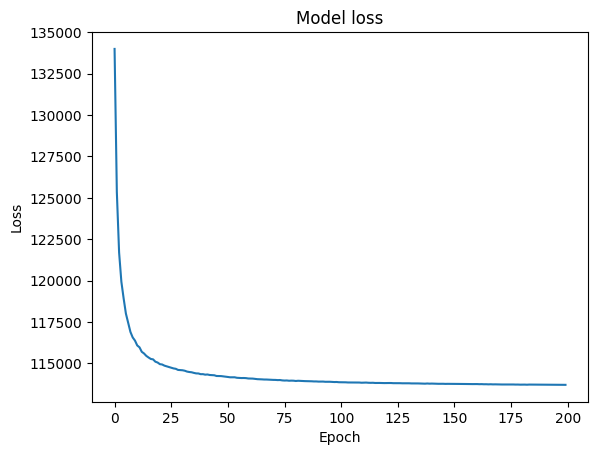

In [ ]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
# Load model

autoencoder_model.load_weights('/content/model_weights.weights.h5')

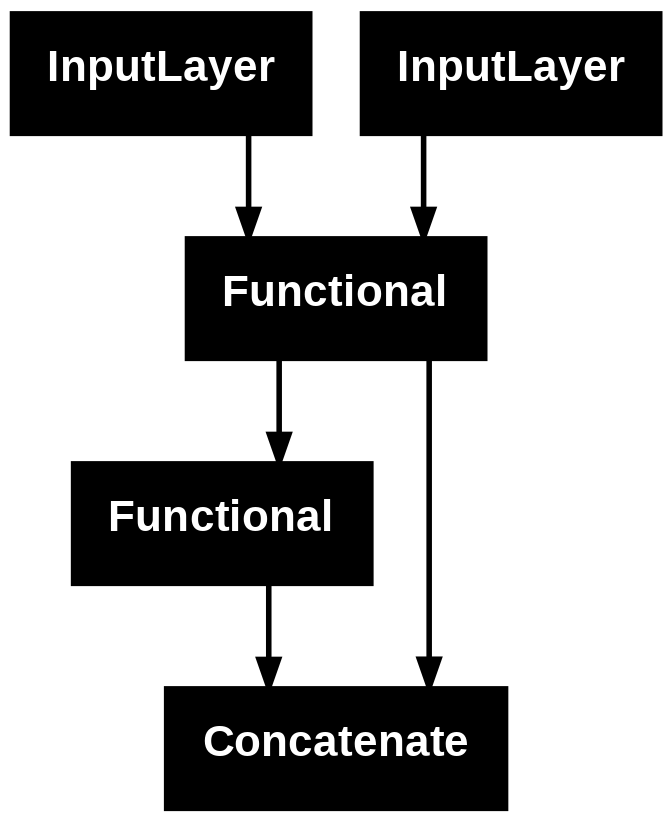

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder_model)

In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)

    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 136.9559
C error per pixel [0, 255]: 11.430552


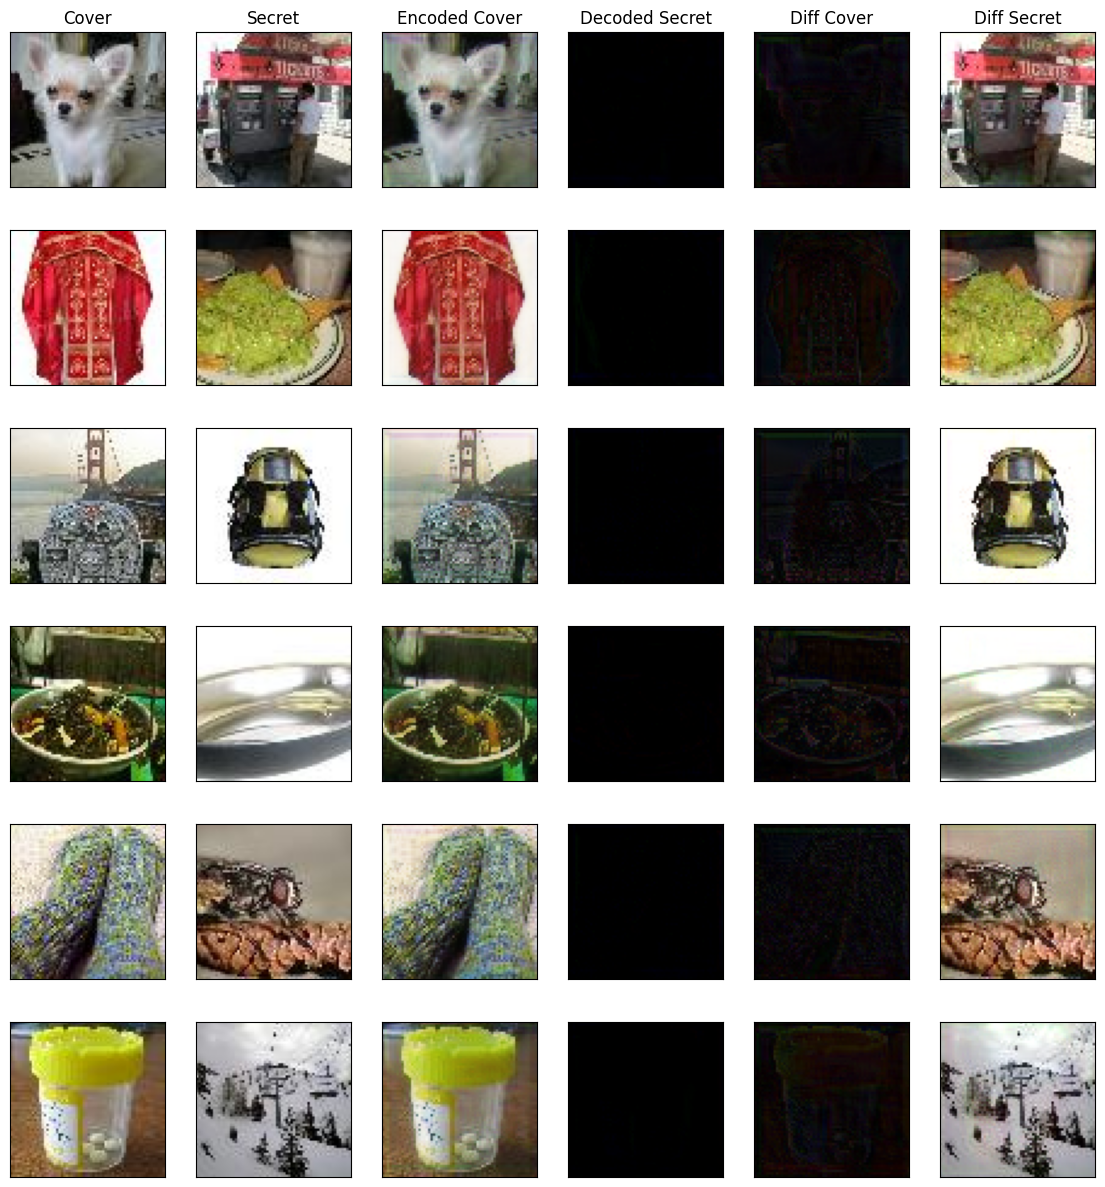

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')


    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [ ]:
from google.colab import files
#files.download('./model_weights_best.hdf5')
#files.download('./model.h5')